# Visulising the lateral distribution

Lateral == perpendicular to shower axis.

Going to make a sequence of plots to see the backbone performance compare to the data.

## version 3

Currently; fits used in backbone are Weibull (experimental) for n-hits, 1D log normal for mean point energy. The fits used in the layers are a 2D gauss for the lateral shape, and a LogNormal for the distribution of energies within an event.

## Content of notebook

Histograms;
* Summed over all layers
    - Lateral hits distribution.
    - Half Lateral hits distribution.
* In each layer
    - Lateral hits distribution.
* In energy slices
    * Lateral distribution in each layer
    * Half Lateral distribution in each layer


## Histograms

Start by getting g4 data


In [1]:
from pointcloud.utils.stats_accumulator import StatsAccumulator, HighLevelStats, RadialView
from pointcloud.models.wish import load_wish_from_accumulator
import numpy as np
from pointcloud.config_varients.wish import Configs
from pointcloud.utils.metadata import Metadata
from pointcloud.data.dataset import PointCloudDataset

configs = Configs()
configs.poly_degree = 3
meta = Metadata(configs)

redo_wish_data = True
remake_wish = True

energy_lower = 0.25
energy_upper = np.inf
varient = ""  # could also use "", or "_0"
file_path = f"../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-100_accumulator.h5"

accumulated_stats = StatsAccumulator.load(file_path)
# get bins
incident_bins = accumulated_stats.incident_bin_boundaries


# Get g4 data
points = incident_bins[:-1] + 0.5*(incident_bins[1:] - incident_bins[:-1])
non_zero_total_events = np.clip(accumulated_stats.total_events, 1, None)[1: -1, np.newaxis, np.newaxis, np.newaxis]

g4_lateral_hits_per_event = accumulated_stats.counts_hist[1:-1]/non_zero_total_events
g4_lateral_sumE_per_event = accumulated_stats.energy_hist[1: -1]/non_zero_total_events


A quick calculation of the average z shift will let us line plots up

In [2]:
z_counts = np.sum(accumulated_stats.counts_hist, axis=(0, 1, 2))
n_z_bins = len(z_counts)
z_values = np.linspace(-1, 1, n_z_bins)
z_shift = np.sum(z_values*z_counts)/np.sum(z_counts)
print(f"Z mean shifted by {z_shift} bins, compared to gun position {meta.gun_xyz_pos}")

Z mean shifted by 0.05239289002791848 bins, compared to gun position [   0.  1804.7  -50. ]


Get the model under comparison.

In [3]:

from pointcloud.models.wish import Wish

wish_path = "../../../point-cloud-diffusion-logs/wish/dataset_accumulators/p22_th90_ph90_en10-100_wish.pt"

if remake_wish:
    #wish_model = Wish(configs)
    wish_model = load_wish_from_accumulator(file_path, config=configs)
    wish_model.save(wish_path)

wish_model = Wish.load(wish_path)



Params for layer 0 ............... 
Params for layer 1 ............... 
Params for layer 2 ............... 
Params for layer 3 ............... 
Params for layer 4 ............... 
Params for layer 5 ............... 
Params for layer 6 ............... 
Params for layer 7 ............... 
Params for layer 8 ............... 
Params for layer 9 ............... 
Params for layer 10 ............... 
Params for layer 11 ............... 
Params for layer 12 ............... 
Params for layer 13 ............... 
Params for layer 14 ............... 
Params for layer 15 ............... 
Params for layer 16 ............... 
Params for layer 17 ............... 
Params for layer 18 ............... 
Params for layer 19 ............... 
Params for layer 20 ............... 
Params for layer 21 ............... 
Params for layer 22 ............... 
Params for layer 23 ............... 
Params for layer 24 ............... 
Params for layer 25 ............... 
Params for layer 26 ............... 
Params for 

Generate some data from that model.

In [4]:
import torch
torch.manual_seed(0)
wish_accumulator = StatsAccumulator()

n_tries_per_point = 100
max_points = 60_000
n_points = len(points)
n_layers = len(wish_model.layers)
wish_accumulator_path = "../../../point-cloud-diffusion-data/wish_accumulation.h5"

import os, h5py
if os.path.exists(wish_accumulator_path) and not redo_wish_data:
    wish_accumulator = StatsAccumulator.load(wish_accumulator_path)
else:
    layer_bottom_pos = np.linspace(0, 29, 30)

    for i, incident in enumerate(points):
        incedent_energies = np.full(n_tries_per_point, incident)
        showers = np.zeros((n_tries_per_point, max_points, 4))
        for p in range(n_tries_per_point):
            
            xs, ys, zs, es = wish_model.inference(incident)
            n_hits = len(xs)
            showers[p, :n_hits, 0] = xs
            showers[p, :n_hits, 1] = ys
            showers[p, :n_hits, 2] = zs
            showers[p, :n_hits, 3] = es
        showers[:, :, 1] /= 15
        showers[:, :, 1] -= 1.
        idxs = list(range(i*n_tries_per_point, (i+1)*n_tries_per_point))
        wish_accumulator.add(idxs, incedent_energies, showers)
        print(f"{i/n_points:.0%}", end='\r')

    # save for next time
    wish_accumulator.save(wish_accumulator_path)

The GFLASH radial equation is

$$
f(x) = 2p\frac{rR_C^2}{(r^2 + R_C^2)^2} + 2(1-p)\frac{rR_T^2}{(r^2 + R_T^2)^2}
$$

The exponential radial equation is

$$
f(x) = p.\frac{\mathrm{exp}(-r/R_c)}{R_c^2} + (1-p)\frac{\mathrm{exp}
$$

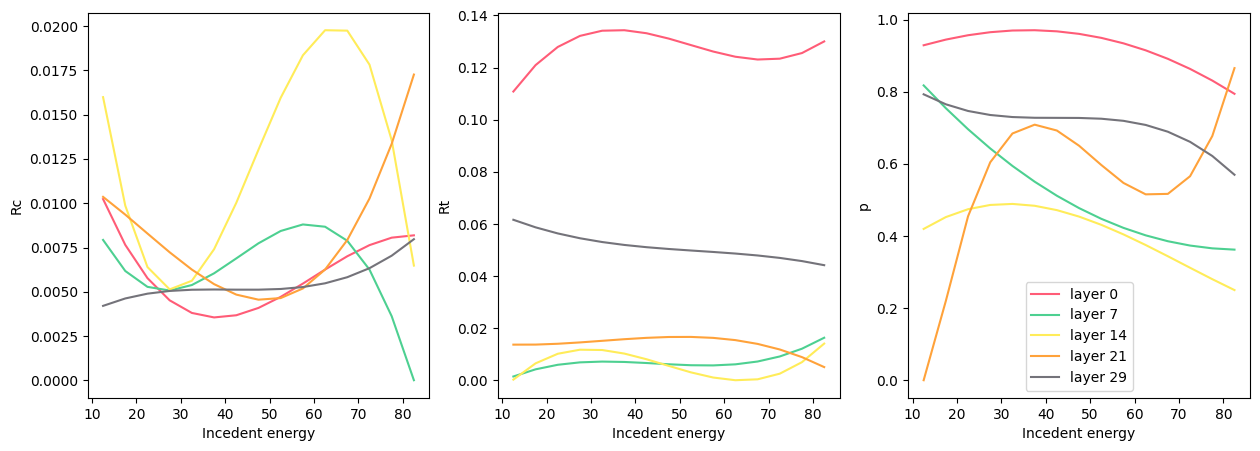

In [5]:
l0 = wish_model.layers[0]
l0.energy_fit.get_standarddev(20)

n_points = len(points)
n_layers = len(wish_model.layers)
from matplotlib import pyplot as plt
from pointcloud.utils.plotting import plot_line_with_devation
import numpy as np
n_intrest = 5
layers_of_intrest = np.linspace(0, n_layers-1, n_intrest).astype(int)

nice_hex = [["#00E5E3", "#8DD7BF", "#FF96C5", "#FF5768", "#FFBF65"],
            ["#FC6238", "#FFD872", "#F2D4CC", "#E77577", "#6C88C4"],
            ["#C05780", "#FF828B", "#E7C582", "#00B0BA", "#0065A2"],
            ["#00CDAC", "#FF6F68", "#FFDACC", "#FF60A8", "#CFF800"],
            ["#FF5C77", "#4DD091", "#FFEC59", "#FFA23A", "#74737A"]]


fig, (ax_Rc, ax_Rt, ax_p) = plt.subplots(1,3, figsize=(15, 5))

c_row = 4
for intrest_n, layer_n in enumerate(layers_of_intrest):
    # parameters
    layer = wish_model.layers[layer_n].displacement_fit
    Rc_values = np.empty_like(points)
    Rt_values = np.empty_like(points)
    p_values = np.empty_like(points)
    for i, p in enumerate(points):
        Rc, Rt, p = layer.get_distribution_args(p)
        Rc_values[i] = Rc.detach().numpy()
        Rt_values[i] = Rt.detach().numpy()
        p_values[i] = p.detach().numpy()
    
    ax_Rc.plot(points, Rc_values, c=nice_hex[c_row][intrest_n], label=f"layer {layer_n}")
    ax_Rt.plot(points, Rt_values, c=nice_hex[c_row][intrest_n], label=f"layer {layer_n}")
    ax_p.plot(points, p_values, c=nice_hex[c_row][intrest_n], label=f"layer {layer_n}")



ax_Rc.set_xlabel("Incedent energy")
ax_Rt.set_xlabel("Incedent energy")
ax_p.set_xlabel("Incedent energy")
ax_Rc.set_ylabel("Rc")
ax_Rt.set_ylabel("Rt")
ax_p.set_ylabel("p")
    
ax_p.legend()

0
1
2
3
4


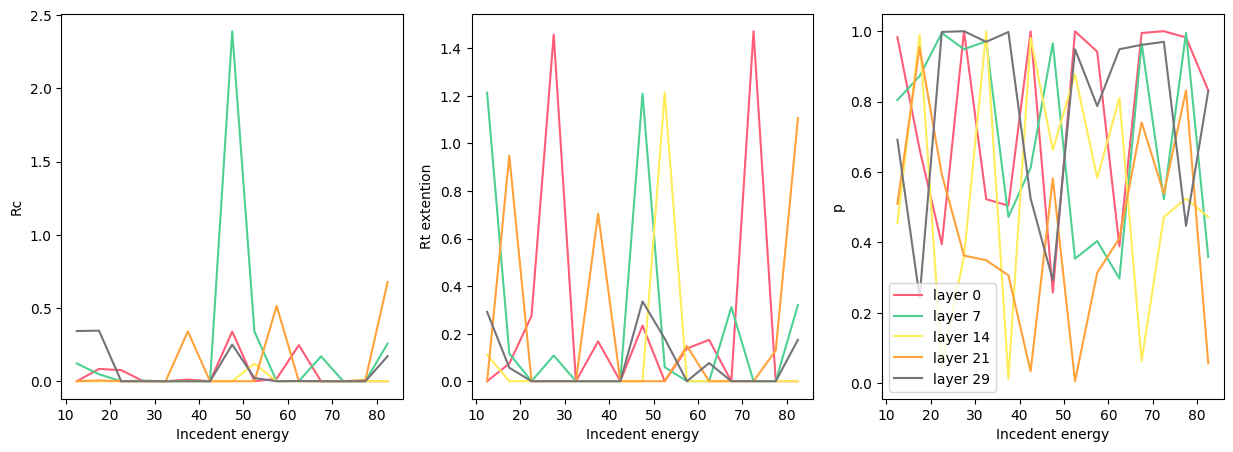

In [6]:
fig, (ax_Rc, ax_Rt, ax_p) = plt.subplots(1,3, figsize=(15, 5))

from pointcloud.models.custom_torch_distributions import GFlashRadial as Radial

def to_fit(radii, p, Rc, Rt):
    model = Radial(Rc, Rt, p)
    radii = torch.Tensor(radii)
    return model.prob(radii).detach().numpy()
    
radialView = RadialView(accumulated_stats)
c_row = 4
for intrest_n, layer_n in enumerate(layers_of_intrest):
    print(intrest_n)
    # parameters
    Rc_values = np.empty_like(points)
    Rt_values = np.empty_like(points)
    eps = 1e-10
    p_values = np.empty_like(points)
    for i, p in enumerate(points):
        popt, cov = radialView.fit_to_energy(p, layer_n, to_fit, p0=[0.5, 0.1, 0.05], bounds=[[eps, eps, 0], [1., np.inf, np.inf,]], n_attempts=100, quiet=True)
        p_values[i] = popt[0]
        Rc_values[i] = popt[1]
        Rt_values[i] = popt[2]
    
    ax_Rc.plot(points, Rc_values, c=nice_hex[c_row][intrest_n], label=f"layer {layer_n}")
    ax_Rt.plot(points, Rt_values, c=nice_hex[c_row][intrest_n], label=f"layer {layer_n}")
    ax_p.plot(points, p_values, c=nice_hex[c_row][intrest_n], label=f"layer {layer_n}")



ax_Rc.set_xlabel("Incedent energy")data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABNEAAAHECAYAAAAXj7zxAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy80BEi2AAAACXBIWXMAAA9hAAAPYQGoP6dpAAEAAElEQVR4nOz9eXgj933mi36qsHABAYJkd7NXdbf2XWrJkizZluVVUXyVODknm8/EEyfOjDPWuXF8JznRnMRLnGPdnMRj5944dnZNkrEdZ2LLk9ixrciWZNnapbZWa+1N3U12kwSIhcRadf741a8KALFUAcUmu/n9PA8fgFgKRbCw1Fvv+30N27ZtBEEQBEEQBEEQBEEQBEHoiLnWKyAIgiAIgiAIgiAIgiAI6x0R0QRBEARBEARBEARBEAShByKiCYIgCIIgCIIgCIIgCEIPREQTBEEQBEEQBEEQBEEQhB6IiCYIgiAIgiAIgiAIgiAIPRARTRAEQRAEQRAEQRAEQRB6ICKaIAiCIAiCIAiCIAiCIPRARDRBEARBEARBEARBEARB6IGIaIIgCIIgCIIgCIIgCILQAxHRBEEQBEEQBEEQBEEQBKEHayqi3XHHHVxzzTUkk0m2bNnCu9/9bl544YWu97nzzjsxDKPpZ3h4+BStsSAIgiAIgiAIgiAIgrARWVMR7b777uODH/wgDz30EHfffTfVapV3vvOdFIvFrvdLpVIcP37c/Tl06NApWmNBEARBEARBEARBEARhIxJdywf/5je/2fT7nXfeyZYtW3j88ce58cYbO97PMAy2bt3a12NalsWxY8dIJpMYhtHXMgRBEAQP27bJ5/Ns374d05QpASCfNYIgCGEinzMrkc8ZQRCEcPH7WbOmIlori4uLAExOTna9XaFQYPfu3ViWxVVXXcUnP/lJLrnkkra3LZfLlMtl9/ejR49y8cUXh7fSgiAIAgBHjhxh586da70a64Jjx46xa9eutV4NQRCEMwr5nPGQzxlBEITVoddnjWHbtn0K16cjlmXxEz/xE2SzWR544IGOt3vwwQd56aWXuPzyy1lcXOSP/uiPuP/++3n22Wfb/qEf+9jH+PjHP77i8iNHjpBKpUL9GwRBEDYiuVyOXbt2kc1mGR8fX+vVWRcsLi6STqfls0YQBCEE5HNmJfI5IwiCEC5+P2vWjYj2a7/2a/zrv/4rDzzwQKAjTNVqlYsuuohf+IVf4BOf+MSK61udaPqJWVxclA8cQRCEEMjlcoyPj8v7agPynAiCIISHvKeuRJ4TQRCEcPH7vrou4py33XYb//Iv/8L9998f2KIdi8XYt28fL7/8ctvrh4aGGBoaCmM1BUEQBEEQBEEQBEEQhA3Kmk7mtG2b2267ja9+9at85zvfYe/evYGXUa/Xefrpp9m2bdsqrKEgCIIgCIIgCIIgCIIgrLET7YMf/CBf+MIX+NrXvkYymWRmZgaA8fFxRkZGAHjve9/Ljh07uOOOOwD4vd/7PV7/+tdz7rnnks1m+cM//EMOHTrE+9///jX7OwRBEARBEARBEARBEIQzmzUV0T73uc8BcNNNNzVd/jd/8zf80i/9EgCHDx9uqhfNZDL86q/+KjMzM0xMTHD11Vfzgx/8QBo3BUEQBEEQBEEQBEEQhFVjTUU0P50G9957b9Pvn/70p/n0pz+9SmskCIIgCIIgCIIgCIIgCCtZ05logiAIgiAIgiAIgiAIgnA6ICKaIAiCIAiCIAiCIAiCIPRARDRBEARBEARBEARBEARB6IGIaIIgCIIgCIIgCIIgCILQAxHRBEEQBEEQBEEQBEEQBKEHIqIJgiAIgiAIgiD0yf3338+tt97K9u3bMQyDu+66q+d97r33Xq666iqGhoY499xzufPOO1d9PQVBEITBERFNEARBEARBEAShT4rFIldccQWf/exnfd3+wIEDvOtd7+Itb3kL+/fv50Mf+hDvf//7+da3vrXKayoIgiAMSnStV0AQBEEQBEEQBOF05ZZbbuGWW27xffvPf/7z7N27l0996lMAXHTRRTzwwAN8+tOf5uabb16t1RQEQRBCQEQ0QVin3LPwHA8uvsJ/PuvHGI7E1np1BEEQBEFYLxyZgS9+HX76HXDuWWu9NkJAHnzwQd7+9rc3XXbzzTfzoQ99qON9yuUy5XLZ/T2Xy63W6q1LSqUy+XyearVGrValVq1RrdWo1WoN5xsur6rr1Plqw3nncue0dmKeyXicG3/xZ9mzJ8TXUvUZqD4HI/8rGKdB+Ku4BF/7Lrzpati1da3Xxh9fvw8KS+p9MCayRiAsC/JLUChCvqjO54veT2HJO51Kw+Xnw2Xnq/OCiGiCsF656+STHCrN83TxNa5J7V3r1REEQRAEYb3w0A/h6Zdg86SIaKchMzMzTE9PN102PT1NLpdjeXmZkZGRFfe54447+PjHP36qVnFdkcvl+L//4DNNImKYHF0u8vSf/BnnnHM2b33bmznvvHMwDGOwhRb/DupHIHYZxC4aeB0ty+LZZ5/ne/d/n6NHj/Or/+GX2LNn98DLdXngCfjX78HCItz2nvCWu1qUK/AP3wTbhgNH4UO/CMNDa71Wa0epAot5T/jKFTqLZIUlKC6r584Pr74Gjz6jzu/YosS0y8+HC/ZCvD+jx3K9goVNInJ6/s9ERBOEdUqhXgIgV1te4zURBEEQBGFdUVxuPhXOeG6//XY+/OEPu7/ncjl27dq1hmt06nj24CtKQDNgNJFgKBYjGo0SjUWJRRvPq9NoVJ+PqdPG6xsvX8wT+bt/5plhg8cTUV555VVeeeVVdu3awVvfdhMXX3whptmni8yac04HcwyWSmUeffRxHnjgQRbmF7zn5JnnwxXRZufVafY0cTjmCp4I9OzLcMdfwH9+HyQTa7tea8HLh9XfX6kGv29iRD1nY6OQSsBYQv2eHFWnoyNw+Dg8/SK8cgSOnlA/33xACWgX7vVcats2gw/x2bJtfv3FL1K2qvzlRb9EzDz9JKnTb40FYYNQqKujbblaaY3XRBAEYQ2wbXjyedizAybH13ptBGF9ISLaac3WrVuZnZ1tumx2dpZUKtXWhQYwNDTE0NBp4NqwS2AMh7rI7xx/GoDi1jiH3znBf9r5Vt48ccHgC37qRajARRWbd/zkzdy3vMjDDz3KkSNH+W93/nemp7fwlre+mSuvvIxIJOJ/uXYJbOe1aS/1tWqZhQwPfP8hHnn4UUoltU8wOjrCli1bOHjwEAsLmb6W25GTzvLyxXCXu1rknPUcGYJIRLmlfv/z8Ju/ApvSa7pqp5znXlECWjQC40lHBGsQwsac01aRbGxUPXe9eN0l8NNvVw62Z19Wr5unX4RMTp1/6kV1u01pz6V28bkw2v59YKFaYKayCMDJaoHtQ+lwnodTiIhogrAOqVp1ylYN8BxpgiAIG4rnXoFP/y1cdRH8xr9f67URhPXF0nLzqXBacf311/ONb3yj6bK7776b66+/fo3WKCSqz0DuDhj9eRi5NZRFvlZa4KX5Y2wGhhMjLFtVPnX4W/ywcIT/sP3Ng80NbnBdpQslfvKn38Xb3nYT3/ve9/nB9x9idvYEX/riP/Ltb/0bN930Jl53zVXEYj4ez8p65+1CoFU6dOgw37v/Bzz99LNYlgXA5s2beNObbuDq1+3j5Zdf5W/++u+Yb3ClhYIW0XKni4jmPK9bN8EHfg7+77+CYyfhE5+D3/oVFTvcKGSc7fjHb4SfWcVikrFRuO5y9WPb8NqsJ6i9cADmsvDdR9SPacJ5Z8HlF8Bl58Hu7eoyYKbive4WqkUR0QRBCIcly5v5kBcRTRCEjYiOlpwM+Wi7IJwJLJWaT4U1pVAo8PLLL7u/HzhwgP379zM5OclZZ53F7bffztGjR/nbv/1bAD7wgQ/wJ3/yJ/zWb/0Wv/zLv8x3vvMdvvzlL/P1r399rf6EcKg+B9hQfRHaG+oC88XZhzHLdQBu3HYxV09v4suzj/BvC8/xo+JxfnP3j7F3ZHN/C19Y9M6fVKLU2FiCW255JzfddCMP/uBh7r//+ywsZPjKV/4nd9/9HW588xt5/euvZbjb/K0mEa23E61er/PMM8/xvft/wKFDh93Lzz3vHG580w1ccOH5bqx0anISgPn5BWzbHnx2GyhBxPn7KSxBra5cTesZLaIlx2D7FvjdX4P/+6/h2AnlSPvP74NzNkbcmYyzHadTp+4xDUMVUOzaCu+6Uc1k+9Grnqg2MwcvHFQ///gt5X677Dy4/AJmG1LIC9XTRLRtQUQ0QViHFOsV97zEOQVB2JAUnB0PcdoIwkqWJM65nnjsscd4y1ve4v6uZ5f9+3//77nzzjs5fvw4hw974sjevXv5+te/zm/8xm/wx3/8x+zcuZO//Mu/5OabV9FF0sjX74cnnoWffKtyioSF5Rz8sMPZMT6wPMf3si+xtaQcWamxJO/e+nouG9vBfz30bV4rZ/jPL32Z921/I++aujy4oJRpmP91otnZNTIyzFvf9mbe+KbreeSRx7nv3u+RzS7y9X/5Jt+55z7e+MbrecMbryeRGF253EYRzeosoi0vl3jkkcf4/gMPksmo+0QiEfbtu4I33XgD27dvW3Gfick0AKVSieXlZUZH2zx+UHJFFQc0bbAMNYz+VAoy/aBjpylnBtpUGn7nP8If3QmvHlEzwn79F5Vwc6aTyavTiTX8nw3H4coL1Q/AiXl46iUlqD33svp//WA//GA/M29IwvVJADI1EdEEQQiJxginONEEQdiQ6C/IRXkPFIQVFBvinLbta5izsHrcdNNN2F2a7u68886293nyySdXca26cHQWXjwELx0OV0SraxEtWISxE1+YeQiAzfURKpRIjCnB6PKxXfz/LngPf3zkbh7NHeTPj97HD/NH+N93vY1UNIAFrnGI/sn28ch4PM4b33g9r3/9NTz5xA/57nfv5+TJOe6++zvcd98DvP76a7nxxjcwPt4gYFgNDuo2guLC/AIPPPAgjzzyuNs4mkiMcv3113H9DdeRSiU7rnI8HieVSpLL5ZmfXwhHRJvLwJ4y/KcT8I1xJaqtdxFNO9FSY95lyQTc/n7447+HZ16CT90Jv/ZzKn54JqOdaJPr6H+2ZQrePgVvfz3Uauq9xnGpzYx7wvLC3Cz0aSRdS0REE4R1SLHeEOcUJ5ogCBsRLaKVylCv+xt+KwgbBR3jrFtQrioXgCD4Ze8O+N7jcPBouMu1Tjqng7tLXlqa5eHcq5gYTFSHmAUSCa95MRUd4Xf23Mo/z/2QO48/wMO5V3nlxRN8+KybuXRsh78HaXSiZXLKjRVvP/MsGo1yzbVXc/Xr9vH008/ynXvu49ix49x/3wN8/4EHueaaq7jpLTcyNTXZEudUz4Vt2xw8eJj77/8+zz7znCu6btmymRtvfANXXX2lv3lrwOTkJLlcnoX5DLt27fT3t3bj5AKcXYa4DfuWPIFqPZNrcaJphofgw/8e/uzL8PBT8NkvQn5JiTlnIpYFi87/a70Kn9EoXHS2+vm5H2P2R1+EsnqvWDh2BC5a4/XrAxHRBGEd0iSi1SWqIQjCBqSxIWyptDFr6wWhHZUqVGve70vLIqIJwdjtiEwHQhTRbAssx80VQpzzvzsutDdPXMDy0lMAjI2NNd3GMAx+YvOVXJLYzh8e+ibHKll+55Wv8HPT1/Kz09cQMczuD7KQa/59LqPma3XBNE2uuOIyLr/8Un70oxe55557OXTwMA899CiPPPI4V1x5GW+97gRb0+r29VqRp578Id+7//scOeI93+effy5vuvENnH/+ue68M79MTk1w8OAh5hdCKheYy8CoisyyvQKv5rrffj3QzommiUXhP/28GoR/z0Pw3+6CfAHe/bYzz7WbKyghzTBgvM1zsQ45XvdE2szyohrfMRaCo/IUIiKaIKxDCg0z0cSJJgjChiTfMEdGRDRB8GgtE1gqweT42qyLcHqye5va6V7Mq0hjGA4WexGoO79UwK6A0Z+4+1zhGE/kDxHB5Oenr+VPig8Cauh/O84Z3cKnz/95/uzofXwn8zxfnH2YpwpH+PBZN7M53iEaWa97Qsz4mHLznFjoKaJpDMPgoosu4MILz+fAqwe55zv38eILL/HkEz/kySfgkvO2sHNbhYeerLGY/zKg3GxXXXUFb3rTG9i6bTrYk9LA1JQqF1gIq6HzZAamHBEtBlSPAFeHs+zVQjvROn03ME349z+pnGpfvQe+8m/q4Ny/u9VtiTwj0EJwOhm6Y395uUQ2m2XTpinfLsmey6xXWKx5BpHMqAH3P6aaRU8jREQThHVIsWEOWsWuU7aqDJnhvHkJgiCcFjQ60WR4uiB4tL4e5PUhBGUorsSio7PKjbYvBBGtPtf8u13sW0T77zNKNHv75MVMGaNUKurgcicRDWAkEudDZ72DK5O7+Nxr3+XZ4jE+9OIX+d93vY3Xj5+z8g6LBTVP0DThnLPgiec6zkXrhmEYnH3OXoZ2pjGef5hnHniS2ME8z76U4NmXEu56X3/Dddxw/XWMJQd3C2kRbX4hpPbqkwuw0/J+j7wWznJXk25ONI1hwE+/Qwltf/fPcPeDyvX0H35GRQzPBAZo5rRtm0KhyPz8PHNzC8zPzzM/t8D8vDpfLKqDmeeeezb/8QO/EsrqzlaaXY4LiQh8/SH4sTeeVuLmGbL1CMKZRaEhzgmqoXNzhxkNgiAIZySFxjiniASC4NL6epDXh9APe3c0iGghDCXSzZzu70UwJwIv5of5IzxdPErUMPnZ6WsoOp8FkUiEoaGhnve/aeJCzh/dyh8d+iYvL5/gkwe/zrumLud9299I3GzY9V3Q4kMSpqfU+RPBRLRMdYnvZV/kvswLvLQ8CwbwpgR//LaXePTRMTK5KFdctMzVN34sNCcPqJloAPNzITrRRhtEtKGZcJYL1G2Lvzh6PxcltvHmiZBKLGy7YSaaD1HyHTeouOCffRke/CEUluH//e/OjBh8Jk921OTOGyLcXDzORYnmRlfLsljMLjI/v8CcI5LNOSLZwvwC5XKlw4I9Dh06gm3bwdtv2zBTUa+7bfFxjlcWKQ6blBcWGHrqRa/Z8zRARDRBWIcU681vaPl6ic10buoRBEE4o6hUodTwPtgaXxOEjUy7OKcgBGXPdnjgifDKBaw2TrSA2LbtutB+bOoyNseTHCkoV9TYWML3Tvz2oTR/cO7P8HczP+Cuk0/y9fmneK54jN/c/WPsHFYClNvMOZGCLc5lPkS05XqFhxZf4d7sC/wwfwQLVRBgYrAveRZvSZ/LXvsh9r6r4XUZ7dzc2g9TU0qczGaz1Ot1IoPE+CxLzUQbaRDRkvOdbx+Qpwqv8Y35p3gk92p4ItpSScVxYWWxQCeuvxISo/DHfwdPvwh/8Jfw//ml024W1woyi3zv/GG+l1hm4eFv887YeUowm5tnfn6BhYUMdf1ctcEwDNLpcaamJtXPpimmpibZtGmKdHqcj330k1SrVYqFYiguSu1E2zuymflqkYpdI5OIsPXfHhQRTRCEwSi2ONFkLpog9Mf999/PH/7hH/L4449z/PhxvvrVr/Lud7/b132///3v8+Y3v5lLL72U/fv3r+p6Ci0Ulpp/l7iaIHiIE00Igz1Oq+M6EtEezx/iR0szxI0o/+uW1wFQKKrldItytiNmRvjl7W/iirFdfObI3RwozfEbL32J/7D9zbx98mKMTIOIttkR0TrEOWt2nf35I9yb+REP516lbHnFHuePTnNT+kLemD6PdGwU6icgC3U7AtSJGIC91He0tR3JZJJoNEqtViOTUTOr+maxALV6s4iWzoNdB2PwGVsHl9V2sVAtUret3mUPftDjHobjHdtU23L5+XD7r8Kn7oSXD8Pvfx5+61dOq5mS9Xqd2dmTHD16TP388CkOl8uc/bUyy8zzNV5ccZ9IJMLk5IQrkm1qEMwmJyeIdom2JpNj5HJ5MplsKCLaTNlzok3GEsxUFlkYi7D1qRdhdt5zha5zREQThHVIod4smklDpyD0R7FY5IorruCXf/mX+emf/mnf98tms7z3ve/lbW97G7Ozs6u4hkJb8i07XyISCIKHzEQTwkCXC2RyqmBgfMDEQ73FvRRQRGt0ob1r0+VMxpRopuOciUR/5TJXp/bwx+e/h08f/jY/LBzh///aPewvHOE/ZeskoNmJdnJBRQUNA9u2eWFphvsyL/DA4ktNw9C3xce5aeJC3jxxAduH0s0PaGUBqBopqlaOpFF3oq0ttxsAwzCYmppkdvYECwuZwUQ0LRwmGtxyMQvqRyF61mArChwsKRHNwiZXW2YiFkJJkJ95aJ049yz4nf8If/BXcPQE/N7n4P/4Fdi2efD1CplqtcrM8VlecwSzY0ePcfz4LLVabcVtrQhUU1Gu2nEemzZtct1kU1OTpNPjgRtgNRMTE66ItuusnYP+SW6cc3qoQUS7eCccfVU1qb7nXQM/xqlARDRBWIdoJ1oEkzoWOXGiCUJf3HLLLdxyyy2B7/eBD3yA97znPUQiEe66667wV0zoTquIJiKBIHisiHPK60Pog+EhJRwcO6Hmog0apbLmoGrBgSXYPgSjhUB3fyj3Kq8sn2TEjPG/bPGaIQsF7UTr3wUzGUvw8bPfzT+deIz/PvMQ38u+yItnRfjNrTHOnxiHqbQSFEsVji4c477qEe7NvODu8AOMR0e4MX0+b564gPNGpjtHSx0RDTNNsbZE0qz35crr+TdNTjA7e4L5QRs6T2YAG4YdJ9rJKGyuQe1AKCLaoZInri5Ui2svogHsmIaP/JoS0mbm4BOfh//8Pjh7cJGoX8rlMseOzSh32WtKNJudPYFlWStuOzw8xPbt29mxczs7Hvghd10JP7xoFEyD/3LhrWwdCs9ZNzGR5tChw2Qy2VCWN+PEObfFx5mMqm1h4fLdcPercN+j8L+8QxWfrHNERBOEdYieibYlnuR4ZXFF0YAgCKvH3/zN3/Dqq6/y93//9/z+7/++r/uUy2XKZe91msvlutxa6Em+Jc4pM58EwWOFE01eH0Kf7NmuRLSDYYho8/BaAV7OQGEUNvsXjuq25brQbt10JanoiHudjnMmAsY5WzENg5+ZvobLxnbyR4e+ySx5/o9f2MQvVnO8xajwwBsmuXe3wUuv/ZN7nyEzyutT53DTxAVcmTzLXxTRUo2Z0cgUBesEUKZUX2Q45H6wKcd9tjCwiLYAcRsijhPtxWHYXIDKKzD85oEWXbctDjeIaPPVAuewZaBlAg2lAgNsE5sm4Hc/AH90Jxx4De74c/jQe+GScwdfvx4sLS1z7OixBofZcU6enMO2V87OGx0dZefO7ezY4fzs3M7k5ITnLPvGo/zt5jEwlah7rJwNVURLp9WyMtnswMuybJtZ7USLp1xBNbMloSLVJxdU8cNN1wz8WKuNiGiCsA7RTrStQ6q5JF+To8yCcCp46aWX+O3f/m2+973vdZ0R0codd9zBxz/+8VVcsw1GvsXBIE4bQfDQovJESkXx5PUh9MueHfCD/YPPRbNLYBegUFW/5yqB3FcPZF/icGmBRGSId2+5qum6QkF9Hoz1Geds5cLENj5zwXv47Nc/x/d3m9wZOcidz/0VvF41f5o27Evt5s0TF3Bd6mxGIgFdMbYnopVspZzlq/MMD4ey+i5Tk6pcYGEhM9iCmpo5I3BwBN5QgMqrgy0XOFrOULM9J9VCLSRHnuNE+2ZpkdJd/8JP/MSP9xdXTI2pGWmf+Vt47hX4o7+BX/t5uPaycNazhRdeeImvfuV/dnQPplJJVyjbsWM7O3duZ3x8vLPrsVKF4jKZRMq96HglC+wObZ0nJtIAZENwoi1UC9RsCxODzfEkkzFV6rBQW4K3XQdf+lf4tx/Am1+nnKHrGBHRBGGdYdu2OxNtWzzNkxwmV5ejzIKw2tTrdd7znvfw8Y9/nPPPPz/QfW+//XY+/OEPu7/ncjl27doV9ipuHLQTLR5zvyQKguCgXw+bJpSIJq8PoV/27lCng4podadUYMkRTJZqUFkEH7pX3bb40uzDAPzU5qsYiww1XV8s9Fcs0I2xyBC/9S8Zvn1uhL+4eYoKdc4vxLjp4TneeN51pG99Z/8Lb4hz1lHKWaGWIeyJW5NTao7b4HHOBa9UwEhANg2cBI6AbcEARQCHlpvn5M1XwxLRipQMuGd+Fh6Y5dJLL+bcc8/ub1kjQyrK+bkvwaPPwJ98AX7p3fDW68JZ1wb+9Rvfcv9fk5MTTYLZjh3bSQYd3J9ZpG5AbsT7Hx0vL3a5Q3C0iBZGnFNHObfEk0QM04tzVotw4xvgn+6GQ8fhpcNwfnhC4GogIpogrDMqdt09arPNseNKO6cgrD75fJ7HHnuMJ598kttuuw0Ay7KwbZtoNMq3v/1t3vrWt7a979DQEENDQ22vE/pAz0SbnoIjMxLnFIRGlhpEtJcOyetD6J/djog2v6jcPf3OmLIcsWSp7l2Wm4GJ3ne9N/MjjpazJCPD/L82XbHi+mJIcc4mSmWM5TI3Pw2v+8BtVIcibP3Go/DkIUgOOI5Bi2hGWolSQKmWHWyZbZia9EQ027Y7u5V6MZeFZIOIVpmEkgHDVagfg2j/c8J0qYBmoRpsTl5HcgXyDdreIw8/1r+IBhCLwm3vgTvvgu8+An/zVdUS/hNvGXhVNa+9dpSjR48TiUT47ds/TDqdHnyhmRyLoyaW6f3vj5Wzgy+3gYkJ9SIOQ0Tzopxq/9aNc9aKkEzA9VfA/Y/Dvz247kW0EDpmBUEIEx3lNDHYHFNNSXlxognCqpNKpXj66afZv3+/+/OBD3yACy64gP3793PddeEflRQ6UHCcaLrqXJw2guChRbPNE82/C0JQRoZg6yZ1fhA3mjUHdRuWG2b45k72vFvVqvPF2UcA+F+3vI7RNtHJwio40cg4QtlwnKnUpJohtcX5vDk5oLPLmYmGmcY0lShZtcKfkzoxmQagVCqxvNznZ2S9DvNZL85pJiCVhKPO/6E+WKRTi2hnjygf3kJoTrRmEe3pp59laWmp8+39YJrwvp/yhLN//NbgDs0GHnn4MQAuu+yScAQ0gEyOTKJZzjleCdeJlnacaMvLy5RKg83o1i65rY6Ipht4M1Xnf/eOG9TpI0+rxuB1jIhogrDO0CJaIjLkDlYVJ5og9EehUHAFMYADBw6wf/9+Dh8+DKgY5nvf+14ATNPk0ksvbfrZsmULw8PDXHrppSRCmsci+MB1ojk7dzLzSRA89Oth82Tz74LQD26k81j/y7DmYanafFmu96yuf1t4jhOVHBPRUX58U/s5VFpEC/UzWItoEw0D2PXraWARLatOzQniETWrqm6F5MBqIB6Pk0qpg+19RzozObAsL3ZrjKph/a85Ilrt4EDrqOOcVyWVqyi0OGe+SK7BfVWr1XjiiR8OvlzDgJ+5GS7cq35/bWbwZQKVSoUnn1Trd+11rwtlmQAs5MgmIgAkIyo6PFtZpG6vbPTsl+HhIUZG1P7ooHPRZp04py4+0HHOfL1ExaqpGY3nnqXE3e8+MtBjrTYiognCOsMT0eKkouoNUZxogtAfjz32GPv27WPfvn0AfPjDH2bfvn185CMfAeD48eOuoCasI7SIttVxBojTRhA82jnRrPB2moQNxh5HRDvwWv/LqM+pOWiN5Lo7SSpWjS+fUDvKP7PlGobMlfWVlXKFalWJc2NjfUZN2+GKaN5AdrY4Itr8ItRqK+/jB7sGtvN3m2mGI2nn8gFdUh2YdCKdC/N9lgtowXCzM47CSKhI7xEtoh3oe92K9TInquq50CJaeHHOInmlHRGJqDMPP/xo23bLvtjcsC2EwFNPPUupVGZycoJzztkbyjIByHpOtHNHthAzItRsi5OVcF1c3ly0wUosZiraiaZed4nIEDFD/f8yNec18vbr1el3HlZi2jpFRDRBWGcUHBFtLDLsHlUo1EuhHlUQhI3CTTfdhG3bK37uvPNOAO68807uvffejvf/2Mc+5rrYhFNIqxOtWlMFA4Kw0bHt5mIBfVmpsnbrJJze7AmhXMCah6IjPCW2qNP8sto2O/DN+WeYrxbZFBvj5qlL2t6m4MxDi0ajDA0FbMnsRsYRRxpFtPExVWZj2yri2A/ahUYEjCSJmHqNRlkdt+jklFr+/EKfTrSTjigy6Ty3RkI50Y40ONH63P/QLrRNsTHOGlaiVK5eomr1KVBqLAvyRTfOeeWVlxONRpk5PstrR0KKX06l1Wm/20ELOsp5zbVX99ci2olMjsyoEqEmYwk3JqkaOsMjrHIBT0RT62kYhjcXTbsUr71MzUfL5OCJ5wZ6vNVERDRBWGc0xjnHHBHNbrhcEAThjMa2vXbOzRNqTglIZE0QAMoVz3U2nlQDsUFeH0L/aBFtLusdwAiKNefFOXe+QZ2W61BqPxetVK/yjyceBeDnpq8lZrbvuis2RDn7HpzfjnZONMPwHEgn+hSlGqKcGAapqHJTDxtV9yB5mExNaSfagCJa2rF1maPKiXYiCtUIUIb68b4Wreeh7RneRDIy7DqOFmoDuvIKS2Db5JyvBlumN3PZ5UqEfeSRxwZbtmbKifmG4EQ7eXKOAwcOYhgGr3vdVQMvr4nMIlnHiTYRS7iFdOuxoXO5XmGxpj6npoe8GHVTQyeoz7S3XKvO3/1g34+32oiIJgjrjMY4Z8yMMOLY2yXSKQjChqBU9iz8yQSMqoMJUi4gCHhRzkgEhmIwqmbVyOtD6JvRYa/EpZ+5aLYF1oLnRJu8GEYcUSzT3kny9fmnWKwtszWe4m2TF3VcdKGg4n+hlgpAexENvIh0vyKa7ZUKAMQjSiwYM2ucqIRfLqBFtPmFAeOcOimr45y2ASdH1WX1/iKdB0vKibZ7ZArDMNwh8gOXCzhCbz6mRLlUMsl116o5Y08++RSVcgiuXKe0gYXswIvSLrQLLzyfdHq8x60DksmzMKaeh4noKNuH0kD4DZ26CCGT7X+5eh7aWGSIsYjXZj8ZU9vZQq1hu3jrdUrUfv5VeG2278dcTUREE4R1RqHBiQaQlHIBQRA2EtoJEY/BULxBJJD3QEFwxbLRYbWTkXBEZpkbKAzCIJFOKwvUvZloqZ2Qct63My+uuPlSvcxXTjwOwM9PX0fUcSi1o1BUrqXEqRLR9Fy0k32KUtqJZqSdUyUQJIy6KyKEiZ6JNj/Xp+g35/ydo07s1hhTcU5oKBfoU0Rb9pxo4DmO5gedi5ZT989FlYyRTCU5+5y9TE1NUi6X+eFTzwy2fPCcaAuDObrq9TqPPfYEEHKhACjXfjZHZlQ70UbZFk8DqxfnzGb6fz5ao5zusqMtcU5QcdqrL1bn/219utFERBOEdUaxRURLRaRcQBCEDUTO+SKVdL7IuyKBOG0EwX0dJByRQpxoQhi45QL9iGhzULdh2RHRkrsgqVojya4UYP7nyf3k6yV2Dk3w5okLui569Z1oLc6gLYPGOZudaJhqvRNmjROVcCN2AFPOTLRsNku9nyHsWiwcdv53xqj32fuqIxP0IaLZts2hUouIFpYTzfmOkDeU8JdMJjEMg2sdN5p2fg2EdqItlWC5//2v5577EYVCkbHkGBdd1H1bD0xhCao1t50zHU00ONFWK87Zf7FAJxGt43ahCwa+/8RA/4PVQkQ0QVhnFBuKBdSpEtPEiSYIwoag4MxL0V/kRSQQBI9GJ1rjqYjMwiDsHcSJNu8JaLFRGE7DuBOLXGxuv87XStx18kkA3rP1OiJG911RPRNtLBGiiGZZkO0U59ROtBBmooGKRwIRAzKV+f6W2YVkMkk0GsW27eDzqqo1T0yMOvPszAQknWznQcchWD8UuFzgRDXPslUlapjsGE4DMBVTyx1cRCtQB4rOOqVSSrC9+nX7ME2TgwcPMTt7YrDHGBny3lsHmIvmFgq87iq3RTQ0nP9dRsc5Y6PuTLTZymKohXRaRMvnC9T6bK6dKav1nR5qfs25IlqtZbu4+BzYvlmV5jzwRF+PuZqIiCYI64xCw0w0aIhzihNNEISNgI5zJp15LFpEk7iaIHivA+1ES8jrQwiBPdvV6ckFKAYc/G7NQdERYZI7Vcw4tVn9vnisSYC56+QTLFkV9gxv4obx83ouWrdzhhrnzBehbqn1HE82X7fFmQ13ok/ByxXR0s4FMeq2Ejly1fBFNMMwvHKBoHPRFrIqEhiPgeGI8EYChuNqlMKJGNgxsJfBmgm06ENOlHPn0KQb19ViyeBxTq+Z0zRNRp3vCOPjKS686HwAHnnk8cEeA7yGzj7nomWzWV544SVAtXKGTiZHKWawHFeFGxPRUTbFksSMCDXb4mQlH9pDJcYSxGIxbNsmm+1PVJztEedcIa4ahudG+7cHuzb9rgUiognCOqM1zpnUcU5xogmCsBHQItpYS5wz6I6dIJyJaMfZaEucU5xowiAkRr0oY9BygfqcNw8tudM53QIGUKtAQQkw2eoS/zz3Q0C50EwfbZuuEy1MEU27r1IJiLa4g3SxwFKpv8+cVhHNMLAM9Rot1vqPwnVjclKt83zQhs4TzvpsmgDb+dx1ZriRGgPLgPo29XvASKcuFdgzMuVe5jrRWh1HQckVXBEtmRzDND05QxcMPP7YE307plwmB2vofPTRJ7Btm7PP3svmzZsGW5d2ZBbJOvPQhswoI2Yc0zDYGldOr+MhxocNw3BLEbJ9NnTOODMBO8U5M+0cim+8Som6x07Cc6/09birhYhogrDOWDETLap2IHPiRBMEYSOQ13FOcaIJwgo6xTkl7iwMyu4+56JZ881ONIBICsZUuzzZVwH4p5OPU7KqnDuyhetSZ/tadGE14pyd5qGBcmCNO3HGfuaiuTPRJrzLnEhnuZ7FXgU3zdQmJVQtBBXRdGR1ehxwGi2ddXXHKSxtUae1g4EWrUsFdg974pE3+2rwYoFGEa2RCy48n1QqSbG4xHPP/WiwxxnAiWZZFo8+ogsFVsGFBpDJsZDwmjkNR5Te5sxFOx5yQ6c3Fy34ci3bdp1o0/H2cc5cvUTVapnrNzIMb7hKnV9nBQMiognCOqPQMhPNc6LJF2RBEDYAeecLtlssIE4bQXDRYvIKJ5qIzMKA9DsXzZpf6UQzE5DUItorzFcL/OvcUwD8u63Xuzv8vXBFtLGxHrcMQKdmTo07Fy2gc8yug+0su0FEi5hq3WOUV2U0y5TjRAsc59TNnNv0c2s0ONGcz9+c83cEdKJ5pQKeEy3MYoFcRG0/yWRzHDcSifC6a5ToMnDBwABOtJdffpVMJsPw8DCXXXbJYOvRiUyObEJJOemoJzKvRxFtvlqgZltEMNkcb/6fJSPDRJ3ZiNlaG/enjnQ+/hzMBX/s1UJENEFYZxRXzESTdk5BEDYQeSkWEISOtLZzisgshMWefkW0OShqEc1ZhpGApPoeS/ZV/nH2MSp2nYtGt7EveZbvRRdXYyZaxhFFOolo/TZ02jnABkwwPKHAdEQ01dAZ3pwqzaQzE21+PuDMNS0SbnHcrMYI6KKHlCOsnXT+jvoB3+UCFavGUUfA2TPS4ERzhJ5lq8pSvRJsXRvJezPRdKlAI9dco5xfL774cl+Cj4t2os0HX8YjjygBb99VVxCPx/tfh25kcmQcEW0iNupevD2eBsKNc8JgIpp2oW2OJ1eUiRiG0XkuGsDOabjobDUT7bsPB37s1UJENEFYR9i2LTPRBEHY2BR0sUDLTDRx2ghCgxOtNc4prw9hQHS5wOy8//dbexnqBa+dM7VLnRqeE6228BLfXngGgH+3zb8LrVKuUK2qmGhiVeKcPUS0oA2dOsppjHtiFLjurjGzzglnLlSYTE1qEW0hWFxUO9E2q/0NN8oJnog2GwN0ucCsr8UeKS1gYZOMDLvCGcBIJM6oqQSlgSKduQI5N865UkTbtGmKc845G9u2efTRAQoGphwn2kIwMapYLPLM088BcN11r+v/8XuRyZFpiHNqdEPnsZCdaOkBRDRvHlr715wWATOd5uW9w3GjffcR1Sq7DhARTRDWEctWFQv1ATjmzkSTdk5BEDYQnWaiiRNNEBpmokmxgBAyyQRsSqvzft1o9YYoZ3QEhh0ByvScaEb+CNSrXDG2i8vGdvpenUJBCS3RaJShoRDdPH7jnEGdaO3moYErTiXMGrOrIKJNTKYBKJXKLC8HeB/QIuFEVJ02iWjO+cVliDrOQZ+RTrdUYHhqhWA65TZ09hnprNWguEzedOKcbZxo4IlXjz7yBJblz0G3Aud5ZT4bqBnyicf3U6/X2bFjOzt2bO/vsf3QGOeMrYxzzlQWqft0D/phIq2Wm81mA993puw0cw61mUMITOrSiU7bxVUXq3htvgiPPB348VcDEdEEYR2hXWhRwyRuqA817UTLiRNNEISNwIp2Tpn5JAgubpxzuPlURDQhDHSk02+5gDUHS7pUYAdo0cQYg+EIdjRCxLbYUc7zv219faBVKRS9Zk6/7jVf+HWiBRbRsupUN3NqTHVAKGHUV0VEi8fjbqzRd0NnuQKLjhss5TSUtnOi5QoQ2avO+ywXOKjnoY2sbKT0xJI+nWjOQba8s8qtxQKaSy+7mJGREbLZLC+91Gero56JVq1BwV9Tq23bPOzMYrt2NV1otTrkCq4TbbLBibYpNkbUMKnZFnODljg0oOOc2exiYGFSb/fT8Q4imrP+HUW0SATecq06v04KBkREE4R1RGOUU39h0DPRKnaNsrU+LKyCIAirgmV5Tht9JHxURAJBcCm2FAtokVninEIY7HWcYof8imjzDfPQdnmXGwkwDCynofMtRpwLE9sCrYpXKhBilBO6t3OC50Sbz6jPJL90EtEccWrMrK1KnBNg0ol0Lsz7LBfQA9pHhiDuiKCmJ8R4xQIFiGoRzacTzW3mnFpxnVsu0Cm214ucEoVyESVhtJuJBhCLxbjq6iuBAQoGYlGvqdXnXLQjh19jdvYEsViMffsu7+9x/ZBVs/UyY06cs8GJFjFMtjpiVZjlAqnxFKZpUq/XyeeDiXMzzky0znFOtf4d45ygRLRIBF4+DAdeC/T4q4GIaIKwjii6zZxD7mWjZpyI81KVhk5BEM5oCktebCLhfKFvdKL1G8sQhDOF1mIBLaaVylCvr806CWcOfTnRWkoFwBWOjKRKVbzFiAVelaIjooU6D61S9VxFnZxoEymIRqBuBZuH5cY5082Xu3HO1XGiAUxOqQjp/IJPJ5qOcm6aANt5Pto60YqeiFY/4CvWeEjHOds60QZs6MwVsYG8qdYj1WYmmubaa5UT7Nlnn3cF2cA0Rjp98LBTKHD55ZcyMjLS32P6wSnH0CJausGJBrDdiXSGORctEomQSqnXTNC5aJ6I1smJ5mO7GE/CtZep8+vAjSYimiCsIwotpQKgWkvGoup3mYsmCMIZjZ6HNjqsdmIARhwnmm1DaYBGL0E43bEsWFbfE1yHpn59gESehcHR5QIzc7DsY3uqz0NRxzkb5p2ZaqfYdOaiTRT8DaVvpLAazZxZR8SKRT0huhXTVOISBIt0uk601plouligxolqLtjwf59MTWknms/1dUsFJsF2hItGEU0X+xSKYGwHokpss050XWymukS2toQBnDW00ok2FVXi3Hy/McNcgWUD9OGCsQ5xToDt27eyc+cO6vU6jz/+ZH+PF6BcoFQqs//JpwC49tqr+3s8v2RzWEB2xGnnbBHRtmkn2io1dGYDiGhL9QqLjgmk80w0n+Lq252CgQd/6I3+WCNERBOEdURrM6cmJXPRBEHYCLQ2cwLEY2qHB6Doby6JIJyRLJc9J4h2oEUjoIeui4gmDEpqzBMODh7rfftGJ1rKi3O+upyjahtuQyfZ4HOpvDhnZ6EkMBkVg2Mi5c1va0c/c9F6xDkTRp2yVXMFhTDRIprvmWgntYg20V5E03HOuqWaVyP+ygUOOfPQtsbHGY6sdB8O7kQrkHfUi5GREWKx7g5HPZfskYcf60+81HPR5nuLUU/98GkqlQqbNk2x9+w9wR8rCAs5CiMmdee5GG8V0RwnWphxTvBEtCBONO2+TEaGV+zfust145w9vuOddxbs3qbm1N0/QPNqCIiIJgjriHZxTvW7EtEK4kQTBOFMJt9GRAMpFxAE8KKcjcIyyNxAIVx0pNNPQ2ftpBJZoCnO+YXZhylaUU9EK85AJZhwouOcY2HGOZ0YXMcop0bPRTsZRETr0M7puPKSEeWfOlENP9KpZ6LN+52Jpv+uRhHNbHieo1HvfSXAXLRuUU4IQUTLF8n1KBVoZN++y4nFYpw4cZJDhw4Hfzwd51zI9rypjnJee93rwi3CaEcmR8Zp5kxGhomZkaarV19E87mdAbOOG266wzw08OKci7Wl7o2ihgFvv0Gdv+ehNR3xISKaIKwjOjnRdLmAxDkFQTijyXUQ0bTrRkQCYSOjReTR4ebLRWQWwsSviGZbUDwBNhAZAkc4eaE4wyO5AxSsCMQjMJJWt8++Gmg1CgUV+Qu1WECXCqR7iGhBnWi2BbYj0HWMczoi2irMRZtyZqJls1nqfmYjNsY5rTZONGhu6Gyci9YFXSqwZ7i9iDal2zlrRax+nGG5AnlTCVSpVBJK98DytzrefHh4mCuuUHO0+ioY2JRWpz2caDPHZzl86AimaXL11fuCP05Qsjkyo0rGmYytfH3omWjHK4vdRamA9ONE6zUPDSAVHSGCiQ1ke7nRrr9CfeadXICnXvS9HmEjIpogrCPcmWhmi4gWUV+QJc4pCMIZjR74nGyOJngNhCKiCRsYvf2PtsxyGpXXhxAifkU0KwNFZ05lcqcbj/zCzEMARExn6Pv4VnUaMNJZXI2ZaFpEmwxbRMsDFmCA0bJsR0QbMmqY2KtSLpBMJolGo9i27U/g0HHOTY1xzpbPXR3pzBebnWhdxK+Dpc7NnAATMfUYNdsiX+/j/SpXJOeoF8lkHIp/BUv/DeonO95FRzr373+aUingfpQb58x2vdkjjgvt4osv7NgYGioLix1LBQA2xcaIGiY12+p//lwb0v2IaGW1vU8PdX7NmYZBOqY+x3q6FIficKP6n3L3D3yvR9iIiCYI6wg3zhltmYkmTjRBEDYCOs7ZutPkxtXkPVDYwGgnZqsTTeKcQpjsdUS043NekUU7rHlYckoFUqpU4PHcQZ4sHCaCyUR82rnOcSUFdqKtRpzTEbAmOrtigOBxTh3lNFJgNEfrGh1eCbPGbCXvb5kBMAzDKxdY6BG1Wy55B6w2T7Zv5wTPibZYhMguIKIEN6u9YFW3LY6U1PPVKc4ZNSKMR5VYMt9PpLNhJlpytOH+tc4C7Z49Z7Fly2aq1So/3P90sMebSqvTTK5jdLBWq/H44/sBT7BbdRrinFqYbCRimK7zK8yGTrdYIJv1PWNOO9G2dXGiAUw6pRO+or5ve70S7Z96EWbnfK1H2IiIJgjriI5xTmcmWl6caIIgnMl0mokmThtBaIhztjjRXKemfEcQQmA8qWaG2TYcPt75dtYcFPU8tJ28uDTDHxz6VwB+bOpShiPOTnMqrU4DiGi2bTcUC6zCTLRecU4touWL3YVEjTsPLb3yOiMCqO/xY0Z9VeKcAJOTKtLZs1xAu9DGRmFkqP1MNGiOcxpRR0gDagfbLvZ4OUvFrjNkRrtG9/T8q77mouWLroiWGm0Q82ovd7yLYRhce60Stx4OGulMJ1Vbq2VBtr34+ewzz7O0tMT4eIoLLjgv2PL7JZsjk1Bi7US0/etjm9OEebwcXkNnOq2WWS5XWPbT3kvjTLTuIpoWAzM1H9vF9BRcdr46f89DvtYjbEREE4R1RLFTnNN1oskOpCAIZzD5HnFOcdoIGxktIic6xDnl9SGEhXajHXyt822sOdeJNj88wcdf/Z+UrCpXjO3il7e/0RNldLwt80rXKGAjlUqFWk0JdOHGOR0hpFecc3RYiUzgz43mNnNOtL/eeS6UE211RDTXidZTRGssFbC6ONGc33NOHNCdi9ZeDG2McppdBuu7c9H6iRnmCuQiatnJ4Yb22C4iGsDVV1+JaZocOfIax47N+H8804QJZ/tdaC9G6UKBa665GtM8BdLKcglKFbLOTLR2cU6A7fE0AMcr2dAeOh6Pk3CcoX7KBeq25W7vW4d6ONGClk6843p1et9jUK74u0+IiIgmCOuIgjjRBEHYyHR0ojlxNXHaCBuZjsUCEncWQma3I6Id6DIXrT7vOtH+IvcK+XqJ80en+S973kXMjHqizFgcDBMqOVj2F73SLrRYLEY8Hu/7z2jCtv23c0KwuWiuiJZuf71bLlDjZCXnOwoXBC2i9XSi6VKBTQ1RTlgpoiUbZqIBRM9Wpx0aOg8uO82cHUoFNFosCRznLFegVPGcaGNlwNlfqh0Eu9bxrmPJMS655CIAHn0koBtNRzrbzEVbmF/gpReVgHfNNVcFW26/OJHkTEo137aLc4LX0BlmnBOClQssVIvUbIsIJpti3dtUAzsULz9fvUaXSvDgfn/3CRER0QRhHdEpzikz0QRB2BB0EtHEiSYIvZ1oEncWwsJ1onUR0WonYFkJFy9EouwenuKje3+SkYgjemlRxiyr4gHwHeksOiJaIpHA6OJqCkRxGaqO0NIrzgnB5qJ1i3OC+1yMmRYVu967gbAPJt2ZaD7jnJsbSgUYUpHNRhrjnNCzXEA70XqJaJ4TLaCI5nw/0O2cybE6DN3gCJQVqHdxTeLNK3v88f1Uq1X/jzuZVqdtRLRHH30CgPPOO8d9/lcdLaKNqf/XqYxzQsNcNB8imo5ybo4niRjdZacJR1z1FecE5RJ82+vV+bsf9O1yDQsR0QRhHdGpWEDaOQVB2BAUZCaaIHREigWEU4UW0Y6dhFL7qFS98BrYUDVN4olpPn72u93xIwAYjghjFyHtuJh8imiFghJuxsbau2z6QpcKjI1CPNb79n050TrEOR0RbUtMzbFajUjn1KTnROvqdGuKc3Zo5oQGEc25TWQnqlygoKK8LRwqKSfa7pH2zZwaz4kWMM6ZK1IFlnWxQKIO8asgeo66oEek8/zzzyWdHmd5eZlnnnnO/+Pqhs6WOKdlWTz66OPAKSwUANdNmRlVYmJHJ5oT55ypLGKFKDAFcaLNONt5r1IB6CPOCaqlMxZVsxtfOuT/fiEgIpogrBMs22bJUl9UOs1EK9bLob4RCoIgrBsqVW9nbcVMNBEJBMGNa7Y60VynphxoE0IinVJD1TuUC5TqVao5dfn8UJKPn/PT7k6wi56JZhch7Qgdmc4tio0UirpUoHsELBBuM6cPFxoEc6LZWXXayYlmqs+06ejqiWgTjmOqVCqzvNzls9J1ojXEOVtLBWClE82IO0IaK8oFlupl92/aPexPRFvw6zjSNDRzRiMWI8MRiF3iW0QzTZNrrrkagEeCFAxMOQJQixPthRdeYnExx+joCJdeerH/5Q1KJk81AgXH8NnJibY5niRqmFTtenDBsguBRDTHBTfdYx4aeHHOTDWAS3NsFK6/Up3/twf93y8EREQThHXCklVBy2OJSPP8Bz0TzcJ23WqCIAhnFAX9Zd6EkVanjbQPCoLnRJNiAeEUsKd9uUDVqvGpg19l2GnnS02c335ouI5zWgWYCOZEKzqfB3qIeSgEmYcGnhMtSLGA0cmJpkS0qahyD61GQ2c8HifllDh0nItm256ItmkCLO1Ea/M8a0d4cRnqdXXeLRdonot2qKQebzKaIBVteX9qoe84Z65ALuKs2lgdI34xGMMQPVddWOst0F5zzVUYhsHLL7/ae3acRsc5W5xojzyiXGhXX72PaLQlCruaZBbJjqonImqYjLWMANJEDNNtxAxzLlo6kBNNPWdb471fczrOma0tUbct/yukCwYeeaZjg+pqICKaIKwTCk5UM25E1UDWBmJmhBFTWc9lLpogCGck7jy0USWkNSIz0QTBizN3inNK3FkIEy2iNZQL1G2LTx3+NsdLr8KSmi82mj6v/f2NNk60xQNg1Xs+tBfnDFNEc4QrP/PQoMGJlgGry069bfueiZZ2RKDVauicnNQNnR2aE4vLUHIOxjfFOduJaKNgGOrv0we5GueiNXBIz0Mb6T4PDTzH0WJtiZrde1twyRVdJ1oyUYfYlc46OdtW/RhY3V1ME5MTnHe+Et0edUSwnmxKq9N5T0TL5ws89+zzAFx77SmMcgJkcmQSXjNnt5mBOkYZZkNnsDinFtF6O9HGoyOYGFjYLNYCfJbt2QHnnqWE3nsf8X+/AVlTEe2OO+7gmmuuIZlMsmXLFt797nfzwgsv9LzfP/7jP3LhhRcyPDzMZZddxje+8Y1TsLaCsLq489A6HFHQbrRckDcWQRCE0wUtorXbaZKZaILQ0M7ZyYkmB9mEENFz0Q4dA8C2bf70te/wg8WX2Rqtus2cbmlAK6aeibYEiW0QGYJ6BQpdygocdJwzsRoi2qRPEW1qXB3Qqda6O1zsPOCIQT1EtFRE3W41nGgAk1PKCTffqVxAu+rGk2ouXLeZaKap4nLQMBetfbnAwWV/pQIAqegIUcPEJmB0L18k7+wipcbqEN/nrOc4mJsBG+q9nY7XXqsinY8++jj1ug8RT89EW8y7xRSPP/YklmVx1u5dbN027f9vCIMGEa1TlFOzfRUaOrWIViwWexY0aLF42ocTLWKYpKNqe8sEdSm+4wZ1+p2HoRZAmB2ANRXR7rvvPj74wQ/y0EMPcffdd1OtVnnnO99Jsdj5ifvBD37AL/zCL/Arv/IrPPnkk7z73e/m3e9+N88888wpXHNBCJ+i1b6ZUzPmzEUrSJxTEIQzkbzzZbp1Hhp4M9EqVah1rrEXhDMa7cTsNBOtUvXaBwVhULQT7egJ7HKFO49/n7sXnsPE4Bc2nwtLzg50JxHNdTdZYFRgfI/61cdctIJTMjMWapxTz0Tr7YoBIBLxXEjdIp1ulDO5suFS4zwXCUOLaKsTO5ua8soF2tLYzAmeiNZuJhq0aeg8CzDBzoHlPcZBn6UCAKZhuOJPoEhnrkBus3p/SyaHIbLFu0670ard56IBXHLJRSQSo+RyeV544aXej5tMqOH1AJlFbNvmkUfUTLXrTrULDRwRTVkaO5UKaFajoXNkZIShITV2qJsbbalecR1lbePebdB/T+B5eddcqrbVTA6eCFAaMQBrKqJ985vf5Jd+6Ze45JJLuOKKK7jzzjs5fPgwjz/e2V75x3/8x/zYj/0Yv/mbv8lFF13EJz7xCa666ir+5E/+5BSuuSCET7HulAr0cKLlxYkmCMKZSKdmTmiekSZz0YSNSL3uFW+0xjlHhlTsCsSNJoTHRErtmFoW/+OV+/nqyScAuG3X2zgnbrtxTlKdRLQ44LRg2kWYcIQOH3PRilpEC9OJltVxzqT/++hIZ7eGzl5RTnCLBYYM9Ro+Uc2tSlGYFtEW/Ipo3WaiAaScy7UTrbFcwJmLZts2hwI40aDPhs5cgXxKiZDJ1Nbm6wLMRYtGo1x9tXKx+SoYMAzPjTa/yIEDhzh5co54PM7lV1zme/VDwbIgm19TJ5phGKTTarndRDTtQktGhjvu27bSV0MnKJHzpmvU+VNUMLCuZqItLiqVVOe52/Hggw/y9re/vemym2++mQcfbP+Elctlcrlc048grEf0TLROcc6U40TLyUw0QRDORPJdRDTT9IQDmYsmbEQaxbFWEc00lZAG8voQwsMwYM8OvnHFKH9XVe6OX9n+Jt4+eTEUjoANmBEY3dxlGW3movkR0VYjzrmg45w+nWjgU0TLqtNuIprzPMQoYWJQsy0yQd02PtD70POdZqJpR90m7URbalq/FbQ60WDFXLS5aoGiVSGCyc6hDsUKLUz109CZL5B3etdS6bObr3NFtJebYqad0HPMnn/+BX/agN5mFhZd4e3KKy9jeNifOBQauSJYln8nWjwNqNlkYYq2OtKZ7SKiBZmH5i7Xbejs47Xx1uvUZ+Hzr8KRmeD3D8i6EdEsy+JDH/oQb3jDG7j00ks73m5mZobp6ebs8fT0NDMz7Z+sO+64g/Hxcfdn165doa63IIRFrzin50QTEU0QhDOQXBcRDRpENHkPFDYgWhwbjquYWStSLiCsAvddluTP3q52gn92yzX85GZnDlXeaewc2wRGl91Js1FEc8SXbHe3kG3bXpxzbKzvdW+iVveEIL/tnOCvodPOqlOzi4DkiFSGvcSmuHLCrUa5wJQzEy2bzbaf9+U60Zy/q1uxADQ40TqLaAedUoGdwxPEzDbvTW2YdBo6AznRUifIl9Tyk1qQdddpDxABexGsuZ6Lmt66hd17zsKyLB577Mnejz2VBmB5do6nnlIjpK69bi2inEqYyqaVmqhniHViczxJ1DCp2vVgz3UP/JQLzDgR0q1D/l9vk/2Iq5qpNFx1kTp/z0PB7x+QdSOiffCDH+SZZ57hS1/6UqjLvf3221lcXHR/jhw5EuryBSEsesY5ncpoaecUBOGMpNBlJhp4c59EJBA2IjrG3DoPTZOQcgEhXB7LHeQzW49jGwY//pLN/7b19d6VhZPqNLm9+0K0OGM1ONHyR6HWeb5vuVyh5sy+DG0mWq6gHEoRs/OBmnb4EdF8OdGczzW7yLQjIK2GiJZMJolGo9i23V7gmOt3JlqDqNFSLhCkVEAzFTS2Z9tw1gK5giOipVrcTUYcImc569U70gnePLNHH3kcu5dLyxHR9h94lWq1yvT0Fs46aw2MOc5cv0xSxaQnYt235YhhukP9wy0XUNtP9zinEtGmOznRDvwbvPTPTRf1HefUvOMGCgbUH3h81T8L14WIdtttt/Ev//IvfPe732Xnzg65eoetW7cyOzvbdNns7Cxbt25te/uhoSFSqVTTjyCsR/y2c4oTTRCEM5Ju7ZzQ0EAoIpqwAdHbfWszp0ZeH0KIPFs4yv/34NepGzZvfm6J//Avsxi6tMKuQ8EZVJ7a031BjXHOkSkYGgfbgsUDHe9SKCjHTCwWI+4MMB+YBWd900kV+fJLkJloRjcnmj44VGNbXAlTq9HQaRiGNxdtoSXSadsrRTR3JlqHg1daRMs3OtHOAgzH9ZVxSwX2+CgV0EwGLRYolbHOL1IoKhEtlWoz106XC/gU0S6/4lKGhuLMzc3z6qsHe6ywEoIemVMaxHXXvQ5Dz6E8lWgRbVQ99kQPJxp4kc7jlfDKBXw50Zzte2u7Zs5KAb7/e/DQH0BD6YEX5wzQ2trIRWfz36eH+T/H6zz9lW/0twyfrKmIZts2t912G1/96lf5zne+w969e3ve5/rrr+eee+5puuzuu+/m+uuvX63VFIRTQsFxmHV2ojkimjjRBOGMxbZtnisc48HFV6hYG6xlr9tMNJC42umEbUHpPqgfX+s1OXPQ233rPDSNvD6EkHhl6QSfOPDPVOw61yT38Ovfr2LWLW/OkJVtaOY8u+NygAYRraBmrOlZVl3moul5aKGWCgRt5tRoJ1o2D+VK+9u4TrRuItoIoISPnXElDK6GiAYwOanWY0VDZ66gGnwNw3VW9ZyJpj+PG51oxlBTuYB2ou0O4ETTcc4FvxHD3BGWJutYtoFhdIj5Ns5F88HQ0BBXXnk54KNgYCrN0Si8Vi0TiUS46uor/a132GRy2EDW2VXs5UQD2OaUCxwP0YmW9iGidXWizT+vxHhsWJ53L/binH1GTw2DE0NR6obB+PX7+luGT9ZURPvgBz/I3//93/OFL3yBZDLJzMwMMzMzLC97XwDe+973cvvtt7u///qv/zrf/OY3+dSnPsWPfvQjPvaxj/HYY49x2223rcWfIAihoZ1onUS0lONEy0k7pyD45v777+fWW29l+/btGIbBXXfd1fX2X/nKV3jHO97B5s2bSaVSXH/99XzrW986NSuLOor80QN3ccfBr/dvZz9d8RvnlLhaaBRqJb4+90MWa30e9e1E9Vko/hkU7wx3uRsZvd33dKLJ60Pon9dKGT524GssWRUuSWznt/b8ONGzdqgrDx5Vp9YcFB0RLXVW9wWaDXFO8FUuoJs5E2FFOcGdJRWomRPU544WqOc6DOv3085pGK5QtTUWBVYnzgldGjr1PLTJFESjypnWcyZam2IBcOei1auvcLSslrtn2L8TLXCcs/wkuYJ63kZHE0TazYWMaSfaAbD9HYTUc82eeuoZlrq5eCfHeWREiaCXXnZxuNtmEDI5ikMGFVPFT3vNRAPYNqRErDBFtAlHjM7lcm1n79Vty92+9eM3Mfecd77krZcW0bLV5b6KEJaWlsmV1P9xy44eUfMBWVMR7XOf+xyLi4vcdNNNbNu2zf35h3/4B/c2hw8f5vhx70jmDTfcwBe+8AX+/M//nCuuuIL/8T/+B3fddVfXMgJBOB3QM9E6xjnFiSYIgSkWi1xxxRV89rOf9XX7+++/n3e84x184xvf4PHHH+ctb3kLt956K08+6WPwbEiMO1+KsmELG+sZ225wonUYJC1xtdD5xvzT/NnR+7jrRMjbtx7sXO894Fnwid7uO81Ek/ZaYUBOVvJ85NWvslhb5pyRzfzO3lsZMqOwx9kZ1SJa7SQsOyJFsvsYHgzn/VyLNdqJlukcufNKBcIU0fLqNKgTzTC86GO7SKdt+5uJBm5kcktMCUCr5UTTItoKJ1prMydlwBFAOs5Ea1MsAO5ctFLlJSxsxiJDTMX8l0BosaRoVSjVq73vYDxLvluUE8Dc5jzHFai/5ms9du3aydZt09RqNZ588ocdb1cdT/DEsBLRrr3yCl/LXhUyObJOM2fCjKvXZw+2O3HOY5VsaKuRTCaJRCJYlkVuceV2vFAtUrMtIpjtt4u5Z73zDeJeOjqKAdSx+jKNzM6eUMtJj696c2rvZ34V6TnED7j33ntXXPYzP/Mz/MzP/MwqrJEgrB29nGjuTDQR0QTBN7fccgu33HKL79t/5jOfafr9k5/8JF/72tf453/+Z/btW11ruCYdHeFEJcfiRnKdlsqqPQ2kWOAUMldVO5YnnNPQsPPNp8LguE60DnFOcWoKA5CtLvGRV+9irlpgx9AEHzv7J73vo3sdJ9oBR0QrHgALNVtsdHP3BTfORAOY0E60LiKaE+dMhCqiOU60yT5mY2+ehEPH25cL2EXAEYF6imjq75mKKjHmZKVA3baIdGs37YNJdyZaByeanvOm3YFEgA6Cg3aiLZehWgPHRafaMCFqHQIuZffwVKAZYSNmnGEzRsmqslArsj2S7nxjuwLDB8gV1HtfstOBNsNUc9GqT6tIp7OO3TAMg+uufR1f+9rXefjhR7nhhuva/h1PvfQKJdNgom5zbnrSx1+4SmQWySTU9pL2EeUEzwk2U17Esm3MEGa5mabJeHqchfkFMtlFJiabo8wzTpRzSzy5cvu27RYnmjcTLWKYpKIjLNaWWagVScd6O+0aOeGIaFumtwS6Xz+si2IBQRD8zERTX5DLVm3jzUoShDXCsizy+TyTk92/NJXLZXK5XNNPv4w7r/XQI3brGe1Ci8eg0yBp12kjIkFY6CO9oY8JsLSIVlTz0YTBKfosFhCRWQhIsV7mYwe+xtFyhk2xMX7v7He7jmgA9jgi2muzSkjJHVS/J9JgtonVNWK2iGhpZ/718nzTQPFGPCeaf2dTT/RMtHQfItoWJ6bYzommXWhGQjVEdsNUz2nSrBM1TOpYqzK2YWrSc6I1GVa0iKadaI1Rzk7Cyugw6OhkvmFdo7sBgyEKTJiVQM2c4BQguJHOHvOvqs+DWSM/pxopk52caNBQLuBvLhrAVVdfSTQa5fixGY4ePdb2Nnpm2jXLNmam/XZ7SsjmyYwq+cZPqQDAlniKCCYVu8683xl0PphIp4H2c9FmnNf21nbz0IozUGqIRpebY9KTbrlA8NeGdqJNi4gmCBuHXnHOhBnHdIaSihtNEE4Nf/RHf0ShUOBnf/Znu97ujjvuYHx83P3Ztav/6nMvzrmBdobzPeahgYgEq0DOaXsOXURzHWi2GiguDI7bztnJiSZxTiE4ZavG7x/4Z15dPsl4dIRPnPNTbI63iBSbJmBsFOp1eG0G8s6YnbEeLjTwnGiW8z4QS0BimzrfYS6anok2FubcqawuFujTiQYdnGhZddrLhQbuc2GyzKaYeo5XYy7axKRal1Kp3DRn3F3/za0iWpfPXcNoH+k0hiGiYr7nxIvsGQkmooEnlsz3EksqTwCQf02JlB3jnBC4oRNgdHSUSy+7GGhfMHDy5ByvvnoAAyWiMT+AiGbbylnXD5UqFJbIOHHOCZ8urYhhMu00ZB4PMdKpGzqzmZWzAvV2Pd12Htqzzb83zESDhnKBAUS0rSKiCcLGoGbXKVnKDt7JiWYYhjcXrSYimiCsNl/4whf4+Mc/zpe//GW2bOn+gXz77bezuLjo/hw5cqTvxx2PKLFoQ5WI6CPc3eI7CZmJFja5unouQ48OWw0xTol0hkPR+dzvOBNtpPl2winns5/9LHv27GF4eJjrrruORx55pOvtP/OZz3DBBRcwMjLCrl27+I3f+A1KpVP3/6vZdf7g4Dd4tniMUTPOx/b+JDuG2jRMGgbsduaiHTgKhZPqfHJH7wdpjXNCz7loqxLnXHDEqsmAM9HAa+hs60TzUSqgcQXFoitqrIaIFo/HXaGpaS7aXEucUzdzdpqHpukxF+2cWJHdAUoFNF5DZxexxLahul89/EnHiZbsJqI5DZ31Y2D5d/Nfe60qGHjyyR9SqTSLXI8++jgAFyRSpC1gIet7uSsofRsWfgkqTwe/r+OmzKZUpHYi6v/1sd1p6DzWwf3ZDxNdGjp1nHNrvI1oraOcpvp/topoE25DZz8imnpvkjinIGwQlureG/ZopLMdfEzmognCKeFLX/oS73//+/nyl7/M29/+9p63HxoaIpVKNf30y3hMxzk3kFjkOA/cL+vtkPbB0NEHZHL1ZV9zan3T6D6zxIkWCks94pwiMq8p//AP/8CHP/xhPvrRj/LEE09wxRVXcPPNN3PixIm2t//CF77Ab//2b/PRj36U559/nr/6q7/iH/7hH/gv/+W/nJL1tWybPz78bzyWP0jciPC7e2/lnNEuO556LtrBo1B0hJ/U2b0fqLVYAGDCuV9HJ5p6zwitWGC5rOZuQp9xzgYRrfV90o1zthEfW9GOL3vJFdFWq1xAj6BYmHeEM8uCuaw6r51oVkOcsxtuQ2ezqLFsqlKJc+P9img+4pz1o2CdhJrpFQt0E9HMcTA3AzbUOzfAtnLOOXuZnJygVCrz1FOeU6per/PYo8oJd+2u3erCQZxo5e+o09qz3W/XDsdNuTCh9gX9OtFgtRo600AvEa1LM+fWq9Rpyzr1G+cslUosLqrHnZ724ZIdEBHRBGEdUHBKBUbMWNcBo265gDjRBGHV+OIXv8j73vc+vvjFL/Kud73rlD/+hmznzAVwokmcMxRs23bjnDXbYsnqM2LSDnGihY/bztkhziki85ryX//rf+VXf/VXed/73sfFF1/M5z//eUZHR/nrv/7rtrf/wQ9+wBve8Abe8573sGfPHt75znfyC7/wCz3da2Fg2zZ/fvRe7su+QAST397zLi4Z6+Eq03PRjh2CoiNIjZ/X+8HcmWhL3nzEtC4XaC9yFArqsy+0OKeOcg4PwUgfjX1TaeXGq1RXurHcZk4/Iprnytuy2iLalFqfeV0ukM2rOG7E9Nx4fuKcAMn2TrSjtTQA58eXGOliAOi4jjEfcc6q0xx9JEnemdvWsVhAoyOdVf9z0UzT5NprrwaaI53PP/8C+XyBsbEEF5/nLHc+63u5TVgZqDspBauPz0XHTZlNKidaOoATbZvjRDtlIpqeidYa56xXYf4FdX7nG9RppzhnwO/AOsqZSiUZGelwsClEREQThHWAbubUTrNOpJw4Z06caILgi0KhwP79+9m/fz8ABw4cYP/+/Rw+fBhQMcz3vve97u2/8IUv8N73vpdPfepTXHfddczMzDAzM+Me3ToVpKMb0InmayZaw8ynMF1TG5Qlq0Idb+h/qPHhRuGsn50FYSU6ptmxWMB5fRTl9XGqqVQqPP74402uZdM0efvb386DDz7Y9j433HADjz/+uCuavfrqq3zjG9/gx3/8x0/JOsfMKAbwobPewetSe3rfQTvRikdhyWmjTPpxoukdfduLDzaKaC3bqm3bFMJ2oi0M0MwJqpFS3/dky/ynIHFOs1FEW72ZaABTU165AODNQ5tKq1ZVZz2Avp1oL1SGsWyYiJTBCv4daUrHObvF9iqOiPbcCHlntbsWC4AX6QwwFw3gdddchWEYHDhwkBMnVCxQC2qve91VRHQhw0Kf3wcrT3nnrT7+706hgW7n9FssALDNcYQdr4T3XTatZ6JlF5uc7Ev1srufOt0a58y+DFYF4inYdIm6rNWJ5rdwooVTWSoAIqIJwrpAO9E6zUPTeE60DbRzLQgD8Nhjj7Fv3z727dsHwIc//GH27dvHRz7yEQCOHz/uCmoAf/7nf06tVuODH/wg27Ztc39+/dd//ZSts3aibah2Th3nTPqIc9YtKIfomtqgtIpmoYm2dt3bWQYpFggL14nWYyZava4cM8IpY25ujnq9zvT0dNPl09PTzMzMtL3Pe97zHn7v936PN77xjcRiMc455xxuuummrnHOsFqgDcPgl7e9kf963s/z5okL/N1p86QSaicKYKGcWQkfO6tGDHBcSlq0Se0CIwLVIhRnm25eLpep1+tAiDPRBmnm1GxuiHQ24jrR0r2XoR1f1hLTjqixWk40LaIttIpomxocc/r/0XMmmhbRmt/LXynlOFpzxPvagcDr6DnROnxGWAWovQhA+ckIZVM50boWC0BzQ2eAAwrj4+NceOH5ADzyyOMsLi7yox+px7/2utcpARKUE62fAxXVBhHN7uP/7jgqM86uYpA45/YGJ5oV0kGWdFptw9Vq1S0DAU8YTkaGV+7X6ijnpothWK0T5cWm53PCjXMGdaIp4VNENEHYQBRdEa27HdotFhAnmiD44qabbsK27RU/d955JwB33nkn9957r3v7e++9t+vtTwXjUV0sUArty866x0+xwFAMImomikTWBqf1cyQ0J5pdBBq2W3GiDU6lCtWaOt/JiTYc9xwm8vpY99x777188pOf5E//9E954okn+MpXvsLXv/51PvGJT3S8T5gt0IZhdJ+BtvIOKtKZdnZsEwkwo/7ua7bMRYvEYNyZL5VtdgsVnJ3xWCxGPB48ItiWQZo5Ne5ctPnmy10nWtA4pxKC5qoF6rbV5U79oWeizeuZaNpBt7lhPX3PRHOuzzc7xg4uz/FKxfnf9iGiTTUUC7SdyVl9GqXYbiOXUZ/98XicoaEekdzoXiAC9iJY891v28K116mCgccfe4KHH3oM27Y5++w9bN68yYvBVqrBx0rYlvP3OPTjRFvIUTcgF1Eic5A455Z4iggmFbse2OHViWg06gqajZHOGUdE6zoPbdPFoEtMrBo0rJMWVzO1DttFB05oJ9pWEdEEYcNQDOxEky/IgnCmknLaOetY7nvDGY+Oc3YrFjCM5siaMBC5ls+R0JxoraKZzEQbHC2KGYYSy9rR+PqQcoFTyqZNm4hEIszONruqZmdn2bp1a9v7/O7v/i6/+Iu/yPvf/34uu+wyfuqnfopPfvKT3HHHHVhWe1ElzBbovtizA8acbWts0v/9GlopXTrMRdMi2thYj7lXQdDNnBN9NHNqtBPtZIMTzbb7c6LZRSaiCWJGBAubk5Xw3yOnnJlo2WxWOfu0iNbkRHM+d3uJaG1motVti8OlBV6uOtf140RzXPdVu+4mcprQUc7ahW6Us6cLDcCIQ8QRmGv+56IBXHTRBYwlxygUinznO/cBcI3T3Ek85j0XQeei1Q84rmzlpuvLiZbJsThqYhtgYrgjfvwQMUw3Wrkakc5MNute5s1Da9fM6RQqbLoYokPgHDRunIuWdraLmm0FMo1InFMQNiC+45zOm4040QThzCVmRtz3gg0T6dRHuLvNRANpIAyRVudZaLM2W0UzcaINjt7eR4Y8t1k7RqV8Yy2Ix+NcffXV3HPPPe5llmVxzz33cP3117e9z9LSEmbL/zLiOG07uS/CbIHui707YMh5nxgL4mLzHFguaWeeWqbZiVYsahHNf1StJ5kBZ6IBbHHaJxvjnPYy4Ig/gWaiLWEahutGO1ENP9KZTCaJRqPYtq1cQnPaidYgfgaeieaJaDOVRSp2jcNV5zmtBxfRYmbUNQesiHTaFlT3q/OFs8mbPksFNH3ORYtEIlzzOtUaWa/XGR4e4vLLL/FuoCOdQeei6Xlo0YvUqb0MdsCxFNkcmYR6j0hHR7sW0bVDN3QeW+VygY7NnOUc5Bzhf9PF6tSJmTaKaDEzQsrZLhZ8NnSWy2V3HbZsERFNEDYMvosFnOtbHQSCIJxZ6HKB7EaZf+gnzgkiEoRIrt4iooUW52x1oslMtIFZ6lEqoNHNnRLnPOV8+MMf5i/+4i/4b//tv/H888/za7/2axSLRd73vvcB8N73vpfbb7/dvf2tt97K5z73Ob70pS9x4MAB7r77bn73d3+XW2+91RXT1h17doDpiEZjO/3fr5uItsKJpksFQnSiZZ33pIFmojkOriYnWladGiNg+HAFGZ6Ihm2xJaYbOsM/0GAYhjcXbSHjrXc7Ec33TDTv/3dweQ6AasTZDqz5viKKjZHOJmovq88OYxTmp7xSgaQPJxo0iGjBnGgA1zgtnQD79l3RHCvWkc6gTjQ9D23o9YDz+g5ygMm2IZNzSwXSAeahaby5aOE50SbSapnZNiLadKuINv+8Ok3uBN3a6c5FyzbddMItF/Anop1w5qGNJcdIJEIU4LvgM8wuCMJqIjPRBEFoZDw6ytFydmM40SzLE8W6FQtAg0ggItqgtI4FCC/O6Yhmxog62i5OtMHpVSqgEZF5zfi5n/s5Tp48yUc+8hFmZma48sor+eY3v+mWDRw+fLjJefY7v/M7GIbB7/zO73D06FE2b97Mrbfeyv/1f/1fa/Un9GbLJNQd94y12f/9zDYi2oQT58wdUjORnPlqxYL6zEskQioVAM+JFsZMtIUc1GoQjXpRTiPtbxk6zokNdoktTrxutRo6JycnmJ09wfzJOZh3noPN7eKcPUQHLaJVqlCqwHCcQyU1a2zb8DYwt4F1XEU641cEW8dYgoOluZVONO1Ci10OuWVyju7kK84JENPlAgfAroHhX/LYvHkTl156MS+88BI3vOH1zVdOaREtgBBlLUHtJWe9rgAjBXbGiXRO+VtGcRmqNTKJGBCsmVOzLZ4G4FglG/i+nWjnRJstOzPRWuOcjVFOjRbRGpxooLaLQ6V5Mt2aWxtwo5ynyIUGIqIJwrog+Ew0+YIsCGcyKceJFpqwsZ4pLnvNTL0iPK5IIAcSBkU7mjfHkpys5sN3opnboP6qzEQLA729j/Zwu+jXhzjR1oTbbruN2267re11jQU2oIZyf/SjH+WjH/3oKVizsKhD2Sm4yARwirWbiZbYCrFRqC5B7rDrTCs4cc7Qmjkty3OiTQ4wEy01pmZiVaowl4Wtm4KVCoCa1UUMqIJddGdUrXZD5/zR4+ozNhaF8Yb/m99igeG497fnCjA86TrR9gxvUoP8K/2JaFPacdQqluh5aPF9kCuQC+pEM7cpcdBegvprEN0TaL3+3S/+PJVKlZGRlvdcN86Z9b+w6rOApdYpshnMFNQzwZx7TsNsZkKtT5BSAY2Ocx5fxThn3bbcePKKOGdjqYBGO9Ja1mkyGsyJ5s1DCyDuD4jEOQVhHVBw45y9ZqINu7ffMK19grABSW8kEU1HOUeHIdojxiQz0UJDxzl3DqsdwNCLBSLb1aldVPNthP4p+nSiaadmcQM4WIVTT/EVsGw1G/1QgF1IN8bY4DYyjIa5aF6k04tzhiSi5YtQt9TjpQaIiBpGQ0OnE40MUirgLqexoXN1nWhunNOJurFpwpupaNdw57n1EtHAK/1x5qIdLCkRbffwlCdQ9TEXbbJdnLM+D/VDgKGcW7miNxPNrxPNMCHqbF8B56KBmo22QkADmEyr0yBONB3ljF+uTk3HoWUHWIbjpsw6ItpEH3HObQ1xzrD2IScm1PcHLaItVIvUbIuoYbpRXUCJuK6Idql3ufP9o9WJFjTO6YpoW6eD/QEDICKaIKwD/DrR9Ew0C5uljdLaJwgbkHHHqr8h4pxuqYCPL/ISVwsN7TzbOaR2tFpnpPWNdp5FdCuhLXPRBkWLxuJEE9aSxR+p03gMDs74v1+7mWjQ0NDpiRxF3c4ZVpzTcfCQGut9kKYXHUU0n040AFM3dC55xQKrFefUIpqO2jU1czb8L3rFOaGpXGC5XmHGWec9I1PKiQZ9NnSq/3NTnFNHOaPnKMEpV2yYiRZACB1gLlpHdJzTb7GAbXsiWswR0QxHRAsy6kA70VIqzjnZhxNtSzyJiUHFrvmOSfYi7TTeLi8vUyqV3XloW2Kp5uKD/FEoL4IZh4lzvct1sUCrE80R0XzHOU8oofhUNXOCiGiCsC4o+nSixcwow6Z6A5W5aIJw5jK+kYoFgohoMjg9NPRnyM4htWMVWpxT7xiYaW/nTCKdg6G3954z0WRmoLCK5ByxKxKDw8ehXvd3P7NNnBMg7YgvDSJaQYtoYTnRtNgxSDOnRg/l10P63Thn2v8yGgRFPXh9vlqgavl8LgMwNenEOYsFbGiZh6ajnKPKtdWLhnIBPQ9tMppQB/wizv/Rmgs8A3OqneOosl+dxvY5j1lwRTTfM9FAiXAQroimnWgLiyoq3AtrBqyTQBRiTjOndqL1E+ccoFggakTcCHFYDZ3Dw8OuYy+bybqlBdOd5qFNnqfeP9wFpNVp60w0N87Z+0BypVIhs6BeiyKiCcIGw68TDRrmoomIJghnLOMRHefcCE4052/sNQ8NxIkWInom2i4nTrFsValYtcEXrF1nRlL9gFc2IPSH60TrFecUJ5qwiuRfU6f2iJqPdeykv/sZjgDTyYnWEOcshj0TLYxmTo3rRFMiUn9xTudzziqSjo4QNyLYwFw1/AMNE47gU6rXWTZoFtH8zkPT6INc+SIHHRFt97AzFN8cBdOJ0dUOBlrHFXFOuwLVZ9T5uBLR6rk8RS2i+Z2JBp4TrX5MDfcPg4mkivbW6260tSsVx4UWvcBrcHXjnH2IaEMqhtlPsQA0Rjqzfd2/HWl3LlqGWceJ5mseGnhOtFKm6eKJTrPy2nDixEls2yaRGA1PfPeBiGiCsA4oBBDRtFuttVlNEIQzh/GY2hkOzR20ngnkRJOZaGFg27a7bU3Hx4k6ToRQ5qK5TrSk+gFxog1KMWCcU0RmYTXIz6rTiLODfPCov/t1inPqhs7icagWsW3bc6KFFucMoZlT4zrRnB3+gZxoSxiGsapz0eLxuOvcmo/grT80O9H80BDnPKRLBUY2edfrSGfAuWg6tpetLVG3Lag+D5TBnITIbkC5E23DwDQMRhMBxCNzHMzNgK1KbsIgEvG2JT9z0VrnoUFDnDO4iJaNKceiFpmCst0RrY6VA8xj64FbLpBddGO+nUW0S5ov1060lvVx45zO+0I3ZmdPfZQTREQThDWnYtWo2upNsVecE7zWvpw40QThjCXtHGXcEHHOQpCZaBLnDIOiVcFSAR9S0RFSkRBFWy2YGWOeAyVgxEdoQW/vvZxo8voQVpOiIxoNO6UhB3yKaGYHEW1oHEYcN1P2AKVSmboTEQ3NibbgCBVhiGiNTjTbBjurfg8yE61BRANWvaFz0ol0LkSMljjnUvP69KKhWECXCuzRTjRomIsWTKwaj45gYmBhk60tQdVp5Yxd4Tq+8svqc2lsLIFpBpQudKSzGmakU89Fy3a/nV2FqiMexRpENDfOGaRYIMdyzGDZUBHSdL9ONEfcOl7J9nX/duhygWwm6zrR9HYNQL0CmZfU+Y5OtOb10U67ql1301qdOOGUCmwREU0QNhb6zcHEYNiM97y9G+cUJ5ognLHomWj5ekkdnT2TyfXhRBOnzUDkHbFs2IwxZEbd5ueBywXsurdz1uREkzjnQGjnZc+ZaOLUFFYJ2wanOZOJ89VpYCfa0sqmXt3QmX3VjXLG43Hi8d7fh32RDVFE04P5l8tQyILtvM6MtP9luMUC6m9d7YbOSWfw+3yE9sUCpl8RTR0QsXMFL87ZzokWsFwgYphu0+RCpQAVR0Rzopzkl8jpUoFUH/9Ddy5a8IbOjkyl1WkvJ1rtRaCsto/IWd7l2okWxKGdWSQ7qp6IITPKiBnrcYf2eE60bF/3b8dEWi0zk8ky4zjKtg41ONEWXgKrqgSzse3Nd9ZOtHoJGvZr42bUNZb0inTqZs6tIqIJwsZCi2ijkTimYfS8vd7ZkZlognDmMhYZxkS9H5zxkU49Ey0ZYCaaiAQDoeeh6cZnLdoOHOe0i+A43JQTTc9EEyfaQPh1oslMNGG1WJ5Tg9QNYOfV6rJDx/wNV290O3Wci/YKBUekC3WukW7nnBjvfjs/DMUh7bynzR/SF4LR43XZiH4unJlknhNtdd4jp4bV5+p8PNJ8oCroTDTHiTZfK1KslzEx2DXUIMpF9jjLPRl4BuaUMxetWD3gDOGPQexSdWWuQD6ivgsFKhXQuA2dryghOAy0E20+2/12eh5a/DLlqtMELRao1SFXJJNQ7bIT0QSGj/3Fdngz0RZ7xiT9ouOc8wsLbkpqa6MTrXEeWut6xxJgRtX51nKBdqUTbdAimsQ5BWGDEWQeGjQ60WQnUhDOVCKG6QrmZ3yks58453LZ386b0BbtONPbWGgimhbLjFEwIg0DxUVEGwi/M9F0e21xef29Pmwb6tW1XguhXxadONxIFLadrwSlShWO+ygXMKKAs22umIvmOdH0PLREWPPQoEFEC8GJBl6kc9Fx4ZnplcJAN1rmw622E23KESgWhqPN62kHFdHUe/nBmNPqPDxBTIsfAOYYmI6IUT8YaB11E+NQzSkUiF3kDeHPFz0nWnIs0HIBxyEXUdFbaz74/dsxpUW0Hk40PQ+tMcoJnohGGWwfBzwW82DbZFJaROsvygmwJZ7ExKBi13wN7feDFtEWMirunYoMM9q4T6ubOVujnKC2SR3pLLeUC0S9uWidqFarzM+rtlyJcwrCBkM70fzMQwNxognCRkELGxvGiebHfdDoxBG3Td94TrSRptOBtzV3HprjGDDFiTYwth08zmnbUK6s7noFpboEX7gJ/uEW6DHjRliH5F5Up4lhiIzC7m3q90HnomknWvZVirpUICwnWqUKBefzJSwRTQ/nL86o0yDz0MAb5H+qZqLVldto3mxxHfUpoh0aVQ3Ou4c3rbxNn5FO7TiatJ1tLLbPuzJXIO/GOftwohlxiOxy1iukuWg6ztltJpq1CHXHrahddS7DgBPH9PPZqJs5N6ltR8df+yFqRFzhNqyGTi2iFfNFqNvNUU6A+Q7NnBod6ezkROsi9p08OYdt24yMjPQnsg6AiGiCsMYEdaLp+E1OZqIJwhnNuFsuEFI1+3pFt3OmfHyZj0aUAwIk0jkAeceJpotqPMF2wM8Vu6GZEzwxTWai9U+5CnXHVdYrzhmLqtcIQHGdfUdw5ihh18Dn9x1hHZFzBsYnHDFqzw51GnQuWmvUb3wPYEA5SyGrXG2hiWh6Hlos2luA9osW0SpquH6gZk5oEBObRbSFWpGKVQthBZuZWlbuz2y95pY2qMfXM9F8CjKOU/zglHp/aSoV0PQtoo2RMGpsNo6pC+JXelfmCuRNJ86Z7ENEg+ZIZxhMptXpQhcnmnahRfaoltBGDCNYuYBu5pxQ+3/p6GCvj7AbOhNjCaJR5UqMLdWZbmzmLGUh77xHdBLRXCdaS0NnVMc5O38Hboxy9htx7RcR0QRhjSkGjXM2DBwXBOHMJR1WxG49U61ByXGl+JmJBlIuEAKuE81xNmsxbXHQYgG9gyxOtPDQYnHEhKEew6QNo2Eu2jp7fSyryA3tdr6F9Y/eER5zHEh7HRHNrxPN6OBEiw5DcicAxYXjQIhxzsZ5aGHtYOs4p+VEz4KKaEZzsUAyMsywMyT+ZDX898lktkDUtrFRg99drIDtnLEojAxxcLNa1z0jbZxokf5EtKlYgiuHFzENGyI7IDLtXZlriHP240SDhnKBsJxojkiUzat5Ze1w56Fd3v76IOUCGSUuZVLquR/EiQYNDZ0hOdEMw3DdaLGC1X4eWmo3xDv8/zo40SbcmWidD8J5ItrmoKs9MCKiCcIa0/9MNBHRBOFMRjvRFs9kJ5p2oZkmjPSY96TRc6Ekztk3OrapP09SYUWHOzrRRETrG3ce2og/IWB0nYrMy45zZ0REtNOSgjP7LOW06+12RDS/5QKmno/YJprlzEUrZJVbcWwspFiWK6L1Kb60Q4topn6vCxrnbC4WMAyDLY64MFsOP9JpzGWZcnSehYWGmVNB45xANT3Ga5PKcbSnbZxzjzq1Zr3iAh9Mxsa4ZthZt9iVzVfmiuQdc21yYCfaAdUgPSjJhHL82rYrcDVhW1B9Wp2PXdF+GX040bxigQFFNF0uUMkOtJxG0o6IFi22ONG6zUPTaCdaqXkmmo5zZrp8B56dVe9L01unO95mtRARTRDWGJmJJghCO1IbwYmmRbSxUSWk+WG9igSnEbpBqzXOGV6xQIsTzS6qHQshOG4zZ1CReZ29PrQTbWRybddDCI5tQyGrzid3q9PtmyEeU7P3ZuZ6L6NFPGrCmYtWKKj3j0RYcc4wmzk1Os4Zd15fgZ1o+m8rq2gzDXPRqqswF+3kApOObjQ/1zBY3xXR/Asyr21PUI8YJOwom2JthE4zCabjCApQLjAVHeHq4az6Jb6v6Tp7Me/OREv1O/Mqss35OytQP9LfMhoxTa+hs12ks34I7BwwDNHzOixDO9F8/M91nNN5a9cOrSaqy/DE52DxYM/FhR3nBG8uWqxYZ1vjTDS3mfOSznfWTrQWZ5wX5+wsyJ5Yo2ZOEBFNENacoHFOPROtZFWprsL8BEEQ1gcbIs6phz77jXLC+o2rnUbodudUSztn+E40/WXflrlo/eK3VECjReb15tRcdnbgxYl2+rE8D3Xn++aY06YZicBZAcoFOsU5AdJqmcUl56ByYjCnjYt2CYVVKgCQTqpoY8pRpox0sPs3ilbOXLQtsVVq6CyVIV9kSpcLtHOimf4Fy4PTah7p7tpI5/lT2o0WINK5yTjBeKRGwYpQNs9uuq6Uy1NzHqvvOKdhQtRZblhz0XS5QLuGTreV8xKnmbbdOmknWoBigaja5ibazUR76Wvw7N/Dw3/Uc3Fa5DpeyWLbdo9b+2M8rZYZK9bZqp1otgXzz6vz3ZxoHeOc6rWyUC22Xc9arcacIwxLnFMQNiBBRbTRyBAm6gMlLw1XgnDGsqHinMkAzgPttFlvg9NPI/RMtKTTyqlPC/US9UEcY64TzXEMGNGGGUAS6ewL14nmU0RbryKziGinL/nX1OloFGJbvcv1XDQ/5QI+RLRCWe0oj4XVsregnWghimimCZsnPBEtcJzTBEO36KrnYstqNXTOZQGYMpWQszDvuEFtC2zn/cHw/1wfmlCywZ7lDsIQ9DUXbaSuIn9PlsbJ1Jr3a3J5dfBlJB4nFusxE7IbbqQzpLlorhMtu/K6XvPQIFicM5vDArKmKoloOxNt/kfq9MQPV4hRrWyJpTAxKFu1rs2XQYil1PeyWNFyY5jkjkAlD5E4TJzT+c5usUC26WK9nIpdY8la2TY9d3Iey7IYHh4ilQrxNe4TEdEEYY0JKqKZhuFGP2UumiCcuWh3UPZMdqL1I6KtV5HgNCJXb3ai6VObAT9X7JZigcbzra18gj+KjogeNM653kRmV0STOOdpR+6QOh2NQqRhFlaQhk6zi4iW3IltxinWlDgTWrFAdhVENIDpcUg4BxuCxjmhQVBsbugM3Yl2Uolmk0mnAXRBi2hLqHd7AsU5D6bUffYsdpnN6DZ0HvS9XKO6H4DHShPMtwyRzy85BQyDRnxDLxdIq9NWJ5q9DLUX1flYFxEtSLHAQo78iEnd+Z/p74bNt3Ee07bg6Pe7Li5mRtw5fMdDinTWnHltw0WbiOHISzrKOXkhmF2E12FHiC41r8uQGSNhKvdjpk2kU5cKbFmDZk4QEU0Q1pxCwJlo0DgXTXYiBeFMJS1OtPbITLSBsG3bFcr0TLSIYbolA7lBPlesljhn43lxovVHUCfa6DoVmUt6JlqbgeTC+ibnROBG497OPzSIaD7KBbrNRDMjlBJnU7fVbunYep6JBrDTeY3VzUCD+V20cOU8F+5MtErI75FzKr45NaVEivn5BRWLs/V3ijgY/t1dB4eVG2jPfJfh/FpEs457DaDdqC9A/SCWDY+X0s3zrypV8jUVI06ODyiEaida/Zi/9eqFdqLNZ5svrz4H1MGcbm4ZbcWvE225DKUymYR6baQiw0SNSMtjLkPusPf74e/1XP1t7ly0bNfb+WVpVIlYZrGGpd8L3HloXaKc0HEmGnjz3+a7iGhrMQ8NREQThDUnqBMNvEa1nDjRBOGMRQscy1aVypk6/zDvfJkdCzADZ70OTj9NKFoVLOeItv4sgZAaOu2WOGfjeT+zX4SVBJ2JltBOtHX2+lhyhs8PixPttCPvONHG0iqOqNmxRc0HK5Vhdr7tXV26xTmBwogqLBiKGoPF9jS2vTrtnADblDuG5SF/jbmttDjRdJwzW1uibFXDWEOF40Sb2KrmRZVKZZaXl/tq5szVllmIqHU7a6bLvoeZAtMRyuuHei/YcaHNWJvIWbHmeGG+SM7Z3JLjAwqh5rizXjbU/UdNO6KdaK1xTh3l7OZCA//FAo6bMjOh3tfblgpkXwFsMJ3XzfFHoMf+4bZ4Wt00pIbOxaEKtgFYNnknguurmRNAFxFU8tDyXddr6BQRTRCEFoK2c4I0dArCRiBhxok6OyxnbLnAIHHO9RZXO03QItmIGSPeELHQpTV9b2t23XM4tHWiSZyzL/R27jvOuQ6LBawa6NiQONFOP/LH1OlYy/DuxnKBXpFOVzhq/z5QjG0HIBEPZ9A5xWWoOjvk6ZDjnFPO7nOuS0StG+6cSPX5NxYZYtSJrYXqRjupnGjxLZtIOUP55+cX+ioVOFRyBrhna4xmeji5InvUae3V3guuPAnAcVvNxWuKc+YKXjNnv6UCjYQ5F61TnLPqYx4aNBcLdBvu77R/ZjerbWYi2uaAo45ybr0aEtugXoZjj3R9eN3QeTwkJ9psrUBtRP2zMpks1MqQcZ7nbs2cAPEUOLO+V5QLOCUKmerKbU5ENEHYwNi2TbGu7NHBnGjqS7LMRBOEMxfDMNzZF2esiOa2c/YR5xQnWl9oES3ZMldl4G3NLuLN2Wl0oumZaOJE6wu9nZ/OxQKlDGCDEYHhkKN1wupi21A4qc6ndqy8vjHS2Q2zS5wTKESVuDoWCel7rXahjY1CPARnWyNpJ6620Of9W+bDGYaxOuUCjojG5kkmJ5UDdH5+wfsfBJmHtqycpHtOViHX44BI1Ge5gF2B6jMA5MwLAJrjnI1OtFBENGcuWjUEEU3HOQtLUHaG3tdnwZoFIhDr4b7STjSqXslDOzI+nGhaRJs8H3a9UZ1/rXuk023oDGkm2kx5keqYiplmM1m1TnZdOY8TXWKtAGbEc6N1KBdYaJmVV6/XG5o5RUQThA1HyapSR30YJ0xxogmC0MwZ39Cpv4xLscApQ39upCLNzqaB45xuM+eoEks0WlCTmWj9oWOZiaDFAuvo9aFLBYYnmuOAwvqnlIGaEzEc273yei2iHXit+3JcYb0E9srxBEWUqJAwispJMygZRxwIu1QAIOGIJgt2f45Pdz6c97muB72HWi7gxDnZPMmkMxdtYT7jOYYDxDm1E233XE0JR91m4GkRrX6w+0KrzwNlMCaIRJQTrUlEyxXIm8qhlEyG6UR7pbv7yw+jwzDsxHodt5jrQoue7zWwdsIYApz9vm6fjTrOOa4eK93NiTZ5Puy6UZ1/7fsropGNuE60yqKakzcgM5VFt1wgk8k2RDkv8Rd51nPRWpxorojW8h14bm6eer3O0FCcdHptDszIJ5kgrCE6yhk1TIa6NZe0IDPRBGFjcMY3dLpOtD5mokmcsy88J1qzKDO4E02LaC07O6a0cw5E38UC6+j1saxLBabWdj2E4OSPqNORCMTaOEr2OiLaoWPdhYlGwcZeeVCoUFE72mPRCiz6mKXVC3ce2iqIaBHnvS4X8YSqILTEOQGm40oICE1EKy577wGb0kxpJ9rCQkOLsn8R7WDJcaLN1dT/Od/lwJ4roh3v7rJy5qERv5LJuBJZm+Kci0XyzvGYcOKcewET7CxYPWb49cIwYDKtzutygYrPKKfGT7nAgiOiOQLVRKzlu5JVg6wTm508D7ZcruKR5UU4+XTHxW6JpTAxKFlVMgMepC3Wy+TrJaquiJbxPw9N44h6rU40L87Z7GB1mzm3bF6TZk4QEU0Q1pTGKGeQN4GUtHMKwobAEzbOQCeabQ82E02caH2hD76kIs2ijOtE69fhrEU0s2Vnx5B2zoHQO8J+iwXWY/GGEwUTEe00JO84zEZj3sD4RnZMQzSittMTXYQJw/TcOW3KBQpF9Rk3FqlC5pVB13p1RTQrq05DFNG0Ey20OKfTzEkyAcNDTG1SItpCHzPRLNt2nWh7lpwD/vn2sVy13HEwJwEbah0EUdt256ER38eU6zgqes6oXMGLcybH2iwkIEYcImep86HMRXMcUAuLyl1ZdYSjXqUCGj/lAo6jMuO8dLSo5LJ4EKwqxBIwth3MKOx8g7ru8P0dFxszI+42N+hcNC38RpLKWZfNLjY0c/aYh6bp6ERTr5WFTiLaGkU5QUQ0QVhT3GbOAFFO8JxoMhNNEM5svDjnOtohDotSBWp1dX6sDxGtWoNKiE1mG4Scc/AlFe0govUd59Tuhk5ONBHR+sKdieYzzqlfH8vl7pGrU4nrRJNmztOOnCOiJaIQaSOCRiOwS5cL9JiL5sYYV7pSiwW1k5yIVTxnzSC4ItoqRL0sR6DKReBEHyKaOxPNOzg27cxEC82J1hDlBBpmomW8GKlPJ9pMZZGyVSNuRNhmOe8vveaiRXrMRbOOgXUCiELsUiZjSiQrWzWKljIY1BbzLDtxzlCcaODNRauFINS65QJZqL0ElFRhQKRN7LkdjeUCnciq67Ix9V1pRZxTRzknzvOi8jrSeeR7Xd2huqHz2IAi2owzV23cea1l5uehOAMYMHWhv4V0nImmtovWds4Ts2pO49bpHvPWVhER0QRhDSk4R/yDlAqAzEQThI1C+kwuFtBHsuMxb7aIH4bi3oyN9RRZO03QB19WxDkjIcU5xYkWHpbVR5yz4f+6Xl4feiaaONFOP3IH1eloDMwO/z8d6TzQq6FTz0ds40QrKFFmLFINWURbRSfaYp8imttU2hjnDLlYwC0VULPQppyZaNlslnotWJxTlwqcNTxFRLvGBy0X0C602MVgDDNkRhlz9oX0EPn8ohJnIqbJyIjP979eNM5FG5TJBida9YfqfOwy/3MfTef+3eKc2olmqAOGk63FAu48tPO8y7ZfC5EhKB73GjLbsK1hLtogaOF304QSajPZjNLuxvdA3OcB0g5ONN1GumxVWXLSW9DYzNnSGHwKERFNENYQ7UQbCyqi6XZOEdEE4YzmjC4WcKOcAeahAZim57ZZT8PTTxO006y1WGA8tGKBDk40uwj2OnFGnS6UKp6TwK8TLRr12gjXS6SzJCLaaUv+sDodSznD0NvgNnT2EtFWikeaQtFxokWrkF3HcU675h0Q6DvO2a5YQK1nrl5iuUEs6JsWES2ZTBKNRrFtm0xWi2j+Pnv1PLTdw1OQcoRQvyJavZOItl+dxva5F3lNjGpbyDmPkRweDm/ulSuiHVDtkYPgOtEWg89Dg4YDTB2EU8uCbJ5qBAooEW1ihRPtJXU6eb53WXQYtl2jzh/p3NKpGzoHdaJpEW77lIpWlit1lutR/1FOgCG1nbaKaCOROCOm+jzTbrR6vc7Jk2qbXKtmThARTRDWlMaZaEFwZ6LVSqG0qgiCsD4ZeNj7ekaLaEGinJr1OPfpNEHPPOsY56wv9/e50tGJpv+/tjfQWvCH3r5jDcKYHxLrrFzAbeeUOOdphW1DYUadH+uys7q3QUTr9t5hdhbRdJxzLFqBpZNQHtCRtVrtnNo1ZEegaPbpRFs5Ey0RGXIPqJ+ohODa1eLeJiVOGIbB1JQuF3DeV3zORHPnoY1s8kS0bjPRoEFEOwZ2y/uQtQS1F9T5+JXuxZPOvK95R0TLL6nT1FgI89A0kW3O81+G+pHBlqWdaMsnvSZSv/PQoKFYoMO2ni9C3SKTUHPooobZvL9oW5BpI6JBQ0tnZxHNbegcdCaaE+fclpggkdBFAMP+SwXAc6K1WRctrupygYWFDLVajVgsRnoi3e9qD4yIaIKwhhQsZyZaYCea2oG0sFmyQjhiJQjCusRr5zwDnWiFPkoFNOuxgfA0Ia+daC1xTi2i1Wyrv88V14nWssNjRBt2GiXSGQjttPQb5dSMrjOnpjsTrc1gemH9UspC1XmPTe7sfLsd0xCJqO1NO6Da0WEmmm3bFHWxQMoRJgaJdNbqkHM+X0IX0fTflwIMNcA/6OzBRkdeg+io3WgnqiFEOnWxwGZPuJ6cVILawkK5eT16oOOce4Y3eZ/XuR4impkGY4K25QLVp4A6RLZDxJtpNeXMv1qoFsC2yZXUeibDmocGKmoZPVudHzTSqZ1omxyhObLbi2j6oVexgOOmzGxRz/lENNHsyCscg2oRzLiKTjay8wb1ty686AnhLeiZaMcriwMZMmYcJ9rWoXEm9Fy0ylB/IlqLEw28MgUtrjY2c5rm2klZIqIJwhpSrPU3Ey1uRhky1ZEJKRcQhDMXHefM1fp0B61n8o4wGDTOCRLnHADtREu2tHMOmVGGndhEX85Hu0OxQONlbQaKC13QTrSEzyinJrGOnJq23dDOKU600wrdzDkcgVgXJ1osCru2qvPdIp0d4pylUol6XUXrEpucoeyDiGiLebXdRSL9HaTphu2IU9EJiJhKsMsGPDjgOsDqgHfAQotos4O68Gx7RZwT8Jxo2Zq6wIeIVqpXXZEkUJwTILpHnbbORavqeWj7mi7WjqP5ahHKFfJO3DI5me79WEFwywUGbOjUTrRznP9/EBca9C4W0CLaZkdEi3WIcqb3qlbORoYnYLOzPh0indPxFCYGJava94Haum25zsmt8XHSY2q+bbaWVOvlF8cV19WJVmsW0dYyygkiognCmlJw4pxBZ6JBQ0OnzEUThDMWPey9YtdZts6wJsr8IE60dSQSnEZYtu0eeGl1oqnLBpiLZnWIczZeJk60YBQDlgpoXCfaOvh+UC2CnvEkM9HWDYcOHeYHP3iYmZnZzjfSIlqiS6mARs9F61YuYLYvFig4ruShoSFiU45LaJC5aHoeWjqpZmiGiS4VMCfBGdbPifmACxnC3QW3VpYLzA7qRCssQdl5zWm3FJ6ItpBxDsj5ENEOl+exUa2Q6dgojPssFoD2c9FsCyrOEP54s4jmOtFqRcgVyDtPUXI85IbVsMoFhuKQHIELnPfZIPPQoHexgLMdZ6fUZ3XHZs7WKKdm15vU6ZH7214dMyNsjqvP5n7nos1XC9SxiBomk7EEE3HlHsyYW1cKe91w45y5FbNTJ9w4pxL6XBFtq4hogrBhKfYZ5wRPROt7CLQgbADuv/9+br31VrZv345hGNx1110973Pvvfdy1VVXMTQ0xLnnnsudd9656uvZieFIrMEddIZFOgcR0cSJ1hdL9TIWageqtVgAPNG2r88Vu0Ocs/GyTkfchfYs9RvnXEcis56HFkuogdfCuuD++77PV7/yP3nppS5CQt6ZGTUaBbNHFLdxLlon3DhnexEtMZaAtCOiZQZwoq1qM6fj8DLTsMVxVgadi2YYDRF373N9OhZSQ6eehzaRapqlOKlFtGxEXeBjJpoX5XREVNeJ1iPOCQ0NnQe9y2qvqviiMQrRZvHHKxYoQK5ILqKii6nxEOOc4Ilo9aNN5Q59cUEMUhZYsRV/T08am6vbJQ10M2dKubs6N3P2ENFO/BDK7YW6bXEl5PXb0KlditPxFBHDZMJQr4+MnQ62IKfkALsOLTMB9aw8XThxQpxogiDods6+RLSoONEEoRfFYpErrriCz372s75uf+DAAd71rnfxlre8hf379/OhD32I97///XzrW99a5TXtzBlbLjBQsYDMROsHHeUcMWPE2hwl1u60wNuaXfd2Brs60STOGQi9fQeOc66j14cW0cSFtq6Y2uRE++a6uKjyjiCWiEKkh4i2Z7s67VYu0CHOWSio94WxsQRMOFG77KvdSwq6sVqlAtDgREt7ItogDZ0Nz8UWxxU0O7CItjLKCTA1qeOcMWzbRDniuqNLBXbreYbJIE40RxCtvwa2M4fNjXJepuZlNtDUztngREslQxbRzHFHFLY7t4f65SLn78rvACNA+Qt4M9Goty3bcOOcY0r0XOFE61QqoEnugIlz1efzaz9oexNdLtCvE22mrEU0JYJN1JR7NVuJB1tQJK4OtMCKuWjudlErYlkWs7Mn1WOusYgWwGcnCELYFNyZaAHfbGiIc8pMNEHoyC233MItt9zi+/af//zn2bt3L5/61KcAuOiii3jggQf49Kc/zc0337xaq9mV8egIs5XcmVcuMMhMtPXktDmN0A6zZLS9s6mxoTMQdhHQEaF2TjQ9E02caIE4E4oF3FIBEdHWE5um1P9jrpuIltNOtFhvJ9rOrWpGWGEJ5rNuK2QTHUS0YtFp5kwkILUbjAhUC7B0AhLTrUvpzao60bLq1JyAzY7K01dD58rnQgsRgzvRHBGt5X8w4cwWK5VNlstjjDYOqe9AU6kAeE60pRLUahDtIiUYaTDGwV5U5QKx86HiiGgtUU5oLBYoYjXGOcMW0UC50Spzai5a7JL+l7PbEWxnt8DZAe9rxMAYAXvZKRdo+ezUIprzdq4H7APq4MTyPGBA+pzOj7HzjZB5WUU6z1n5XXjbgA2dM862ujWeguoyE9VDwCYyhVrwhQ2nVfy/lIHx3e7FehZcplp0mzmj0ahblLFWiBNNENaQoqVnogWPOOidIHGiCUJ4PPjgg7z97W9vuuzmm2/mwQcf7Hq/crlMLpdr+gmL8UHmVK1nBmnnlDhnX+htqF2UEwZwPbrNnKNqB7gVLazJTLRguHHOgN8R1pPI7JYKiIi2npjapP4f8/MdBCDb9uKcieH2hSGNxGOw0xG8Os1FMzuIaM5nwdhYAiIxSJ2lruh3LtopEdHSntOrHxHNfS68g2N6PlWhXnaTKn2hnXENzZwA8XicVFK9x89ne3/u2rbNQceJ5sY5R4eVWAq9I52G0RDpPKCisPWDgAGxK1fcPB0dxQAsbLL5jCeihdnOqdHlAtUBygXsEkw672+v9LmObrlAm++MWkSLqRlhTcUCOsqZOgtiXQ6y7LpRnR57BGortyntROs3zjlbaXCiLbzAREx95hSKS1SrAef4uuUCzevSGOfUUc7NWzataTMniIgmCGvKIHHOlDsTTUQ0QQiLmZkZpqebj3xPT0+Ty+VYXu68Q3rHHXcwPj7u/uzatSu0ddINndkzTURznWgS5zxV6IMuqQ5OtL5FNHceWocdCR3nlHbOYLhxzj6daOvh9VFyduiHpZlzPbHJiXMuLGTcZswmyovgDPJmbBoMH7uMu3vMRfMzEw28SGe/c9FcES3kgfTQMBNtoiHOmQm+HD0TreG5GI3E3ZTJQG60ufZONIDJSfW484u931MWakXy9RImBrv069c0vc/sfIC5aPUDUNnvXHZOQ5TRI2KYbmTxWGEBy3HKjfUz8qHneumGzlf6jw1XnwPTgvkIHO7DeQUN5QKdRbSsqcSopjhnr3lomsnzYXQa6iU4/uiKq92ZaOVsXw3wM06T7NahcZh7lpFIjaGIWk4mkw22MF0u0CHOuWRVODozA6x9lBNERBOENcOybZZkJpognBHcfvvtLC4uuj9HjhwJbdln5Ew0y1KxHxAn2ikk16WZEyDlFAsEHhOgRbR289CgeYCy4J9+iwXcmWjr4PWhZ6KN9ogDCqeUZDJJLBbDsqz2O7u6mXM4AjGfO6y9ygXcNsgy2J7oUHDinImEc70uF1hvTjS77sTuaJ6Jtpj32jD94hYLNAtRbkPnICJah5loAJMTan9jIdt7fpeOcu4YShNvnKEZaC5aQ7mAjnLGVkY5NTrSeXxZfVYkYjGi3SKj/RLdC5hgZ8Hqw0kIUH1Knf5oBOb7/H+5n40t969UobCEDWSceXITjcUCroh2Xo/lGw0tnd9bcfV0PIWJwbJV7etArS4W2Bofh7nnMAxIJ9X3i8AimutEa77fiBlnyNn+Xps5rh5PRDRB2LgsWRU9QYaxgWairYMvyYJwhrB161ZmZ2ebLpudnSWVSjEy0nlHdmhoiFQq1fQTFvro4xnVzllc9o7+jslMtFOFOxMt0n0mWvA4p7Mz1dOJJiJaIIoDxjnXg8isRTRxoq0rTNNkymlrbBvp1CKan1IBzR5HRDvQoVzAGAWcOVwN4lHBjXM6sW9XRBvUiRa2iJZDzX40VQwvMeq91oK60dyIe/Pn+pa4bujs873Ssjwn2uaVr7mpCRW3n8+0id234EY5R1r+/0EaOiPaifYaVJ9W59vMQ9No19GJinpekl2+dw2EMQQRJzZc6zPSWXH+nh8Nw0JWPfdBMTvEObPq92IiRtVWTtGJtk60C3o/ho50vvYAWM2u05gZZZMTIw46F61YL7tGjul4CuaeU+s5ocTbbN9OtObXkmEY7jy4WSfOuUVENEHYuOgoZ9yItm1J64U40QQhfK6//nruueeepsvuvvturr/++jVaowGEjfWMjoGMDkO095f5FaynuNpphC4M6OREc12PgYsFxIm2Kujtu28n2jp4fbjtnCKirTd0Q2fbcgEtoo3GwPQ5z+6sbSruly/CQpsZS4apBqlDU7S7aSYaeIPSFw+BFTAmt1yGkjP7KWwRTUc5jXEv3rrFeW5OdCloaIe5Sk60XAGqNeVAmlwZZ52aUOu9kO0d3TtUUk603cOdRDQfTjRz0pn7ZQFlMCYgsrvjzSfdcgH13pVMrEKUU+NGOvsQ0eonwToOmPDyCNTq/uKtrWgRrdWJllGfldlt6vpEZMhzA1YKUDimzveKcwJMXwHxpHJ4nXx6xdXbdaSzkg206rqZczw6wmh5URWBGCbpLaqpt28nWkucExxx1bbJOmK1xDkFYQOjRbSxPqKcIO2cguCHQqHA/v372b9/PwAHDhxg//79HD58GFAxzPe+973u7T/wgQ/w6quv8lu/9Vv86Ec/4k//9E/58pe/zG/8xm+sxeoDkD4jRTQ9a6fPL8iNcc5+jv5uUPTnRaqHEy1wiYXlcyaaXQRb/l++0U7LwDPR1pMTTbdzSpxzvaEbOufbiWg5LaJFezdzauIx2OHs3HYqF3AdWI1ONCXGuCLa2FaIjoBV9RpC/ZJxxLuRIRju7/t1R9x5aGnvMu32OhkwEujGOZudaNOuE61PEe2Es45T420PUE1OqPff+UybOXgtHFxuKRXQpHSc04do1FguABC/Ul3WAe1Ey9WVeBqmq38F0XPVaa2P2LCOckbPg2FHrJzvYzh/p2IBZzte2KyejyYXWuYldZqYhiEfz48ZhR03qPNtIp26ofNYQCeaFnobXWikz2ZiSr1f9D0Trc16TEYTRIsW9WqNSCTiumjXEhHRBGGN8EoFgkc5wdvZESeaIHTmscceY9++fezbp+IDH/7wh9m3bx8f+chHADh+/LgrqAHs3buXr3/969x9991cccUVfOpTn+Iv//Ivufnmm9dk/cErFjij4pz6iG2qTxFNiwS2HXwWzQYmV+8+E0070UpWlXIQB0hPJ5r+P9tgS7mAb4q6WCBgnFOLbpUq1PoceB0G9aq3QyROtHWHbujs6kRLBHCigRfpPNRjLpojotm2TbGoPtvcmWiGCWlHeAk6F+1UNXNq9Fy0oA2dHUoWtgwqomkxr02pAMBUWr0fZBer7QslHGp2ndfKalmd45w+38ubRLTOUU7wmhiLTuwwuRrlEBpXRDug5t0FQYtoscs9x99CNvg6dCoW0M2cU+q9vG2Uc8KHC03jzkW7f0XUetuQLhcIJgK2zkMDYOpiJibSat37FtFWrsdELMHQotp2N2/eRCTSR4IhZFZhUp8gCH4YpJkTPCfaslWlatWJmWv/hiII642bbrqpa+PQnXfe2fY+Tz755CquVTAaiwUs28bschT3tEGLaP3MQwPleIhFVWyluAwjAUWGDYo7E62DiDZqxokaJjXbIldbZnO8gyjWiutEG2t/vRFVzgt7yRHcVtFdcKZQr3uxtKBxzsbXw1LJ2+k91ejZNkYEhlZxZ1joi02OiNZ1JtpogJloAHt3wvceh1c6OMjMBNRxRbTl5RKW4yZuamFMn6N2zIPORVvVZs6sOjUbBCo9vD/wTLRmMVGzxXnPna3ksG0bI+jnfZd5aADJ0WWiUYtazSSTybrbQCtHS1lqtsWoGWdzrOVzIBWgWAC8uWhEIXZp15tOOU60kgURIDXVXgwMhcg2FS+2l6F+BKJ7/N3PrkH1GXU+fjlMLqntvS8nWodiAd3MmVYFEOm2pQIBRLTt14EZVzHQ7AGYONu7Kp4G4FjQOKcj9CoR7Vl14aaLmYip5WWzwZbHkPO/7hDnjGeViLYeopwgTjRBWDMKA4poiciQHs9KQdxognDGoqN3FvaZ81rXIlo/zZya0YZIp+ALLaJ1inMahuFeFyjSqd1lneKcjddZ4kTzReM8s6AisWmqOBus7eujcR6aIbsc641NDcUCVmMsvpwDPdg+EQ3mRDvfmXf10uH2UXvXgaXeB3SUc3h4qLmFUc9Fy/Qroq2GE61NnLNvJ1r3OOeSVXEPtgdCO9HaNHMCGCy5brS24qnDQXce2tRKIS9IsQBA/DKIXQIj7waj+3uZnolWq6ltJ+m4mlYFw4SoIyYFiXTWXlbCmzGmBMIpHefMBl+HXk60hHpNNDvRnDhnr2bORmKjsO0adf7I/U1X6Tjn8XK260HnVmbL2omWhPkfqQs3X+I60RYXc13djivQB1pK2RVuucnoqOtEExFNEDY43ky0/hwUpmG495VIpyCcucTMiCu2nzFz0QohiGg64rYehqefBli27R680eMA2tFXkYXVI87ZeJ2UC/hDb9fD8dO3fMMV0QKIMMIpYzw9TiQSoV6vk802uGj0HLLhCETTYAQYO7Jrq5pFVirDkZmV17fMRCsW1WmidYC8dsoEjnM6f8eqxjkbBCotop1caN9I2gmzvRNtyIy57vO+ygXmnHXsIKJhLzHpiGgL3US0ZSWirYhyQvA4pzEMqf8TRn+65021E80oq+cymfTphu6XfuaiuVHOy5QQN5VWv7cr0+iFWyyQb54XqkW0ESVgTmgnWr0MiwfV+SBONGiOdDawNZ7CQCWbsgE+93Wcc3dpEWrLSqhL7SaZTBKJRLAsi1wuwOe9jnNaFWgZXzIZGyO+qAQ5EdEEYYMz6Ew08CKdOSkXEIQzmjOuXEAXCyT7jHOCONECUqyXsXB2TLocvNE7cLkgDZ12jzhn43WWiGi+0KUCQaOcGj03cGkNXx8lZye9dTC5sC4wTdMd0N00Fy3fR6mAt1A47yx1/sWDK69viTEW3GbOlveOtCOiFY5BNcA80FM9E20qrQblV6qwGMBl6z4PyyvKVgZq6HSdaB1mENpFptJVAOYXOkdQD5XU9rC73WtXH/zqp42yB8nIMFHbIFJSz0kqdapEtAANnZWGeWgwmBPN/cxsmReq45xx9Ty4TrTsq2p+29A4jAYUk3a+ETBg4QUozroXx8yoG9n129BZty1OOG7VrTln/uHURWBGME2T8bR6TgLNRYuOgN4nbol0pqMjxMWJJggCDD4TDby5NuJEE4QzmzOuXCDMOOdaigSnEVoUGzFjXWdo6tIB34KtXfciSb6caBLn9IUWh0f7nPeXWA9ONOVmESfa+kWLaE0NnXlnp3g0BpE+/nfn71GnLxxceZ3ZXkRLtM7HHJ6AYUcI0s4bP5ySOGeDyysa9USUIJFOHefEVkJaA25DZzWgiGZZnpDTSUSzim6cs6sTreTDiVauQCncYh/DMJisRIhUtRNtlec5ahGtfhQsH9+vrBzUD6jzcUdEm0yr036caEa04QCT8/+2ba+d01SC50TM2V50lHPivK4tp20ZmYDNl6nzLS2djZFOP8xVC9SxiBomiYwjQG662L1+Iq2WF0hEM4yOc9GixTqRqo1twNjk+pipKiKaIKwRg85EA89NkD9T3CmCILRlPAwn2nIGXvvBiqPea0IYIpqOc4oTzRfasdwtygkEn4lmF8FxuHV3oumZaOJE84UWv/p2oq0Dp+ays5MuzZzrFj1Yfq5RUMk7cc5EH0408ES0Fw+ujDi2tFLqOOdYa5wTPDdaJkDUbrWKBWwLbEckMdLN121uiHT6xYgBjuumZS7alphu6Az4XrmQg7oFkQik2xzQsGtAmUnHibaw0H59C7USc1V1sKOtE204rop9APLhHxSZdP7siGkwNNT/PpIvzHFnG7c9cawb1WfUbSO7PDFVi6iZnCqECUprucDSsipNArK2+hxIO62lfZUKNOJGOjuJaP6EwBnndtPxFOb88+rCTZe416ed1182E7Bww23ozDZdnJ9Tj1dJRcjbfcwKXAVERBOENcKbiSZONEEQuqNFtOwgTrRH/yt89zfh2EMhrdUA6DjnWBhONHn/80O+R6mAJrBg6zZzjqoWxk64s5BERPPF0oBOtPUQ55SZaOueKd3Q2THO2cf/7uxdEDGVqDDXshPtxhh1sUCHOCfAhFMu4HcummVB1nl/CduJZucBCzC8YfAaLaKdmG+9V3fccoHmWOT0kI5zBnQ2aRFvU1rFaltxHmdqwisWaDdI/qAT5dwSS7Y/0G8YwcsFApBaVAf6YkOx4O2k/RB1tjM/kc5qS5QT1HMRiTgOsj4+31rLBRbUaS01Ss7Zv3PjnGGJaLNPqgIRh+3OUP9jPp1oets8yxxWbZ/Q7ERzygUCOdGgo4h24sRJACrjUTLrJJEhIpogrBFhONFSMhNNEDYEXpxzgB3ixUPO6eEQ1mhAXCfaADPREhLnDIL+Mq7jmp3QTjX/TjQtovWYXaPjnNLO6Y+i87me6NOJpu9XlGIBoTOuE61dnDMR68+JNhyH3TvU+RcPNV9nthQLuHHOdk40LaL5bOjMFZWQZhgwHnIMUEc5jdTKgwVuuUBA102HcoG+nWhasNzUqVRAPc5EWrnISqUyy8sr3+e7Rjk1qdWbi5bIKaecORLtccuQ0JHOag+x1rah8rQ63yiimSZMOkLYQjb447vlAo6o5bgpF7cksQETQ30uW3XPldmviJbaBeN71RiGow+6F2+LpwH/M9FmnHl9l5QLgA2J6ab3+b5FtMaGzgZmZ08AUE5HWaiuj+8Qayqi3X///dx6661s374dwzC46667ut7+3nvvxTCMFT8zM23aXwRhnRPOTDT1JVmcaIJwZhNOnNPZSdJzitaKak01t0E4M9EkzukLLYole4hoXrGAz88VLaJ1m4cGDZEVcaL5YuBigXUgMouItu5xZ6LNL2BZlnKn6EjXaBQifYhoABfsVqet5QItcc5CQe0Qj7UV0XRDp08RTTdzjjvOoDBx56GlV16nRbQgM9FgxXPhLq6hWKCdU6wjvUoFnJlf8XjCHdg/P7dynQ8tdykV0CQDNnQGIL6oRDQrcapEtAYnWrfnu34E7AwQh9gFzddpEW2+n7lo+gCTI6JlnVKBLeo5TkdHMQ1DxazrJYgMQ3Jn8MfR7LpRnTZEOrc3xDn9bHPaiXbOkhK3GqOcABMTSsgNLqKp9egkolXGo2SCFI2sImsqohWLRa644go++9nPBrrfCy+8wPHjx92fLVvWR0uDIAQhFBHNnYkmIpognMl47Zx9fnmoVz17/HLAyEnYFPQQerP/qBp4M9EkzukLdyZajzhnKnCc09mJ8u1EExHNF1ocTvT5GlnrmYG23TATTUS09crERBrTNKnVauRyec+FNhSBqNlfnBOa56I10trO6cxES7SdibYXMKCUUTM9e3Gqmzk1/cxEg4Y4Z8tMtLh6ryxZ1WAHybUTbnN3JxpGgslJRzxtMxfNdaIN+3CirYKIFsmrsoLKaMhCaCeiewET7CxYXf6HbpTzIjDizddNDeJEa41zKoEqM6U+i71SAR3lPBe6lAP15Cwn0nnsIXD2RafjKQxgyar4+uzXs9O25Y6pCxqinOA50bJZf6KcS5s4p23bnNBOtPEIC7Xw3Y/9sKYi2i233MLv//7v81M/9VOB7rdlyxa2bt3q/pjtct+CsM6RmWiCIPhl4DhnqUE4W1pjJ5r+0j022n5ui1/EiRaIvNPO2atYYLzfOKc40cIlrGKBtRKZK3mwnOY+KRZYt0QiESYnlegyPzffPA+NmIov9sN5e9Tpa7NQbBCJtIhGFeyKG+ds60SLDkPSiYX6mYt2SkS0NgKVdqJlclCp+l+m0T7OGTejTDqD5GcrARo6g4hoU+o2C/PN4qRl2xxyvi90j3OunhONonoOl0dPwTw0AGMIImep893morWbh6bRDZ2DONFa4pwLaSXUTbSWCkz0GeXUTF4Io5uhtgzHHwfUNrc5ptbjuI9ZfLOVHNg2Ke0SbRHR0mklDFarVYrFAAd/h1e2c+ZyeZaXS2BANRVloSoiWt9ceeWVbNu2jXe84x18//vfX+vVEYTA1G2LZUt9SEg7pyAIvRg4zrnUIKKtFyfaIPPQQGaiBcRr5+wxEy3ijQmo+2lytQLORLOL66Mhdr2jt+t+Z6KtdbFAyXF0xJMwwPccYfXRkc65+QYRLeGUCvQ72H18DLY6IsxLDXM4jRH07qdVL7g72G1FNGiIdAYR0UJu5oTucc5kQs2Bs22Yz/pfZodiAfDcaIFEtLkecU79OGaCqQ5OtBOVHCWrSsyIuBG/trhOtJAFDcuiVlbFB4WRAA6mQelVLmCXofqCOh9vI6JpJ1qQ/7+m1Ymm45xjKs6adp1oL6nTyfOCP0YjhgE7dUvn/e7FuqGzV7lAoV4mXy+xqbpEtJRRMwInm+Ot0WjUjQxngjR0tolz6ijn6EQSO2KQEREtONu2bePzn/88//RP/8Q//dM/sWvXLm666SaeeOKJjvcpl8vkcrmmH0FYa7QLDQYsFnCdaOuj7lcQhNVhvGH+Yc3uo0J9eR2JaHoQ8SDNnNAgEogT1w85n+2cyegwerfZ16gA3040/f+23WY+oQuuE63fOOcaO9G0cD8sLrT1zia3oXOhwYkWg8iAMdzznbloLxz0LjMMVzwqLTlz2OgQ54Rgc9G0iJbu8V7UD92caIbR0NAZINLpFgusdOpMx5WwcsKviFarua2OHZ1oludEm9qk1ndhvnl9dZRz1/AkEaOLTLBa7Zz5JcqWEs+Wh22W6pVwl98JV0TrINZWnweqqmjD3L7y+qm0Ol3ow4nWoVgg47yFT0RHlUA7aDNnI7ql87UHVGEBsM0Z6n+8h4g260Q595Wdz/GJc5VrtIV0P+UCbeKcOso5uUW9H0mcsw8uuOAC/uN//I9cffXV3HDDDfz1X/81N9xwA5/+9Kc73ueOO+5gfHzc/dm1a9cpXGNBaI9u5hwxY90/pHrQOBMtUOZcEITTirHIMKYjbfQ1A7FROKsWoLaGwns+ZCeaxDl9oYsCehULRAyTMd38XPfx3LpOtB5teEa0wXkhkc6eFEMqFlir14eOkMs8tHXPVGNDZ5MTbfNgC+4xF62QV9vI8PAw0WiHIfITjriRCSCiTa6CE83OqlMj3f76fuaiucUCK0U07UTzLaLNLyqhJR7zBK5W2s1Ea4lzHlz2MQ8NVi/OmStQcI7i1EbMUxfd0w2dtQOqubIVN8p5WXt35uQATjQdmXZnojkiWlzt101EE7A0C5Wccn1pYXkQpvdBbEzNG5x7DvDf0KndkZeXnPVtiXJq+mro1O2cDSKadqJNT6sZ+BLnDIlrr72Wl1/unF++/fbbWVxcdH+OHDlyCtdOENoTRqkAeO2cdSyWrVN0tEYQhFNOxDBd8SPbT6SztZFzLRs6tROt0xd9v2iRoFyBWh/uvA1G3qcTDQKWC9g+iwUab2OJE60nbjtnn060xnbOtTjIJqUCpw2bGuOcOS2ixfovFdBoEe3VI82zwrSIVsgCXaKcAGlHRFs80DsGrts5T/VMNOivobNrnNNr6PSFFu82TXSO4Loi2ihTzky0bDZLve59fh4s+WjmhFUrFqgv5ik66kRtxGS+eoo+KyLbnahxGeqvrby+2zw08Jxo+WKwuXjQ4EQrQK3iPqfZiIq1pmOjXpQzvRci8XZLCUYkBjuuV+edSKfnROvuppvRzZzFk+qCDiJaOp0GIBvIiea8vqpL4LgQZ2fV4+zaphyA+XqJqlXzv8xV4rQX0fbv38+2bds6Xj80NEQqlWr6EYS1JiwRbciMEjdUQ0tOGjoF4Ywm7ZYL9NHQuR5FtLEBnWiN4oLMRetK3bZcB3SvmWgQcAaf5TPO2XgbcaL1Rscw+52Jpts5a3WorsEOh36PERFt3TPlxjnnsfUsotHo4CLa1k1qXlitDgePepc7McZiQQlEHaOcoIoFzLgagl441v3xss77SjrkfT3b7j4TDTwRrR8nWhsRbdoR0Xw70eac9dvUQeQDLzZqJkgmk0SjUWzbbnIKHdLNnN1KBQCSzkGwfDFUkb54ch7bEQHrQ+api+4ZJkQdh1frXLT6HNSPAQbELml//8SIcgGCJ+b6fuwxtWyAxRn1fJomGVt9BkxGEw2lAgPOQ2vkrBvV6ZH7wbbdGXjHytmu6aaZyiIR22JrYUZdsKn9c9KXEy0+ptx2ACW1HrOzswDs2bqDqJPeyvTbVB8iHbyzp4ZCodDkIjtw4AD79+9ncnKSs846i9tvv52jR4/yt3/7twB85jOfYe/evVxyySWUSiX+8i//ku985zt8+9vfXqs/QRD6IiwRDVQ0Z75aJF8vsZVVsLALwhpgWRYvv/wyJ06ccGemaG688cY1Wqu1JZA7qJXWOWhrORdNi2jJAWeimSaMDMFyWQkOgzrbzmCK9TIW6ktxrzgneNuar4ZO22ecs/E2lohoXanWPDdDv3HO4SHlSLFtJTLrHbxThetEk5lo653JyQkMw6BSqZKvxUmN2RA1IdJDSOmFYcAFe+CxZ+HFQ54zzXkfKBTU+0BXJ5oZ/X/Ye/MwycrC3v9zTu1VXdV798zAwAzDDIvDMCyCqKgoStSA3uTnxRVBkWhwCehVUcEluWoIoolX4YoimhujiTFcczEikhBRkX1YBGcfhhlmeqbXWrq7tnN+f7znPVXdXXudU0v3+32efqq6llNvVZ06y/f9LtB7PEzthOm9ED229OMy2UJpzYDTJFoCsNRa5Ui0pjLRKinREpimiVat4KFaMycsyETTNI3BwQHGxo4wMTHJ0NAgaSNrh8pXt3NaY8/lxT64UcXsIsStjDbdr4Outda65z0Rsr+3ctFeU7hdqtC8J4JeZj+naUKNdugojE/DaB2/HU0XKm0zDnGLmOqL2kSRUKJZpQZO5KFJrDkXdJ+wcM/sY1VsLRowa2SI5+fsVvjFOJye4fj5GbxGVlhCY6Wjshoi0TRdWDrnJyE9TdIIMzs7h6ZpjIwO0x+PcDSbYDKbsn8j7UJbSbRHHnmECy64wP7/2muvBeDd7343d9xxB4cOHWL//kKjSyaT4aMf/SgHDx4kHA6zZcsWfvnLXy5YhoJCN0AqAnqcINE8IUGiKSWawjLB7373O97+9rfz3HPPLZkN0zRtgfVgJaHPCRLNGxIz+rNtJNHsds4mSTQQBMNcWinRqkAqlcO6H6+c5a2AmMxEq7aumfkidUM9SjRl56wIuT5rmiCKG4GmCXVEclbkojmtzqmGOZWJ1i3wer309fUxNTXFRDpEbMSKB2lWiQaCOHvk91Yu2ivFbdLOaTVzRqqVzPRvECTa1O5CIPpiyDw0v69x4rkcpJVT6xHZjqVQbOc0zdpaTaWds0Qm2rCvBw3ImDmmc3P0+6oot6UCrlwzJyywc4IgT8fGjtjlAvvnJzERSuSqr+f3CaJ+Pi3shw6RaAlLxeUPCNJ/slV2TijKRVukRKtm5ZSQJFqj5QL5OKSE6mpuKMq8ISZS+r1Fdk4nSTRfBFadBS/8Dp7/Ff7T3s2QL8rRbIIX0jPlSbRMnK3yGHLoFEF8lUBDJBqIcoH5SZifYmxS/N4GBvrx+XwM+ASJtuKVaK961asqygXvuOOOBf9//OMf5+Mf/7jLo1JQcB9OK9FAeMQVFJYD3v/+93P22Wdz1113sXr16uozsCsEvU3ZOa0DnoFNcOSJzrBzNlssAIIkmJhW5QJVIPcPtVg5oQ47p5kCS+FWmxJNZqIpJVpFSCtnKCAUl40iHLRItDYcHygSraswNDTA1NQU45kQ68OW/dcpEg1g53NgGGJ9tu2cYvtSUYkGRQ2dZZoTAaZlM2esNgKrHthWzgoqL2mjnE+L31wtk0S2nXPpPt2nexn09TCeTXIkE6+BRKtBiVZULAAwaGXhTUyK5+6ctWxz1VRoErGeAom2qknVooVEQuwbwkGR+zXRUiWalb+XPyiITT0sJoqyT4vbq5FoTpQLWJl0U6M9QJyg7iOUnYVZEa7vqJ0TYO0rLBLtfjjt3awO9HI0m+BQeppTIkvjsvKmwdFMgk02iVY6Dw0KJNrc3Bzz82mCwRrPeS1bKekZxsbE8YUsFej3iXW3peRqGXR9JpqCQjci5agSrdDQqaCwHLBz506++MUvcsopp9DX17egYbm3d+ValuvKqSqGkRMNTFCYxVwOdk4ozH7Pqu1fJUhFmbRpVoNt56zWzmk3c4YLOSaVIIk2lYlWGc02c0oUlwu0GnIbUy2gfBnhG9/4BuvWrSMYDHLuuefy0EMPVXz89PQ0V199NatXryYQCLBp0yZ+9rOftWi0C2HnoqVDolRA6wXNgQDz49cI1VJyVqh0oEiJJrbbPZUy0aBQLjBdoaHTajR0t1Sgr/xj/L7Ca9eaiyaVaKTBXJpbOFJPLlo9JJpFYg5YJNrkxCSmafKzCaG4OiN6XPXXg6JyAeeIrnhSLCsaEtuulto59T7QhwAT8nvFbbndguTUIgWSrRwGrePTRpVoABnxPU4Pivff5w0X8tCix4LfgeOmYqx9OaDBxLMwe3RBLlopjGeT5DE4aVYWWZTJiEO07oZCViHWdOnllX6iGAPz04VmzlWCRBuwJpOnsu1XoikSTUGhDXBSiSaVBVVPdhQUugTnnntuxdbllQqpRJuuV4k2PyVazTQd+i27QruUaKbpMIlmkQRKiVYR8TqaOaEeJZok0WqwckLBzqnaOSvDLhVo0iIlSwlaTTLnMyBP/MMrg0T70Y9+xLXXXstnP/tZHnvsMU4//XQuuugijhw5UvLxmUyG1772tezbt48f//jHbN++ndtuu41jjjmmxSMXGBoU39N4JgQRB0oFJLwe2GBlJm3fJy4tMj2VEna1np4qKlapRIs/bzf2LYEMc3c6Dw3AnBaXlZRoUH8umlakLiuZiya2l1UbOjNZmEksHMNimAaY0ia+UIk2OTnJY4nn2D8/SUj38brBzbWN34WGzsS8GGNfj3jvLVccSaIsZ6kebSvn5rK2RRsDfeJyogkSzRDPneoV54f93rCwMoOzVk6J0CAMW0TY879mtb8PgEOZ0u/hcHqGSD7D2rS1TlZQogH0NWLplEq0+WmOSBLNUqIN+MS2omWFExXQVjungsJKRdJJO6dSoiksM3zoQx/iox/9KIcPH+a0007D51sYiL1lSxVJ/TJFw0o0WxHSD+Hhhbe1GvMZEUQMUM3CUwsibVTadBHilp2zllIBKKxrVVufJYlWSx4aFMg2pUSrDMeUaMGFy2sV5i0SQfdCm8OfW4Wbb76Z973vfVxxxRUA3Hrrrdx1113cfvvtfPKTn1zy+Ntvv53JyUl++9vf2vu4devWtXLICzA4ZFn70iHRzNlsqUAxNq2DZ/eIXLRXn1ukRBP7gqqZaOFh8Echk4CZ52CghKWt2M7pNGpRooHIRduxrw4STRdEmjlrWToXKu1H/eL/I9kqJJps5gwGyrf5mnMUrPcWiTZgfecTk/zrkccAeN3Ai2p3ycgyHwdJtHhGkKTDvX1AkslcqrZiBafgPREyD0J2F4SoPQ8NCkq0ZuycJAEvU1FB0fT7InDYspM6beWUWPsKOPo0PP8rVq/6IACHyijRDmdm2ChVaD1rxHFlBfT393HohcP1kWhSiZaeZmxMKDRtO6c1mdxShWIZKBJNQaENcNTOqTLRFJYZ/vRP/xSA97znPfZtmqbZB1IrtVigaRItNAShNpNoUoXm80LAgbZAmyRQ279KkJMssjCgGqRirWqxgFSU1a1EUyRaRUhSuNmwbtvu3GISTTZzBgedz6fqQGQyGR599FGuu+46+zZd17nwwgt54IEHSj7npz/9Keeddx5XX301//f//l+Gh4d5+9vfzic+8Qk8ntLW6HQ6TTqdtv+Px2uw+dWIoV5xcjqeDmGGfGhOKdGgkIu24zlxadkJk7MmoBGJVMn70jShRjvyhLB0liLRXLVzWiSVVqMSrVY7JxRINCMFi772EV+NSrRiK2e535utdPODJva9/ZZyan4+zc7J/egBDxcPb6197DaJ5hyhkcjnwAMjg8PAAXKmUbEp0nHYSrRdYv8mFWk1kWh94nJyuv7XlUo0zywQYyqkgSlLBSw7pxtKNBBlHY99Ew4/yjFWccah9HRJ8vJwZqYoD628lVOiv1/8ZqYbINFS8SmSSaH+GxkWx64DVibalCLRFBRWJhwtFrBOdpQSTWG5YO/eve0eQkeir9FigeKAb2mtSs9APgseB4isemDlnRCLOHNyrZRoNUHa/aMNZKJVVAEoJZo7sO2cTmWitfj4wN7mVGgKXEYYHx8nn88zOjq64PbR0VH+8Ic/lHzOnj17+I//+A/e8Y538LOf/Yxdu3bx53/+52SzWT772c+WfM6XvvQlPv/5zzs+foBBv9ivzBteZnNeIrqDSrSNx4nt/dFJ0aIZjWCYMGvtyqraOUHkoh15ony5gGznHHAhN7UeJRrUrkQDSxU2XsbOWWMmWl2lAgUyyu/3E4tFiccT+BN5Xjx6sv2aNUHaORMOERq5HAnTADT6R0boNUPM5OaYzKZaSKKtB3Rh4U3/F2CC5xjw1EAqSzvnXBrm5iFUxySIVKL554EYUwED5mFY8wobM7hHosWOg951MLOP1ePPogEpI0MiP78kR3UsHedVdh5aZSsnQF+f+D02Yuccm0wCMfr7+/EHRD6jJNE6wc6pMtEUFNoANzLRlBJNYbng+OOPr/i3UiGVaHNGlrSxNIS4LGT+WWhQWKt0izibb4MaLSHPmhwKx1WZaDWh3mIBua7lTIOUUSaDCIqKBepUopkpkdGjUBqzDts5W65EU82c1WAYBiMjI3zrW9/irLPO4tJLL+XTn/40t956a9nnXHfddczMzNh/zz//vGPj8c0dotcnjiPHp3zOZaKBIBOOWyWu79gHWoS5OR3DFOR8VSUaQL9s6CxTLjDdAiVaNRKt3kw0qNjQOWqTaAkM0yy/DKl8K5eHVrx8feG+N9ovSA5fMs+bh8+obcz2k521c5ozSeKWGi86PMiAVzYxtpAw0QLgsTL85v6fuKxFhQYQ9BcmPurNRZNKNKsZd9ojLo+ZmwRMsS11c1Li2JcD4D3wGwat3LFS5QKH09M1NXNK9DeSiWYp0camxbHH6OhwYXnWOjGTmyNntteVokg0BYU2IGUFozqaiaZINIVlhN27d/OhD32ICy+8kAsvvJAPf/jD7N5dod5+BSCs+/FawbZVbXbFKD6h1bTCgdhsG8oFEtbBthOlAlAIXldKtIqI12nn9OteQhbZWnFds5VoNShJoHDCiAmmKhcoi5RDdk5JTrTa7iztnCuERBsaGsLj8TA2Nrbg9rGxMVatWlXyOatXr2bTpk0LrJunnHIKhw8fJpMpTVwHAgFisdiCP8eQOMBQQKx341MOZ6JBkaVzH+g9pObE+w6Fgni9NRij+qxSnPFnlxLwpllQojmdiWaaRUq0KnZOqUSbnClkf1aDVIaVUKIN+XvQ0cia+cqFQrUo0QypRFu4702GxWd5bDrCxvDo4mdVhsPFAvPjk+Qs1XO0N2aTORMtLxew1jXTIsJqJdGgoISs19IpSbRoHoJ+pgyxzV6VPGwt1yUVmsTaV4jLgw+w1vrcS+WiGckX6MunMTVvaVv1IhRItKnaxyKVaAmxbo6uKqyXMW8Ij0VfTbe5oVORaAoKbUDSIrwcIdGkEk3ZORWWCe6++25OPfVUHnroIbZs2cKWLVt48MEHedGLXsQ999zT7uG1DZqm2Qqhuho6JVkWsk6K5IltO3LRpBIt6pA1w1aiqe1fJchJlliNxQJQsH5WJNHqVaJp3qKTRmXpLAtpv+xaJVqR+nUFwO/3c9ZZZ3HvvffatxmGwb333st5551X8jkve9nL2LVrF4ZRIIR27NjB6tWr8fv9ro95CRIHGfKL9WRiygdO2jlhUS5agGRKkPSRWhtoB08GbwjS0zC1qL07OQtZS53ttBLNTAGiRbSqEq23R+R9GkbtJIpeXonm1TwMWYRGxVw0WSwwVIuds0CizebT7PcLgur4bI3b8GI4nImWOCqOSYJo+P3+gnWv1flXMhcNAB/4Tqn9uTIXbXy6vteUds6QCYM9TFkEUV/ioLi932USbegUsb3OzXF2SkyCvLCooTOZT3NM8hAAZv+JUMM5rMxESySS5HI1OiikEs3aRshSAQBd0+j3iWOIqXqjTRyGItEUFFqMjJEjY0lQHSkWsJQFs0am7dJWBQUn8MlPfpJrrrmGBx98kJtvvpmbb76ZBx98kL/4i7/gE5/4RLuH11bIXJCGlGhhSaINLby9lZDZKU7ZOVUmWk2o184J0OupocjCrLNYoPixhlKilYVcn5vNRGvX78NWoq2MTDSAa6+9lttuu43vfe97PPvss3zgAx8glUrZbZ2XXXbZguKBD3zgA0xOTvKRj3yEHTt2cNddd/HFL36Rq6++uj1vIPE8g7YSzV/fb7oWSBLtuRdgPkNyTuzLIpEaj4M9Plh1prh+6OGF901bhHw0IkgsJyFVaFoYtCrkpq7Xb+mUkwpGaaKoply0muycS0m0X0z+nlmLB9MT2ZqGuwCSREukBHHYJBLj4n1EPeI7lCTaRMtJtBML130nV//ei2GXC9Rp59TCYApaxlgVtCdKIzP7xP01qL6agqaLggHgRVPCMr1YiTaWLpQK6MPVSwUAenoieL1eTNNkerrGzyRgtdLOi99GsZ0TCpbOlisUF0GRaAoKLYa0cmpASG9+tjHiCSAjnxO5dMXHKih0A5599lne+973Lrn9Pe95D88880wbRtQ5KCjRGrRzQhGJ1g47pzVzGFOZaK1C3jRs9bMsoqkFNbXBGnUWCxQ/VinRykMqK51q52y5ndPa5gRXhhIN4NJLL+Wmm27ihhtuYOvWrWzbto2f//zndtnA/v37OXTokP34tWvXcvfdd/Pwww+zZcsWPvzhD/ORj3yET37yk+15AwuUaCHnW1UHemGoT9gjd+0nOSvWzZ5IHcfBq88Rly88tPD2KevkvM9h4g9EwDxUt3JK1FsuYGeiVSbRyirR5tJCiQe1FQtYyrecmeffjj5BtkfYaicn6rDbSfRIVbFZeR9smvD038OhRyouLm7lZsV8Yp2Qds7JXIvJEs8a0Kx9ZT1WTijYOSem63uepkNW/CZSx/gxMPGaBp4Zq9HWbTsn2JbOY48+jWaaSzLR6m3mBOGgkJbOmkk03cus3kc8Jwj2kZGRBXcXGjrbq0RT7ZwKCi2GLBUIewLoDhykeDSdiCdAMp8mkZ+zZa4KCt2K4eFhtm3bxsaNC2fetm3btmRnutJQd0OnaZQg0dpo50y6pUSbFwfqTp/4LQOk8mlkJHXUW7v6WarWEvkaMtG0GjPRih9rKBKtLLpdiTa/MosFPvjBD/LBD36w5H333XffktvOO+88fve737k8qhqQnYW5CQYDYrs8PuWSxmLTOhjfBjv2kfL7AZOeSB2vtcYi0Y48Abl5kPb0SVkq4EYzZ42lAhJSDXa0XhKt9D59tJoSTVo5e8KV2yDtTDRxDPGb6V0czSbo74sAU0xPT5PL5WrLp5PwesTrJmdFLlq5rNPx38Pjt0L0WHjzj8ouLh4X+4RoULyPttk5NR0CF0DmIfCXtmOXRaNKNIB5P/hnSVnCq1OyaTQjC74e6FlT//LqxeiZ4IvgtxRnBzyBBe3cY/OTvHhOWoerlwpI9PX3cfToeF3lAmN58SH0RUMEgwuPW/o7pKFTKdEUFFoMJ/PQJOxyAZWLprAM8L73vY+rrrqKv/7rv+b+++/n/vvv58tf/jJ/9md/xvve9752D6+tqEkdVIz0DEibd9A6uJcntu0oFpDZKY5lolknDfk8pBuwo6wAyFKBiO7Hq3mqPLoAmZ9Wdl0z80WNb40o0ZSdsyzsYoFmM9EWkcytgGmuuGKBrkfiAABDFr89OwezbhCvReUCqVlB1vSE6zgVja6FyCowsjC2rXC7bOYccKOZc1pcajUq0aQarFYlml6+WABqUKLZVs4q45Pbai2CaZrcefQxAP5o7Zn12+2KUUu5gMz1Sh6q2MqcsCbZohGxzAFvm+ycAJF3Qv/fgadOS7pdLNDAZ5kSv4n5XnHMdkra+kwHNrZmgtDjgzUvAeDc+EFSRmZBaZ0xuR2/aZD2hQUhWiMaKRc4khXPGelfeqw4YE0mT7VjvSiCItEUFFoMqURzIg9Nwi4XUA2dCssA119/PTfccANf//rXeeUrX8krX/lK/tf/+l987nOf4zOf+Uy7h9dW1F0sIImyQJ84QAIId4ASzal2zoAfPNahjMpFK4m4pSSL1pGHBjUQtmYKpMatLiWazERTSrSSMM2iYgGH7JyGAfOlGx8dRyYhSA5YUZloXQ2L5PDHwsR6RPj3xIQL+wdJou3aTzIlCP1IpA5yV9MKls5DRZZOt5o5oaiZs6+2x0s759EaCYMqmWijfrG9LE+i1VAqAAsy0Z5OHWT33FH8mpc3Dm1hcFCMeWKiRuKvGNEaygVmj1hjyMN8+c8lMW/tq6xlSjvnTG62ezKfB4vsnPVOXCQEUZbtEdvqDfPT4vZ+l/PQimFZOl8WF9bzYktncHInAIm+E+oi9Ww7Zz1KtHlx/LGqd6kysm0KxUVQJJqCQoshM9GcVKLFPLJFTZFoCt0PTdO45pprOHDgADMzM8zMzHDgwAE+8pGP2LLylYq6iwUWlwpAm4sFZDunQySapi1U2ygsQaFUoD5CprBfKbOu2c2cYahD4WYTbioTrTQyWaGshObtnH4feKzvplUks8xa9EfB04aWSYX6YSnRiPgZ7LdItPEGCJVqOGZEELuZLMmEUCT1hOsMpF9TIhdNqn6cbuaEIjtnrZlo1iSVY3ZOQcqMZxPkS6m4aikVgAWZaP96RKjQXjNwCjFviIEB8d4mGyHRbCVaBUIjNVa4Lgm1Ekikhcgg1ifec8wbwqvpmMB0m/OvakZ/rzguyeYKRUq1YkqQbvmA+BzWyknQVuShSRzzEtC9rE7PcMx8fEG5wNDMfjG+wTraSoG+vj6A+uycspmzZ+k6r+ycCgorFFKJ5qidUynRFJYpotEo0agLYcFdirrtnIvz0KBAos1PgVFj5bgTMIxCALJTJBoUiAZVLlAScnIlVkepANSiRJMkWp2/T2nnVO2cpSHJYF0XSstmoGkLcwNbAWXl7D7EJYmmMdQvVITjbijRdN1WoyUTgiiOhOrcB606S2RWzeyF2aPiNqlEG3AjE21aXNaciWaRbcnZ2vZJVYoFBnwRPOjkTKO0fU1molWzc1pKtyPZPI8k9qEBbxo+A6CgRJtsoFxANnRWsnOmioiz1NGyD4vnxboQHRTvRde0oibG9hImNcPnLXwm9Vg6DQMmxG9C886hmSYjSYt8bCWJ5u8RvzHgJfGDHMqI95A3DY6zxhMcOb2uRRbsnNM1P2fMWp1GQksL86TNV9k5FRRWGOxMNF1loikoSJx55pl2XsIZZ5zBmWeeWfZvJUMWC9Rs55SqkOIT2mCfpRwyK1orHEdqrmBv6HGwAEVa1pSdsyTk5Eq0XiWaRaLFy03OmA00c0KBdFNKtNKw89CCzuTg2A2dLVJylCLuFTobUokWzDIoSbRxl5TKFomWmhWEQU+4TptxIAaDJ4vr0tIpM9HcaOest1ggGCiQKLWo0YqVaCXsfx5NZ8gvllfS0lmnnfPeKaEmOjd2AmsCfQAMWCRac0q0CiTabI1KNEtpFxsuKOcHOkR1VBeKLZ21IjELcbG99+hzrMok8efToPuh93jnx1gJa88HRC7aobQg0cYTL7AmYxU/jNZ3HF7czmkY1ZWnc3PzzFjbh9HA0vVKrhMzubnS6swWQbVzKii0GNLO2VNHS1o1FJRo6iRSoTvxpje9iUAgYF9f6bbNcihWBxW3JpVFqRNaTYdgvyDY5sYhPOzSaBdBWhvCQdHq5RTCSolWCQU7Z31KNJtEK2vntA5uG1aiKRKtJGYdKhWQaLXdWZFo3YdEsRLNRTsnwKZ1GEAqYwIaPeEG1svV58D4M/DCw3D8HxWshE63c5pm/Uo0ELlo8aQg0dYdU/mxsliAPJAGlk52jPpjjGXiHMnEeRFFyzPN2uycpmmTaP8xsx/w8eaRAhEilWiTk42QaBZhWMm6uMDOWVqJlkvOMmtJe6KrC8ckkjCZyHaRcnmgF/YcqE+JNjUDSfEB+LVZTpizCNX+E0BvMV1z7MvhwZs4eXaCH1p5iakjjwMwFuhlNFjf76y3N4amaeTzeRKJJL29lW3XR44IojXmTRMylpLsMW8IHQ0Dk+ncrJ2d12ooEk1BocVwxc6plGgKXY7Pfvaz9vXPfe5z7RtIh0OSaFkzz5yRIVxtO1JKiSb/nxuH2Qlo1bmuzEPrcdDKCUV2NUWilULBzlmfEk2ua/NGlrSRI7D4QF4p0dyBJLuazUOTiLRYqTmv7JxdhexcYT8R8TI4INYXV+ycAOuPYc7nkZUkREINKCTXnANP3QGHHhbkg2mK7D+nWp8lzDkEsUXtmWggCK1d+2ts6AwAHiAvLJclttN2Q2d20TZzdg7mrPFVtHOmxfKBeF7npPAqTgmvtu8dHCgUC9Q0OVeMaBUlWnZWlI3YYy6tREuMids9JoQt5RIUygXaHSJfFwb7xOX4dO3PmU5AUkwuhrU5Tpiz9gP9LbRySoSHSfdvIjC1g2PHfw+AMf40AGOxYxmtc3Eej4fe3hjT0zNMTU1XJdHGrHVhNJiC9NLtg0fT6fOGmcylmMq2j0RTdk4FhRbDbud00M4ZU5loCssIJ5xwQslmsOnpaU444YQ2jKhzENB9BHURuFpTLpqtChlaeHu4DeUCcqba6RMd286ptn+lkGiwnTOs+/Fq4jCxpBrNaDITzUxBG60YHYtiO6cTsJWaLfp9zJYh7hU6E0mhNMEfBp+HQcuKlkwkmZ9fmkfUNPw+kmvFaXgomMejNUCODL0IfGFIT8PBp8RtfVGRueYkzGlxqYVAq+P3KAmtWho6Na1quYBNoqUX2Tnl8nt7RIlIORhiuXkT5kydNw+fsYAo6x/oA2B+Ps1svWR7rEo752LSrIwSLTEmthtRNLSi71HmX3UliVaPEm2yoESLaBlOkFEbrcxDK4LnuFcCcMb0PuK5ObuZM963vqHlFSyd01UfOzYm1pHR4GzZyBGpUJxqo81XkWgKCi2GnYnmYGtV1AqMViSawnLAvn37yMt2uiKk02kOHDjQ0DK/8Y1vsG7dOoLBIOeeey4PPfRQxcd/7Wtf46STTiIUCrF27VquueYa5uc74/dVV7nAbBkSrR0NnUlJormkRFN2zpJoVImmaVrlhk5biVbnLLA8YcQEs4ssOq2C03bOVv8+pBItWKUtUKEzYFs5+wAIhYeIRCwLnUtqtOSxIwD0hPNlA/UrQvfCqAg/57C1L3elmXNaXGp99T1vxFr3a1KiIRqOoexnMWqRaEeyi0m0+po5k4aXUX8vL+ndsOBuv99PLCYmN+rORatWLFBs5YSySrT4hCBLop6FiufBbrVzAkxO1/6cqTgkhBItpOXYMNdeEs17/KsA2JI8wljyBQZkM+dQfc2cEn11lAscWaBEmymZFdjvE7+ZdhZOKDungkKLUchEc2iWmaJMNGXnVOhi/PSnP7Wv33333fT2FnIX8vk89957L+vX1z8L9qMf/Yhrr72WW2+9lXPPPZevfe1rXHTRRWzfvp2RkZElj//BD37AJz/5SW6//XZe+tKXsmPHDi6//HI0TePmm29u7M05iF5viLFMvHq5gGmWzyeS/0sbTyuQcKGZE4oynxSJVgpSiVZvJpp8zmQuVZqwbVSJpnnFSaM5axFxLpz8djMk2RVxSonWYjunykTrLshmzp4IkAF9iKGhFKlUionxSY45Zo3jL5ka7oPtEAkbliLVrL9EY805cOB+mH4KWON8HhoU5aHVYeWEAolWS7EAVCfRfBaJtrhYoMZSgbyRwAOkDC9vGj4Dj7ZUQzMwMEA8nmBicpK1xx1b27ihUCyQmoNcfmneqSTRetfBzD7Rzlni+05Y5ErUt1BRN9DNds6JOpRo03FIa5iGjpbJ0JdLY2o6Wv+G6s91A7HjORrsZ3h+Cs+OfyWcmyOj6QQHGyPR6mnotO2cgVnRIJ9Ngn/hccaAV6wX7WzoVCSagkKLYWeiudHOmZ+vP89AQaFD8OY3vxkQCph3v/vdC+7z+XysW7eOr3zlK3Uv9+abb+Z973sfV1xxBQC33nord911F7fffjuf/OQnlzz+t7/9LS972ct4+9vfDsC6det429vexoMPPlj3a7uBmpVomQTIUNZwORKtlXZOaybZcRJNtg8qEq0UbCVaAxM39rpWqrTGbLBYQD7HnBXlBA52TCwLSFuyKhZQaAWkEi3sQ5BogwwOBXjuuf2u5aIlY4I06gnnAQOYB+pc31efIy6ze8EzCv0d0MwpMWyt+0enwDCq20z1iIgsK2vnFO/taCZB3jQKJJgk0SrmocHO1F5OBuZMHxf2n1ryMQOD/ezb9xyTE3U2dkdC4v0ZhlCb9y2aFJHKs6FTBYlmZIS6KNi34GGJGUEQxgIL1wO7nbMblWhT8dq+f4DJOKCRy4fwWao+LXYcOCi4qAuaxv7hFzH8/K85dve/A7An1M9osLHtum3nrEKipdNpm2gb6bHiHuanl5BoUomm7JwKCisIKcO9YoGcaTBnZB1broJCK2EYBoZhcNxxx3HkyBH7f8MwSKfTbN++nT/+4z+ua5mZTIZHH32UCy+80L5N13UuvPBCHnjggZLPeelLX8qjjz5qWz737NnDz372M97whjeUfZ10Ok08Hl/w5xZ6veLgoSqJJlVm/igs3t60VYnmcCZapMUkQRchbxp2hIC0ZtaDig2dUolWb7FA8XNUucBSSMWYU8UCrVSi5dOFEHFFonUHbBLN+l8fYmhQfHcT4y6RaDlxnBoJWrENRgMnwtFjoGcNYED/jMtKtL76njcQE0UH+bxFjlSBtLiX+RwGfD14NR0Dc6GtcVySaJXtnNvifwAg5O0j6CmdnWaXC9Tb0KnrhX36TAmiSyrRoscWLN4lLJ3xlHhuNLLw+EDaOVNGhvl8l5zf9EXBYxGL0zXu46aEai1jhiBuTX62ycopEV/zYgD81kTcjvAAq/yN/c76+vqA6kq0I1YeWk+0h0jEsgrPL31OgVxVJJqCwoqAaZokc5JEcy4TLaB78WliOl/loil0O/bu3cvQ0FD1B9aA8fFx8vk8o6ML+4RGR0c5fPhwyee8/e1v5wtf+AIvf/nL8fl8bNiwgVe96lV86lOfKvs6X/rSl+jt7bX/1q5d68j4S6FmJVolRUg7iwWcbudUds6ySOXTdgtetAklWsVMNK2BZiz5HEORaEvgdLFAKzPRZI6P7luiHFDoUEgSLWSduHuGGBoS+4xxl0i0lJWP2eOztk6NZCNqGqwWJ/kMTrmUidagEk3Xi8oFavgMqxQL6JrGsE/8nhZYOqVdtIKd8w+pQyRyYrJs0F++V3FwSBBcdWeiQeVygZRFmIVHIDwsrpcoF0hYbZTR6ML9SUj322VKk21UHdUFXS+sjxPTtT3HIttmCcGMRRa2mUQLDG9hqui44UDPmrIkbDUU2znNEhlnEraVc2SkoFZMTy95XCcUTigSTUGhhUgbOfIIeWpPnSHPlaBpWsHSqXLRFJYB7r33Xj71qU9x5ZVX8p73vGfBn9u47777+OIXv8g3v/lNHnvsMX7yk59w11138Zd/+Zdln3PdddcxMzNj/z3//POuja/PVqJVyUQr18xZfNvcZOsaEqUSLaaKBVoFSX5FPIGSOTjVIMsIlhC2Zr5wwteUEq2LLDqtQjfbOaWyNTRQf8aVQuuRmy8QGmFr/dAHbULFLRItKUk0r7XvaaRcAEQuGrhIok2Ly3oz0aBAotVSLlAlEw2KGjoliWaaBTvnSPnx3Xn0MSKaUPwFPOVVRANSiVavnRMKJFqiFIlmKdEio4JIg5JKtERaCAyivQu/R03TbDVad1k6+8RlLQ2d2Zz92SW1IiVaf3tJtDXBAR6KFTIRZxps5gTot5Ro6XSaubny+yJJoq1aVUSilVCi9XeAEk1loikotBDSyulBJ6A7+/OLeoNM5lJ2iLSCQrfi85//PF/4whc4++yzWb16dVMZf0NDQ3g8HsbGFjZEjY2NsWrVqpLPuf7663nXu97FlVdeCcBpp51GKpXiqquu4tOf/jR6iXyLQCBAIOCcRbsSHFGiBfsBTZAh8zMQauAkoV4k3VKiSbuamkBYjEabOSXK2jnNFEiNW0NKNItEU0q0pZDrcTfaOecswkBZObsDiRfEpS8CPh3wgxZlaEgcn8bjCTLpDP6Ac84JgFRK7AsimrUNycxAIwKXVWeJzVDPHITSjo3PRqNKNChYLI/WQErpUolWnhAYXUyixVOQyQqyWgbZL8Kh9DQPzOzm1N6cuEErv+8dHBTHANPT0+RyObzeOs5RZM7p4oZO04RZSaKNQMRSoqVKKNEsi29scKk1dcAb4WB6uq1NjHVj0CIsa1GiTVnfqc9LMqvBnPV9DWx0ZWi1YnWglztix3LR5B4mvUH80cYdFv6An0gkTCo1y9TUFOEyk0SSRBsZHQHT+gxLKdEsEm06N7swJ7CFUCSagkILYZcKePyOh//Lk6S4UqIpdDluvfVW7rjjDt71rnc1vSy/389ZZ53FvffeaxcXGIbBvffeywc/+MGSz5mdnV1ClHk8wi5dSYbeKkgSrWo756xUhZQ4odW9YpZvfkqoR1pBokmrh9OZaMVKm1pDfFcI4k00c0IFwtZu5gyD1kAzgCTeVCbaUsy6ZOdsBck8bxH3DYZPK7QYCUsxHR0GzQR9EDSNcDhMKBRibm6OiclJVq8uPeHUKGwlms/aVh85AI2IXPI+mIlCXwLmdwClQ/MbhjktLhsh0WRDZ01KNJmJVn6fLpVoR2TmoLRy9segDOH106PbMIHjAta2RC+/741Go3i9XnK5HNPTM7altybEypBo6WnIy3KjkbJKNNM0SZgGaBAbXqqc78qGznqUaNMWidYXIzsjjttyoRDeQHubqwO6j+cGNnBbJsFzwV5OWVQGUS/6+/ssEm26bOvv2BFBsI6OjsC0dVxaQonW5w2jAQYm8dy8XTTQSqgjTQWFFiJpk2jOK1Zk3o3KRFPodmQyGV760pc6trxrr72W2267je9973s8++yzfOADHyCVStltnZdddhnXXXed/fiLL76YW265hR/+8Ifs3buXe+65h+uvv56LL77YJtPaibqLBcqpQlpZLpDNwbylFHC6nTNSRDZUsAmsREgFWbRBJZqdibZY4WznoTWYeyXtnEYX2XNaBTsTzWE751xakMxuQqpfF7cBK3QmZB5axDpZ9xQIjCEXLZ2SRItErH3BxAuNLWgqDhMye+wxB0ZWBHMeTOu3qDUwySRJtKPO2DkLSjSLlKnSzBnPzfHLqWcAWB+wll9BiaZpGoOD0tJZZy6anYm2aHsu89CCA+DxF5FoC5Vos6kUeUtX0LNqeMniu7KhU6oD61Gi9UfRZsT3a8QaUHi7gNWBfv5taBNP9oyyyt8cqdfXL9WOpYnFTCbD1KRYr0dHRyDQJ+4ooUTzaLp9LNyu9UIp0RQUWgipRHMyD00iajWvqUw0hW7HlVdeyQ9+8AOuv/56R5Z36aWXcvToUW644QYOHz7M1q1b+fnPf26XDezfv3+B8uwzn/kMmqbxmc98hoMHDzI8PMzFF1/M//yf/9OR8TSL4rB3wzTRy6la7RPaMiUNoSGY2tWacoGkzM/SnVPYSHi94PcJa0tqHiKtn5HsVMhJlUaVaAU756L9iiTRGslDgwL5ppRoC2EYRXZOh34n8vdmmoJkdvP3Ie2cSonWHUgcFJeRMDADemFfMTg0yPPPH2RivIGg+QowDIPZWbE/6OnrAw5AfGlGVk2YisN4P2zYD4ceBiMPukMTXTIPjQBoDWw/h+tRokkSrbwSbXSxEk02c5YpFfj5xNOkjRzrg0PEPFOQoyKJBjAw0M/Y2JH6ywXKFQsU56FBUbHAwu87YRGNYcPEWyLbzibRuqVYAIrsnDUo0WwSrZdgfBoArdehSZQmsSbQx9MpsZ1otJlTorhcoBSOHDmKaZpEImF6eiIVM9EA+r1hpnOzTFVzZbgERaIpKLQQySI7p9NQSjSF5YL5+Xm+9a1v8ctf/pItW7bg8y0MS7n55pvrXuYHP/jBsvbN++67b8H/Xq+Xz372s3z2s5+t+3VagZhFmBuYJPPz5QmSSsUCxbe3gkSzmznD7tgtIyFBoqmGzgWwM9EaaOaEwrqWyM8vzB2RCrKmlWiKRFuAdEaQXeCcEs3XQpK5mvpVobMQt+ycEet0UC98b0ODVkPnhLP7h9nZOTsWITK6CnhaxAo0YsWfmoF4FAwfZOIwtQMGT3FmoHapQF9jJRkj1mcZTwoVdrCCA0Wrnokm7ZwT2SQ5M49XKtyGl2aIZY0c/2/8CQDePHImmvnEwtcpA1uJNllnuYBUly8uFijOQ4OFSjTTtD/X+JhQpkVNTWyrFo/LItG6KhNtwCKcJqerP9Yi0cz+KH0pQbrpsc6gaFYHCsTZqoAzJNr01LT4/jO/AzMDgVeApjE2VmTlhIpKNIBBXw9758fbZvPtjG9IQWGFIOWmnVO1cyosEzz55JNs3boVgKeffnrBfU5nCXYjfLqHHk+AZD7NTG6uBhKtA+ycCZfy0CTCIXEgqho6F0DaOSUZVi+i3iAaIrt7Qe6IUqK5g5S1/5bEl1MIB1tDMtvFAktP7BU6EFKJFraI20VKNIAJh+2cKcvKGQqF8AyugjnAl4UDY3Dc6voWNpUAUwPjONB3wwsPuUOiNYJwUEzupObgn+6Gl2yBE48rTRTWUCzQ7w3j1zxkzDzjmSSrxsvbOe+b2s50bpZBX4Tz+zbCdGrh65SB/M7HDo9VfNwSlLVzWsuR5JlUouXmIJsEv9gPJCy1Y6xM4VohE60L7ZwzSRFn4atAuUwJ4izV52dkUrxHPWosIBrbhdX+PgB8mod+b3NRHAUl2hSkvg3p/xR3ZJ+Enj/jiFUqYJNo1ZRo1vFIuxSKikRTUGgh3CTRYkqJprBM8J//+Z/tHkLHo9cbski0WdZS4oQ1mxIHqlCeRJO5Ra20czrdzCkhrW9KibYAMsss2qASzaPp9HiCJPLzxHNzBRLNcCgTzUyBaUAbmrU6Einrd+K05TkSgumE++UC1Yh7hc5BLl1QCgWt9cJTpESzM9GctXMmrWbOnp4IeCzyJWzAjn0NkGiWVS54EuR2C0vnae92ZqB2M2cTpTsb1sKTO+Ce34q/njCcthFOPxm2bCoouGw751zZ7aGmaQz7YxxMTzGWibOqTCaaaZrcefRxAC4ZOgOv5gHDIhmqKNHWrz8egD179tXX0NlbplhAZqJFrGIKbwACvZCeEQ2dFokWt+x9UV/piYMBr8xES2GaZndMpvaEBXGWzYn1dKTCNtFSoqUi0/RMmuDX0YIGkAacj/+pBxvDo3g1nU3h0fLRITWir08o2aYmD0J6L6ABOmQegJkxxsY2ACWUaGXtnGK9mGqTEk0dtSgotBCuFgsoJZrCMsOuXbu4++67mZsTREAnNGN2CmSg6nS5cgF5MusNQbnWInmiO9sCJZpbzZwS0vqWUtu/YiRyzWWiQZlyAVuJ1mD4sX0yZ4LZReoCtyFJLqesnBL278NFktk0YF4q0RSJ1vFIWio0Xw94LTKqSIkm7ZwzMzNks1nnXjYpfu89PZFCS68k0eqFzJLqO11cHn1KTCA5gWaVaAAfege8/1I473RBZCdn4YEn4NYfwdV/BZ//Jtx5L+yfLjynQi7aiEU6jaVnCploi+ycjyWe4/n0JCHdx+sGXwRmDkHGUCDrymD16lVEIhEymQzPPfd87e9TKtHmM0LxKiGzz6SdE0rmoiVmxPcYDZQmjKSdM2Pm7fOojoem1V4uYK3HWe0QAEbUL55v1JCn5jKG/VG+dfK7+ez6NzW9rP6o2P8kU5DNhSD6MYhdJ7YD+T2MHdoOlFCi5eehxLmtzMrrKhLt4Ycf5sEHH1xy+4MPPsgjjzzS9KAUFJYrCsUCbrRzyuwapcRQ6G5MTEzwmte8hk2bNvGGN7yBQ4fEgcV73/tePvrRj7Z5dJ2B4nKBkpDEWLlSAWhPJprTzZwSEYskUEq0BbAz0Zoos5EE3II22GYz0TRvkfpCkWg25PobcZpEa4FSMx0HIyeuB5Wds+MhrZzR1aBZxIde+N4iPRECgQCmaTJZb0ZWBaSKmzklmR5qkkQbXg/RY8T6N7bNkXEWlGh9jS8jGICXnQF//jb4xmfg+vfDxa8SijvThF374V/ugetvgYyl8nni8bIt06NWsPuRxDjk8uDRYVEQ/79aLaWvG9wsJuyLLaJVlGi6rrNp04kA7Nixs7736bUKHYrLBWw752jhNjsXrYhEs4jVWJm8Rp/utYUC7cq/agg2iVaBDDNNez3WM6KlNhOzvqcOyQwd8kcJepqMF8hsI5z7En6faIieMv4C/GeA71To/Uuy5jFMTAlaaqTfag32RUBafEuo0dpdONEQiXb11Vfz/PNLGeqDBw9y9dVXNz0oBYXlCpWJpqBQHddccw0+n4/9+/cTDhcOqi699FJ+/vOft3FknYOCEq3MrHW1UoHi++YmCmHmbiHpMonWCqVNF0Kqx5pRosVKEbZmk3bO4ud2yIlCR8BWojls4ZG/DzftnDIPLdALzZ5wKbiPhHWi2mMRZ1ofaIXvTdM029LpZC5aMllk55SkTtgQRMP4dH0Ls1sNY7D6HHH9haUij4ZgWmNphkQrhscDm9bBf/8j+J8fgb+9Dt7zJ3DWqRDww6x1Sv5P/wof+AJ88Vvws1/BwSP2/nnUUqIdSVq/tYE+sVwLu2eP8GTyADoalwxttd6HdYyghWqyzW+0SLSdO3bV/t40bWkumpEr5K2WVKIdtW+KW26DaLS8snnALhfookkXu1ygAok2O2+r94Kz4jc5F5VxB+1XojUN04S5f4fE36AxR3+vWF+n4kX7OM8oR+f/HNPUCAXzRPnfMPsTcZ9dLrCUyO8vsvm2Aw1loj3zzDOceeaZS24/44wzeOaZZ5oelILCckUrMtFSRmZhi5qCQpfhF7/4BXfffTfHHnvsgts3btzIc88916ZRdRb6SqmDilFLNpEM/zaykElAYGm1vGNIWAfyrinRpNJGTSJI5E3Dtr5Em1Ci9XpKKdGatHPK5xpjqlygGJIEdtrO2QqlpjxhViq07oDdzNkLHAbP0gmXwcFBDh48xPiEc7loMhMt0hMpBN2HDNBMoUaT5E81GIbI+QNBovnOgR3/CocecmagUommNZGJVgkDvXDBOeIvm4OJjwFH4JgoHEjDs3vE3z/+TFg2Tz+Jka2ClBnLSgXewrHJLLSX921k2C8nKWrLQ5PYtEnkUh048AKp1CyRWtt8Yz2CLJIk2ty4sHjr3oXHIaWUaBmxn4r1lm9/HPT18Nz8RNtURw1h0Ho/leyckggOB4glhRJtPjYIjIMRd3V4rsPMQeq7hQKBwKvoH/IzNr5TNHQWYeyoeK+jIz2iS2Hux5A/CMFesS7NLyUUJbE6nZvFMM2mM9vqRUNn2YFAgLGxpc0dhw4dqj2EUEFhBSLpop2zmJhTajSFbkYqlVqgQJOYnJwkEHD+t9ONKFjsyinRrBPaSiSaxw/+2MLHuwW37ZxKibYEyaKSmUaLBaBgHZ5RSjT3IUkux5Vo1vLc/H0sgzw00zRXVvamNwQRa5+qL/3ehqy2xnEHlWgpW4nWUyB2dCBo1mfpjKcEkaZp0NsDq84EzSPIweSh5gdqZ6K5RKIVw+eFUJ+4/r43wk0fg3deDKdtEjbJo5PwywcY/T/3AnBEEgpDhbEdzSS4f3oHAG8eLhK6mPWRaL29vYyOjmCaJrt27a79PUgLoiTRZKlAaHihAi6yVImWyAklVnSg/GdtW/e6yc450CcuKynRZDnGKh2vkWVO95KWyr1unmAy4hD/kkWgaRB+J0TeR1+/+I6nFpNosplzzWaIvA/wiMIBj7VfSS98PECf5cjImUZboowaItFe97rXcd111zEzU1gppqen+dSnPsVrX/taxwanoLDc4KYSzaPp9nJVQ6dCN+P888/n+9//vv2/pmkYhsGNN97IBRdc0MaRdQ6kEq1qsUC1E9pWlQvYJJpLxQIqE20JZB5ajyfQlDI5ajc/W5+tmS9YhPQmSDS7obOL7DluQyopHc9Ea4Wds3ubOb/zne+wefNmgsEgwWCQzZs38+1vf7vdw3IXL/k4vPUeONZqxNRLKNHctHNGIqD5Ab+4o95cNEk+9PYIS6O/B4ZeJG479HBzgzQzBfLJKTtnNUiSy0zB6BBc9DL4+Hvgls/CNZfBq89lRBf7z8kwZD3AaOG39m/j2zAwOa3nWE4MF9kn6yTRADsXrS5Lp5wgk/t6mYcWGV34OJmPZpFsmUyGeYu4jg6X33YM+oTquavsnLUUC0gl2qA4P9wX7EXzWAq2DigWaAi5AzBzA+SeFTbi6Mcg9AbQNPr7+wCYmp5e8JSxMUGqjo6OQPACiH1KFA74rCKJ2aWErk/32JN8k9nyhRxuoSHZ2E033cQrXvEKjj/+eM444wwAtm3bxujoKH//93/v6AAVFJYT3CwWAGHZSeXTSomm0NW48cYbec1rXsMjjzxCJpPh4x//OL///e+ZnJzkN7/5TbuH1xGQmWhViwUqZaKBOOGd2et+uYA8sO5xS4mm7JyLIdeNmKc5QmaJEs1MAZZaR2vCzqmUaEvhmp2zBUq0LiXRbrjhBm6++WY+9KEPcd555wHwwAMPcM0117B//36+8IUvtHmELkLTABmgX0KJZjV0OmnnTBXbOUGQO2ZG5KIdGBPraC0ksp2HVmQBXPNiOPokvPAQbLyk8UFKFRq+usinplBMohUj6IczT4UzT6XXMAg8dQtpLc/R153JmgtEDlwqn+buiacBePPwGQufb5OBtb+PjZtO5P77f8uOHbswTROtFpucnYlmvV6pZk5YkomWSAhSzGeaBCXpVAIDbc6/agj12Dl7xH5wT6ifrZ5+yNOdds7MNkh+Hcw50Ich+j/AW4hmkSTaYjvnEalEk82cvlOg9y8h+OfALMz8O6TPgsBLFjyv3xthJjfHVDbF+mrHuw6joanJY445hieffJIbb7yRU089lbPOOou//du/5amnnmJoqLVvQEGhW2CYJrP5DOCOEg0KuWhx1dCp0MXYvHkzO3bs4OUvfzlvetObSKVS/Mmf/AmPP/44GzZsaPfwOgIlLXbFqKVYAArtnW6SaKYJSWuWMOZWJpqycy5G3FIkN2PlhBLrmiS9tLCwTzUKScB1s2XFabhl54y0QonWnXbOW265hdtuu40vfelLXHLJJVxyySV86Utf4lvf+hbf/OY32z0895G3Jlw8S7+3QcvOOTU5RS6Xc+TlklYTY48k0SS5s6an0FhZC4pLBSRkucDhR8DINz5I28rZZxGNLYAu24rLK2o0XWckYOWiXfwSW/31i4nfM2dkWRvo56zouoVPsjPRaleBbzhhPR6Ph6mp6dqtvIuLBVKHxeUSJZpFomWTkE0Rt1xt0TxofeWVzV1t55ydh/l06cfI9Tggtp97Qv34PVaupNlFJJppwtzPIPE3gkDznixIsCICDQokWrGdM5fL2evZ6Ohw4cGeUYheJK5nspD8O1E4UGS57/dZ6sw2ZOU1HGAWiUS46qqr7P/T6TRf//rXufHGGzl8+LAjg1NQWE6YMzIY1uy9WySaauhUWA7Yv38/a9eu5dOf/nTJ+4477rg2jKqzILMgEvl5cmYe72IyQ5Ji4Wp2TkmiuWjnTGdEcDK4qERTds7FSEglWpMkmlSy2apHJ/LQoGDnNLrInuM2Ui7bOV1VotWQw9iByGaznH322UtuP+ussxwjjjoahrWv0IeX3BWLRfH5fGSzWaamphkebk4oYRgGs9Y2OhIpUqIBnDAADx0Wls7TT6q+sFIk2uDJ4I+KopyJP8Dwixoc6LS4bJWVEwqfg1GZDBj1x3g+PcmRjHj/OTPPv41vA+BNw2cuDVe32zlr3/f6A37WrTuO3bv3smPHrtq+93KZaOFFJJovXPiOZo+SOCrIo6hBxeODrrRzhgJiQmR2XrTPHjOy9DFTccDENMfQgN2hfsLeQcjQPUo0Mwep2yF9n/g/8CqIvAe0pTRTX18fADMzcfL5PB6Ph/GjExiGQTAYIBZbVHAVsrZL+SHAtAoHDkDP+0HzM+AV60U7yNW6lGjpdJrrrruOs88+m5e+9KXceeedAHz3u99l/fr1fPWrX+Waa65xY5wKCl0PaeX0ax78ujsFHIXsGkWiKXQv1q9fz9GjR5fcPjExwfr169swos5DjyeIjjhYji8mzXNpMcsLtWeiualEk1ZOnxcCPndeoxXB6V0GuV44ZeeM5+ZF6Lok0ZrJQ4MCCaeUaAW4XSzgajunVKJ1Vzvnu971Lm655ZYlt3/rW9/iHe94RxtG1EKYGTCt3KUSdk5N0xzNRZudnbOLG+zWR6lIPdbaHmzfV9vCZCZaMYmme2HVWeJ6My2dspmzpSSaVKJVJgNGrNbNMYtE+830LsazSXq9IV7VX4J8bCATDYSlE+rIRZNKtGqZaFBQo6WOkLDWq5iuixKFMihuYsybRm1j6gQMWJbOyenS90/FIZhGM+fIajoHAr2EvNbn0w37RiMO8S9aBJoG4XeJYoASBBoIYl7XdQzDIB4X70+WCoyMjiy1Dgf6xGUuWlQ48DuY+QIYUwxIJVqnk2g33HADt9xyC+vWrWPfvn285S1v4aqrruKrX/0qN998M/v27eMTn/iEW2NVUOhquFkqIBG1TpaUEk2hm1EugyOZTBIMOnxy2aXQNc0mzZc0dEpFiMcPviqZVTaJ5qISrbiZ0y1rjDwhy+aE7F/BtvXLJtdGIZ+fxyBlZArKMceUaF1wotAqqGKBtkAWC1x55ZVceeWVnHbaadx2223ous61115r/y07GDLrLFA239DJXDRp5QyHQ3g8FmEi7ZyrrHV0z/MF5XIllFKiQcHS2QyJZkoSrQXNnBJ2JlrlgPRRvyBljmTimKbJvx59DIA/Hjq99AS9Wb+dEwrlArt27SGfr8Eau1iJVi4TDUAWH8weJT4pPuuo119x8b3eEDoaBibT5VrJOxHVygWm4xATn9nzgRg9/ii6XlQs0MltwXaBwB+sAoH/AaHXVzzO03Wdvj7x/qSlU5Joq0ZLrCtB6zc4P72wcCC/B6Y/wzqf2A5Mdbqd85//+Z/5/ve/zyWXXMLTTz/Nli1byOVyPPHEE7WFDioorGC0hERTSjSFLoY8SdE0jeuvv55wuHDQl8/nefDBB9m6dWubRtd56POGmcnNLc1FmysqFai2b26JEs064HWrmRNE+LKmWbkc8+B3SfHWRZBKNGnzbxR+3UtI9zFnZInn5uhRSjT3YCvRnCbRrHUgnYFcvqLioyHUo37tMDz99NOceeaZAOzeLRrghoaGGBoa4umnn7YftyzPc4yiPLQy70/mojmhREvJZs6eIsJOkkc9GvSERX7mvoOw8fjKCytLor1YXB79PWRS4G8gQkDaObW++p/bKGok0aQS7UgmzlOpA+yZO4pf8/L6wdNKP6GBYgGAY45ZQzgcYnZ2jv37D7B+fZXvo7hYIDsHaUspGC5FoslygSMkZgRBF6syQerRdPp9YSayKSazKdve2fGwSbQSTZv5PEwn4ASx7dwT6hcZX/a+1WrCblW5RT3IPA7J/2UVCIyIBs5F+Wfl0N/fx+Tk1BISbaQUiWZlAJIWj7ULBxI3Qf4gL9X+kZeF1jGRXdXkG6ofdZFoBw4c4KyzhEx28+bNBAIBrrnmmuW5Y1FQcBjJFpBoMY8i0RS6F48//jgglGhPPfUUfn9hZtLv93P66afzsY99rF3D6ziULReotVQACsUCsxOCgHJjf24r0Vw86NV1QRSk5sRfb5MET6MYf0bYWI6/oD2vX4RE3plMNLGMEHOZLDO5OdbgcCaamQLTAK2hrqvlA8OAOSt82i07JwiiLubwb1Fuc/Qa1K8dhv/8z/9s9xDaB1kqUMLKKTFk2TlrDpivgKRFotl5aLCwlXLTOnjsGdjxXB0kWu/C26NrILoWEs/D2GOw9vz6B9qOTDS9VjunIA3HMnHuPCKOmS4cOKW84thozM6p6zobN57IE088xc4du6qTaFbJAdkcTB0Q170hkX+2GEVKtERSHOdFQ9UnDga8PTaJ1jWoZOecSYrjrph4P7tDffR7I6D5hbLLnLPKBTqIRDNNmP8ZzP4AMMF7CkQ/Anqs6lMl+uyGTqFCHFvczFmMoHgsmQQYOWHZ9oxC7POQ/Dqe7BN8YnAn/zeZB/MtrSsCoU4SLZ/PLzip8Xq9C2cTFBQUykIq0XpctXOqYgGF7oU8mbniiiv427/926UBowoL0GuVCyyxNszWYauSRFt+HrKzjc3aV4NNormoRAOh3knNuWtZq4b/+hTMHoU3/Qhitc3KugU7E61JOycIwnYsExflAh6pRGvy+M8+qTPBTIK2wn/vxeut00o0jweCAdEQNzvvPIk2X9TMqSbWuwd2qUD5CRdp55xwws6Zski0nlIkWhI2nWmRaPvgja8ov6BMtpB/uViJBrDmxbD9eXjhoQZJtDbaOWsoFgCYys3ySGIfGnDJ8Bnln9BgJhrAxk0beOKJp9ixYxevu+g1lR8c8AtF+HwGxq2G1cho6e1BsRJtTqxf0Rom2QZ9EXbOdVm5wKBFopVSok1bRHCvOIbbE+rnWJ/MCowKEs2Ig2d1CwZaA5YUCFwAkSvK5p+VQ3FDZz6fL2rmLEGi+WOABpjC0iknfvUwRP8HqcQdRLK/5E09ezCTf4fW837Q3DvPLkZd79o0TS6//HICATG4+fl53v/+9y+cUQB+8pOfODdCBYVlglYo0ZSdU2E54MYbbyxLoD311FOcdloZ28IKQ3klWh0ted4g+CKQTYnnuUGiJS2Sz61mTol2lwtYbWMAzOzrABLNUqI1WSxQvIyZ3BxoDmWiaV6R02POihNoVjqJZq23Ab/zdkuASNAi0Vz4fdjbnO4qFVjxqIFEk3bOyckpu02vUchMtJ7ifYFepEQ7aZ24vmNfZWW0VKH5faVVm6vPge0/aTwXzVaidV4mWtQTtO31AC/p3cAaGb5eCg20c0ps2ihy0Z5//gBzc3OEqqnFoj2CUJdKtFKlAlDISZs9SjwtyLNob2/pxxZBlgt0lxKtT1xOliDRJuPgy4B/HhONfcE+TvNa35MeA+OIpUTrABhxSHxN5J+hQfidEPyjhiZNbBJteobx8Qny+TyBgN/OSlsA3SMsnelp8Rcu2lZpOv6ey/j67j28v38vvsyDMHMUoteCx/19UV3a+Xe/+92MjIzQ29tLb28v73znO1mzZo39v/xTUFBYitYUCyglmkL347TTTuOuu+5acvtNN93EOeec04YRdSYKJNriYoE6A77dLheIt0iJJsPY3WwgrITkoaLrL7RnDEWIW5MpUYfsnGARc6ZDds7iZahygYISzWkrp4RUt6VcOD6YK1KiKXQPijPRyqC3N4bX6yWfzzMzXYIIqAN2JlopO6eRgnVrRItzchYOLW3otlHczFnqJH70TNA8kDgAiYP1DdLMFTUQ99X33GZgB/9nwCxfjqNpmm3pBHjz8Jnll2kaBRKtzkw0gP6BfoaHhzAMg1279lR/giwXSFj7wlJ5aGAr0YzkEZI58V5jg9UJywHLKj7RTSRacbHA4pKAqbht5ZwK9TPn8dFnK9FkuUAHkGi5AzBzfV0FApXQ3y++6+mp6UIe2shw+XgwaemcX7r98elefpc+jhuOnkKeiCgcmLkecjWsr02iLiXad7/7XbfGoaCw7NEKEs0+0cnPlW04VFDodFx77bX86Z/+KVdccQU333wzk5OTXHbZZTz11FP84Ac/aPfwOgbSzllWiRauIRMNxIlvfL975QLJonZON2Er0do0iVBMnLWZRMubhr3PcSITzSZs83MFwqtZO6dchjGmygWgoKB02sopEXaRZO7iZs4VDTsTrfy+Qtd1Bgb6OXLkKOMTkwwMNq7wSKUEodNT0s6ZAq8XNqyFP+wVarQ1ZUiYcqUCEv4IDG+GI0/AoYchekztgzTkibqnbGOpK9BC2LY1c7ZAopTAqD/Gc/MTnBxexSmRClY/c04sD+pu55TYuHEDR4+Os3PHLk477UWVHyxt4inZzFlGiWaRa8nZeUxAM016hqqTaINSiZbrIjunzETLZAU5XHwcNB2HqNXMaW07+63jukJ7dZtJNCMO8c+JdbLOAoFyKLZzjh2WeWhl1hUAqbRMT5Veni/M7+dj/MH357zI+AHkD8LMFyD6QfCf3dRYK2GFp7gqKLQOyRZkosll50yDeaP8TJaCQifj4x//OA888AD3338/W7ZsYcuWLQQCAZ588kn+23/7b+0eXsegr2qxQK1KtKGFz3MaiRaRaO1WoiU6h0STamQN6GmynROUEq0lkOttxCUlWsRFu7Mi0boPpllk56z8vQ1Zls5mywWknTNSzs4JolwAYPu+8gsqVypQjNWWar1eS6edh9bX2rITTbeINCx7e3mc37eJAW+Ey1a/rPIy7ZICnwirbwCbTtoIwI4du6o/WCrRMhY5GylDgvoi4A2RyIoxRQzQaygD6ko7p89bIBcXWzonZ2wSbXdIkIj9xXZOaL+dM7fDItCGRStmkwQaCHUrQDabZc/efUCZPDSJoPU7n58uefeA9ZmN5YKicMC3VdxRZbvWLBSJpqDQIrRCiRbUfXitnb7KRVPoZpx44ols3ryZffv2EY/HufTSS1m1qvUV1p2MghKtnJ2zRiVa2G0SzRqf60o0aVdrl52ziDhLtJdEi1vNnD2eIB4HTgTt5udcqsge5ACJZjd0dpGywC1IBaXrSjRl51TAOjnPAlrVk02ZizbRNIlWys5pEQzmrLAfShJtx3PlF1RNiQawRpJoj4pWv1phFpForYZtba2ci/bK/pO440XvZXNPFYVdE3loEhs2rEfXdSYmJpmsVi4hywFy1mcYLnPMpmkQHiGREyRazKCmspNBy87ZVSQaFJULTC+8vcjO+WxAvLd+285prdvtVqLlLWuud6Mz+3zA5/PZRRJ79+wDYHR0uPwTbCXadMm7+4vJVT0s1HK9nwPvekfGWw6KRFNQaBFaQaJpmmYHQKtcNIVuxW9+8xu2bNnCzp07efLJJ7nlllv40Ic+xKWXXsrUVGk590pEyWKBfBbS1mxnvZlosy5lorVKiSbtnG3LRFukRFucf9JCyGbOqAMqNCisa9l8nII9yAGrk1KiFWAr0dwi0Vz8fdRTZqLQGZAqNK2varvekGXhHJ9wiETrKdp2FBM85iyceJwgWY5MwHSZ7UItJNrASeCPQjYJE3+ofZCyVEDrq/05TqHGcoGaIZVoDeShSQSDQY4/fi0AO3ZWUaPFIgg7qvX9lFOiAYSHiVtKtGiNJJpUHCXy82TqIUbbDZmLtliJFp+EsNge/yEo9oV9tp2zQ5Roeeu4xuGGUJmLls/ngWpKtD5xWUWJNpWTTbQ6eNc5MMrKUCSagkKLkMpnAHdJNCiESMeVEk2hS/HqV7+aSy+9lN/97neccsopXHnllTz++OPs379fNXMWQRIbc0aWtDygnJf2HK9oNKoFbhYLGEahndP1YgFr+e3KRCtWn+XToqWsTZBKZCfy0MRyLGJHzoprYRHc3SxsFYoi0QqZaG7ZOV1Uosl1XbVzdg9kHlqFUgGJghKt8W2aYRjMzYl1fIGdU/MC1nGxmRLr6bFWPtLOfaUXVguJpntg9YvF9RfqsHQa7VSiWfsw0yGllSFJheYmsDZaLZ07tlcj0XrAlwPNOh4pVywAEFmkRKth8iDiCeC39jtdpUYbKKNEy7wAGuT9fcx4RetqyGPZbjulWEAq0TxrHF2szEUDoUzrK/p/CQJWXl45Eq1NNl9FoikotAhJ66TGzUw0UA2dCt2PX/ziF3z5y1/G5/PZt23YsIHf/OY3/Nmf/VkbR9ZZCOt+274dl2q02SJFSK3FIjaJ5oKdMzVXUGT1uEyitVOJZuQhJQ82rYPgNlo65fpgk19NotdejmW7dCIPDYrCk5Wds9DO6bKd02m7s2kU7JxBpUTrGth5aNVt/zITbWJiEsMwGnq52dSsXXgVXryO15uLVguJBgUSrZ5cNKlE06sH3TuOxZ9DszAdItE2CRJt167dlb//WA8EheuGQB94K5zvhIftTLSo1wd6dUpC0zS7obO7SLQ+cTlRpESbz4BfbDdne9cBRSo06JxiAZeUaMWk2cjIMHql718q0Wqxc7YQikRTUGgRWmHnhIISLZFvk6VJQaFJvPKVrwRg165d3H333fbstaZpXH/99e0cWkdB0zT7oGta5qI1EvDtZrGAVKGFg6J5zU20s1hg7qjI3dE8MHiquK2N5QKSRIt6nCXRglgnSA5lo9hknFKida+dMz0DprDkKCVaF8GQzZzV9xV9fb3ouk4ulyMeb+ykXlo5Q6EQHs8iFaudBWaR6SetE5elctFMU7QaQg0kmpWLNv4MZGrcxrSTRHPLztkkibZ27TEEg0Hm5uY58PzB8g+MRQokWrlmTonwCPGcOB+KBmo/LxroxoZOmYk2OV24raiZc6pP2GUlGQSAbj3HTIiJinbAiBfySh23c/bZ10dXVVAsQnU7p2+RnbNFUCSagkILkDcN5qy2TKVEU1CojImJCV7zmtewadMm3vCGN3DokFD4vPe97+VjH/tYm0fXWViSi1ZvqUDxY7MpcHq7IfPQelzOQ4MipU0btn1SddazGmJWe1WywsmGy4g7bOcMWarHmG7ZdBxXoikSraBEc8nO6VaxgNzmBPqEjVyhO2CTaNX3FR6Ph4EBQSqNN2jpTKZkHlqJfYFt616kRHvuBZhPL1rQLGSt7VBfFRKtZxXEjhMk7+HHahuoTaL11fZ4JyHtnIbDSjS9ORW4x+PhxBNPAKrkohUr0SpZOa37pRItFq59fLJcYKLblWhTMxATBNWRiChgWKBEs/exhnPKxHohVWj6EGjOnrsuINEq5aFBIZqkjBJNZqJNZlOYLcyiVSSagkILMGvloQGEpdXHJRSUaOkqj1RQ6Excc801+Hw+9u/fT7jo4OrSSy/l3//939s4ss5DzCbRpBKtgYBvXxhkAL3TuWh2qYDLVk6ASBvtnFJ11rNG/EFb7ZxyEsUpEk2W1kQ9YjJIKdFcgJ2J5pISzS2lZiPqV4X2I/xWiH4U/FtrevhQkw2dyaQgDEqTaItsjIN94s8wYPfzCx8rrZzRCPhqIG2lGq1WS6edidZOJZpTmWjNt3NKbNpUQy5aNFwg0fxVVKnhYeJWJlq0jkm2duVfNYWhPnE5FRfrNMDkFPSI7+f5iCCyB3yLsgJtUrVNlk47D81ZFRrUSaIFrd9iOl5SlScVfBkzT8rILLnfLSgSTUGhBZB5aEHdh9eJMOYKsNs5lZ1ToUvxi1/8gr/+67/m2GOPXXD7xo0bee65CrX3KxAFO+diJVodJ7SaBmGXGjpb1cwJBZKgOIetVZAkWnQN9Bxj3XaotWMogtN2ThCqR9eUaGaqfZaVToEkt1xTolnLdToTzd7mKCtnV8GzGvxngaeK7c6CJNHGGyTRUpadMxIpsS8olQW26XhxuTgXrdY8NIk1FolWS7mAmS+0Iba1WKCz7JxQyEV77rn9zC9WB0p4vdBj7SOqfH5meNguFoj21t70XKw66hr0RUXmWz4PM5Y9cnwn6CaYAfZbDqUFSjQolAu0q6HTzkNztlQAFpJoIyPDlR8slWhmvqQtO6B77aikqRauF4pEU1BoAWQzp9tWTihSoik7p0KXIpVKLVCgSUxOThKoIztjJUDaOZcWC9Rh5wT3ygUS1smA26UCUFDwmKYI7W0lEkVKtKh1wNnOTLS8LBZwjpCJFZNoeu0nPRVhn9yZheyVlQpps3QrE82tdk5ZKqCUaMsasqFzfMINO6fMRCsm0daJyx37Fj62XhJt9AxhM06+AIkDlR9rxgET0ECrcflOwrVigeb3v0NDgwwMDmAYBnv27C3/wLClVjYq7yPSZoCsIUQFsb7a6YiCnbOL9he6Dv3WhJFs6Izvse5bxXReHCf1LybR2l0u4FIzJ0AwGOTl57+Us88+0yboy8LjB6nSK5eLZn12rSRXFYmmoNACtKpUAIoy0fKKRFPoTpx//vl8//vft//XNA3DMLjxxhu54IIL2jiyzkNvuWKBcJ0ntG6VC0glWswh0qUS/L6CvcdptU01LLBzWtaH2aPQJlt93LZzOkfIxLwhok4r0YotKyudRHPbzimXm81BJuvccpWdc0VgaFAoDRu3c1pKtIqZaEXbAEmi7dovFDwSU1auVK0kmi8Mw6eJ6y88XPmx0sqp9YLWhlNkm0x0WImmO6ME37RxAwA7dlSwdAasc49c5deMJ8R3HdBz+HtqVyF3pZ0TCrlok9b6m7ZsysG1TFnHbwuKBaCoXKDdSjTn7ZwAb3rTG7n0rX+KVkuTfK0NnS0sF1AkmoJCC9BSEs1SHsSVEk2hS3HjjTfyrW99i9e//vVkMhk+/vGPs3nzZn71q1/x13/91+0eXkfBkWIBcFGJ1sJMNHCvgbAaikm0QB94Q4AJycOtHYcFOYkS8zinRBN2Tot8cYpEK17WSi4XyBURWxGX7JxBv7Bug7NqNEWirQgMFtk5GwnvlnbOnlrtnMeOiu15OgPPF21H61WiAax+sbislovWzjw0KJpQcCoTTSrRnJnEkpbOneVINCMPHosAnK+c/5ywSLSYLwP+2vfXmoJpXwABAABJREFUgxZZMpFLtjREvmkMWISYVKKZ1jrdu5HpbBklmlRDtkOJZubAOCKu684r0epGoE9cVmvoVEo0BYXlBZmJFnG5VAAKJ01KiabQrdi8eTM7duzg5S9/OW9605tIpVL8yZ/8CY8//jgbNmxo9/A6Cr3FxQJGDuatk4B6T2htJZrDmWhJaedsQSYaFDV0tpBEy84WPvfoGkFURGUuWustnTkzb0/cOK1Ec9zOWbyslVwuUNwoG3KJRNN1d3LR5i17X1CRaMsZ/f196LpONpslkaj/tyqVaD09JbYdpeycug4nlshFs0m03tpfXOaiHX5U7CfLoZ3NnOB8sYCDdk6AE0/cgKZpHDlylOnp6aUPmJsAzQQDSFbOf07ExToU9WYKxFsNkGRJ2sgx28IQ+aYx2CcuJ2dE/qdPbDfzQyfbToI+XwfZOfNjiC8y2D5SuRhVSLT+NmTlqS5qBYUWoJCJ5tLBcRHka6TyafKmgacdknQFhSbR29vLpz/96XYPo+Mhg2hncnMWkWMKG4o84KgVIZeKBeItVqK51UBYCbJAwB8VfyAUaVO72kKiJXKCQNNwVv3c6wkRNRy2cxYvy1jBds7iUgHdxX12OCQINCd/H5J4r9dCrtBV8Hq99PX3MTkxyfj4JLFYfZlhqVQlO2cZ8uikdfDkdpGLdtHLxG2NKNH6N4lw8vQMjD8DI1tKP67dJJqtyJsV2Z612NzKwTQLBQUOFAsAhMMh1q49lv37n2fHjl2cc87ZCx8waymX0oGq5QiSiI36MkDtpGxA9xHxBEjl00xmUy1x+DiCwSIlWvwAePKQ10msOh7jyGNodFixgFFk5WxmPXQKVeycthJtpdg5f/WrX3HxxRezZs0aNE3jzjvvrPqc++67jzPPPJNAIMCJJ57IHXfc4fo4FRSaRTvsnFBQwCkoKCxPFNs5TUmABQdAr7MF2C07Z7KF7ZxQZOds4bav2MopIa8n2kCiWaUCPZ6go5MoMY+PHluJ5iCJZjd0rmAlmlxf3WrmlHDj9yGLBYKqnXO5o5lctIISrQ4STTZ07thXaFxuhETTPbDKInwqWTo7xc6JATT7G80Acnvt3P53k2XpLJmLlrIsivOBwgRaGcSnRTZYzJuG/ExdY7Atnd1ULiAz0SZm4IUnxfVkhKmoDxBK7yX767Yq0WSpgDt5aHVDkmhS9b8I7WhtbSuJlkqlOP300/nGN75R0+P37t3LG9/4Ri644AK2bdvGX/zFX3DllVdy9913uzxSBYXmkGwhiebRdCK6sI2qhk4FheUNSaJlzTwZeQDbSDZR2OVigVaRaJE22DkTB8WltHBCWxs6C6UCzhIyA17Q5YS0Qxk7C5a1kjPR3C4VkHA6MzA3D/KkRWWiLXsU56LVg3w+z+ysUCbVnIkGcMJa8HhgOgFHJyGXh7hFnNRDokHB0vlCJRJt2hpPu+xrfmyTWLPlArY1Vgec2xfIXLRdO3djGIsKAVKWEm0+UPieyiA+IciQqC8D6foU8O0gTJqGVKJNTsPYM+L6XB9Thjg/lHbEBWhnsYBdKtABeWhQ3c7ZhsKJtto5X//61/P617++5sffeuutrF+/nq985SsAnHLKKfz617/mq1/9KhdddJFbw1RQaBoFJZr7mWgg1GipTIa4UqIpKCxrBHQfQd3HvJFlLnWYANRfKlD8nEwc8hlRKd4scjmYs9opW6ZEa4eds4ISrS0kmnjvUY+zhEyvRzTkpQwvEa1OpWMlaEqJtsDO6SacJpkl6e4JwOJmOYVlh6EGSbRZa/3WNI1wpIS131aizYGZB7l98ftg/TGioXPHPjjZykT1eKCnzogAWS4w8Syk4xAoQcK1286paUKNZsYtQrEJYtq2coYdteMdf/xaAgE/qdQsL7xwiGOPLZo8So2Jy/kApCqTGYkZQQxFvRnRZF0HBnxi4qWrSDSpRJtJwqQkDUcKzZyLrZzQ3mKBTiPRbDtnadViwc7pULNtDeiqsKQHHniACy+8cMFtF110EQ888EDZ56TTaeLx+II/BYVWQ5JorchEg8LJk1KiKSgIfOMb32DdunUEg0HOPfdcHnqockvX9PQ0V199NatXryYQCLBp0yZ+9rOftWi09cFWo8k8kkYUIf4oWApW257VLGSpgKa5Tw5IuBGcXg0V7ZwHCzakFkFOnjitRJOlAjN5Lzkz79yCdZWJVrBzuq1EkySzQ8cGxc2cnZCbo+AqbDvnRH0kWjIpftvhcAi9VOZfcWbXEkvnOnG5/TmYsk6g+6P1ZwdGRqF3nQh1P/xo6ceY0+KyXSQaOFcuYCYXLs8heDweNmw4AShh6ZytXYmWsNaJqC8jtiOVCh8WoSvtnLEI+Lxi/UvtE7f5jmHayvBaUioAoFskmpkUz2sVTLPIztlpJNp0ybslCTlvZJnNt6ZwoqtItMOHDzM6OrrgttHRUeLxOHNzpQ+Yv/SlL9Hb22v/rV27thVDVVBYgFbaOaGQi6YaOhW6Ea9+9atLNj/F43Fe/epX1728H/3oR1x77bV89rOf5bHHHuP000/noosu4siRIyUfn8lkeO1rX8u+ffv48Y9/zPbt27nttts45phjSj6+3ZAkmiFncxsJ+NY0CFmZRk41dMpMlJ6wu2HpxYg4TBLUAlksEC0m0VYBGuTmys6cugWpRHOymRMgpIn9WNzw2uUFjkAp0QpKtIjLJFrEYZK5mERTWPYo2DknMeuYHEhZeWiRUlZOEMozzVr3K+WiTTfQzFkMqUY79PDS+0yjoETT2thGWFwu0AzsZk7nFaLS0rlzMYlWrERLzkK+/GRLwrL3xjxZwKwrSkKqjiZbGCLfNDQNBnohkAFmRexddB1TWalEK5UV2IOoCDJbu3+0lZAaeFa17nUroYqdM+TxE9JFvlyrFIpdRaI1guuuu46ZmRn77/nnn2/3kBRWIFpu57QUb0qJptCNuO+++8hkls4kzc/Pc//999e9vJtvvpn3ve99XHHFFZx66qnceuuthMNhbr/99pKPv/3225mcnOTOO+/kZS97GevWreOVr3wlp59+et2v3QrIRidNKsgasXNCUbmAQyRaq/PQoPV2TtMorUTzBCA8LK632NIpJ0+iDiufPdZJWcLw2kSdI7CVaCuYREu1qljALSWaKhVYCRgY6EfTNNLptE2M1YJkSpYKVMhSlGSPsWi5Gy0S7YUj8LyV+9lXZx6ahJ2L9uBShbCZQDAbWiGLqh2Q5QKLP4d6IUk0B0sFJGS5wN69zy08VrNJNGs7lihNBOZyOVLW82JeQXzUY+kctOycXaVEA0GiRa0xz4ahf7Bg5yylRNM8Rb+LFjrppApNHwKtNeetVVFMopUh8Fvd0NlVJNqqVasYGxtbcNvY2BixWIxQqPTsXSAQIBaLLfhTUGg1bBJNb40SLaaUaApdiCeffJInnxStRc8884z9/5NPPsnjjz/Od77znbrVYJlMhkcffXRBFICu61x44YVlowB++tOfct5553H11VczOjrK5s2b+eIXv0i+wqxqOyGVaN55SaI1qApxulxA2jlbSqK12M45NyEy5DSPsAsVo8dqtWpxQ6dbSjQ5Ex43vMzkHcwdUUq0okw0t5VoTmeiNbnNUegq+Hw+ensFwTReh6WzYjOnRDkbY6wH1lgTEg8+JS4HGjyXGzkDdK9okUwcWHifbObUooVMtnZAkmjN2jllMYELSrTh4SH6+nrJ5/Ps2bNP3JhLF6x2PkvJV8bSKdcH3TQJySzF2dLOgFIYaEOIvCMY7IOYNeZ4D/THmLLeQ0klGrSnXKDTmjmhYOc0MlAm96zVhRNdRaKdd9553HvvvQtuu+eeezjvvPPaNCIFhdog7Zw9DmfUlINSoil0I7Zu3coZZ5yBpmm8+tWvZuvWrfbfWWedxV/91V9xww031LXM8fFx8vl8ySiAw4cPl3zOnj17+PGPf0w+n+dnP/sZ119/PV/5ylf4q7/6q7Kv0878TUmW+KVtsFkl2qxDJJqtRKszALoZtNrOKVVm4RFxclYMu1zgYGvGYkFu92NOZ3AakkTzuaNEM1OtzX3pJEhSK9IqJZpD39+8ta0IKhIN6s/elPjhD3+Ipmm8+c1vdneADmBoSKgOx8drz84s2Dkr7AsqZYHJXLQXLKKl3mZOCV8IhreI64cWfTeSRGtbM6cFzWk7p/P7X03TbDWabemUJJgnCKE+cT1RmsxIxMW+JGqA7rdUrKk6SDSLLJnKzmK0OHO0KfQH4FiLoJqJChKtkhIN2lMu0GmlAgDeUKHwqkMaOttKoiWTSbZt28a2bdsA2Lt3L9u2bWP//v2AsGJedtll9uPf//73s2fPHj7+8Y/zhz/8gW9+85v80z/9E9dcc007hq+gUBOyRo6MKQIzW5+J1sJwbQWFJrF37152796NaZo89NBD7N271/47ePAg8Xic97znPa6PwzAMRkZG+Na3vsVZZ53FpZdeyqc//WluvfXWss9pZ/5mnzeMZpqEMtasb6OqkJDDSrR22jlbpUSTKrNoiYNNeVuL7ZzxvLtKNGHndJCktJUSZiEMe6VBkr5uZ6JJpaYbxQIrHPVmb0rs27ePj33sY5x//vktGmlzkLloE3U0dMpigYp2Tr0GEk2i0Uw0KLJ0LibRpq1x9DW+bCfgWLGAe5loUMhFs8sFJAkWGRHqQSirRIsnCiSafdxRh52z3xdBA/IYzDg5oeM2PL+CYAZSITg4Cv0xpm0lWhkSzY47aAeJ1kFKNE2DgEVwl8mZ7V9Jds5HHnmEM844gzPOOAOAa6+9ljPOOMNWGhw6dMgm1ADWr1/PXXfdxT333MPpp5/OV77yFb797W9z0UUXtWX8Cgq1IGW1hGhAWG9VJppq51ToPhx//PGsW7cOwzA4++yzOf744+2/1atX4/F4ypbIlMPQ0BAej6dkFMCqVaUDU1evXs2mTZvweAqWjlNOOYXDhw+XzGqD9uZv9npDxPJpPKaV59JoPtFyyESLtDgTrVQemkSPZT1uuZ3TykRzWvlstWfGDa+zJy6at8jCtFJJtBbZOZ1Woik7p416szcB8vk873jHO/j85z/PCSec0MLRNo6hQatcoB47Z0qobSK12DlLZYEtIdGiNb/2Eqy2SLTDjy5shLRJtDYr0RwrFphduDyHsXHjBjRN4/DhMaG8n7WU/ZHRqiRawiLRYgZCxQ112Tk9mm5nwU66kIs2m0/zlefu5kPb/4HDThUDHX4MZn8nrj+zEQwP6d4wKUMcU/b5ynxPWjvsnB2oRIOCpbOMEm1F2Tlf9apXYZrmkr877rgDgDvuuIP77rtvyXMef/xx0uk0u3fv5vLLL2/5uBUU6oG0coZ1P3qLKuDlyVNcZaIpLBOk02m+8pWvsH79+rqe5/f7OeussxZEARiGwb333ls2CuBlL3sZu3btwjAK1rIdO3awevVq/P7SRHg78zd7vWH6s9ZJcbBvqa2wVjhOolkH8T0ttHNKpc18pmIzmGOoSKK1R4mWkJloHpcy0fI+52f/tRVeLiCVk24XCzieiWZtK1Y4idZI9ibAF77wBUZGRnjve99b0+u0MzZAYtCyc9ajREvVlIlmES+liPSRAegtIs6aUaINbBQh5bk5OPp04faOUaI5VCxguKtEi0QiHHOMUCrt2LG7oEQLF5Nopd9DXNo58yb0WmqnOkg0KJQLON3Q+fz8JB/d+U/81/R2npuf4Nsv/Kr5hebS8Lu/tl5gFUz1gtfDdEicE/o0D5FyIgu9xXZOMwuGpQrsVBItPVXybrtYYCWQaAoKKwF2qUCL8tCgkIWjlGgK3YR0Os11113H2WefzUtf+lLuvPNOAL773e+yfv16vva1rzVk37/22mu57bbb+N73vsezzz7LBz7wAVKpFFdccQUAl112Gdddd539+A984ANMTk7ykY98hB07dnDXXXfxxS9+kauvvtqR9+k0+rwhBrLWb72Zk1mbRHPYzhmrYOFxGsUkRCty0Wqxc84egXzW/bEAOTNvz2zHHFeiFds5HSbRdHkCvUJJNLmuuq5EK7JzNpslZOQLioAV3s7ZSPbmr3/9a77zne9w22231fw67YwNkBiy7Jz1ZKLZds5IBUKnkp1T02DT8YX/G23nBNB0WP1icb04F63jMtE6284JBUvnzh27Cs2ckVGIWa9ZhkRLWAq1qAH0W4rtVO12TigQJhMOEiYPzOzmYzt/xMH0FAPeCB50Horv5ZH4vuYW/OR3RJFFcBB2WhPBfcV5aBG0ciILSaK1SomWH0O01AZB62vNa9aKgEWel1OiyUy0MsUDTkORaAoKLqPQzNm6muCeonZOs5tCNxVWNG644QZuueUW1q1bx759+3jLW97CVVddxVe/+lVuvvlm9u3bxyc+8Ym6l3vppZdy0003ccMNN7B161a2bdvGz3/+c/uEZ//+/Rw6dMh+/Nq1a7n77rt5+OGH2bJlCx/+8If5yEc+wic/+UnH3quTiHlDDFikhtkUiWY1oM1PL7S5NIpkG4oFPB4IWtmTrbB0ytIAad0sRnAAPAERlp8aW3q/C5ATJzqa8xmcZpGd0+m8TVuJtgLtnKZZWFddz0Szlm8YkC5tTa8Z6Rkw84AGwTYTD12GRCLBu971Lm677TaGhmovgmlnbIDE4IAgTOfm5pidre1kNZWyigUatXNCwdIZDkKwyePpNRaJ9sLDhdvMaWscfc0tu1k4XizgHom2adNGAHbs3IVZRyZaYlpYJGMGMHScuHFuXBDzNaLQ0Nn8PiNvGvyfQw/wpX13MWdk2Rw5hq9tehsXD58OwG0H/4tso8dEE9vhmR+K6y/5HyBbOItLBcrloUHriwXsZs41grzuJAT6xGW5YgGvc+tELWjQ86GgoFArJInW06JSASi0c2bNPGkjR9Dja9lrKyg0in/+53/m+9//PpdccglPP/00W7ZsIZfL8cQTT5SfpasRH/zgB/ngBz9Y8r7FsQEg2qB/97vfNfWarULME6LfUqJlA300fHoR7AXNI06M56cgPNzcwGw7Zwsz0UA0HM6n3S8XyKULqr1SSjRNE5bOmb2CbIsd6+54EBMnIEpsPJqD86Rm3j4pixs+dMeVaLKhcwUq0bI5yFknj24r0QI+8OiQN4QaLdjEcYlc95uxkC8T1Ju9uXv3bvbt28fFF19s3ybjA7xeL9u3b2fDhg1LnhcIBAgEWncsWQr+gJ9YLEo8nmB8fILjjqs8SZLP55m1SOKKxQLVFFinbRLb1LUOhJ3LXLSJZyEdh0Csc+ycusyHdIhEcykTDWDduuPw+XwkE0kOHZlkDVhKNGs7Vq5YYEaQaFHdA72rio47Jms+7hiQds4mlWjJ3Dxf2X83jyaeA+CSoa1cvuZleDUPbx09h/+a2s6hzAz/9+g2/r/Rs+tbuJGDB74k3tvxr4a158PgI3BwTJBo1UoFoPV2TqMDSwUkbDvndMm7B6yG0zkjy3w+6/q5r1KiKSi4jJRhKdFaSKKFdB9e6wQqoXLRFLoEBw4c4KyzzgJg8+bNBAIBrrnmmqYJtOUOn+5h1CowmQs0aXORtqxmc9FMs6hYoIVKNChq6HR525eyZmx9EfCX+dzths5Dpe93GNJm6XwzZwoQqmZX7JwyD2klZqJJslfTmlfYVIOmOddgq5o5bdSbvXnyySfz1FNPsW3bNvvvkksu4YILLmDbtm1tsWnWgyG7obO6pTNllQpomka4EklcKRMN4JgR+OJfwDXvqmeopREeht71gAmHHxH7K9vO2df88puBXbLiVCaae/tfr9fLhg3CnrjziKXUCo9UzURLJMR3HAuFQPc01NDpRIj8vrlxrt35Ix5NPIdf83Ltca/jymNegVcTpVJhT4DL17wcgB8deYjxTJ37p2f+EaZ2gj8KL7aiSAYtS2J/jGlLiVa2VAAKSrSW2TmLlGidBql4ni9d9hDS/QR1QZw5nZVXCopEU1BwGclc60k0TdNsNZrjJzsKCi4hn88vCO73er2VZ64VbAxbJFoq0ERrGRROiGebJNHSGaGwgda2c4LzDYTlkCgqFShH9La4XEA2c8pcTMdgkVsGYQw04jmHowK0FaxEK7ZytmLCwKkG23lFohWjnuzNYDDI5s2bF/z19fURjUbZvHlz2QKbTsGgnYtWPT9TWjnD4TC6XuG0s1ImmsSxoxBxiBRaY6nRXnjI2u5YatC2k2jyc5iz7NINwMwB6YXLcwkyF23HtLUNj4wW9vmJpYSoaZokLBtwVB7fRSz1WR3lAoN2Jlpj1r37p3bwP3b9E4czM4z4Y9y48S28qv/kJY97Vd9JnBJeTdrI8d1Dv679BeL74QmrmffsDxcmKKWS8thRprI12DntTLSU9b26jHwHK9GknbNMsYCmafZn2YqGzpWtv1ZQaAHaYecE0dA5lZtVSjSFroFpmlx++eW2XWV+fp73v//9RBaFEf/kJz9px/A6GrJYYMYXpqn5Q6fKBaQKzeeFQItPCCMWgeS2nVPmoZWyckpIEi3RIhIt75YSTZBbmmW7zGOQyqft/M2moa/gTLRUi0oFJMIO/T7mLBVScGWXCkhceumlHD16lBtuuIHDhw+zdevWJdmbFUmkLsLQoEWiTVTfTyRraeaE6ploTmP1OfDsj0S5QP5t1hh6QGtz/EmxcsycLUww1INiK6iLSjSATRaJtifVS9bXh88bhJg1wTKXhkwW/IXPdG5ujrxlXY7KxtXwiLiso1xgoMF2zrxp8P1Dv+Vfjz4GwNaetXzs+D8qu8/UNI0/O/ZVXLvjh9w/vZOLBjezpaeKUtQ04IG/BiMj1rMTXl+4782vgdM2wknrmXr+ZwD0+yplokUQmidD7Ic1F/MnTbOIROtEJVqfuCyTiQaipOFQZqYlDZ2KRFNQcBntsHNCIRdNNXQqdAve/e53L/j/ne98Z5tG0n3otWY0J5slNaStomkSzTqIj0ZaH05rK9Fc3vYVK9HKoU1KtKjTzZxFJFpI9zFnZInn550j0ZQSrUD+ug2nfh/KzrkE9WZvFuOOO+5wfkAuYXBIEKc12TnrJdFIC8WN5vIp6uhW0H2i9GVmO2i0v5kTrPcdBOYtMqwREk1aOUMib8xFjI6OEIsEiKfS7M0cyyYQRL3HA/m8mFAb7LMfH4+LbXzYMPHaJFrjSrSZ3BxZI49Pr/4+47k5/ua5n/NEUhRy/OnwWbxz9XlV80NPCA3zR4Ob+dnEU9x28Fd8ddNbbctnSez8KRzZBt4QvOTjC4+Bgn54kSAep+1igUp2Tl3sH80ZkYvm5jpqxq11TgPP0izHtkO2c5bJRIPCetEKO6ci0RQUXIbdztlyJZo4UFZKNIVuwXe/+912D6E7YZpEM0LBM+5tcjvjFInWjmZOiYhDmU/VkKyBRIu2lkRLyEw0j8OqJqkQ06LEvCHmMllmcnOskfaKZmEr0VYgiSbX01Yp0ZyycyoSbcViqA47ZzIpth2LFeVLsECBlQKtt+Hx1QRvEEZOF5lohx6FNbTfyimhh8GYbzwXzc5Dcz9KQdM0Nq7p4dGdaXYmBwSJpmkQi8BUXJQLlCDRogaF7DSpRKsjEy3qCeLVdHKmwVQuxUi5XFILu2eP8MV9d3E0myCo+/jI2gt5Wd/Gml/vHavO4/7pnTw3P8HPxp/ikuGtpR84exQe+6a4vvUq6Clvi5SWw4pKNBCWzvyM++UCUoWmD4HWgZZymYmWnYV8BjxLx9jvQFZerVgeumIFhQ5GOzLRoJCJo0g0BYVljkwCj5WdcrjZljzbztlkJpoMFG51Mye0LhOtFhJN3pdJiBY4lxG3tvcxl5Ro6FF6rQmamVyT7XHFWNFKNGnnbJUSzSk7pyLRVioGB4USLZVKMTdX+RgzaWWiRaoq0fSiUP0W2bplLtrYs+KyE5Ro0Ly11WwdiQawaVjYN3dMFllhJUGWWPgeZKlANF/0mAaUaJqm1dzQ+R+Tz/KJXf/M0WyCNf4+btr43+si0ECou9+1+qUA/ODw7+w8swUwTXjwJsimYOhUOOlPyy7PNM3alGjQunKBTrZyAvh7CsrKMpbOfkuJNqWKBRQUuh/SztnyTDRl51RQWBmwCK+4x8+UmW1uWU4VC9jNnG0g0aQtzk07p2kW7JyVMtG8wcJn2gI1mmvtnFIhpkVtlZujpTVSiWamRJ7MSkJxsUAr4Jid07LyKRJtxSEYDNr2zIkquWg12zmhDbloLxaXR54DwwStrzWvWw12uUCDExU2idYaJfjGmNg/vDCdJynLBGLWe4gvJEQTthLNbEqJBtUbOnNmnv994D6+9vw9ZMw8Z0fXcdOmSzku2Ng267UDp3JiaIRZI8P3D/126QOe+w848GvQvXDedaJ5tAyS+TQ5a1/XV21/LcsFXFeidXAzJwiivYqlc0CSaKVIToehSDQFBZfRPjunUqIpKKwIWITXlDfIdLPERtihYoFkUSZaqxFugZ1zfgry84AGkSrZIS3MRZPbe8fbOW0lWo+tRIs7OUFjKybM1qlQOgW2Eq3FxQJN2zktol2RaCsSsqGzWi6aXSxQzc4JReRRi0i0/hOFRSyfg6l059g5bUVeoySa9bwWKdGi+aOsDort9s5du8WNkiCbWaxEE/uSmEHh+MBu5zxa1yRKpYbOqWyKz+z+V+6aeBKAt46ew2fWX9yUoMGj6Vx1zCsBuHfqGf6QOlS4Mz0DD90srm++DPpOqLgsqZTq8QTwVXMQ2A2dMw2Nu2Z0cjOnRJVygQKx6v5xhCLRFBRcRrJdJJpSoikorAxYhNeUL8RMsySazESbnwIj3/hyEh2QieamnVMSYuGRkrkcC9DChk6pDos6rkRbmIkGMJN38PPVvK23cnUKUtYJb8vsnA4o0bKzILc1IdXOuRJRa0NnKiWVaD3VF6q3mETT9IIabXyug+ycTW4L5eent2gSKzXGpqggU3ds3yVuK6NEiyeKM9Gsx4SGAA2MLMzXThSVs3P+IXWIa3b8kGdSLxDW/Xx63R/z9lUvQXeg5OjkyGpe038qAN86+F/kJen3yN8JdVTvOtj8rqrLkUqpfm8Nx0jSzul2ZminK9EAZA5rGSWazJebdDJuogwUiaag4CJM02y7Ei3u5ImOgoJC58Ei0Sa9weZzqoL9gAZmXsysNop22jmdynyqhGQNVk6JFpYLSHWYa5loRSSao3ZOa9nAyisXaLUSzYniDWnl9AShlpNAhWWHQkNnZRJNKtGqZqIBaBbR1io7J8BqmYs2J/ZbzUweOQW9STun0UI7p5GHuaNsik4BsHPnLkzTLJ+JNlOkRJOP0b0FMr6Bhs6JXIGo+/nE03xq978wmUuxNtDPTRsv5dzeyqqwenHZ6pcS1v3smjvCPZPPwAsPwp6fA5qwcVabWKOomdNXw++iFXZOMwuG9dl3sxLNIlZT+TRpI+fqUFQ7p4KCi8iYOdvz3upMNJlbo5RoCgrLHJatasoXsnI28pXr1ytB9woibX5SLLdRlUlbM9GsEwc3M9GkqqxSqYBEi+ycWSPPrJEB3GjnLLZzihDpplWPi6H3gDG28soF5Hraqky0iAN2znmLOAkPiiY+hRWHQkNnF9s5AVadLS6TWfj368EbgsGTRTD84CniMjzS2vXczoZrNhOtBfvf+UkwcqzvSeD1epmZiXNk7Cij0XKZaIIIiubNghINxGc8NyFItMGTanppmX81mU2RNXL874P/xS8mfw/Aeb0b+Mja1xKugdCqF/2+MG9f9RK+/cKv+KcD/8Xrdt8rVEkn/38wvLmmZdjNnNVKBaA1xQL5McAELdQ52YClIJVoZUi0iO7Hr3nImHmmsilWBdxr+VUkmoKCi5BWTh2NoO6r8mhn0eMVpJ3KRFNQWOYosnOCUCMN1DK7WQ6hwQKJJgrr60fCOvjvaYNKpTjzyTTdOfmppZlTokUkWtLa1utoziufzYKds9cryivcU6KtMDunJLNabedMNXFsIDMTGwzoVuh+SDtnpWKBfD7P3JxYv3tqmVBpB4kW1GHzALwwC3GETXnscfEnERosEGqDpwiSLRBzb0y2nbML2jlTQr3kiwywfv3x7Ny5mx07dzEas6yx8YXvwbZzBgLgLaIhwsMw8Wxd5QLyOOeF9DTX7f4XdsyOoQHvXHUe/9/I2WguEp9vHNrCPZO/57V77kFPjYls1K1X1fx8qUTr89VwjNQKJZrMQ9NXd/bEiFSilbFzappGvy/CWCbOZE6RaAoKXYtiK6ebG/NSiFpKhFQ+Td408GjKva2gsCxhndDOWwcLM7nZ5km0qZ0w20S5gFSixWrIwXEakiTI5SGThYDzM9F12TltEu0wGDmh9nMB0srZ4wk4kv1iw8wXZexEiXpmrddzWokmGzpXmBJN2iq7qVhAkmiqVGDFQhYLxOMJMukM/hLbWZmHpmkaoVAN63erM9EA8nvguCisfxHE/ifMPAcTz8D4M4LUmdot1vcDvxZ/EtG1MHQKDJ4qLgc2glOTF82Sia3MRJsdE5eRUTYNbBQk2vadnH/Bq8XtRUq0bDbLfNpSSy9WJtoNnfXYOcXxxXg2yXg2SY8nwEePu4izYusaeiv1wKPpfCS0mhPGdwLwwtarWFMLIWZBFgvUlImmt0KJJksFOjgPDaqSaCDKBcYycefV8ougSDQFBRfRrlIBgKilRDMRRFrM6aBpBQWFzoBl58xZBxfNN3Ra5QKNNnQaRlE7ZxuUaEE/6LoYx+y8OyRaPXbO8BDoPhGaPHsUetzJG5H5l45v680UYk8CaEV2TqfzNu08pBVGotl2zhYp0aRtdC4tfiN6AxNsMhNNlQqsWITDIcLhELOzc4xPTLJmzdKW4qS1H4hEwui1rGe2jbGFJFpuj7j0ngC6B/pPEH8n/rF1fxomd1jE2rPiMnEQEs+Lv72/sMbuEW2fQ6cWyLXYcWKZ9UJvUolmtF6JRniEjRs2wF2wZ88+cn8cFCRDImUrwhNxsW33mibB3kUTbBFJotWhRCuyQq4LDvGpdW90VXm0APksJ267HYD/6F/H3fk4XzbNmgUTDRULmHNgZkBz4ZjG6IJSAahq5wT49Po/Jqj78Ls0YSmhSDQFBRchlWitzkMD8GoewrqfWSNDPDevSDQFheUI07QVY0ZwAPKp5ssFpLqkURJtdl6MC9pj59Q0obZJzgqVT7/Dtpt8pjBbXguJpumCOIvvF+SbWyRazi0STZYKhEHz0GstP23kSBtZAk5FFUg750pq5zTN1ivRQsHCa8+lG8tiU0o0BWBwcJDZ2QNMTEyUIdHEbzlSSx4aFIj0Vm4Dikm0UvAGYOQ08SeRnoGJPwi12vizMP57oYyZ3C7+dvyr9dwQjG6FM6+GvvW1j8n+HBrNRLOe1xIS7bC4jIyyevUqenoiJJMpnpuaYgMINXg6A8EA8YT4XqMGaL3RhcsJD1vLq12JFvL4edeq80jk53n76EsIeloYm/P038PMXoxAL39/zNlMzB7ivuntXNB/ck1PL9g5a7E5hwEPkBeTTB4XtrvdpkSrQKK16nxXkWgKCi6iXc2cElFvkNlMRuWiKSgsV2RnQWZhhYchkWpewh6SSrTxxp4vrZyhRZknrUQkJEi0Zixr5ZA6DJiimTDYX9tzetYIEi15EDjL+TFR1MzpcVjRJJVhFskV0v14NZ2caTCTm2PE79CJi74C2znnMwXCuVXFAn4f+LyQzYnfhyLRFBrE0NAgzz9/gPEyDZ3SztlTSzMntN7OaZqQ2yuulyPRSiHQC2vOFX9yOamxgg10/FlBpuXm4OADcOhROOMqOPm/16ZMk5lo3VAsICeUIiPous7GjSfy+ONPsGPfPjb4fYJEiychGCBh5aHF8iwtHQrXr0QDeMvoi5t8Aw1geg88/T0A9HOu5Y2hPr5/+Lfc8cKvOTe2nnAN53xTVrHAQE3FAppQo5lTYM4ADm93TRPyUonWwc2cUFCiVbBztgoqJElBwUW0nUSzTqYSLvvCFRQU2gRJdPkiROxMtGZJNKlEa5JEa0czp4RU9bjR0CmtnNE1tQfwyuw0F8sF5GRJ1OswiSaVaBbJpWmarUaLO9n+rK3ATDRJ8no9gthqFZr9fSgSTQEYHBJ23olyJJps5uypMRuz1XZO46ilevOAZ23jy9E06FkFx78azvogXPQNuPRueOMdsOYlYGTg0f8F93wIEgdqWF4Tdk7TKCjR9BYowVNWJlp4FIBNm04EYOeOXYVMVKtcIG7ZOaMGS/NSpRJt9khhYqETYeThgS+LfNNjXwbHv4Y3DW9ljb+PqdwsPxx7qOoiskaeuLW/7q81R80uF3Bh/2jOWOuMBp5R55fvJOxMtLj4LtoIRaIpKLiIZBvtnFA4mUpY41BQUFhmKDqZ7bWyNdpu5+wIEs0iklIuTCDU08wp0XOMuEy4R6LZdk6Pw4omo9DMKSFfo+l1rRgrUYlWbOVsZfmQVJ81+vuYl5loikRbyRiyygXGxydL3p+0SLRIpEaioNXtnNLK6TkeNIetgLpHlA28+iZ4ySeEtfPIE/D/Lhd2z0pEka0gy4oMrHpgzlPIsGxhJlpEkC8bN20A4MCBF0jJTFSrXEAq0aKGCbHFSjRLAZ9PQ6aD9wHbfyLsu74wnPMx0DR8upf3HfMKAP7t6BM8P1/69yAh95sedHpqVY7b5QIzDQ+9LKQKTR92J2/NSdiZd6Yg0toIRaIpKLiIdivR5IlOwukAaAUFhc6AVIuFBu0ciKaVaHaxwGRjM8IJWSrQRhJNkgRu2DkbItHcV6K5VyywUIlW/BqONnSuZCVauEWlAhLNNHQaeZifEtcVibaiMTgovv+JidITLslUvUo0+bhM/eRRI7Dz0OrIK6sXmgYbL4GL/x5GzxAWzwdvgnuvKai4ljwnCFiker25aDYB6XOfEMlnCoS6VQzQ29vL6OgIpmmyS768pURLVFKieQIFq14dDZ0tRfIwbPvf4vqZf14oQwDOiq3jnNh68hh86+B/YVY4dpqy89BCtTdpay4q0bolDw1Eu7nfOlZos6VTkWgKCi6i3SSarURz0nKjoKDQObCVaEP0WcTGdLPqoKB1YmxkIdPATJ+lPmhLqYBEuEmlTSUki+yctcK2cx5yfjwW7Ew0p+2cizLRANvO6WhDpyTpzJSwJK0E2M2cLS7+acbOmZ4W34+mF056FVYkpBJtenqGbDa75H67WKDWTLQF5FEL1GjVSgWcRM9qeO3fwdkfAY8fDj0M/3YZ7P73pZNVml6Ui1bn59COPDSPf8G2wLZ0mtY6YSvRxGXMoPQkm93Q2YEkmmnCgzcKEnRkK2x805KHXLnmFfg0D08kn+eBmd1lFyWP0fpryUOTsO2cLqivbBKtw/PQJGxL53Q7R6FINAUFN9HOdk4oykRTxQIKCssTJe2cTRIbHl9BMj/bgKUz3gF2TjeVaNKSKS2atUA2cqanIePOyaGcLIk6XSxgK9EKygF3MtHk+mKunIbO2SI7ZysRacLuLLc5gb7aQtIVli0ikTDBoDi+nZyYWnJ/KinIgp6a2zn11uWimQbkGygVaAaaDqf8d5GVNnQqZJPw27+C+64Tyu8Fj23Q2iofr7fQyhkeXWBH32iRaDvmksJYapFoMhMtljeXKtGgqKGzvnKBlmDv3fDCg6D74bxPiO9yEVYFevnTEVEc9O0XfkXaWEosQ6FUoM9bx0Sjq3bOLlKiAQSsQqcKDZ2tgCLRFBRcRLJDlGiOnugoKCh0DmYtO2d4qIjYcIA4snPRGjiY7ahMNIe3fabZmBLNFynM1Ltk6XTNzlkiEy3qip3TWxSovUJItFS77JxNkMyqVEDBgqZptqVzvISls+52TmhdLppxGMw5wAeeY919rcXoPR4uugXOeL+wpx24H/7tnfDcfxYe02i5gNFCJZq0o0YWhtFvOGE9Ho+HqUyacQ/2MUFFOycUNXR2mBJtbgoe/ltxfcsVEDuu7EP/dOQshn1RxrNJ/nnskZKPkXbOAV89vws37ZyymbNbSDRrkleRaAoKyxdKiaagoOAqFijRxInxnJEtOwNaM5opF0h2QCZaMyRBJWTiYM0iE6nT+uByLppdLOBWJlqxndMuFnD489VWWLlAqk12TrtYoIFjA0WiKRShUC6wdF9Rt50TWkei2VbOdaC1QVGpe2Hzu+AN34H+EyE9A7/6DNz/ORGYLpVkjWaiaS2IU5BkV1E2GIA/4GfdOkE07fBrEE9hGIa9PkRNDaIlxmc3dHaYEu3hr4p9f/9GeNHbKz40oPt475rzAfjXo49xqITlsCklmuGwEs3MiJZa6B4SzbZzLlW/thKKRFNQcBHtzkSLqUw0BYXljaJigbDux2tZDJomN0KyXKABEs1WorUxE63Z9sFykFbO0CB469yuR90j0bJGnjmLOI05bec0yts5HSfR5GuslHKBdtk5mykWUCSaQhEGhwYAmFhEouVyOebmxLFnzcUCUEQeuaxGzbXYylkO/SfC678Np71bkHn77hGqtDEr+6puEs16fBuVaACbNm0EYKdfg3iSVGoWwzTRTJOecAj0EhREJyrRnv81PHevsG+e90lBflbBeb0b2NqzlqyZ5zsv3L/kfqlE6/fVcYwklWhO7xvzY4ApSFf5Gp0OSaIpJZqCwvJFKi/ahdpFovXYSjTVzqmgsCxRVCygaZo9s9k8idaEEq0j2jmbIAkqIXlQXNaThyYhlWgJ50k0qTbW0Qg7vb8xl9o5XWnnLH4NY4XYOe1igXbZORtRolnZTaEB58aj0LUYsu2cCzO9UimxH9B1nVCojvW7VZloOSv43c1mzlrh8cHWq+CP/jfEjhf73d/9Gp6cgPRk9ecXo6WZaBaJFh5ZctfGTRsA2OWHfDxBIiHIn4gBnlJWzuLldIoSLZOEh24S1099GwyeXNPTNE3jqmNeiQedh+J7eTi+d8H9U9kOKhYoLhWotSm03ZDRGGkX8uHqgCLRFBRcgmmabVei2XZOpURTUFh+yM0XrIUW6dXrVENnU0o0iwDpBDun05loiQby0CRctHNKMivqDaI7eSBs5otOyopJNCtv0+kJGruhc4Uo0VJtUqI1U7yhlGgKRRi07JyLlWgyDy0cDqGXUh2VQyvsnGYecs+J654N7r1OvRg6Bd74XTjlreL/A0m453Y49GjtyzBaaOesoEQ75pg1hEMh0rrG/rlZ4jOC/CmbhwYQkXbODlGiPX6LIPSix8KW99b11GODA1wyvBWAbx/8FVkjZ983nbPsnPUo0SSJRhpMB49rui0PDSCoigUUFJY15owMhuilabudM2Pmm89IUlBQ6CxIK6cnKILrwW7obFohFLZOkGVxQa3I5WBOTB7Q0wF2TseVaLKZs4EDTtvOedC58ViwSwUcb+ZMgbUfQ1tq50zm0+TMvHOvJ19jpWSi2XbOVivRmmjnnFckmkIBQ5adc2pqmlyuQBQkk7JUoA4rJxTZOV0k0fIvAGkgKBQ4nQRvAM7+ELzybRD2wlwSfvlheOirYuKsGswWFgvYmWhLSTRd19l4orDK7vSaJCylYkUSLWSRaNlZ11qsa8bYNthxp7j+kk/UH98AXDr6Yga8EQ5lZrjz6OOAEFjYds56MtEIAj5x1cn9o1Si6R32O6gEOxNtup2jUCSagoJbkFZOn+YhUIOH3g2EdD8e62euGjoVFJYZpCIkPGjL8AtKNKfsnHWSaLJUQNNaH5ZeDEkSzKXBMJxbbjMkmrSAJg+D4SDxRGH7HnWtVCC8IHy7xxNE6t0cVTpLO+dKaee07ZytzkRrxs6pSDSFAqLRKD6fT5ADU9P27SmLRItE6iRzbCLdRRLFtnKuE1lXnYiRTfDy1bDOymzb/mP4f5fDkacqP69VJFomWVDCl7BzAmw8WeSi7fBrJMYFiRYzzPIqdV8I/NY+oN1qtMf/t7g88RJYdWZDiwh7Aly+5mUA/NORhzmaSVjFT4JsrsvOqWnulAvYds4uUqLZ7ZyqWEBBYVki2WYrJwhfflSWC6iGTgWF5YXZQqmARCHw3UE7p2nW/jyZh9YTLh0c3CpIksA0C8o4J9CMnTM8LIgoI1s/OVltWBaR5VqpQFEeGoBH0+24AEfLBaSdc8Up0Vpt52ymWMDKaAoqEk1BHGfaDZ1HC9u1pGXn7KnX1t8KO6ddKtBBVs7F0CLg1eH0k+E1N4v9R+J5+MWfw2O3gDVRvwStItFSFsnlj0IZW+KmjScC8LwPjoyJnDOhRKswtk4oF8hnYOIZcX3zO5ta1Cv7TuLUyBrSRo7vvvBrpiwrZ0j3EfT46luY0+UCpglGN9o5+8Rleqa+41OHoUg0BQWX0O48NAmVi6agsExRVCog0etYsYC1zHy6MNtcC+xmzjbmoQH4vOC3DlCdaug0coUD+0aUaLoHeizLRPKQM2OyYNs53VKi6dEld0nC1tFcNG2lZqK1qVhgPgP5OlSR2RTIbYsqFlCwYJNoReUCyaRQk/bUrURrhZ1zj7jshFKBcpCZZsYsrDkXLv57OOGPwDTg9/8Hfvbe0pmlUsHndrHA7GFxWcLKKdE/0M+w7sXQNJ7eK4jLWJ7ydk4QZCEUSLp2YHq32N8Hehvb1xdBlgzoaPx6Zif/NbUdqFOFJuG0Es2cBnMO0MBT/nvsOASsTDQjB9n2qdYViaag4BKSlvIr4vG3dRxKiaagsExRwlbV51SxgDcAvp6Fr1MLbBKtjXloEk7noqXGRCC1x9+4lc0m0ZzNRSvYOZ1Woi1t5pSIutHQuZKUaIZRUEm2WolWTNrVY+mUKjRvqKz6RGHlYahEuUDDdk63M9HMHOT2i+veE9x5DSewmEz0R+Fl18OrviyC1af3wB9+vPR55uzC57sFSXKFK5Mvm0LiOCJt5eVFDbMKidYBDZ3jfxCXgyc70lh5QmiYPxo8DYB/HnsEqLNUQEKSaKZDDZ12HtoIaHWq4toJb0DsgwDm29fQqUg0BQWXIDPRepy219SJmFKiKSgsT0hLYAklmiPERqiBcoFOUaJBgShoJPepFIrz0BrN0ZGz2glnGzrl9x3ztF6J5qidcyUp0eaK1stIi48TPB4IWhN89ZDMKg9NoQQGrXKB8SISzbZz9nRYJlr+eSArlF56B6tvbBJt0YTY2vNh65+J60eeXHifaRbZOV0muSWJFimdhyaxcWDhtqKqnbMTGjonikg0h/COVS8h5gmSR2S01lcqYEHaOZ2aZOrGZk6JQJ+4bGO5gCLRFBRcQsfYOZUSTUFheaLECa2jxEYj5QIdRaJZhJJTds5EE6UCElFZLuAsiSa37zHHlWilM9HAJRJNknVmStiWljNS1j7Z7wNvG8qH7N9HPUo0RaIpLMXQoKVEW2DntJRodZNokjxKupN3lJNWzhMcURm5Bt0iWUptC0e2iMuJZyCfLbojA1gNqW4r0WbHxGUFOyfAhtFV6EXfY6xSOyd0hhJtUpJopzi2yKg3yLtWv9T+v9/XAXZOu1Sgi5o5JWQuWhvLBRSJpqDgEjqGRLOUCQknT3QUFBTajwrFAtO5WcxmT0BsEq0eO6c1a94JJJrTdk5bidbEAack4Bwm0WwlmmuZaEtPeqTqzdHmZ/vEz1z+DZ1yvWxXi62t1FRKNIXmMGjZOScnp8hbGXvSztnTU4EwKQU7yyuHIIUchiTRPB1s5YRF28JF29jYcSKvK5+ByR2F223Vmg6ay9uVlEWilWnmlAgO9HJ8Ec9XvVigzUq03DxMW8UTDirRAC4cOJUTQ+LzGvEvnZiqCs1pO2c3K9FkQ+d024agSDQFBZdQaOfsjEy0uFKiKSgsL5QsFhAHzjnTYNZo8gQkXNTQWSusEyd6OiAvSZIETinRkg4o0dyyc1rb96jj7ZzlM9FibmSiad6CDWm5k2jtKhWQiDSg1FQkmkIJxGJRvF4vhmEwNTUNFJRodds5CWKfnrph6bSbOTudRPMDVk7VYkunpsHwZnH96FOF240iK6fbKrtUbUo0oj1szIgJvYBhEtD1yhmQ7VaiTe4U2aehwQKh5xA8ms6n1/8xl69+Ga8beFH9C7CVaA5nonWzEk3ZORUUlh+kEq3dmWiqnVOhKrKzkDjY1qpohTqRz0DGOpAKF05oA7qPkC4OvB1r6KyHRIt3kJ3TVqI5tO1LWGUA0pLZCKIWiTY/CVnnyKeE20q0SnZOJ9s5i19ruZcLyPWybUq0Bn4f85ZdL6iaORUK0HWdwUGxTkxMTJLL5Zift8q16m7n1Nxr6DQzViYanU+iQdGEQonPYdiydB55onCbnHhw28ppGgWSqxqJFotwatpEM01W5RDHBpUIPkmiZRLi2LTVmHhWXDqsQpMY9PXwJyNnEW7EpeRksYCZAcNyM3SjEi1oNXQqJZqCwvJDp9g5YyoTTaEaDj0Md/53uOfD7R6JQq2QLXm6D/yxBXc5llXVSCZasoNItLBbds4mDjj9UfEHkDzU/JiArJFjzhB+GcdJNKOCndMNJVrxay33cgG5Xra6mVOiGTtnWCnRFBZCNnSOj0+QskoFdF0nFGpgIlmWCzitRs3tB/LCFqd3wTqslykXgEIu2tGnChOgrWrmnJ8CIwto1dVasR6OycEHJw3eOWNUzkMD8EcKzb/tUKNNOJ+H5hiKiwWanfTOHwZMS7UYq/rwjkMHFAu0IclUQWFloKBEa7OdUynRFKpB2gFia9s7DhfxjW98g7/5m7/h8OHDnH766Xz961/nnHPOqfq8H/7wh7ztbW/jTW96E3feeaf7A60Vc0V5aItmdWPeEIczcWZyTc7iNlQs0EGZaE7aOTMJ8QfNZaKBIOEmt0PyIPQ3r4aQVk4djYju8P7GLG/ndKVYoPi1DGXndBWNKNEkiRbsAgJCwUY+nyebzVZ/YBMYXTXC/v3PMzM9zfT0DNFoD+FImEymgViB3Cjk0jCXAicngNP7IDMAvpMgnXZuuU3A5/Ph8XhK31lJiTZ4kphEm58SKunYsYXH6S7vf2UzZ2gQ9CpUgkWaHZdb+H9FhEdgZp8g0XqPb3iYDcGFZk7HIJVoZMGca66B1bZyrunsgo1ysIsFpts2BEWiKSi4hGSHKNFUO6dCVRx9WlwOn9becbiEH/3oR1x77bXceuutnHvuuXzta1/joosuYvv27YyMlA/F3bdvHx/72Mc4//zzWzjaGlEhm6jPqk6fdkyJVqOd0zSL2jk7IBPNSTunVI0F+wuz5I0ieoxFojmjRJPB/lFvEM3Jg2EzX3RSViITzZqgiefmME3Tude2GzqXuxLNWi/bpURTmWjLHqZpcvjwYaanp11/rdWrR7jwta/C5/MyMzPNha99FR6Pzt69e+tfmPEKMLMw5QGtgeeXXW4MzEtF6P5RB5fbJPr6+li1atXSbahUlJXKhvMEBNFz9Ck4+qQg0Yoz0dxE6rC4rGblBHEsoGkF5VSlUgEJm0RrcblAJgXx/eJ6J5JoWgAIAGnL0tkMidbFpQKglGgKCssZnZaJlszPkzcNPJpycSsUIZ8pzLwtUxLt5ptv5n3vex9XXHEFALfeeit33XUXt99+O5/85CdLPiefz/OOd7yDz3/+89x///0tOQmpC3NLmzklCgqhJpVoslggOyvyu3xVTvbTWcha080doURrgCQoB5mH1oyVU0Iq2Rxq6LSbOT1O56GlAOvER1uqHpDrmYFJKp+mx+vQvk6+1rLPRGu3Eq1OO6eRK8z6KxKtKyAJtJGREcLhsLMk+yKk02kmJ6fxej1EIhFmZuIE/D4GBhvIz8tPCGui3leSwG8YucNAVlg59fZP9JimyezsLEeOCLJo9epFKmetgp0TxDHb0afgyFOw4Q2ts3NKcqsWEk3XRdFQoo6oh3aVC0xuB0yIrCpkbnUa9BgYR0W5gGdV48spVqJ1I5QSTUFh+aJTMtEkiWcixuR4Zo5Cd2Nyh8i2CPQ1F5jeochkMjz66KNcd9119m26rnPhhRfywAMPlH3eF77wBUZGRnjve9/L/fffX/V10uk06SJ7SDzuUHtSOcwubeaU6LWUaE1nVfki4A1Bbk4oUHzHVn58wrLf+bwQaK+NHShSojlAojmRhybhcEOnVBnHnCKxJOxSgTBoS+1GPt1LSPcxZ2SZyc85SKJJJdoyt3O2u1jAVqLVqNScn0Jk6OgQ6HVtWArOIJ/P2wTa4KD7pKfX6yUeT6Jp4PN58Xq9BIJBgsEGtgv5AJhpsd1xaiLaNMBrAB7wxEQTcAcgFBK/wyNHjjAyMrLQ2lnJzgkiF+2ZHwglWvHj3CbRZDNnuLySfwFikQKJVoudM2LlrLVaidbJVk4JSaI1Wy4glWh6FzZzQkGJpooFFBSWF/KmwawhciAibc5E8+keu61PWToVlkDmoQ2f1p25CFUwPj5OPp9ndHThjOno6CiHDx8u+Zxf//rXfOc73+G2226r+XW+9KUv0dvba/+tXetyvpwd8F2KRBMH5U3bOaG+XDSZh9YT7ox1yVbaOGHntAivqIMkWvJg88uiQJZG3SoVKJGHJuFKLpq+Qto57Uy0LikWkGUmwX7Qy2Q4KXQMZAZaONwaxZXH47Fde5mMeG1db/Q0Uz7PcGRsgCDlAPB0DIEmIb+jJbl1drFAGRJteLO4nNkH6XjrM9FqUaLBQuKs1kw0gFSLlWh2M2cHlgpIFJcLNArTXD5KtPw8tCnzW5FoCgouYDZfCFJttxINCidXqlxAYQkkiTayPK2c9SKRSPCud72L2267jaGhpQRVOVx33XXMzMzYf88//7yLo6Q1ds7i5ddCoslmzloyT1oBR+2cUonmgFpTEnHJF5pv2KJQLBBzOjpAKtEq2KlcaejUVkommvWZRdpk56xXqany0LoSblo4F7+O1yPIKVkm4PE0eJqpuUCiYR2Xa+0/Jl+Mst+RrUQrsy8P9kPsOHH96FNFmWgtUqJFalSiFVs4a8pEU0q0stAtFbAx0/gyzGlgHtDBUyMR2mnwRQqlFm3KRessKl5BYZlAWjmDug9vCRtMqxHzBDlCXCnRFBbCNItKBTa3dywuYWhoCI/Hw9jY2ILbx8bGWLVqaZ7E7t272bdvHxdffLF9m2GIA3mv18v27dvZsGHDkucFAgECgRYenFc4oZV2TkfUQfWUC9hKtA4h0SRJkLGy2nxNHPLYdk4HrA+RVeIkMZ8Rn2sJNWE9SMhMNMeVaOWbOSVkDpujJNqKUaK1uVggXKedU5FoClXg9XrI5nLkcnkA9IYVi/J5eUfGBRQp0TqPRCuLSsUCEsNbRBj+kSch2iISbVaSaC4r0VqZiZaeKeznB09q3evWC3uSqQk7p1Sh6SMdp8qsGZomLJ1z48LSGWkiH65BKCWagoILKOShdUAuEIVyAaVEU1iA5CFxYqR7YaCDZ96agN/v56yzzuLee++1bzMMg3vvvZfzzjtvyeNPPvlknnrqKbZt22b/XXLJJVxwwQVs27bNfZtmraigROuz7ZxOKNEsgqcmEq2O4OBWIBQo2EqbyUUz8oUmTSfsnLoXwtbJhwPlArKd07VMtApKNFfsnCtOidYtdk5rGxBUJJpCaXgXTVQ0Yud81atexV9cYxX+mC7YOTtQiVYW1YoFoOAiOPpUUSaaixbefLZg7Q7XSqI1qERLT0M+XfGhjkGq0KJrwe9gmYXT0KWd0wESzdOleWgSbS4XUCSagoILSHZIqYBE1Dq5Uko0hQWQVs6Bk8DbGeuqG7j22mu57bbb+N73vsezzz7LBz7wAVKplN3Wedlll9nFA8FgkM2bNy/46+vrIxqNsnnzZvz+DiDGF7TklS8WSOTmMZq1C4YbIdHa33oGiFawkLVeN5OLNnsUzLwgv0LDzoyt2NLZJOJ5KxPN6XZOOxOtvHLAFTunbr2emXL2JLrTINfJtrVzWutLNifUmtUwr5RoCpUh7ZwSDds5kfZGh37/Zh6w1vEmSbQnn3yS888/n2AwyNq1a7nxxhubH185VCsWgEKr+vizkJMTHy5OZM0eBUzQ/QUSoxrqVaL5o4VCiVap0brBygkFEs0JJVq35qFJyHIBZedUUFg+sJVoemcQE0qJplASxaUCyxiXXnopR48e5YYbbuDw4cNs3bqVn//853bZwP79+5sIQG4D7JY8T8mDWKlIMjBJ5uebs/nJE+bZWooFrAP9TrFzgiAKZueby0WTBQCR1c4FqvesAR51pKEz0QlKtLyTSjR5kmWKhk4ZpLyckMtD2spoapedUyo1TRPm5sHvq/x4qT4JDbg/NoWuhMfbvBJNwGkSTeYUe0s2DS9GJpMpOWEWj8d53etex4UXXsitt97KU089xXve8x76+vq46qqrnBlrMaoVC4DIRAv0CSJhegr6NXftnDKnLDJclF1XBZI48/tqa+7WNLH8+POCRItWaQZ3At1CojlRLCCbObudRFNKNAWF5YdOVaLFlRJNoRg2ibY889CK8cEPfpDnnnuOdDrNgw8+yLnnnmvfd99993HHHXeUfe4dd9zBnXfe6f4ga4Vt5RwoeRDr1Tz0WNuepi2ddbVzdlixABRC25uxcyYcbOaUcLChU6rAYo4r0WrIRLOVaA7uWzRvkQIj6dxyOwnF62O7lGjFSs1aSGaViaZQBV7HSbQ8f//973P22WcTjUZZtWoVb3/72zlyRBA5pmly4oknctNNNy149rZt29A0jV27dgEwPX2EK6+6juHVZxCLxXj1q1/NE088YT/+c5/7HFu3buXb3/4269evJxgs/Zv8h3/4BzKZDLfffjsvetGLeOtb38qHP/xhbr755gbfZxXYmWgV9uOaVpgInbLUSW7aOWWpQK1WToC+aOGy1qILu6GzReUC3UKiOVEssFzsnFKJNj/VlpdXJJqCgguQSrSeDrHIyZOrhJOWG4XuRiYF03vE9RVAoi0rzFY/mXWsXKCRYoFOyUSD+sPTS0HmofU4SKLZds5DTS9K2vRdU6JVINF63bBzFr/mci0XkFbOUECQWe2C/H3UYndWJFp3wzRhPuPqnzefR89m0TJZ9GwWPZsT99UdK1AgWrLZDH/5l3/JE088wZ133sm+ffu4/PLLxaM0jfe85z1897vfXfDs7373u7ziFa/gxBNPBOAt//0yjhyd4N/v+jGPPvooZ555Jq95zWuYnJy0n7Nr1y7+5V/+hZ/85Cds27at5KgeeOABXvGKVyxQqV100UVs376dqSkXTuRtMmzesqSWgcxFm5K5by7ug+tt5gTYsBbe8Ap42xtqf47d0NkCO+fchFDYaToMbHL/9ZpBcWZoI3EdZhoMa1u+XJRoys6poLB80HF2TpWJprAYE8+IvKHI6sLBikJ3oEKpgESvN8TB9BQzTSvRrEy0TEIE/FZS1yalnbNDMtGgENrelJ1TNnO6oURrzs6ZMXLMGSLrJ+p4O6e0c1bIRPO4UCwgX9MYW77lAlKJ1i4rp0QkCONUV2qapiLRuh3pLLzvBldfQgOOKXXHbV+AYL15ohpg8p73XG43CJ5wwgn83d/9HS9+8YtJJpP09PRw+eWXc8MNN/DQQw9xzjnnkM1m+cEPfmCr037961/z0MOPc+SFBwmE1oEe4qabbuLOO+/kxz/+sW3DzGQyfP/732d4uPzx0OHDh1m/fv2C22QsxOHDh+nv76/zPVb7CIr2pWaqvLV9eIu4nEoDwZosqw2j3mZOEBMF9RBoUNTQ2QIlmlShxY4HXwcdv5SCzEQjb60TNWTMFSN/GBEH0lNxgqwrYNs5m1DlNQGlRFNQcAGpTrNzqkw0hcVYQVbOZQf7ZHZpqYBEn1Otif6oCBCGQiZSOcQ7rJ0TipQ2DmSiuWHnnD3aVPuYnBjR0YjoDpdemNXtnK60cxa/prFM7ZyS1G2XlVOiVqVmdrawngZVJpqCy9A05Cnqo48+zMUXX8xxxx1HNBrlla98JSCyTAHWrFnDG9/4Rm6//XYA/u3f/o10Os1b3vIWAJ7Y9jjJZIrB0bPpiQ3T09NDT08Pe/fuZffu3fZLHn/88RUJtLZA84Bm/UYrNXQOngS6DzIGzLpIoEHBXlmPnbMR2CRaC5Ro3WLlBNB8RXEHDZQL2Hloq2u31nYqVLGAgsLyQ6dmoiklmoKNo0+Ly5HlXSqwLFEDieaYnVPThPIkdUi8bk+ZDA3DgGQH2jntTLQmtn0JF5RogV4x452dheRh6D2+ocXYeWjeEJqTB8RmvhBmXaFYQFpIM2aOtJEloFcJp68VepFlZTnCbuZstxKtRqWmVL/6wuBr85gVGkPAJxRhLmNqeppUapZAwM/w0FDhteuGTiqV4KI/upiLLrqIf/iHf2B4eJj9+/dz0UUXkclk7EdeeeWVvOtd7+KrX/0q3/3ud7n00ksJh8U+MJmcZvXqEe775T+Bd+H+q6+vz74eiVTfb61atYqxsbEFt8n/V61a1cB7rAFaGMy5yuUCHj8MHAfju2EqC2vdGQpQZOd0m0STds5WKNGeFZfdQKKBmGQyZ8GI12/JXC55aND2YgFFoikouAA7E61TSDRLieZo+LNC98I0CiTaMm/mXJao0c4JMO2EQihskWiVZoRn5wv5HNEOskOEm7RzZlOFWU4nSTRNE8ub2iWUbg2TaG7loaUA6/usYBcJ6X68mk7ONJjJzTFSreGxVsjXXK6ZaHJ9jLSZkJJKuGpKzXnZzKmsnF0LTWvAUlk/fD1hzGwWTzjU5Ovp/OEPu5mYmODLX/4ya9cKZuiRRx5Z8sg3vOENRCIRbrnlFn7+85/zq1/9yr7vzK0v4vDho3h9IdZtOLGJ8cB5553Hpz/9abLZLD6f2Nbdc889nHTSSc5bOSW0CDBRuVwAYEiSaC5nH9vtnHVkojWCSIuUaKZZpEQ7xd3Xcgp6r4g7MBpRokkSrcvz0KDtSjRl51RQcAEdZ+dcoBbItXk0Cm3H9D5BDnhD0HdCu0ejUC9qyCYq2OyazEQrfp1K5QKymTMUAG8Hzc9FmrRzyuB/fwz8dWaPVIMk5RKN56Il8uJ9yYkSx2CXCoQr5utomuaOpdMOT16mdk5bidYhds5qSk1ZZhJUJJpCZYTDYfr7+4jFyuR31QrNw3HHrcHv9/P1r3+dPXv28NOf/pS//Mu/XPJQj8fD5ZdfznXXXcfGjRs577zz7PsuvPA8znvJGbz5T6/gF7/4Bfv27eO3v/0tn/70p0sScpXw9re/Hb/fz3vf+15+//vf86Mf/Yi//du/5dprr23uvVaCbd2roEQDGLSURZMu5kNlUyIfFVpg57SUaHOTkM+69zqzR0S7o+aBgeZI1pbB3j82Q6ItIyVaJgFtOLdVJJqCggtIGZ1FooV1Px7r564aOhU4+qS4HHoR6B1EeCjUhllLiRZuQTsnFGyjFUm0DrRyQvNKNElwOZmHJhG1IribKBcoKNFcKhWoIXhYlgs42tAp7ZxKieYualaiqVIBhdqg6zo9PRG83mazuXSGhwe54/Zv8M///M+ceuqpfPnLX7YLAxbjve99L5lMhiuuuGLB7RpZfvZv3+EV55/PFVdcwaZNm3jrW9/Kc889Z5cC1Ire3l5+8YtfsHfvXs466yw++tGPcsMNN9jlBK5ANm1WI9EGrN9mMuGevU3mofl6wO/yvj7QJ3LeMGtrB28U0srZv6FycVInQZYL1KtEM82iTLRloETzx7CbfNtg6VRnTwoKLiCZ6yw7p6Zp9HgDzOTmSOTnGaLLG1kUmoMqFeheGHkxawqtKRaA2pRodjNnh5FokRqVNuXgRjOnhANKNDsTzdMYGZNKpfjNb37Huee+mN7eIuWIVKJVyEOTkEo0R0k0bblnonVIsUDNmWiSRFOlAgru4r777hNX8mKy6G1v/RPe9o4rFzzGlNEBRTh48CA+n4/LLrus6IE5IEc02sPf/d3/4u++/s2Sr/m5z32Oz33uczWNb8uWLdx///01PdYR6JJEq6Iq95nQ44NkVhzjrT3f+bHYeWguWzlB2I/Dw2IfPHsEelzKnJNWzoEuyUMDYeeE+pVoxiSQBnTQXVYStgK6R+TLpqchPQPh8sfErrx8S19NQWGFoNOUaAAxjyoXULCg8tC6F+kZEfqOBsHyGSwFJZoTds4alGh2M2cH5aFB7UqbcpDNnG6SaE0o0eT2vNFMtF/+8j7u+cV/8A//54cLT0yN6s2cElIFN5NXSrSaIUndtivRaiSZaygzUVBwFvIU1aj4qHQ6zYEDB/jc5z7HW97yloXqMlM2H/tA69JT3lrtnGYS+q1zDjlR6jTsPLQWETB2Q6eL5QLjXVYqAEXt1fWSaJYKTR8FbZnoqNpYLtClWxQFhc5F1sjbuWOdokQDiFonOglVLrCyMTcFiQPi+vCL2jsWhfohSwWC/RWtuFIdlMynyRr55l7TVqKNl3+MVKItNzunzEST1ksnES0i0UooK2qBtHNGGyTRtv9hBwB79z7HY49tK9zRgBLNnUy05UqiSSVau0m0GknmOVksoJRoCi2CncVYef/1j//4jxx//PFMT09z4403LrxTkmha5xyL1w1JohnVSLRUgUQ74hKJJpVo4RYo0aCoodOlcgHThMnt4vpQl5QKQEGJVi+Jtpzy0CTscoGplr+0ItEUFBzGrJG2r4c87jch1YqoUqIpAIxbKrTe9eBXtt6uQw2lAgA9niC6lRURb1YhJF9rtgKJ1qmZaMV2zkaIqoSLds7IKkCD3FzD7VLN2DknJyY5erTwnf6///dz5v5/9s47vKnzYPu/o+FteWAbY2Mw06yA2SuMBAIJZDdktglk9E36dn15u5K2KW06MmiaJm3TNGnI3iEkECAEAmEvg4GwDbYBG+M95KF5vj+ecyTZlmxJlrfu69IlWTo655Es6ZxzP/eoV/YPjky01ssUDO1h59Qo25VrRZtwT0NtF7Nzeq1Ea1sm2vmGMmw98f8ZRDvAOyXa0qVLsdlsZGVlkZradLLDLK66NYnmpZ1TrnOSaGUnwWYO/Fgcds4OUqKpttHadlKiGQtEKL0mRBwTdxf4WyzQk/LQVIQphGJvVaL985//JD09nbCwMKZOncq+ffs8Lvv6668jSVKjS1hYJx+EBBGEC4xKM2eEJgRtF5KPq0qF6vZUotltfisqguggOPLQglbObgmVyGrlZFYjSU6bXVvJDTVnwlTpuQGppqsq0ZTjA7sdGnw8qZDtTiVae5Bo2hDnTLufuWgqQepPscCpU2cASEvrT2JiAsYaI19t3Cwe7HQlmkreyT2zodPRztnZSjRfM9H8J9FMdguPnn6fe4+9SpmlB/5PgwgwlONnf0lXWXaxc/YCEs1eCxE6CI0CuxnKTgV+LB1u52xnJVqpkocWNxS0+vbZRnsgqERzwqFEq+zwTXf6Gf4HH3zAo48+yu9+9zsOHjzIuHHjWLhwIcXFnllng8HApUuXHJf8/PwOHHEQQbSMWlvXKhVQ0e5KtOKj8O5V8O2b7bP+IAIDlURLCpYKdEv4kE0UMHIjNMZprVFtXU1R00Uz0UL0oLbE+ZqLVl8mTkYkbfsFKbcxF63G6n8m2qnTgkQbNXoEN918PQA7d+7h0qUi3zLRHO2cAdy3SDqXLKAeSLion8XOzkRzKNHqPU+A2a3OE5Q2kGhHjBcxyzbCNHridV2MbA+iC8I7JZpnWHFYQaWu4wrxGRov2znlWhHGnzhc/K22sAcSHa1Ea+9MtHKFREvoRnlo4GznlGt8I5l7pBItVlz3RiXac889x0MPPcSyZcsYNWoU//73v4mIiOC1117z+BxJkkhOTnZcfK0oDiKI9oRKonWlUgFwnmS1WyZazhoReH56dVCN1lVhszhn3oJKtO4JlUSLaP1k1kmitbFcQNK03tBZ00XbOSXJ+/D0pqhRSgUi+7aYP9cmRLeNRKtWJkXUSRJvYbPZyDlzDoCMjGFkZAxjzJhR2O12Vn+6Flmd4fahWCCgdk7XbXfzcoFdlTn89uynjdVXXUaJpnxubHYwWdwvo7YBS0oTmp84UJ0HwCRDOpIk+b2eIHoJvMxE8whZVR6HdN9SAfAhE03ZzyeMEtfFASbRZNlpq+ywTDSVRGsvJVo3LBUA/5TasgnsipOhRynRlIItU1WHb7pTf1XMZjNZWVnMnz/fcZ9Go2H+/Pns3r3b4/OMRiMDBw4kLS2Nm266iWPHjnlc1mQyUV1d3egSRBDtia5KojmVaAE+0QExE1KwS9yuK4aKnMBvI4i2o/y0UNaExkJ0WmePJgh/oIb7e6VEUxs6A/Cdb61cQM1EM3QxEg2cREGtj2SisR3z0FSo6/bDzmmyW2mwC+LDVztnfv4FTCYTkZERpKaKMdx44yL0ej3nzuWS/a3ymdG0nokW0x7tnK7b7ublAm8V7eKw8QLrSxUVsNkCFsUWHdnJcSShIaBRTgU8KTVdy0z8JCNkWSbLhUQLIojW4aJE82ditieUCoCLnbMFEk22Ox/vmymuS74N7IR2Q6U4fkRy2izbG+p26ks9R0n4C7vNWSrQpxuVCoCi1Fb2j95aOlUVmhTlVLL1BDiUaL2sWKC0tBSbzdZMSda3b1+KiorcPicjI4PXXnuNzz77jLfffhu73c6MGTO4ePGi2+X/8pe/EBMT47ikpQVPHINoXxi7KonWnu2cZaca/4CphFoQXQuOPLQxQqETRPeDD9lEscp3vrKtSjTX7Xki0bpqOyd4H57eFB1JohkLfH5qjUKOatEQofHNrnTqlGjlHDZ8KBqFRImLj+PqeXMAWLtJS4NJ8kqJppJotTYTVrmNTbCucCjRuq+ds8BUQYFihdxfnSvuVMkqSRIkVmdCkpzfD0+5aI5mTv+tnBdM5RRbagiRtIyN6u/3eoLoTXA9RfXH0tnTSLQ6z6SY3AAoj8WPFXmbpkqoPh+4cdQpVs7weLH+jkBYnFAkynbPURL+ouaCKPXRhoFhYGDX3RHwtVygJ1o5oXfbOX3F9OnTuffee8nMzGTOnDmsWrWKxMREXn75ZbfLP/bYY1RVVTkuFy5c6OARB9Hb0HUz0cR42iUTrWCnuFZfc5BE65oIlgp0f/hAogVUiaaWC7izc1ptToIqqotlooH34elNoarDotvxoDNaaZPzw86p/pYbdGE+2+NOK6UCGcOHNbp/zpwr6dMnnmqjlk07Y70qFojUhqJuPaCTNOq2u7ESzUGcAbkNpZSYa6BWtXKGOVVgnQlVqemJZA5AqcB+RYV2RVR/QjXdKMDbR/hSlPbKK68wa9Ys4uLiiIuLY/78+S0u3+sgacDxy+IjieZaKtDdSTSNuk+1Ah4s1w6Vmh50kU5llXrMFwioeWgRHRihpNE6jz0CnYvmsHIOF9vpbvC1XMBRKtDDSDQ1YqC3FQskJCSg1Wq5fPlyo/svX75McnKyV+vQ6/WMHz+enBz39rHQ0FAMBkOjSxBBtCe6rBKtPcKfVVxUSLMx94rrkmOdMisQRAuQ5cZKtCC6LKxWK3l5bgpzZNmvYoGAZFWpJ9B1bkg0o6J0c1W1dCW4hqf7go5UotUWi8xCH6D+lkf7WCpgNNZSUCBmpYdnDG30mF6v56YbrwZg+/4YLhe3rmLUShpHXEC7NHR240y0/VWCRFOpgP3VuV2nVEBFRCvfjwCQaKqVc2IPtnL6WpS2detW7rrrLrZs2cLu3btJS0tjwYIFFBT4rkrtSZg7dy4//elPlb/8LRewKs+RgG5cKgBAGM6mUg+WTvV+VbWWNFZcFweSRFObOTsoD01Fe+WilSn5wN3NyqnCUS7gqxKtB+WhgVArApiq/W/y9ROdSqKFhIQwceJENm/e7LjPbrezefNmpk+f7tU6bDYbR48epV+/HvahCKLbotYmwky7HImmnGjV2kzYA5mTUFfqzBUYdqOoikaGwj2B20YQbUdtkTgZkrTd96ChF8BYY+SPTz7Dv1/6L0ZjkwNmczUoGViEx7e6rpiA2jlbUKI5SgUiuoaypikcmWh+2jnbU4kWFifsJMjiO+oDVHJUbcf0FmdO5yDLMv1Skt1OLI4ckcSoobXY7RKrV69D9mJ/EbAmWFc47Crd085ptDZwrFZ8hhb2ERMX+6pznYrIzi4VUOG1Eq313xx3MNpMHFfeh0nR6X6tozvA16K0d955hx/84AdkZmYyYsQIXn31Vcc5UBAqVPLIVyWaokIjJKDRFcuXL0eSpGaXyMh2jDGQpNbLBVQSTVWtJSokWsnhwI1DtXN2VKmACjUXLdBKNLWZs7uVCqhwxB0ElWiAKLYzd+yEW6cf7T766KO88sorvPHGG5w4cYJHHnmE2tpali1bBsC9997LY4895lj+D3/4Axs3buTcuXMcPHiQ7373u+Tn5/Pggw921ksIIohGqFUsNl2ORFOUAnZkh+U0IChQSkD6jBIH2akzxd8Xg5bOLgVVhRafAbqu9dkMwomo6Cji4+Ow2WwcOHCw8YOqCiw0xqtMkg4rFqjpwnlo0LrSxh2sDU7yICo18GNSIUkQpUwC+mjprFaC/A0+KtFOKnloTa2cDthruHF+OTqtTE7OOY4c+bbVdbZLQ6eme7dzZtXkY0cmLTSe6xPGAXDEeIH6OuX7EuHb/63d4LA7eyDbfVC/ukN2zXnsyPQPjSO5De2eXRn+FqW5oq6uDovFQny8Z7Ky95WlqTY7P0k0P62cZrPZ7f0/+9nPuHTpUqPLqFGjWLJkiV/b8RquuWjuYG+iRFPdBtUXAhe4rto5IzvQzgnto0SzW0XRFnTfSWVf7Jyyvecq0bQhoFc+9x3sgOp0Eu2OO+5gxYoVPPHEE2RmZpKdnc2GDRscZQPnz5/n0qVLjuUrKip46KGHGDlyJIsWLaK6uppdu3YxatSoznoJQQTRCMYumomm12gJV7JIApqLpuaf9VfUo/1niOvCvYFv0wnCfwStnN0G06ZNBmDvnv2NVUCOZk7vbFUBVQd5RaJ1wTw0aD043R2MynGHPgpCWs8FaxNUpZuPJJqaP+ZLM6fdbuf0aRF/kTFiuPuF5Br6xFm5aqY4RFzz+XpMppYnXhzW4UA2dErdOxPtgGJhnGIYRFpoPMkhBqyyncNWVdHRRUi01oo3GtRiAf+UaAd6QSunP0VpTfHLX/6SlJSURkRcU/S6sjRJw1tvf8qkKVcSHR1NcnIyd999t8MiK8syQ4cOZcWKFY2eln0oC0k/hJyzonSusrKSBx98kMTERAwGA1dffTWHDztVWsuXLyczM5NXX32VQYMGERbm/rsZFRVFcnKy43L58mWOHz/OAw880E5vgAJViebRzqlGKihkQqgBYtLF7ZLWJ0G8QqeRaIoSrTaASrTKXLCZxf49uh0nydoTvtg57RWIog0taDpYSdgRUMsFOjgXrdNJNIAf/vCH5OfnYzKZ2Lt3L1OnTnU8tnXrVl5//XXH33/7298cyxYVFfHFF18wfvz4Thh1EEG4R20XzUQDpxotYOHPNjNc2i9uqwq0PiMhNBYsxsCGmgbRNqgHUknBUoGujnGZVxAaGkJpaRnnzjqDyX3NJlLbORvsFkx23/K2mkHdZkOFqIZ3RY1yAN9llWiqXc0XEs3FytneTbZqLlqNr0o0hUTzwc556VIRxhojISEhpKcPcL+Q0oZ51UwD8fFxVFVVsXnz1hbXa2gPO2c3VqLZZDtZNXkATI4ZhCRJTDYMBmCfVvked5lMtFa+H3X+K9Hssux4Hyb2YCtnW/HUU0/x/vvv8+mnn3okcKBtZWmyLNNgs3TKxRtLuHtosFisPPn7xzl8+DCrV68mLy+PpUuXAiBJEvfffz8rV650faGsfOM9Zs+awtBhQmW0ZMkSiouLWb9+PVlZWUyYMIF58+ZRXu5sfMzJyeGTTz5h1apVZGdnezW6V199leHDhzNr1iw/X5+X0KhKtNYy0VwmslRLZ/GRwIxBtVN2NIkW2Q5KtDK1VCBDKbDohpAUEs0bJZpq5dQkgaRrvzF1FkJjxXUHK9F64DsZRBCdi66aiQYiF63YUhM4JdrlQ6IiOrwPxCuqBo0WUqfBuQ1wcSf0DZLcnQ5LHVQo5SsJQSVaV0doaCjjx49jz5797Nm7nyFDxcm3r0q0cE0IekmLRbZRZa0nKaQNrXhhceJgU7aL2T7XMVQpJEdUFyXRHEo0H373ajqgVEBFlH8Nnap10pdigdOnxO/AkCGD0Ok8HAIqyi99qIEbb5rD6yvfZts3O5k0aQJJSYlun2LQtoOdsxsr0U7UFmK0mYjWhpERIYqyphgGsaY0mwNh1dgBTVfJRGvp+yHL0KCQaGG+K9HO1hdTZa0nXKNnVGQPy+JxQVuK0lasWMFTTz3Fpk2bGDt2bIvLhoaGEhrq37GlyW7l9m9f8uu5bcWHYx4hTOvP/kfD/cuWgBQL2ngGDx7MCy+8wOTJkzEajURFRbF06VKeeOIJ9u3bx5QpU7BY6nj3/c9Z8fRjQAg7duxg3759FBcXO967FStWsHr1aj7++GO+//3vA8LC+eabb5KY6P43rikaGhp45513+NWvfuXH6/IRDiWaBztn02IBEOUCOZ8HZjLbbnVO4nV4JppKogVQidbdSwXANyVaT81DU9FJJFo3pV+DCKLronso0QJ0oqPmoaXOaKzWSJ3R+PEgOhelJwT5Edm345uVgvALUxVL59Ejx6itVQ6QfcwmkiQpcJZOjc7ZguRaLmC3wx7FFjPAu1btDoc/mWhGpSGvI0g0P+2czmIB70m0U2oeWoaHPDRwKr+kKEaNGsGIEcOx2Wx8tnqtR0VJuxQLaJR2Trm2w1u32op91UJBOsmQjlZROoyKTCFCE0KlzsaZZH3XsXO2pESzGIXiHPxq59yvvA+Z0QPQa7StLN194W9R2jPPPMOTTz7Jhg0bmDRpUkcMtZtBS1bWUW646S4GDBhAdHQ0c+bMAUTcD0BKSgqLFy92FDis+Xw1JpOZJbfdApLE4cOHMRqN9OnTh6ioKMclNzeXs2fPOrY0cOBArwk0gE8//ZSamhruu+++AL5eD1DJMU/FAur9GlcSTXEdlJ2EtuYg15WK32CNzm9bt99wFAuUBG4/4CDRummpAPimRLOreWg9lETrJDtnUIkWRBABhCzLGBWVV1fLRAOIduTWBECJJstCaQZO0kxFyhTRAlmVBzUF3TdzoKegRJHzJ7Y8yx1E10H//qn075/CxYuFHDhwiDlzrvQr4DtGF06pxRighs4+Ygx1pU7l6YFjUFQq1CyzJrZ9G+2ByDbaOdsbDjtngfhd9dI+qiqKvc1EM5lM5OWJE0+PeWjgbMPURCNJEjfdfD1nnv07p0/n8O23x7niitHNntIuxQJSlDogQaRJ7ZxNF0Co5NFkwyDHfXqNlvHRA9hZlcP+IWFkdBU7Z0uZgfWK3U0f5VchTVZ1PtCzWzlVPProo9x3331MmjSJKVOm8PzzzzcrSktNTeUvf/kLAE8//TRPPPEE7777Lunp6Y7sNJXkCTRCNTo+HPNIwNfr7bb9QW1dPQsXL2Phgqt45513SExM5Pz58yxcuLBR+P+DDz7I9773Pf72t7+x8vU3uWPJIiIiRfC60WikX79+bN26tdn6Y2NjHbd9bdh89dVXuf7665vl4LULWisWcKdEi0oV6tGGckEaJY3zf/uuzZwdbX8M76Oo4G0iTsIPMr8RbGaoVMjT7kyiOZRoRvHeSC1MUjiUaD2sVECFSqIFqkTDSwSVaEEEEUCYZRtWZaakayvRAkCiVZ8XJ5oaPfRrMoMaEi2k5OAsHgii86DmoQVLBboVVDXavr0HhAJItXNGeH8Q2a4NnbIMa78Rt6+ZDmFd7zcP6AZ2TuXA1lLrU0V7tY/FAmdzzmGz2YjvE09CQgufIYcSTZBWCQl9mDtXZP58/tk6t811hkBO0KiQdC42pu5j6SwwVVBgqkQnaZgQ3Th3bopCqu0fEuZUSHY2HEpNN/87h4Xcd/VJhaWOM/Xi5HtiDy4VUOFrUdpLL72E2Wzmtttuo1+/fo5L05D8QEGSJMK0+k65SH7mSp48mUNZWQVP/fkxZs2axYgRIxylAq5YtGgRkZGRvPTSS2z48mvuX7rE0cw5YcIEioqK0Ol0DB06tNElIcG/xtnc3Fy2bNnS/oUCKlotFnBDokmSU41W3EZLZ2eVCoCigld+fwJh6aw4K+ypobEQ2UXV895AigKU71Vr+0dbD1eiqXZOU1WHbjZIogURRAChWjk1SI4mzK4Eg5KdE5BMNFWF1nc86N208qnqtItBEq1TIdtdSLRgqUB3QmbmOEJCQiguLiE3N9/nYgFwtdkFSIkGznEcPwu5FyFED9fM8Py8zoZKEjSYwGZreVkQ5KCxA0k0XZjzvVVtpF5AbcKM9tLOeerUGQAyhg9teUG5MYkGcPW8OcTGxlJZWcnXX3/T7CntYud0HUM3KhdQVWijI1OJaDKZNtGQjkaG3CQ9JV0lQtBh53RHoqnNnL6rPw7WCBXakPBE4vVd5cW2L3wpSsvLy0OW5WaX5cuXd/zAuygGDBhISEgIL/7jv5w7d47PP/+cJ598stlyWq2WpUuX8thjjzFsWDrTp09wkGjz589n+vTp3HzzzWzcuJG8vDx27drFr3/9aw4cOODXuF577TX69evHdddd16bX5zVaLRZo0s6pQnUflLSxXEBtxuzoPDQV6nZrA1Au4CgVGNH+pUHtCUnjsn9swdIpN4BdOWbr8Uq0yg7dbJBECyKIAMI1D83fmbf2RECVaKrCrL+Hk+f+Slvn5UMi2D6IzkFVnsi10YZB3JDOHk0QPiAsLJTx48VB8N49+4SNEnw6oY0NqBJNmbVXSbQ1W8X1nElgCLz9KGAIdyGZ3BEFTdFQrmTISB03U62WC3jZ0GmyWzHZrYBzcqQ1qCTa8Jby0MBJWGmc/9OQkBBuvGkRAFu3bKe0tKzRU2Jc7Jx2v5v43MCRi9aNSLQqQaJNcbFyqjDowhlRLNTq+0MqO3JYntFSZqAfxL2KA45cuObvQxBBeIPExL68/t+n+eiTtYwaNYqnnnrKo1LvgQcewGw2s+y+7yBOb8VEtiRJrFu3jtmzZ7Ns2TKGDx/OnXfeSX5+vl9WTLvdzuuvv87SpUvRajso58+RidaKnVPThERTHSEl37YtT6wzlWgAkWouWgCUaD0hD02FN+UCNmETR4p2Nl73NHRSJlqQRAsiiADC6CDRQjp5JO4RHSglmrnGWZvdNA9NhWGAUHHYLXDJv9m+IAIAVYWWMErI4oPoVpg6VVg6jxz5ljqToqLyIRPNEEiFkCuJlnsRjuWARgPXzWr7utsTOi2EKb/J3pBoKpEVmQR+Ncr5AR/LBdRyGJ2kIVzT+v6mtLSMsrJyNBoNQ4e2QqarmWhNMsjGjBnF8OFD3ZYMqOUGdmTHZFJA4JhpNwZune0Io7WBY7XifzjZA3k0OVe8P/sIgKoiEIh0sXPam5xo+0miWWUb2TUif29i9MC2jjCIXoStW7fy/PPPiz8kDXfdeSO5Z7bT0NDArl27uOGGG5BlmczMzEbPKygoQK/Xc+93bwVCGqmMoqOjeeGFFygoKMBsNnP+/Hnefvtt0tLSAFi+fDnZ2dlejU+j0XDhwgX+9Kc/tf3FeovW7JxqsYDUxBUSPxy0ocLmVn3e/+2rmWidVUzlaOgMhBKtB5Fo3pQL9PQ8NAi2cwYRRE+AevIQ5UNbWkdCVaK1Ofy5cJ8IsoxJ91waIElONVowF63zoNabB62c3RL901JJSemH1Wojq6KvEvDt/e9LrEKiBaxYAIQiTs1Cmz4OEju4rcsfqGobd+HpTdGRVk4Vai6a8VLLyylQs8cM2nCvVM+nFRVaevpAwlrKrpNtLqqGxiSaWjKg1Wo5efI0x4+fdDym1+gcEQaqzTQgUMfQTZRoB2vOY0cmLTSe5NCY5gvIMpNPCkLwiKWYelvzfLkOh2rnlGVoaDKeBv/snCdrL1FrN2PQhjEsopPUK0H0AKinqXbx+XQDk8nExYsXWb58OUtuu5G+fRMcVs4eA8lPO6dGJyZQwTnx7Q9UJVpnfZcdJFoblWiWelCUwj2CRNP4QqL10Dw0aEyiBVIJ3wqCJFoQQQQQrnbOroiAKdFUUizVc3V7o8cLdnXoD1sQLlBJtKRgqUB3hCRJjoKBvWUpyGG+ncy2S7FAbTHsVxSOi+e0fb0dgcgWLGtN4SDROrBV2LWh0wuoEyHR3lo5Tyt5aK1ZOeVaQPmtlppbdJOSEpk9W0yOfP7ZF1gsFsdj7ZKLpo6hm2SiqXlo7qycAJjMpJVaSK60YsXOYeOFDhydB4ToQa+olJt+P/ywkAPsr84DYIJhINqObvMLogfB1S7p3o743nvvMXDgQCorK3nmL78Sd/Y0Ek2jKtHcTIbJZkD5HW5KooFzAlU9FvQHaiZaZ9k5A6VEqzgjbK3hCRCR2PZxdTa8snP2AiWaaue0myEQE8ZeIrhnCyKIAKK2q9s5tQEg0ew2KNgjbqtKM0/oOx504cISUn7a/20G4R8aKqFaOUlLCJJo3RXjx49Dr9Nw2RRJnsk3O0VAiwXUVtD6cnEgmjkC0rpJu5WqtvFFiRbdkUo03+ycjmZOL1TPVquVsznnABie0aRUoK5BqAprFIWDo1QgAiT3eT/z5s8lJiaG8vIKtmzZ5rjf4JKLFjCodk6569s5bbKdrJo8ACbHeCDRauuRgMnnFEunQrp1Ojx9P1QlWphvalP1fZgUHcxDC6INkCQcDYQeSLSlS5dis9nIOrCf1FTlc9rTSDR1MkGua55t5lCnSSC52R+0taHTUg9mhaTpLDtnoDLRepKVE1zsnC20Uvb0Zk4Q55nqeXdDxzV0Bkm0IIIIIIxdXokmTnJMditmJZTaZ5SdEOGN+qjWLYLaEOgnVDQU7PRve0H4DzUPLSYdQg2dOpQg/Ed4eBiZg8T/b2+RbwH+rsUCclvVoKoKTrKD3grXz23b+joSES65T62hphPsnKotvvYyePHbXKM2cyq/6S0hP+88JpOZqKhIUlKazEa/vw4+WA9vfS7+VhVfkucA4tDQUG64QbTSbfl6G+VlgmhpFyWapvu0c56oLcRoMxGtDSMjwgO5rHz+JheK7+KB6rzAFjH4C09KTUcmmvc5jMXmas43lKNBYnz0gAANMIjeC5XMby0YX1XFaoAelv8qqb/zsmhbdIUjDy1SNDY2RcIYQIKaC1Bf4fu2VeJKHyGO+zsDru2cbfm9dDRzjmz7mLoCHHZOD/tH2d47SDRJgtA4cbsDywWCJFoQQQQQXT0TLVITgkaZ1fNbjXZRsXKmTPUuqF4tHri427/tBeE/gnloPQbT0sXu+nChTJ03lkQFqjrIKtups7cxf0mrBxRbybA+kJHetvV1JPyyc3bgQWd4H9CEiEyy2tZn2x1KNC9INNXKOXz4MDQal8O+ehPszha3938r1GiqEq2VFq+x48YwdOhgrFYrn33+hRiLNkIZW3so0bo+ibbP0UaZ7tnCqHz+RleHEKEJodJaR0795Y4aomc4MgNdjgtsFhFIDhDuvRLtgGLlHBHZz2u7cRBBeIbyXZJtLS8mK4UmUmijUoEeASkEtW20WS6a7EKiuUOoAWIVRWiJH7lotUq7Y0RS572vKolvNzt/k/xBT1WiebJz2ssBM6AFTQ+wr7YE1dLZgeUCQRItiCACiK6eiSZJkjMXzeoniaYqyvp7aOVsCjUXrey4sIEF0XEIkmg9Bmnh1fQLM2K1waGD2V4/L9Ql8L3NCqG6BqhVDhtmDm152a4Gb+2cNpMzd6Uj7ZySxqVcoHVLp0pUeWPnVEsFhjfNQ9tz2Bkkb7XBjoPOFswWlGgg9iU333wDGo2G48dOcuLEKQy6ABXXuKIbKdHUHDBPrZyA4/OnDwt3qLT2VXUBS6f6/XAlmVUrp0bnk5JZJdEmRacHZmxB9HK4lAu0BJVEo2sef7cZnsoFZA/NnK5oSy6aIw+tE6MbtHqnpdxfS6fZ6Gwo7SkkWmvFAg4VWl+Qepg6synUIh+TH2pLPxEk0YIIIoAwdvFMNGhjLlptMVTkABKkTPPuOREJEJ8hbhcG1WgdBpvFKV1PDOahdXdIDWVM7SPIlT179/tkzYwJVEPn5j1QrxyI9WvhgL0rItJLO6exCJBFxoba+NRRiPY+F01t52xN6VNTY6SgQBxIZwxvQnxu2SeuB/Rz/m33TokG0Dc5iStnicmUz1avJRqx36sKZDtnN1GiFZoqKTBVoJM0TGjJwqiSVJFhjvKB/V0hF82d3bneJQ/Ny3IAk93KEeNFACYa0gM4wCB6LSQfSbSeloemQqOSaE324442ZQ9KNICkseLan4ZOlbSK6KQ8NBVqEYC/5QLlp8R1ZD+naqm7o7ViAbVUQNODrZwqOkGJ1sNpycDDbreLi82OzW7Hbrdhs4lrx30uj4nbro/ZsNtdlxOP2e12+vVLJm1A/85+iUG0AV1diQYuJJo/SjS1lTNxtG87of4zxA7s4i4Ystj37QbhOyrOgM0MIQYwBHNpuj3qy5gQV8wXl0dSdOky589fYOBA7/6vMboIiszVbVOimS3w5Q7or4a3djNVaYSXdk5XK2dHW1d8aOh0KNFasXOeVqycqakpREW75NnkFUDuRdBp4Sffg8efh0slUBYuHLtumjnd4Zprrib70GHKysqJz8qDAYHORFMDtWtFvksXbXrcVy2KG0ZHphLR0v5ftUtGhDPRkI4GidyGUkrMNSSGtE5cthtUktlVqVmvNnN6b+X81ngRs2wlQR9Fuo9NwkEE4R5ekGiyHWFbo+eSaKrSzN5EiWZXSDVPdk5wKtHKT4HVBDof3qNaxW7eWc2cKiKSxPj9VaL1NCsnuNg560C2gKRv/HhvaOZUoU56Bkm0ronc3Dz+9c9X2m39Wq2WXz32KLGxse22jV4Luw2+fQvih7XeKNkGBDQTrbgMLl6G8SMDejKnKheq/VGiqSRaqpdWThWpM+HISri0TyiktPrWnxNE2+Bq5exp+SB+4J///CfPPvssRUVFjBs3jhdffJEpU6a4XfaVV17hzTff5NtvRTHDxIkT+fOf/+xx+Q5BfSnhWitjRw0h68hp9u7Z7wOJFoDA9x0HocoIAwxAsTNwvLvAWztnZ+ShqfChoVNVErdm5zylWDkzmlo5VRXapDGQFA/TM2HrPricD4PwSokGEBYWyvXXX8e7737IuZ3foouPozo8kEo0lcyTBZHWis20s7BfsWS2aOUEFyVaOAZdOBkRyZyou8T+6lwWJYxt51G2AHd2TlWJFu49GaZaWidGpyMF9ztBBARKsUBLmWiymvepdS7f09AWO2dUivge15cJh0LfTO+36yDROlmJpjZ01vqpROuRJFoE4vNuEypybZMJD7tKovUiJVpbMvN8RNec0uuiaBTI6wJJktBqtej1esLCwoiIiCA6OoqYmBji4+NISOhDUlIi/folk5qawoABaaSnD2TIkEEMGzaEESOGExsbi81mY9fOvR38qnoJ8jbB4Vdg++/A5EH2GgAErJ3TbodnV8Lf3oQD3wZgZE6oJ9QXfVWSWE1w6YC47SuJ1idDWEIsdVB82LfnBuEf1GbOoJWTDz74gEcffZTf/e53HDx4kHHjxrFw4UKKi93PaG7dupW77rqLLVu2sHv3btLS0liwYAEFBa0rhNoFlnrx3QGmzRA26uzso9TXe0eEO0k0P+2cdjt8sU3cHjZaXHc3Es1rO6eSIdKReWgqHCTapVYX9UaJZrfbOX0qB2iSh9Zggl3Z4vZVUxpf1yn/Vx/IqszxYxk8eBA2q42krBpH6UFAIOmcJ4dd1NJptDZwrFacrExplURTlWiCtJoS00UsnW7tnMpnwUtFmSzLHKjJA0S5QhBB+IO5c+fy05/+1OUeb+ycPbhUQIXjd9CDnbMl9bAkQaKfls66LqREgwAo0XpIMycIZbYj8sDNua0jE60XKNHClHbOoBKta6J//1SW//5xNBotWo0GjVaDRqPxSK75gmPHTvD6yrfZs2c/8+dfRUho183U6naQZTjxvrhtrYecNTD6nnbZVG2gMtEOHocixUqxbjtMDlww/BTDYL4qP87m8uPckzyNcG/HevmgCN2OSII4H0PFJY0oGDj7hVCz9Zvk+8CD8B6y7DxQSgqWCjz33HM89NBDLFu2DIB///vffPHFF7z22mv86le/arb8O++80+jvV199lU8++YTNmzdz7733dsiYG0E9mdWFM3DIcPr2TeLy5WIOHcxmxszWswljdOLg228l2v5vhTI2KgKuGA+7P3NavboLItzY1dxBtVJ2hhLNl0w0haiKbkGJVlh4idraWkJDQxg4MM35wJ4jgkjr2wdGDhb3DUqFgSkQoTSxeWnnBDGReMstN/Dc314k+ryJovMVMMrrp3uxgShx4miv6ZIik4M157EjkxYaT7IabuwJ6udP+TxONgzijUu7OGK8SIPNQlhnqbTdFgsovzsR3pFoF00VFJur0UkaxkYFo0mCCBAkDcjQsp1TLRVo33OnhoYGHn74YbKysjhx4gTXX389q1ev9rj8zp07mTNnDmPGjCE7O7ttG29NidZSJhqIY8HzW3wrF5BlZ7FARFch0fxQojVUOverfYYHbEhdAhoD2CqblwvIDUo7J71DiabaOYPFAl0TWq2WyMhIwsPDCAkNQafTBYRAAxg5MoM+feKpr6/nQNahgKwzCAWXD0H5aeffJz8CuzXgm5FlOXCZaOu3O2/nnIfT+W1bnwsmGwaREhJLrd3MpvLj3j/xomrlnO7fTJ/a0qmuJ4j2Q91lQXJI2p416+YHzGYzWVlZzJ8/33GfRqNh/vz57N7tXdFFXV0dFouF+HjP2UAmk4nq6upGl4DBkU3UB0mSmDZtMuB9wUCblGiyDGu2itvXzACDciDdbZVoXto5O0WJpswWm6pEk5gHmOwWzLLYh7WkRFOtnEOHDkGnc5kzVa2cV01x/pZLkvg7UjlR9YFEA0ju15epM4SaLX5fJUZTOzR0dlElmqoia1WFBs7Pn0JapYXGkxxiwCLbyDaeb68htg63mWhqsYB3JJraynlFZH/vJ+eCCKJVqHZOL0i0AOWhmc1mt/fbbDbCw8P58Y9/3OiYwh0qKyu59957mTdvXkDG5LFYwO6FnROcSrSSoy2/l64wVYnJc3DaKTsLjmIBP5RoaqmAIQ06M3uyPeCpXEBVoUkGZ7ZoT0aYMoHVgUq0IInWRaDRaBwtVzu278Ju9/IHLojWoarQhl4vLIV1JZD/dcA3U2+3YBfTZW3LRFNJM60WMhXv/obtLT/HB2gkiRsTMwH4vDQbmzc7U1l25qH5mynXbwpodFBzwVkzHUT7oFixcsYPg1ba+3o6SktLsdls9O3beBa1b9++FBUVebWOX/7yl6SkpLR40PyXv/yFmJgYxyUtLc3jsj5DJayUbKIJEzPR6XRcKizi4oXWLaaxihKt0h8l2rdnIL8QQvRwzXRnPlJ9qfhd6C5wZ1drCll2yURLbf8xNYU+0jmb2oIaTVWh6SQN4RrPyqXTConWyMqZXwjnLoj9y5UTGz9hRqaTRDvvO2F13YJrsIZpCKm28fW2wO2zHHYVu2disbNgk+1kKRbGVvPQwPn5U0grSZIcz9vXmZZOt3ZOJ3nvDYJWzi4OWRbqlE65+L+veOut95k09Sai44aRnJzM3Xff7YhikGWZoUOHsuK5f4mFFRItOzsbSZLIyRF29srKSh588EESExMxGAxcffXVHD7sjBZZvnw5mZmZvPrqqwwaNIiwMPfHTZGRkbz00ks89NBDJCcntzjuhx9+mLvvvpvp06f7/dobwVOxgMPO2YoSLX4YaMPAXANVXk7Mq4RVWBx0dmGaqxLN18+TauWM70F5aCrUcgF7kywwR6lAL1ChgYsSrbLDNhm0c3YhTJo0gS83fEVJSSmnTp1h5MiMzh5S90f1ebi4E5CEhTOyn8hGO/4+pF8T0OwEVYWmkzSESG3wnGzYIa6nj4PFcyD7JBw4JuxUSYFpu5oXP5J3ivZw2VzN3qpzzIhtxZ5ZmQu1RaANgeSJLS/rCSGRkJQJRQeEGm1UsDGy3VCiWDkTg1bOtuKpp57i/fffZ+vWrR4PrAEee+wxHn30Ucff1dXVgSPSmpzMRkREMHbcGA5mZbNn7/5WW51VJVq1PyTa2m/E9VVTIDoSrMphg80MFmP3mdWNVP53FqtoGg1xQz6ZqhzZc0S1fILUbohOEQeBxkKId287ceShacM9hrc3NDSQlycmKxqVCjgKBUZDTJPZ6TA9RCgk2vZTMHSqT0OPiAinfnIforeXsPvrncyePJXY2Fbsjd6gCyvRTtQWYrSZiNaGkRHpxWemrrGdEwT5tqb0MAeq87DLMprOyHRSvx9uiwVab+ess5k4rhC/E4MkWheFCcrv75xNx78G+DehZ7HYePL3/4+M4cMpLtfx6KOPsnTpUtatW4ckSdy/7HusfOMdfvboIyJDEVi5ciWzZ89m6FBxbLtkyRLCw8NZv349MTExvPzyy8ybN4/Tp087FOY5OTl88sknrFq1Cq22bb7xlStXcu7cOd5++23++Mc/tmldDni0c3rRzgliEjthlIhmKTkKsV6Q/mqpgEpgdSZUJZq13vdjj9IT4ronlQqoUJVo9ib7x96UhwbOTDRLnTg+7QA1dFCJ1oUQFhbKlKnCprN9e9DyFhCc+FBc958JhgEw/GbxxSo/FfCAe1crp9+tVCXlsE/JK7j2SujfF8YOF7MuX+4M0EghVKPnuj6CYFld4oV9WFWhJU9sm7Kpv1JIUOCdjS4IP+EoFQiSaAkJCWi1Wi5fvtzo/suXL7c6k7xixQqeeuopNm7cyNixLTfnhYaGYjAYGl0ChiZKNMBh6cw+dISGhpaD3FUSrdJXO+fZC3D8LGg1cO0scZ8u1Hnw2p0snWEugdOeLJ2q+isisfNm3VUFXE0LSjSlmTO6hd/inJxz2O12EhL60KePQoI0mGGX8nuvFgm4Qq4Fdde18xQYfbf/hmYkUpeox2qxsnbNep+f7xaqtbTpSUIXgNpGOcmQjlby4pC6trGdE2B0ZCoRmhAqrXXk1F/28MR2hiMzUPktkWWX352EVp+eXXMBG3ZSQ2NJURUBQQQRANz/wDKuu3Yugwf3Z9q0abzwwgusX78eo1EoU5fedzunTp1j3/5jAFgsFt59913uv18Qhjt27GDfvn189NFHTJo0iWHDhrFixQpiY2P5+OOPHdsxm828+eabjB8/vtX9fUs4c+YMv/rVr3j77bcb2+jbCsmDndObdk4Vakaut+c/jmbOTs5DA3HsoWZO+trQWa4o0RJ6YLyJ5MnO2cuUaCFRIsIGOqyhM6hE62KYOXMa27ft5MzpHIouXSa5Xxf44equMFXB2XXi9qg7xXVYLAy+Ds58JtRovtQ8twK1mTOqLSdfG3eJg9fRQ0XIM8B1s+DIafjmANw6HyK92FF6gcUJY1lVksXJukucrL3EiMgWZisKFALP11bOpkidAQdeEDl15lqhTgsisLDUQYWwMARJNAgJCWHixIls3ryZm2++GRCthZs3b+aHP/yhx+c988wz/OlPf+LLL79k0qROLsJQT2YjnJkk6ekDSUpKpLi4hEOHjjB9uhtSRIFaLFBjbcAm27072QdYu1VcT8+EhFjn/eF9hCWkrhRi0r1+GZ0KSRIWOmOdIDJi3ZCcKnHVGaUCKhwNnS3ZOVtv5lTz0Bqp0PYdgXqTUDSrhQKuUJVeDVow2WDnQVh4pU/Dj9FHcGJKNOnrKjh8+ChTp01m2LAhPq2jGRztY13PzqlaML2yckIzOyeAXqNlfPQAdlblsK8ql+ERnaCCVEm9BhPYbGCtBbtF3Bce1+rTVTJxYnR6+4wviAAgVFGEddK2/URWVjbLlz/G4SMnqKioccTdnD9/nlGjRpHSL57Fi67itdc/ZMr061izZg0mk4klS5YAcPjwYYxGI336NHZy1NfXc/bsWcffAwcOJDGxbblfNpuNu+++m9///vcMHx7gAHuN2s7ZRImm2jtbKxaAxrlo3qArkWggjoFMVcJmGudmH+YOdaXCAippIG5Y68t3N2g82Tl7mRJN0giStaEcGioaHS+3F4JKtC6G+Pg4rrhiNADbdwTVaG3C6dUiEDM+Q9gIVYy8Q1xf3AHVFwK2uTaXCtQ1wNb94vZ1s5z3jx4KaclgMsOW/W0cpRNx+kjmxArL8GctqdFM1U5lU1tJNEOauMg2uLSvbesKwj3KToj3N6IvRHYBCX4XwKOPPsorr7zCG2+8wYkTJ3jkkUeora11tHXee++9PPbYY47ln376aX7729/y2muvkZ6eTlFREUVFRY6Z7w5HXfNsIkmSmKqo0fbuafl3waAoluzIGG0tq9YcuFQCWUrxyPVzGj/myEXrRko0aK62aQqj2szZiQedXjR01ij/Q4OH7E1Zlt3noTkKBSaDu1Ikh9Iryrm8j9kzMboITPF6kseLE5zPP/+i7Rmvqp2zvZVoZosgkbxEoamSAlMFWjRMiPYinsBuFyQmNFKigZOE299ZuWgu9lLqGpzf7ZDoVlWZdlnmoJd5aAcOHKKkpJs1+/YUSBJIYZ108c+dUVtby8JrF2GIjuKdN//G/n17+PTTTwGX8H/ZzIP33877H3xKfX09K1eu5I477iAiQpBORqORfv36kZ2d3ehy6tQpfv7znzu2FRnZ9kndmpoaDhw4wA9/+EN0Oh06nY4//OEPHD58GJ1Ox9dftyGP2Z0STbYBDY0fbwmJYwBJtFCrdu2WoGaidRkSTc1F86FcQM1DMwwEfWBECF0KjmIBl/2jbHch0XqJEg2EUAY6rFwgSKJ1QagFAwezsjEaa1tZOgi3sJnh1Cfi9sg7Gu/AYwYqZJDstHsGAG0m0bbuEwfwqUnCwqlCkpyk2sadYA1cs+hNieMB2F11liJP8tfCPeIHOXZwYHKCVCKuIEgStwscVs4xnTuOLoQ77riDFStW8MQTT5CZmUl2djYbNmxwlA2cP3+eS5cuOZZ/6aWXMJvN3HbbbfTr189xWbFiRee8ADd2ToCJE8ej1WopKCjk4kXPBQM6SUu0QrhUeZuL9sU3gkCZMBJSmxxAu5YLdCe4y31yRWeWCqhQlWgt2TmV/2G0ByVaaWkZ5eUVaLVahgxRFFLnL4nSGq0GZnnItVQPwsP7iMy4gmI441sztKqOi5s+mLCwMIouXebwYS9VD54gtWMmmizDuYuw8lP44R/hp09BsRcnl8C+6nMAjIlKJcKb/X69yUlKRjT+300ypKNBIrehlBJzJ9hWdVoIVTJk6hpc8tBaz2E9V19ChbWOMI2e0ZGeT9jKy8r5+KNPWfHs34NEWhBe4eTJk5SVlfHUn3/JrCsnM2LEcEepAKCQSBYWXTfXEfq/YcMGh5UTYMKECRQVFaHT6Rg6dGijS0JC61ZlX2AwGDh69Ggjsu7hhx8mIyOD7Oxspk71LWeyEdwVC7iq0rwh0UKixLE8OLNzW0Kt8l53hUw0cGno9MHO2ZOtnOC+WMBeBpgBLWg6uVW1I6HafTuoXCBIonVBpKcPoH//VKxWK3v2BNU6fiFvkzjxjEiEgVc3f3ykYu88+4VQWgUAtW2xc9psgiADkYXWdNZu2jiIiYaKatjbxhMSF6SHJzA+agB2ZNaWeshIuKiQXW1VoalIVdo9C3Z7X7MdhPdQZfpBK2cj/PCHPyQ/Px+TycTevXsbHcxu3bqV119/3fF3Xl4esiw3uyxfvrzjBw4eSbTIyAjGjhVk6Z5W1GhqLppXJFp5FexQ1KnXz23+uJqR1G2VaB7eA5W4im7DzO3B4/DlDqE68gfqtmsvgd3mdhG1ndOTEk21cg4aNJDQUGV/tFU5lpgwWuxL3EFtv9TFwDTF9rPFt2MQVfVYq7Myd66wgm78cjM2m/vX4hXaQ4lWWwdf7YLfvAC/+wd8vVeQXLX18MlGr1axv8pXK6fyuQvRg75xmopBF06GYuPsPDWaC8msEuRhrZcKqK2cmVFp6DWeU2K+VD4HQ4YOJjExsORFED0TAwYMICQkhBf/+Sbnzp3n888+48knn3QuIAs1mlYbytKlS3nssccYNmxYo0bM+fPnM336dG6++WY2btxIXl4eu3bt4te//jUHDhzweUzHjx8nOzub8vJyqqqqHGQZgEajYcyYMY0uSUlJhIWFMWbMmLap3RwkmQlkZTLdQaKFOfOgWkOS8tte7MW5RJezc/qhROvJpQLgvljAkYeW7P3noidALRcIKtF6LyRJYvZsQTTs2rkHawCVR70CsgwnPhC3M24DrZsWtuQJEDdU2D1Prw7IZtukRNv3LZRVifa7GeObP67XwQKFxFq/vU114U2hqtG+Kj/myHVzwG4VSjRwlgK0FUljhaS6ocIpsw4iMJDtTiVaUlCJ1iNgM4FZIfrdBHxPdRQMHMZk8mxFMzhINC/C4r/cKYj9jHQYNrD5493dzqnmUjWFUVEj+puJdrkMXngH3l4Lu/0srglPFC1qdqtHpV+NreVMtGZWTpMZdrZQKKBCVXppouEqhWTee0QQTl7Clay9ctYMIiMjKS0t48CBg16voxkCpUSTZThxFl56H370Z3jzc6HQ0+tEG/b9t4rldmVDvmclIIgM1GO1Ypkp3pJobkoFXDElpotYOusaRK4MeKVEO6CMt6VWzsLCSxw6JL4TixYtaNMwg+g9SExM5PXXX+ejT9YxauxCnnpmRRNFuLLPk0J54IEHMJvNjpgGFZIksW7dOmbPns2yZcsYPnw4d955J/n5+Q41ui9YtGgR48ePZ82aNWzdupXx48czfryb4/ZAw7U4QLV0qtfe5KGpUCdYi1tRornug7oKiRapqKpqvSTRZNl5ntGnhyvRaABZ+T70RisngFpqEyTRejeuGDsagyGamhpj260QvQ1FWSJYXRsGw250v4wkwai7xO1TH4PN0ubNqgRUpMZHEk2WBTEGMH+6mKV2h6umiMfyC+HEuTaMtDHGRw9gQFg89XYLX5Uda/xg6TERIB5igITRgdmgVg/9lBO0oKUzsKg+L/5f2lCfAlTrbCb+lLuWs77M7gXRMVBtVZoQt5Xugwenk5iYgMlkJjvb80FxrKOhsxUlWm0dfK0Q5+5UaOAk8+q6mSVLtXO6I4XsVqhTZt39JdE+2CDIR4CPNoiMLV+h0UKkYpv3kIvmUKK5aee0Wq3k5Ij9g6NUYN9RQYwkxsPoFkL+1ZlsKQqGpIksTovVScB5AYM2XBljPaGhocybJ/L0vtq4BYvFz/2sRslok2v9Uy9XVsOarfDzFfDnVwRJZrGK1/e9G+CFx+EHd4l97LRx4jkfbmhxlQer87EjkxYaT7JqIWkNKnkb4Z78VBVtR4wXaQjAMYnPiHRRanpQvzZFlbWOM8r3pqU8tPXrNiLLMuMyr6B//060SwfR5bF161aef/55x9933XUXuWf20GA8wa4dm7jhhhuQZZnMzEwnaSCFUlBQgF6v59577222zujoaF544QUKCgowm82cP3+et99+m7S0NACWL1/uUJO1Bk9KdU/wZd0tQtKApHxHVQWaau30xsqpQlWilZ8CawsZqfVlwi4rab1SpHYIfFWi1V0W1j5JC3FtLLjpqpDCcfRE2pUJV4cSrZeUCqhQM9GCds7eDZ1Ox4yZ0wDYvm1niz/QQTTBiffF9dDFEOqmgU3FwHniALG+DPI3t3mzDjunzkcS7XQe5F4Us+Hzpznuvny5mIMHs52hzNGRziwblXQLACRJ4qYEMYu2pjQbq+xiu1GtnClThToiUOg/vfH6gwgMVHl+wiif/l/vX97H3upz/PX8l9iDvzVdC64ns27CmSVJYurU1gsG1IbOVu2cm/dCg1kQDOMy3C8T0QOVaLVFgqDRhnilvmmG03mw/6j4HxmihLJ4ww7/xtlKLpqjnVPbnIzJy83HYrEQHR1Fv34KGadaMud6KBRQobZfaqLF61BVaz4UDDS1DU+bPoWYmBiqqqpatRx7hBSlDrB5M50n2Gxw6AT87U34yVOCFLtcBmEh4nX9/n/hTz+BBTMhykXhcdsCkRt35DQcP+tx9ft9beUEp50z0j2JlhYaT98QAxbZRrbxvPfrDRQa2Tm9I9EOVucjA4PCEuijj3K7zNmzuZw8eRqNRsO1114TwAEH0WvgsKQ1IdFlEyaTiYsXS1i+fDlLlizxS13WbaCSZSp5pv4euqrUWkNkspgIk22iiMoTHHloiWJypyvAQaJ5mYmmWjnjhrRakNJtIUnNywVUJZqmlynRgiRaECqmTZuCTqejoOASubm+hfv2WlTliawtJBh5e8vLavXC7glw/P02WyT9tnOuUwixmRPEyRfQ0NDAf15+jffe/YgdO3Y7l1Xz0rJPQmHgVENz4zKI1UVQajGyszLH+YCqFOs/M2DbAiBlOiCJmbDWdoY1tfDn/8B76wI7hp4IP/LQLjSUs6ZE2GweSJmFxs8WrSDaCaqdIsLzyeykyaJg4MKFAgoK3BMvMd7YOc0WJ/GzeI7nRrVuWyygkmhuiESVsIpK8b1JTpbh3S/E7TmT4O7F4vaarVDlR6Oro6HTfVmE2s4Z7UaJdtLFyilJElwoEuUAWg3MntTydh1KNEXxOGO8mNy5eFmUEngB1WJarYxRr9dzzTVXAbB509YWLcceIemcJ4lyjciK86RIKy6Dj76E//c0PPeGyKiz24Ut+aHb4MVfC9vm4DT3/+e+fZxW1g/Wuz0usMl2spQcMK+tnOCiRHNv55QkybG+TrF0OpRo3hcLHGillVOWZdZ98SUAU6dOIiHBD4I6iCDU01XXSV7ZBlh57/01DBw0gsrKSp555plOGV2HoWlDp+yHEk2SXHLRWrB0drU8NIAIRQVvqQWzFxMqPd3KqaJpuYBDidbLSLSgnTMIFZGREUycJBRC27ft7OTRdBOobZtpsyC6f+vLD79Z2D4rzsDlNmS24EKi+WLnLCoVs+UgCDIFG7/cTHW1OKFZv26js8kqOQHGKzuDLwP3mdBrdCxKEDvVz0oOCeWjsQgqzwkJeUobGoXcITzeuVMr2N3ysm+tEfbVddvgyKnAjqOnwUcSTZZlXin4Bht2phgGtZhpE0QnwQtFSGRkJGOuGAV4VqN5VSyw7YAgrRPinMHy7qCOxVoPFu/zsjodKnnhrligLc2ce4/A2Qui3fA7C0S+1qD+om35002+r89bJZqbTDQ1D81h5VQLBcaPhFgPhQIq1FlsVfkVGQ5TfSsYUD9ntTaTQ9U8afIE+vSJp7a2tvGkkC9Qx1RXAKtvh/UPiRZuEOTv7mz4yyvwf8/C51tECU90pGi2fupReOIRQSKGebF/vvlq8b88dxH2f9vs4RO1hRhtJqK1YWSo1ltv4MhEc69EA6eybX91Xsergt0VC7Twu2OT7RysEeTqJA9k4rffHuf8+Qvo9XrmX+Om5CmIILyCerrqQp4rVs6l992FzWYjKyuL1NQebhV2TCa0IRMNIFH5XVePGd1BjTfoKs2cAPpIUBWv9V6o0RwkWg8tFVDhWi4g14NcIf7ubXbOIIkWhCtmXSnC3I8dO0FZmXe1670WDRVwbr24PepO754TaoAhi8Tt4x+0afNGf5RoG3aIme5xGZAqdlSFhUXs3CkyiRITE7BarXz04SqnrfM6hWzbngXVfqgcPGBRnysIkbTk1BeLwGRVhZZ4Rcu2WH+hFhW0RKIdPC5OjlS88Zl/OUO9AQ2VIhMNING7/Lo91efINl5AL2l5IGVW+40tCP9R1/rJLMA0xdJ58OBhzCZzs8dbtXPabE5V7KLZoG3BvqGPBJXA6U6WTocSzY2dUyXRfG3mNFtEFhrA9XMEUaXRwF3KfmXLPijwUTWskmhuMtFMdgtmhZxq2s5ZXV3NpUtFSJLE8OFDxdh2KJNDV3kxEaIq0TQuZFujgoHWm12jtGFoEAovNbtNq9WycOF8ALZu2U6dOyVga1DHdOgtYb0tOwk7X4K3Pocf/xn+9b6wX0oSXDEcfnQPvPCYUAWm+ngSGBMtyDcQqjZr42bR/dV5gFBfaSUfDqPV1+1BiQYwOjKVcI2eSmsdOfWXfRl129EoE01VonnOQjpZe4lahUwcHtFcrWKz2diw/isAZs+eicHQCokbRBAe4ZlEQ+qhNj13cCjR2pCJBpCkTLSWfOtZ1dsVlWgg7KXQerlAo1KBHk6iqUo0ucpp5ZRifCdXuzuCds4gXNE3OYnhGcOQZdlBrAThAadXi5npPiOdsyzeYOQSQIKCnVDlv23W50w0Y50gwsBxwG632/l01efY7XauuGI0Dz20lNDQEHJz89ml/v8zBgmVg8UKX+/1e7xNYdCFc3W8UIetLjkIFxWlW2qAWjmbQl3vpf1ORYErjHXw2qfi9jXTIT4GisuFyiCI5ihVSiEMA8GLoGuT3cp/CwVpckviBPqpMzhBdC04lGjNmzldMXjIIBIS+mAymcg+3NyiEduanXPfUSgpF+qd2RNbH5c6nu5EokW4kARN4Wrn9AVf7YLSCogzwLUuRPTIwTBhlLASvu+jFT1aUVO4IdFUYkovaQnTNC6hOX1KWPFTU1OIjIx0FgokxMKYoa1vV81Ek1zIjmEDILWvIOR2Zbe6Co0kOWymroTtuMwrSE7uS0NDA99840empxQNJfWQn+W8L/cj2LlJ/D/7xMAt8+C5X8Av7ocpV4CuDTmei2aJ70JRqVBoumCfP3loIGyS4DETDUCv0TI+WjTi7qvqYEunIzOwtsVGYBWqlXNC9EC3ZGLWgUMUF5cQERHBnLnBSZog2gC3mWi9kETTqEo0NRNN/c32kSyJGyomwsw1UJnnfhmVpOpqJFqkl7loNQVgMYpSptjB7T+uzoRDiVbde0sFwIVEqxaxD+2MIInWDTBrliAb9u09QENDC00qvRk2E5z6RNweeadvmTaGAc7Mr5Mf+j0EnzPRvt4rTkwG9INRojUmKyubvLx8QkJCuPGmRcTFx7F48bUArFu3kdLSMvHaVDXaV7sDqsy6USkYOFJ5BrlIOVnp304kWvxwcYBurYfLbtrf3lkLVTWQkgh3LoLv3iDuX/tNQPPgegx8tHKuKs6i2FxNgj6K25JayUoKovPgJYmm0WiYMlX8H/fuOdDscVWJ5radU5bF9wpgwQxhZWsNqjKuOzV0eqNEi/LhwLOm1knq37ZAhNa74s7rRBZZ9kk4ltP8+Z6gEnkNFc3ssqqVM1obJjLPXHBKtXKOUKycjkKBKS0XCoDIF1JPzFyVaI0KBvZ6lR2qKuSqXT5rGo2GhdcKNdr2bbuoqfFRRW0Ph28VdVR+CpTEg0aGKYXws/vguV/CrdcIK3IgEB4GNyn2w083ibINoNBUSYGpAi0axkcP8G2dDiWaZxIN6LxcNFUh16A2AuvdNgKrOKAo8iYaBjZ7zGKxsHGjKGy6et4cwsM9q++CCKJ1uMtEU/MVexGJ1qxYoK7x/d5CoxMFVAAlHnLRuqKdE5xKtNYaOtXShPihgS1G64pwLRZQlWi9kURzCAhk50RQOyJIonUDZGQMIykpEZPJxP79bcvt6rHI3SROOCL6wsC5vj9ftX+eXe+Xl9ouy9TZxUG2V5loFitsVOyS180CSaKurp4v1gpb0PxrriI2NhaAqdMmM2TIYCwWCx99+KmwdU6+Qsy8Vxsb2x3biP5hcUw2pHOF8TKS3SJafGJ8nG33FpIEqR5aOrNPChuSJMFDSyBED5NGQ+YIYTt7fXWbiyB6HEqU7J7EMa0uetlczSfFgmi5P+VKwrT6Vp4RRKfBi2wiFZMnTUCr1XL+/AUKC4saPeaaVWVpOkN39DScvyRIoGumezeu7lgu4Jr51BT+ZKJ9ukkQcgP7wZUTmj/eLxGuVhqX3/1CqNK8QUgUhCgHxcZLjR6qtrnPQ7Pb7Zw+LYi6jIxhUHBZNIZqvCgUAIVAU35THW2YCmYqBQMXikT2WytwlAs0IWxHjx5JWlp/LBYLX3/9TetjcsWpk1BvBUkPOQMh6iaRZ6q/BBFnWicJ/cHVUyExHiprYKNQZu+rPgfAmKhU30uEVAVkZMuE0iRDOhokchtKKTHX+Dxsv6GSe5ZKcR0e73FCssRcQ35DGRJCidYUO3fsoaqqmtjYGGbMCHCmahC9EE3snLIVUPZjkheTPj0FnooFVIWaL1DLBTzlonVVJZq3DZ29pVQAGhcL9NZSARBkqTrx0wG5aEESrRtAkiSuVNRoO7bvcmZjBSEgy3DifXF7xG3+zTgkZUJ8hlC0nfnM56fX2Uzq6Yd3B9Z7DguVVZzBEeC9Yf1Gamtr6ds3yaE+BDGDf/vttxASEsK5c7ns2b0PdFq4RlHPrd8RUELp5sQJTKoWJ27mlKm+N9X5AlUBWLDL+RrqGuC1VeL2tVfCUGW2X5LgezcKQu3EOa+sRb0GdiuUHhe3k1pXoq0s3I5ZtnFFVH9mxgxr58EF0SZ4USygIio6itGjxQHjvr2NCwYaZVXZmpBIa7aK66umQKSXB+MOEq0b2jnrGhoTWqZqYWsB75Vol0qcdvq7FnsmcW6ZJ8i785ec+WTeQB1HE0unauc0NGnmLLhYSF1dHWFhoQwYkOZUoY0fIfYzrcFRKhDhYp1SxxIh7JHgVcGAo8SiyedMkiSuve4aAHbv2ktFRWXr4wKoyIEzokGYyGTo2w+W3geZD4n7Dv7LmeEVSOh18B0xXtZuhZpaRx6az1ZOcGnnbFmJZtCFkxEhCgs6VI2mKjVDFNWkm5wzFWo7aUZEcjNCt76+3kGSLlg4H70+OEkTRBshNSXRVBVaiMtjvQBSEzunv5lo4HQtuGvotDY4c6W6HInmrRKtl+ShQeNiAYcSrReSaNChuWi96Jene2PixEwiIsIpL6/g+PGTnT2croVL+0WLpC4cht3g3zokCUbeIW6f+sR9RlcLUEsFQjU69JoWArlBkEXrlUyYa2aATseFCxfZo7Tq3XLLDeiaZLnE94ln0aIFAHzxxZeUl5WLE96wEKE4OHrGp/G2hDERKUwzChn3nqh23nkmTxSWEWMhVCt5dO+uFc1qyQnCIuWKpHinxebdL6C2GzUDticqzggCOCRa2JNbwOGaC+yqOosGie+nzGlmCQuiC8FuFQpbaNXOqWLqNFEwkJWVjdns/B3TSJLjZLdRuUDOeTiZK4oErvUhtyiiO2aiKcSTLDvseYBT7RUWD/qWCQ4H3l8HNrtQx45uIW8sOhJuVH6zPt7YeLstwUMuWo1Komkbj/PUabEPGDp0CFqb3bdCAXCWCkge7HvqevYcdm+HdYFBsQ43VaIBDBs2hCFDBmGz2di0yYt8S7sN9jwt/md9IyA+Er5/u5hMGXGbmPwy18CBF1pflz+YPk5ELtSbMH6xiePK/2OyP03GqgKyhUw0FZM7w9IZEQZ9yiFBIdFG3+Nx0QOOcoXmZOKWLduor6+nb98kJk7MbIeBBtH70CQTzVEq0ItUaOAmE81POydAwhhBQBoLm8cyqASVLrxFS3enwBslmt0G5afE7d5AojmKBSqDJFoHNnQGSbRugpCQEKZNE7kk27ftamXpXoYTSqvm0Ovb9mOfPk/McNSXQd4mn57qyEPzxsp5LEfYYkL0cNUUR5mALMuMnzCOIUPdB2BOnzGVwYPTMZvNfPTRp8jhoTBHnDA7SLkAQKo8S5zZSIOk5U25HovdGrB1N4M+ApIVG9TFXcJW9s0BQWo+eJt4j5pi0SxISRJW1g+/bL+xdScUu1g5W5iVtco2/lOwFYDFCWMZ6IW6KYhOhKqukbQQ1npZBMDQoYOJj4+joaGBI4e/bfRYjLtygbVbxfXM8aK8w1t0x2KBEL1QF0FjAt7XZs4TZ+HgCaE+u3NR68svmCFsgRXVsH6bd9tQc9FqmijRFHVXdBMl2qmTLnlo+79VwvZj4QovlaaqEk3jYR86fKD43fWiYCDGg50TGqvRDuw/SElJK3bgM6uFylbWwug4SIuGIWnKWHUw7ZfiNy/vKyhoh/IljQbuELmkB3MPY8NOWmicf0UsDiVa6/lgU5QYhSPGizTYOqiRWtsAY06L2xm3QtqVbhcz260cNgpb76QmZGJVVRU7tovG7esWLUDTHjbbIHo05s6dy09/+tMm97oo0WQZZ6lAL8va82Tn9IdEC4l0Bu43tXSqVs6IpPZ1o/gDlURrqZ2z+rzIW9aFi7Ktng6HEq0csAA60CR25og6D0ESLQh3mDFzKhqNhnPncikoaN7a1StReQ4K94iD6BFL2rYujc65jhMf+GSRrLX7UCqwfoe4njMJoiLYu/cAFy4UEBYWyvXXX+d5eBoNS26/Fb1eT07OOaFcWzhT7OC+PSOIuUCgQJC0JwwpFNvNbKs8HZj1eoKai3Z+B/xXsXFeMx0y0t0vr9PB0pvF7S37hJKmt0MNhm2lVOCL0iNcMFVg0IZxV99gTk2Xhb0KLMcaWzm9tKxoNBqmThXk+p4mls4Evci62lJxElmWoaAYso6L35DFs30bY3fMRAP35QKOPDQvSDS7Hd5V2javmgKpXoQu63UOIoYvtkGlF4G36lia2TmbZ6LV1zdw/rwgNTKGD3MpFJjsfVaY3U0zpyt8KBhQiwWq3JVYAOnpAxk5MgO73e4In3eLuhI49G9xu7Q/hOkgronSu0+Gc7+9dwVY3G+zTbhiOIwczP50oXqZbPCz6U3NRGvFzgmQFhpP3xADFtlGtrED9nGyHY6/AKEWqImAKx72uOi3xgJMdivxukgGhTVWyH618WssFgvp6QMZNaoXKECC6CC4/o7ZQFYVvR2rRNu6dSs33XQT/fr1IzIykszMTN55551Gyxw7dozvfOc7pKenI0kSzz//fOAG4CgWqBPfWUcmmh8kGkCikovW1NJZq5QKdDUrJ0CkQg6Zq4Xt1B0cpQLDoTV3UE+Apklkgza5d9mcXeGwc1a0+6Z66TvcPRETE8O4ceIkOahGU6Cq0NJmO+0vbcHQG8TMRUUOFDVvuPMEo9VLEq3gMhw5JU5IFs7EaKxl/bqNACxcOB+DoWUlXUJCH65TbZ1r11OhlWCyEiQfKDWaQqLJqSKXbXXJIXHC3V5QtkPJEagqFZbNJde2/JyRg0WQtyzD65+KsoHeDEepgGcSrcJSx3tFIsPp3n4ziGqiZKmtrW234QXhA2ylUPVbqF4BxmPiPh8Vg5MmT0Cj0ZCfd56iS5cd99+aNBENElsrTrG29DB8oYS7TxwlVEa+oAMy0Sx2KxvLvuViQwDzrhy5aC5kS02BuPaGRNuVDXkFEBYKt8z3frtTrhD5jiazsHW2hmj3JFqNTbVzOr+/OTlnsdvtJCYmENdggVO5Yh/jTaGAitaUaOAsGDh/CXIvelzMU7GAK9SmzuxDR5qVYDiw7znRTloZDZdTGo/TFeMeFCd7tZfgyGuex+8vJAnb7QvJGiTe8ykNXmTMNYXVJv734JUSTZKkjm3pPPEhFB8AmwaOjACz5+xdNQ9tkiG9URxAcXGJo/xq0eKFwaiAIAIHScLZ0GmmvUsFXKMQXLFr1y7Gjh3LJ598wpEjR1i2bBn33nsva9eudSxTV1fH4MGDeeqpp0hOTg7swBxKtFqQG3CWwfhJonkqF1CbOSO7WDMngD5KnKeBZ0tnbyoVAEWR6XL+2RubOVWoJFpDVbtvKkiidTNcOUuodrKzj1Bd3f71rV0a9eVwTjkZGXlnYNYZaoAhi8Xt4+97/TTVzhnVGom2QVGhTRwFfRNYt+5L6uvrSUnpx3QvG6xmzpxGevpATCYzH328GvlaxXKxK9s7hUNLaKiAEnHinjHsFsI0evIbysg2tt7I5jeiUyEsBSQZ+lTAg98RWW+t4c5FQlWSfwk27fZ5s7Is80nxAd6+tBub3I3LOmovi/wKSdviAcObl3ZSZzczNDyJ+fGjGz1WUFDIU395ju3bdrb3aINoDZo45QDIBBUfift8JNEMhmhGKQUDe13UaFdE9WdZivi9+G/hdo6eV0i6xXN8H6c6JnMNWE0tL+sHZFnmhQub+cfFr/lFzkdcbAjQrKJKYNS6EDze2jlNZvhIsZDfeBXERLW8vCskSRQQAGzLEkRUS3BVorn8PjmLBZxqplOnFCtnxjDY6lIo4Is915GJ1sJrio50Ttq0UDDgqVjAFampKY5JwS+//Kr5Ahe2w4VtYJfg+DC4SsmVk2sbvR+AiAWY8jNx+8QHUB549fSJZB3GcA3RdTYyPvV+gs2BehfFhBckGrjmouVhb8+JrPLTcOglcTt3ONRGesy9k2XZUa4wsYmVc8P6r7Db7YwaNYJBg3qBhaq7QZaFUrMzLm34/L711ltMmjSJ6LgxJPefyt33fI/i4lIgBBmJoUOHsmLFikbPyc7ORpIkcnJEvl9lZSUPPvggiYmJGAwGrr76ag4fPuxYfvny5WRmZvLqq68yaNAgwsLcf0cff/xxnnzySWbMmMGQIUP4yU9+wrXXXsuqVascy0yePJlnn32WO++8k9BQHxt8W4NrsYCqQkMH+FneoRZRlZ9urOLtyko0SWq9XKA3lQqocJ0A6615aOC0cwaLBYJoigED0hiYPgCbzcbuXa23ZPVonP4U7GZIGCWyoAKFkUsASdhEK72bAfbKzllVAzsPidvXziIvL5/9+7IAuOXWG9FqvZMcazQabr/jVnQ6HWdO57C/vETk1dhs8JXvZFIjFO4FZIgbRqQhjWviRwGwusSHVjlf0WCCfOWE8AoNjBzi3fNiouAOxf768UYo923W4e2i3bxxaRcfFu/npYtb2ldt155QZxDjhnoMRT9Ze4nNFULe/j+pc9G4KAQqyiv476tv0NDQwLFjJ7D1dlVfZ0PSQtRPQJsKDQqxER7r82qmOQoGDmGxODOVbkzIZE5sBnZknl4cQ/GEQc4GXF8QEg1ahexuBzXaO0V7+KZSBAMbbSb+kPtZ4yw3f9GinbMVNfOGHeJ3pk+ssNL7iuEDhSJNluG9dS2fWEb2FZ8Fm7nR+6uqu6IVJZosy848tCGDYbuPhQIqZMXO2ZISDZyWzt2HGxNDLohxV2DhBgsWzkOSJI4fO8n5fJeJGkutUKEB5KVC8kiYP08dqMvJowv6z4CBV4Nsgz3PiGDpAEJVg03KM6PNPiXUfr5AVT6GhYoSDy8wOjKVcI2eSmsdOfWXW3+CP7DUw/bfiRKTtNlQrZRk1Lr/3xWaKykyV6GTNIyLSnPcf/78BY4ePYYkSVx33QK3zw2ik2FtgPfnd87Fk+3OC1gsFp588kkOZ33J6o//TV5ePksf+AVIoUiSxP3338/KlSsbPWflypXMnj2boUPF53nJkiUUFxezfv16srKymDBhAvPmzaO83KlyzsnJ4ZNPPmHVqlVkZ2d7Pb6qqiri4+P9fn0+wWHbtIFdmViSIv3PLYtMFhljsg3Kjjvvd2SidUESDVouF7BbRdkW9C4STXJRSPdqJVqcuA5mogXhDrNniYP33bv3Njo56lWwmuCUMvMz8s7ABl9G94c0paXuxIdePaVWafNskUTbvAcsVhichm1If1at+hyAyVMmkp7u20lsYmIC114rwpnXrFlH5eyJ4oGv9zotI/7goqJEUiyWNyRkokHiUM158tvLtvXhBjivzK6FXfTt5GfOJEEANJjh7bWtL69gXekRPioWagIJ2Fh+jA8ud1NSuhUrp12W+U+BsO3NixtJRqTTXlBXV8err75BTY2R5OS+3Lf0Hq/J3CDaEZoIiP4ZmJRdtPZcc/VNKxg2bAhxcbHU1zdw5Mgxx/2SJPHDuOkMKbZSHaHlL1eHYvKnPESS2q1cYFP5cT4sFgq6pf1m0jfEQJG5mj/mrvVvrK5Q7ZwqSWC3glGxE7Zk56yscZYw3H6t+9ITb3DHtaDTihzLoy0opjQ6pwrAxdKpFguoSrSSklIqKyvR6XQMrqwDY51QoI0d7tu4WmvnVJExCFISxX5m92G3i6hjq7E2tKigSkpKZNKk8QCs3+CiRst+RSgM6sLg4hD4/hLQhbqoMNxYOgEm/URYfcpOOI8PAoR9Cok2Oay/uOP99b6pa9TPW6T3Qeh6jZbx0ULRta+qnSydB54XIdwRiTD9VxChvMcelGhqK+foyFQiFBJdlmXWfSFcARMmZpLcr4ueeAfRLXH//fdz3XXXMXjIYKZNG88Lf/sN6zd8g7FWnP8sXbqUU6dOsW+fOIazWCy8++673H///QDs2LGDffv28dFHHzFp0iSGDRvGihUriI2N5eOPP3Zsx2w28+abbzJ+/HjGjh3r1dg+/PBD9u/fz7JlywL8qj0hFEdTqV0huvzNQ1OhHjsWu1g6u7ISDZxKNHflApXnxOSTPkqcz/UWuOaiaXqzEk1R4HeAEk3X7lsIIuAYPWYkcXGxVFRUcujgYaZM9SH3pKcg90vxBYlMhgF+WJFaw6g7hZXk3AYY/30ns+0BRmWWzaOd02yBTUpz2HVXsnv3Pi4VFhEeHs6iRQv9GuKs2TM4cvRbzudf4JPTx7k/KQ6puEIoEeZP832FdisUKkRSf0GiJYfGMC1mMLuqzvJZ6SF+nOZDBpA3OHlOqOckA2gjRFBo2QnvlYUajSgZeOIfsP8oHD4F4zJafMruqrO8rDRU3p08jRhtOC8VbOHdy3uJ10eyoE8AVY0dAVWJ5oFE21R+nJz6YiI0Idzbz6mesVgsvL7ybYqLS4iJieGBB+8jPLz1wOsgOgjavmAbAFSArgjqP4KIO7x+uigYmMSGDZvYu2c/EydmOh4L/Xo/j28s4/8tTeJsaDX/vLiZ/5e2wPcMo/A+guAJYLnA4ZoL/PPC1wAsSZrErUkTmWIYxC9yPuJUXRF/O7+RXwy8rpGa0ic4lGgKqVFXImbhNXqISPD8vFVfCbJ+cH+Y5t0Jllsk9YFrZogMy3fXweihnpVJUSni/a0phKRxyLJMjcPOKcgY1co5aNBAQlQV2hwfCgVUyF7YOUGQp3OnwLtfCEvn1c0Vb2pemx2ZWpupWZOoK6655moOHjxMzpmz5Jw5y9A4E5xUTmyPD4XbFkO/ROfY5DpB+Ll7yyISYMLDomAg+2UYMDsgJ4GFpkoKTBVo0TB+zkJYe1IU2mQdh0mjW18BQK3azOnbb+wUwyB2VeWwvzqX7/ab7uPIW0H+15CzFpBg5m/FyYc7u7MLVBLNtZXz9Okczp49h1arZeGCeW6fF0QXgC4M7vSteT6g2/YTWVlZLF++nMOHD1FRUYndLiaUzl8oZtToFFJSUli8eDGvvfYaU6ZMYc2aNZhMJpYsEYUjhw8fxmg00qdP41iE+vp6zp496/h74MCBJCZ632i4ZcsWli1bxiuvvMLo0V7+DrQVkiQmE+QasCkqLH/z0FQkXQH5m53HkrLstEl2xUw0aFmJ5mrl7E25jK4kWm+2czoy0YLFAkG4gVarZeZMcTC1ffuu7mtD8xey7CwUGLFEzNgHGoljRb6U3Sxso62gVTvnzkNQUwt9YqnOGMiXX4oDmesWLSAqyr8doEaj4Y47voNOp+PkqTMcGJMuHvhyh2iQ8xXFR8BiFH5yl2ytmxMnALC14iQVlgDYqVSYzPDKJ+L2nGnQXzlBuOhjLtfAFFiolBO8+ZkgLD3guLGQFfkbkIGF8WO4I2ky1yVcwe1Jwvr2r4tbOibEOVCw1EO5IltPak7+GW0m3ioSRRF3JU8lTi9UBna7nffe/Yjc3HzCwsJ48MH7iI31IT8piI5Bg3LiHaqF+s/AtM2np0+aPBGNRkNubh6XLysHxSYzbNxFYo2NX8qZjqKBz0uzfR9fgBs6zzeU8VTeF9iwMyt2OPcki9+E/mHxPJ6+GJ2kYVdVDm9eakOxjoMkUN7bGtXK2UKb1YUi2Kpky9292HeCqiluugqiIkTRzDct5Gs1aeg02a2YZaHUNWgFGXNaIdGG90uBE+fEScMcPybW1HbO1uycIEpddFpRsOCmYECv0RGhESql1iydcfFxDuvx+vUbkXc/DchQmAR9J4qmZhXq2FTrqTsMu0lMKFjrYd/fWn8tXmBf9TkAxkSlEhmfAGoO6Udfel9qo5K2PpJokwzpSEBuQyklZg8KPH9gLILdT4vbY74HyYqavSnJ7II6m5ljtaKEY2J0OiD2Jeu+EDmBM2ZOIy6+5QnHIDoRkiQiHzrj4ieZUVtby8KFCzEYDLzz5kvs3/0pn34s8vvMZue5z4MPPsj7779PfX09K1eu5I477iBCUVUajUb69etHdnZ2o8upU6f4+c9/7lhHZKT3x+LffPMNN9xwA3/729+49957/XptfkNV5NpLGv/tL5LGieuSb4Xi3Vwjfj+h69o5VXLPXSZab8xDA5CUY3gpVrgZeisc7ZxVbcpi9AZBEq2bYsrUiYSEhFBUdJmcnHOdPZyOReFeqMoTYcJDb2ifbUiSs6zg1CqwtRycrRYLuCXR7HbYoDRnLpzJ2vUbaWgwkZaWytQ2qgiTkhJZsFDM/H5+9hRVkaFQVArZJ31fmdLKSeq0RpXQIyL7kRGRjFW2s67siIcn+4GPN0JxmbAe3bUI+s9sPA5fcMs1Yj3F5fD5FreLnG8o4495a7DINqYYBvFw/7kO5c09ydOYFzdS5ETlredUrYe2uK6G8pNCRROR6PZg572iPVRZ60kLjWNxglDPyLLMms/XcfToMbRaLUuX3hO033RVqDbJGEXdYXwFLN5/t2NiDIwcKZSZe/cqZM22A4LQT4rniklXcn+KsK6vLNzB4RofC0QC2NBZYanlD+c+p9ZuZmREP36SNr+R2mxMVH9+pChhV5VksaHsqKdVtYym7Zze5KGp1r1Jo4Wdsa2IjICblf/pJ19BvYf9S1S/RmNUrZx6SUuoRofFYuHsWUH6jyhVCJZxGSKzzVc4lGhekGjRkTBZUb56KBjwpqFTxdXz5qLX6zl//iInzleAWQf5GfDQbY0JS3Vs9hbIJEkD034hJtcubofz37T+elqBGqSvBv2zeI4gQQuLnRl0rUG1R/pg5wTxPmZE9FPGEaAJHrsVdvxeTJoljIJxDzgfc3w/mts5DxsvYJXtJIfEkKqENx8+fJTCwkuEhYUyb147uAKC6NU4efIkZWVlPPXUU8yaNYMRI4ZQXKzsb1z2D4sWLSIyMpKXXnqJDRs2OKycABMmTKCoqAidTsfQoUMbXRISWlAfe8DWrVtZvHgxTz/9NN///vfb/Bp9hqo8sxU3/ttfxA4WbZcWo8iBVq2cobHCRt8V4a0SrTdBnWTqzXloAKHKRI7dKvJV2xFBEq2bIjw8nMmThUKo1zXqnVBaM4feCCFt3Hm0hIFzBTHRUAG5btrDXKBmorm1cx45DYUlEBbK2YGJHDp4GEmSuOXWG9G0VdEAzJ49k7S0VBoaTHySGi0Kr9dv931FF1USbUazh25OFLk160qPtD2TCOB0HnypfG4fuFWoQ1KmAhJU5Dh34t4iPBS+qxCqa78RJzcuKLMYWX7uM4w2ExkRyfx84LVoXVQnkiTxv2lXMyF6IGbZypO5n1PYAX76NkPNsEi8otlMb359GV+UCtLzodQ56CRBjH7zzQ527BAFFHfeeRtDhg7uuPEG4T3sNmhQQo9j74CQKYANap4Dm/ffj6lqwcCBg1jqG2CdomZbNBu0Wm5IGMdVcSOwI/NM/noum31o+A1QJprJbuGPuWspttTQLySGXw+6nhA3CuOr4kZwV19hH/z3xa1kKeSGT1CVNrVNSTQP9oejZ+DIKdBqnEUmgcC8qZCcANVGZ9ZaU0Q3VqJVu1g5JUkiNzcfi8VCjMFA3wOiOMQR/O8LZJszrN8bJZrrdnZnuyUBVbtpdQsNnY5lDdFcOUWQchsuDcJ+ajDcfiskNgnrVq2mnjLRVMQOhlH3iNv7ngOz/wfSRpuJ48r7P1m1MEaEiXZWEDbfFtTPDtT6p0QDYemEAJJoR9+AkiNiIvLK5Y3V/KpS040SLctBJqYjSRJWq5UNG4Sqfs7cWT4peYIIwhsMGDCAkJAQXnzxRc7lXuDzNZt48s//aLacmBBcymOPPcawYcOYPt2pYJ0/fz7Tp0/n5ptvZuPGjeTl5bFr1y5+/etfc+CAb027W7ZsYfHixfz4xz/mO9/5DkVFRRQVFTUqKDCbzQ61m9lspqCggOzsbEdTaJuhZqDZA2Tn1OggQbGjFh9xyUProlZO8NzOaTOJcwhosa2+R0I/DjRJEDqrs0fSudCFClIY2r1cIEii+QCbbOfpvHXsqsxp37pxLzHzyulIksSJE6coKQlcJk2XRsVZuLRfzDaPWNK+29LoYMRt4vbx91uUhRpt4uTGrRJNIbRscyfyqWJ7mDZtMmlpgQm81Gq13H7Hd9BqtZyoquBghAZO5rq12QAgm8FySpw4qai5CNX5og0upflJ2LSYISSFGKixNbBFaXn0G2YLvPKxeD9nTYSxSoZZWKwzC63Aj5bRSaMhc4Sw17y+2vH/qrWZ+P25zym1GEkNjeW3g24gVNM8FFwnafnlwOsYGp5Eta2B5edWB9a+2h7wkIcmyzL/KdiKHZnpMUPIjBbFFYcOHeaLtRsAuP7668gc34ZspyDaF6ZKYa2QNBAeD1GPgHaQsLLVrAC7d8RARsYwYmNjqKur59vVG6C0UjTbzhL2LUmS+EH/qxkankSNrYE/567FZPeysCai7Uo0m2znr/lfcqb+MtHaMH43+CaHiskd7uw7pRHpl1vvZia6JUQ2IQlUEi3aDYlmt8N7X4jb86cL0itQ0OlEyQCIfURZZfNlVHWcYjmtUUsFFCunmoc2PD4eqaYO4gytZkK6hVwLKPs3b0/IRgwS70eDGfY0LxjwtqFTbF9mbuhOwjRWLjVEcSR6vMh1awqNF0o0FVfcJ0Kl60sh+9+tLm6sMfLKK6/zzNN/a9QUerA6Hxt20kLj6KeorwCYN00o/iqqYaMX6mmHndP3bKgpMYJEO2K8SIOtjWVSl7Ph6Ovi9tSfQ3QTBWbT4g0Fsiw78tBUK+fevQcoLysnKjrKUXgVRBCBRGJiIq+//jofffQRo8ZM46ln/s2Kpx9zu+wDDzyA2WxuFvIvSRLr1q1j9uzZLFu2jOHDh3PnnXeSn59P376+qfDfeOMN6urq+Mtf/kK/fv0cl1tvvdWxTGFhIePHj2f8+PFcunSJFStWMH78eB588EHf3wB3UH+j7cp+t63FAgBJyrFgyREnMdVVrZzgJPgaKkSJgIqKs+LcJjS265YitBd0aRD3PITN7eyRdD7UfXU7iyGCJJoP2F2Vw86qHJ7KX8ePTr3D1oqT2HxsTAskEhMTHFad7dvbkBHTnaBmoQ2YKzJs2hvDbhCMdlUuXPLc3ujRzplfCMfPgkbD9thQLl8uJjIykmsDXAGfnNyXaxZcDcBnMTqqNbhXo9kuQdVvoPr3UP1nsFeJ+y8qpFXSWAhprkTQShpuTMgU6y/JbhuJ/MlXwnIaGw33LG78WKqai+bH51mS4Hs3ita8E+dgVzYWu5U/531BXkMpcboIlg++ucUT9HBtCL8ddCPJShvgk7mfU++6g+5KkO0emzl3Vp3haG0BIZLWYdfLOXOWD94XGXRXzprB7DnBk54uDZWYCosThL4UCoafgSYebAVgfKExEe4BGo2GKVOEbXzPHiXXa8HMRu2SoRodj6UvJkYXTm5DKf+48LV3WZuqEq3O/0mclYU72FN9Dp2k4dfp15PiSlS4gSRJ/LD/PK6I6k+93cIfcj+nzNJCRlZTOEiCpplobki0bVkiDy0izGm/DCQmjoaMdNHa/PHG5o+rxF59KVhNLkq0JnlopQqhOmey55KCluCwckaA5GXGqCQ51WhuLJ0Grchk8YpEy9tMRNleZicI8mqj1oLNXa6naudsKRNNhS5UkEQApz51/la6QUFBIX//+0ucPnWGkpJSXnrpVbKyDgFO9ddkQxPFbogeviMaslmzBWpbmXBR7ZF+KNHSQuPpG2LAItvINp73+fkOmKphxx/EvmPwtTDIzXGIIxOtsZ0zt6GUcmstoRodY6JSMZlMbPpKFIBcM/8qQkJD/B9XEEG4YOvWrTz//POOv++66y5yc3NpqCtl1/aPueH6ech2E5mZmY2eV1BQgF6vd5tRFh0dzQsvvEBBQQFms5nz58/z9ttvk5aWBsDy5cvJzs5udWyvv/46siw3u2zdutWxTHp6eqvLtAmODDTlN7KtSjRo3NDZHZRoIQZQ2oEbHX/01lKBIBqjg8oFgiSaDxgblcYdfacQqQnhgqmc585v5JGTb7Gx7BgWu5fhsgHGrFnCendg/0Hq3MjvexTqyyBXOdFQ88raGyHRMPR6cVsl8NzAo51TIbIqx2fw1U7Rzrn4+muJ8ONAujXMnTuL/v1TqLfbWBWtQd57tLG6wZwlCDSbolCznoCqX4PljDOHrL9nYmV+/CgiNSEUmCrIqsnzb5A5553k3rJbRDaQK9TtFx0Aa8s5dG6RFA83CTLR/u4XPJ+7gaPGi4Rr9Dwx6Eb6hhhaWQHE6RWyTRtGTn0xT+Wvw+oFWdHhqL4g2ky1oRA/zHF3g83Ca4U7APhO0iT6hhgoLCzijTfewWazMXbsGG644TrfmxiD6FioYf1q7hiAJg6i/w8IBctRqH2z9fVYbUw+X4Yky5zTQ8mYwc5gdBckhkTzy4HXoUXDN5Wn+Kz0UOvrbmMm2trSw45Cg5+mLWCUJ0tlE+g1Wh4buIj+oXGUKVlqdd6S3U2D0z3ZORtMTmLr5nkiAyvQkCS4W9m/7DgogvpdEWIAvXKCVHvJkS8WrQ2jsrKKoqLLSJLEsHNFSqGAG/WWN1CVXd7kobli1kRRMJB7sdnYY7zNRDNVw97nxOqMEpEhIZSUlztIrEbwRYkG0G+SIIuQYc8zIiOlCQ4fPso///EfKisrHROTVquV99/7mDVr1pFVJUg01VLZCDPHQ/++gnBa00r2mvp5i/R93y9JkiOPzW9Lp6y8B3WXhUJvyqPul2uq1FSgqtDGRaURotGx7ZudGI219OkT77CMBxFE+0I9ZZUA5ySQyWTi4sWLLF++nCVLlvisLut2aEqaBYREGy1U77WXoPSYuK8rK7kkySUXzcXSWaY4ZXpbHloQjTHpx7Dgn87SjHZCkETzAQZdOPckT+PVUcv4bvJ0orVhFJmr+MfFzfzPyTdYW3o4MHlRPmDI0MH065eMxWJh317fvP3dDqdWgd0iZkwSO6hOGmDE7WLnUrgXKpqXOFhlGw2K/amREq28ymFzWRNixWw2k54+kIkTM9tlmK62zmNhEtkhsrCZyHao+xhq/gpyPeiGg+HXogLZXg7ly+FylliJmzw0FRHaEBb0EXbL1cVehim7wmKFVxUb58zxMGFU82Vih4gdo83kHJOvWDQLUpJ4fbyG7cZzaNHwq/TFDInwflYtJTSWJwbfSKhGx6Ga894rczoSqpWzz8hGmTYfFx+g1GIkKcTArUkTqays5LX/vkFDg4lBg9K5867bApLFF0Q7o04hplxJNADdIIj+ASCB6Suo/9LzOqpq4KlXif0mi5EKx7R3ZP9GKjRXjInqzwOKcvH1wp1k17SielHHZqoEH21m+6tzebVA5LN9L3k6s+OG+/T8KF0YTwy60aGeW5G/wTtluKOds15kZaly/6Yk2hfbxPuXFC+snO2Fwf1hRqa4/e4XjWMDJMk5rppCqm3OTLTTp4UKLS0iikgZGDscEmL9G4OqRPM2D01FdCRMUiz4TdRoDhKttUy0A/8ASxUYwwlLWMhVC4Ti76uNW7BamxxPOZRoPrRUTvwRhMZA5VkRy6DAbrezYcNXvP3W+1gsFoZnDONHP36Ypcu+y7z5cwHY9s1OYjZdxmANISPSjfJdo4HbFUvuxp1in+8JqvLRDzsn4EKi5fmnBM9ZA+e3iMiGK5c7ydmmaKrUVKCSaJMM6RiNtXzzjZgMu/baa9D6o34MIghfIYUCepAMjVRG7733HgMHDqSyspJnnnmm88bXUWhq32xrOyeI34O4oeL25Wxx3ZXtnOCSi+YS6eBQovWyPLQgGiNpLPTNhNDWhRNtQfBMyg9EakO5ve9k/jtyGfenXEmcLoJSi5H/FHzDQyde59Pigx1mAZMkyaFG27lzNzZv69a7G6wmOP2puD3yjo7ddnQKpCmtUyebq9FcFRARWhdLw1e7wWbn1KBkjpw7h0ajCViZgCf065fMvHlzAVgdLVGzeydUPgP1q8QCYQvA8BvQj4aYJyFkMpTWihDzyGiIbtkie33COLRoOFpbwFl31dItYfVmKCgWeUxqCUBTSBL0V4g81WLqK3Q6PvveWFZPFiHUPw4dz3glE8wXDI9I5hcDr0ODxNcVJ3inaI9/42kvOPLQxjjuKjJV8WmJIDgfSJmF3WTh1VfeoKqqmr59k1i67Lvo9e4JlCC6GOo9kGggvrcRihq37k0wN8+k4twFeOIfcCoXwkKZumAuAAeyDjUnJ1ywOGGso6n22fwNFJlaIAZCY5wErlqC4AXO1hXzTP567MhcEz+K25L8aylODo3hN+k3ECJpOVCTx38Kvmmd7FaVQGYLVCnZV6GxjUtqyqucBQy3Xwt6Ly2O/mKJso0T5+BQk8xJR7lAATWKqsugC+f0KRGePLxSsRH6Uyigwq7YI31Vorlud1e2UO8pUIsFzjeUe1YJXs6Gc0rmXP5YWHorM2ZOJSbGQGVlpdN+rMJXJRoIW8fEH4nbR/4LNRdpaDDx5hvvsnnTVgBmz7mSBx64l/DwcDQaDddeew33fPcOJJ2GqEIz/deXUlbiQW2ZOcJpyV3VQgGRIxPNPxX6mMhUwjV6Kq115NT7WLxTlQ/7/y5uj/8fSGjhBNNNsUC1tZ7TdaKxemJ0Ops3b8VkMpOa2o+x48a4W0sQQQQeklbkPmkb7xOXLl2KzWYjKyuL1NQWWpZ7CpqSZoHIRAOXWBBlH9qVlWjQXIlmqYeqPHE7qEQLogMQJNHagDCtnpsTJ/DKyKU8nDqXRH00ldY6Vl7awYMnXueDy/sw2ry0pFmtUFkDJnOLAfbukDl+LFFRkVRWVvHt0eN+vJJugHMbwFQlZuXTZnf89kcpJ6znNkJ945NF9X8crtE7Gx8bTPD1HqzAaq2Y0Z05cxopKe2f43b1vDmkpCRTp5FYNbwO2XYE0Itg8silzswbKRyifgrlSh1yIlD9JNg85xslhkRzZaywDq4u8cLupSL3omjNBFh6c8vWKFUNV7DT5+8CwPaK0/zXJr4H931TzVVvHxBlA35gsmEQP+gv7KEfFu9nndJ22SXgJg/t1cJtWGQb46LSmBQxgNdXvsPly8UYDNE88OB97WIjDqKd4LBzegizD7seQucAsshHszrD0Nl2AP74siCDUhLh9/9LxqJ5xMTEUFtbx8v/fo3CwiK3q5UkiUf6X8Ww8L7U2Br4S94XnosGJA2E+WbpLDHX8GTuGkx2K5lRaTzS/6o2WYszIpN5dMBCJGB92dHWf5fCXZRAZfniuqkK7ZONgmQbNhCmNM4bbBckxDottu+tA6vL75WrEk3JRIuWQjl9WpBoGTVmkS+Z2YaTBn+VaAAjB0PfPmKft8f5+zgsoi8aJM7Vl/DDU2+zr6qJittmhm1/ErcvJMNtD4AhCr1ez7z5ovly86YtmE0uBJw/SjQQls7kSWAzU7blr/zzHy9z7NgJtFotd9x5GzfccF2zya3MzLHUXj8AS4QGW2U9L77wb06ePN183ZLkbG3dliUmitzBYef0T4mm12gZHz0QEGo0r2Ezw/bfga1BvAej7mp5eTViwaVY4GBNPnZkBob1QWu0snvXXgAWLb42qGoOIoiORlMSLRB2ToDEJkVTXTkTDZor0SpOC+dNRCJEBLAEKIggPCC49wsAQjQ6FiWM5eWR9/LjtPn0C4mhxtbAO0V7ePD4St66tIsqq4fQWatV2AB+9Gf40Z/gwSdg6a/h4d/D/3sKHn8ennwJnl0J/3gX/rtKWD4+3QQbdsA3+9EfOsn0IUKGu23zVnHiVN8gmsV6AmS7M49sxBLQdIJ1IHGMqIC2m52KOAVqqUCU1uXgeHsW1DWwtW8kpTU1GAzRLFjYDsHUbqDVarn9liFoNDLf5kVwJCsGop7wXHt8WcmySYoH2zklJ81zCPNNieMB2FF5hlKzFyczVqto47TbYepYp/3HE5InisDQ2stQ6Vv+yxHjBf52QeQYXR89iluP2yD/klAF+okFfUZzd9+pAPyn4Bv2VJ31e10Bg6naOeOmKNGyqvPYV52LFg0P9ZvNB+9/wrlzuYSGhvLAg/cRFxfbacMNwg84lGgeDgYlCSIfAN0IYdOuWQHmctFM+8rHQhkzYRQs/19ISUKr1XLTzYsJCQkhLy+fvz//Tz7/fB0NDc0nekI0Oh5LX+SwSr5wYbNnhZeqlPOiXKDOZuIPuZ9Tbq1lYFgffpm+CJ3U9t/zGbFDWZYiSKjXL+1gV2WO54U1GqfaplKxq7o2c+YXwnbFrn734o4LJ75hrrBHFpXClr3O+9WGTmOhwxppK6mlvr6ecElDmgX/CwVUODLRonx/roeCgQFhffjd4JtIDjFQajHyx7y1PJW3jnKLUoJw+A1oKASTHvrcJNqVFUyZMpH4PvEYjbXs2Ony261RxifXiuMCX8Y49Wfk1Cbwwk49RUWXiY6O4pEfPMikSePdPqXQVMmF6HouLkogLT2NhoYGXvvvm3yzdUfz78KwgTBxlJj0+WiD+zE47Jz+T2SouWzNCMmWcPAlqDgj1JYzfyuI75bgUKI1OCaxsqoF2TwpOp0vv9yEzWZj6LAhDB8+1NeXEEQQQbQV7ZGJBpDkMmEkad2r4LsSIpso0VQrZ3xQhRZExyBIogUQOknL/PhR/GvE9/i/AQsZEBZPnd3MR8UHePDE6/y3cLuzRUyW4cC38Njz8NYaMLqQbHa7mAUsrRTNYKfz4cgp2HsEtu4TweyrNsE7a+HVT+DFd5i+6SBaWeb8pSLyf/YX+P5yuO9xeOh38Ku/iee1YOHp0ijcA9X5wrM/dHHry7cXVDXaqVWNQu+NTZs57XbYsINyDWzWiFn062+4jrAw/2agfYJshdo3SDW8zdXTKwH49Ms4jHs9qETKT4uTdV04DFoB2nQxy1/9F6hf41YJNjQiiTGRqdiws9YbZdZnW8TnODoS7r2x9eV1YYJIA2fhgRfIqy/lz7lfYJXtzIgZygODrkZS82o+2dhyXk0ruKPvFBbEj8aOzIr8DRyvLfR7XQFBqUJyGtIgLBaL3carhcJ+dn3iOA5v2svhw0fRarXct/QeUlL6deJgg/AL7ooFmkLSQfT/A01fsJfA6cfhm92CNPjONfCT7zZSXl1xxWh+/oufcMUVo7Hb7WzftpNnn/kbh7OPNiMGEkKi+dXARWjRsL3ytGeFl5flAlbZxtN568lvKCNOF8ETg25s3mbcBtyUMJ5Ffa5ABp47/yWnat0r7QAnUeBo5lS+H7IslGCyLAj/ob7bwP1GeBjcqrQ9rtrkbEdUx2Z0KtGqc8VJw7B6G1pJgjn+2WEdUNsu/VGiAVw5UZB45y4IElLB+OgBvJhxD99JnIgGiV1VOfzvybfYlvcV8rdviYUujoHvLmm0Oq1WywIlG23rlm3U1yuqKAfJJwsizUvIsszOowW8cnYMdTY9aZG1/OSRexk40PP/Vw3wH5k4gB88/CBTpkxElmXWrl3P++9/jMXSRJ255Frxvcs6Dmfym6+wDcUCKiYaBiIhmjJLvJnAKtgNJz8Ut2c87p06QyX5bDYwW7DJdg7WiNczuC6KQweFdXzRosA2jAcRRBBeor1ItMi+TgtneEKjrN0uCdXOWaso0UqDpQJBdCyCJFo7QCtpmBOXwQvD7+Hx9MUMDU/CZLfyWckhvn/iDV46tobiv74Ef39bzDobooTFbeUf4T+/h78/Bk89Cr/7AfziAfjxPfDQbfDd68WJ0aLZcPVUmD7OkccR3b8f4xF5XDsiXf6tDSYouCwUbD9fIWaKuxuZdlxRoQ270XMYbkcgbTZEJosg6lxnmHetg0RT8tAOHoficj6L02G12xkyZDCZmWPdrDDAsFdC9Z+hQYxt3rzZJEdEUquRWL1uo/vnFOwU1/0mQ0gKxCyH0NmADHXvgfHvQuXSBKoa7cuyoy3n/+UXwpot4vZ9N4nPujdIndl4fK2gxFzD8nOfUWc3MyoyhUcHLBDW2rmTxYlwgxneXuvdtt1AtbhNNqRjlm38MXcNF3zIgAo4ihtbOT8vzabAVEmsLoKBp+1s2ybet9vvuJVhw4Z01iiDaAtaykRzhSYaKu6BBg30q4Z7KuH/fU80SrqxWsXGxnLvfXfz4ENLSUjoQ3V1DW+//T6v/GclxcUljZYdHZXKg6lCwfrGpZ0cclc0EKGSaJ6VaLIs8++LWzlkPE+oRsdvB91IYoifhI0HSJLEQ6lzmBStfEfz1njOc3OEp18S16pl8vApOJYjGidVAr4jcdVkSEkSk2qfK7+bjky0S9Qoivbic4KoGm6W4YphkBjftu36286pIibKqSRrUjAQqtFzX8pM/jb8ToaF96XWZiLu4D+RJBv1VfFw64/cEkvjx4+lb98k6usb+OabHcr4dE4rk5eWTqvVyieffMbqT9dgl2F8kpFHBmcRk9Nys+0+hUSbZEhHp9Nx25JbuOnm69FoNBzMyualf71KVVW18wmpSTBbmfz5YH3jCSizRShDoU1KtBhdBBkRglRttaWzvgx2/lHczritxebtRggLcaov6xo4XXeZGlsDkdpQTn+TjSzLjB07hrS0/n6+iiCCCKJN0LjaOSWQAjhBr1o6u3oeGrjYORUlWrmiRGsp8zGIIAKIIInWjtBIEtNihvDXYXfwu0E3MlKfiEW2sd6ay/9cbeHv18VReNuVsOLnMG8a6HQQHgrxMeKAbOgAcYA8+QqYPQkWXilOjO5aBMtugR/cBf+3FH7zMPzpJ8z6v/8B4Ei4lsq//gz+8Rt49mdwz/UQEy2Uba+tgp+tgK/3dg8yrfw0FB0Q0uIRt3XuWDQ6YScFYS9V7CTNlGjrt3M8BI7rZLRaLbfcekObMn+8guU0VD4O1pMi6yz6UXSGO7nj7iVoZDhsrefIhi3Nn6eG96s5ZFIIRP4PRN4PaMG8D6qeAFtj5dVkwyBSQmKptZvZVO4hh89qg1c+AptdnGD5ki3UX2nDK/lWWBdbQI21geXnVlNurSUtNJ7fpF9PiDqDptEIglqjgf1HxUmyn9BKGn4+4DqGR/TFaDOx/NxnTmVpR6NEUQAmXkGZxciHl8WJ64KK/ny5VhCmixYtZMKEzM4ZXxBtgyw7SbSIVki0LfvgD5/CawlgB8bXQIab7KYmyMgYxqP/9yMWLJiHTqfjzJmzPPfXF9mw/ivMZicxvqjPWObHj1KKBtY3J6ZUu2kLSrRVJVlsLD+GBomfD7iWoT405foCraTh5wOvZVBYAlXWev6Q+zlGa0PzBVXSpkE5+I5KFcqb99aJvxfMFPb2joZWK/bvAF/ugJJyMXGDBNZ6aKhCY7JTfFGo7DJMctsKBVTIbbBzqnAUDBwSkxZNMCg8kWeGLeEPVi1X1JbQIGn56eQZvJNUgdlNq7lGo2HhtfMB2L5tF8YatfxAGaMX5QLGGiP/eXkle/fsR5IkFi1eyF33PYBeY4eza6HIfcu00WbiuFHs81QLpSRJXHnldB58aCnh4eFcuHCRF/7+L86fd8kivPUaURBxKq/xvkZVFUqSIKnaAHU8B1rKRZPtgkAzVYrGvYk/8H4DkuT8ftTWc0Ah68ZUx3DyxGlRvHDdNf4NPogggmg7XJVnUkTrFm1fkCKiS4jvBlZt9TiivgwaKqFa+S2Oz+i0IQXRuxAk0ToAUl09E9ce46lnv+XP75cyLt+ETSuxeXQ4P0jPZUXxFvK9DGVuCSkp/RgyZDB2u51d+7PE7HBygggsfu4XQskWEw1llbDyU0Gmbd7jnCHtilCz0AZepZxMdDKG3gD6CJFHVShyaxplouWcx3w6n9UGkU8ze/ZM+vZtx3BOWYaGr0QhgFwJ2lSldVPYe/qPGMbcBDGj9OnXW6itdbHA1JdDmUKApU533i9JEDYfDE+AFAe2Aqj6LZidTWkaSeLGxExAqKBs7vJp1m4VeWRREYLI8oVIjEyG2CHiZKDQcyum2W7lT3lruWCqoI8+kuWDbyJK12RWbmAKLFRIwjc/E6oAPxGm1fPbQTeQEhJLiaWGP5z7nDpvy0MCBbvVKVtPvII3Lu2k3m4hozKKb9cI++uMGVOZe5WHDLwguj5MVeL/DM7g/qawWMWkyGurBAFkmAih94rH6j8EU+ttsnq9nmsWXM3//ezHjBgxHJvNxubNW1nx7AscPyY+Y5Ik8XDqXAd5/Ke8tTTYXL5Drdg5t1ec5o1L4nP5YMpspsQMbv31twHh2hCeGHwjffSRXDRV8Je8L7DYmxSLRIQBMlgU9Vx0CmzZD4XF4vfqxqvadYwtYlwGjB4qJiE+/FLkQyonCwmmKiKKzMiyTF+rTGx0NGQGYNZdbef0184JomAgqQ/Um2Cfe5u/tqGKzOOiKXp72GguhUXyweV9/OT0u3xrvNhs+TFjRtG/fypms5mvt2xrPEa55QmMgoJC/v73l8jNzSMsLJRl93+Pq66ajdR3LAy/WSy09xlw8/t9sDofG3bSQuPoFxrb6LFhw4bw4588Qt++SVRX1/DSv14lKytbPBgfIwhYEGo0NZfW0cwZ5lYd6gumxAgS7bDxQuPvoStOfACX9oE2FK5cLq59gaqWq6sXZJ0sw16h2pwyZSKJicHQ7iCC6DQ0ItEC7M4ZfC3Mfx4y/yew620PhMUqllPZGf0SlSLuDyKIDkCQRGtPWKwiv+z/noX125GsNsbEDODJcffwzNAlTDakY0dmW+VpfnT6HZaf+4yNZcc8lxB4gVmzBVmwZ8/+xq1WIXqhZHvuF/DdG0SbV1mlCKH++bOwqQuSaXUlkLdJ3B55Z+eORUVIJAxVcr2Ovw+42jlDYcMOvo6UqNBCbGwM8+e348mYbIbal6F2JWCDkCkQ8wfQNm6au+au79DXKmO02/js/VXOBwoVFVp8hvusFP0wiP2zS3D536DOqcCbFz+SaG0Yl83V7G0adHyhCFZ/LW5/70ZB3voKldi76D4XzSbbee78lxyvLSRSE8LvBt3k2SJ2yzXiBKe43GmT8hMxugiWD76JWF0EuQ2l/CVvXfOT9PZERY5oWguJ5rhOz9aKU4RWWgn56iI2m40xY0Zx083Xt7/6MYj2g0pIhcaCVt/88Ypq+PN/hApNkmDJQvjxd8FwLYQpTYHGl8DqXQlGQkIf7n/gXu69725iY2OoqKhg5cq3WfnaW5SXVyhFA4uJ1UWQ31DGCxc2OTPUHEq05nbO47WFPH/hKwBuSMjk+sRxvrwLfqOPPoonBt1EuEbP0doC/nGxSTFCZDiEmgGbUDlLBlglxskt89qUW9VmSJJQo0kS7DkMOecdls6+5loMhYI4GW6SRRaaLgBFO3Ib7ZwgyKGrJovbTSydDmz6I0gmqI5i/uhH+dXARcTpIigwVfL42VW8eGETNS7KQUmSHKqn3bv2UllZ5RxjC0q0w4eP8s9//IfKykoSEvrwox8/wsiRLuqE8Q8L8rf6AqjZbC5QrZKTDe4J34SEPvzwR//DqFEjsFqtvP/eR6xduwG73Q43zBFk2cXLQpUHTiVaANqR00LjSQoxYJFtZBvd2KvLTsKhf4vbk34MsYN834jSIFpWV0luQylRF01UFpSi1+uZf83VbRh9EEG0jrlz5/LTn/60s4fRdSHpAIUYDzSJJklKvEsbVMkdBUkD4Yql88J2cR3MQwuiAxEk0doDsixKAH71nGjSrK2H/n3h58vglw/AwBRGRPbjt4Nu5G/D7mRGzFAkRI34Py5u5r5j/+VXOR/zWckhz5kuHjByZAZ9+sRTX1/PgSw3QdAhelg4E/76C/jeDRBngLIqeGM1/OxZ2LS765Bpp1YJNUbSuK7lcR+xRPx4Fx2AihwnidZgoyTrKFsjBXlx402LCQltm3XDI2wlULUcTNsACSLuhqifCCtnE+jSU7kjqT+SLHPoxEm+/VZRn6nkVEtZKZoYMDzuPDGv/wxqngZ7DaEaPdf1ERbNRqHjNtXGaYMJI0V2nz9Qx1W4x6nKUSDLMq8WbGNX1Vl0kobHB11PuqcWQxA26e/eIG6v/UYoTtqA5NAYfjfoRsI1eg4bL/DChU3YPbUXBholRwGQE0bzcsE2dHU2hmwxYm4wMTB9AHffczuaNqodguhktFQqcDoPfvuiIFciwoSl/8arnErPiHtAnwlYoPqvYPNO5SxJkige+PlPueqq2Wg0Go4fP8mKZ//O5k1biJHCHEUDO6rOsKokq/EYmyjRCk2V/Cl3LRbZxlTDYO5X2jM7CoPCE/jlwEVokNhScZL3L7sQOxHhEKEG9yfDF9uhplYot6+e1qHjdIuBKTBrgrj97heOcoG+JiMRhWJ/k2GWRStnWyHbnCH9bVGiAcyaCFqN+Gyev9T4sbPfQOUekIHYJUgjhzEjdij/HPE9rlX2I1+VH+cHp95iW8VpB+k5fPhQBg8ehNVqZdOmLU47p5tMNLvdzpdfbuLtt97HYrEwPGMYP/rxIyQlJTZeMCQaJv9U3P72LWfTMWJyJqtG/D3ZkO7xpYaFhXHf0nuYN28uAN9s3c7K196iXiPBDcrk2cdfCeVzrYsSrY2QJMlh6WyWi2apg+3Lxf5ywBwYdpN/G1HIvgOmQrDLpBwW35VZs2YQE2Pwd+hBBNHtsXXrVm666Sb69etHZGQkmZmZvPPOO42WsVgs/OEPf2DIkCGEhYUxbtw4Nmzw0NrrL9RsyEb5aL0Qkcpvu+IMCpJoQXQkgmdagcbpfPjDS/CPd4XqJSYaHvgO/OknMDajmaVtSEQSv0pfxL9GfI+7k6cxJDwROzLHawv5b+F2vn/yDX5y6l3eLdrDufqS5tXqTaDRaLhyllCj7di+S8yMukOIXtgOVvxcNCbGGUR74Rufwf89A1/tapPtrc2w1MPp1eJ2V1GhqYhKhgFzxe0THzgy0SJOF7A6SsImSWRkDGPMmFHts33zEaj6NdjyxKy84XEIv75Fu2Tajdcwt058dlZ9vJq6miph9wBnHponSDqI/B5E/RAIActRqPoNWHNZnDAWnaThZN0lTqoh3eu2Q26BOGFYdotvNk5XJIyGEAOYa6D0WKOHVpVk8UWZsAw9OmABV0R5EXI8abQo4rDZhAKzjaSX+t3VouGbylO8ccm7EoQ2o0SUCpyJTCK/upi0r6uwGU0kJiawbNn30OvdKJeC6F5wVyogy8J+/+dXoKpGTMz84YfC/ucKSSO+q9o0YfGuWQGym1wwDwgJDWHR4oU8+uiPGDJkEBaLhQ0bNvHcX19EV1jH91PnAPDmpV0crM53jrGhAhRFZrW1nj+c+5waWwNDw5P4vwELRdFHB2OCYSAP9xeExnuX97KlXLFBR4RBuPKehCTBBiW4/s7rAqPsCgS+s0Dsp8/kQ5XIeIyuNKOts6GTZQYPHxKY3Da5FsFs0XZVQ0w0TFAKBra6kJbWBtjxlLhdNhSW3Od4KEobyg/6X8VTQ24jLTSOKms9K85v4Pe5n3PZXN1IjbZ/XxalFWoLdmMSzWQy8dab77HpK6E0nj17Jvff/z0iPKm/Blwl9n12K+x5xqGwPlF7CaPNRLQ2jBGRLbcaq/lg93z3DvR6PSdPnubFF/5NyYThygRlpfjO1gWORAORSQqwvzqv8eTN/ueh5oKw/077lf/7XmWcWVIphnMNSBUmwsPDgxEBQfQauOaCumLXrl2MHTuWTz75hCNHjrBs2TLuvfde1q51Flf95je/4eWXX+bFF1/k+PHjPPzww9xyyy0cOuSh4dofqORZoJVo3Q1qLppqyw+SaEF0IIIkWqBwuRReeBuefEnMwobo4Zb5sOJnoiGwFWVIamgcd/adwt+G38WrI5fyUMpsrojqjwaJ3IZS3r+8j5+efo+HTr7BqwXb+NZY4D6HCpg0aQJhYaGUlJRy6tSZlscdoodrZggy7b6bxIFfRTW8+blQpm3c2Tlk2rkNYK6G6FTvW6U6EqPuEte5G5GUE97arHOcDpXQaTTcfEs7lAnIslMJJhtBOxhi/gT60a0/d/RQrolNIskqU2Os5bOP3hOz1mHx0MfLEM7QGcIuqukLdqGEi7NlMSdW7LQ+KzkEBcVOW9R3b4DYNsxaa7SQqqhCXCydW8pPODKWHkiZxZWxw71bnyQJa2mIHk6cg13Z/o9NwfjogfwobR4An5Yc5POStq+zVShKtA9t9aR8U0VIhYXo6CgefGgpkZG9fFayp6ApiWa2wH8/EeSvzSZKOn73A+jrQX2piYDonwmboi0fav7pIAm8Rd/kJP7n4Qe4++7biYqOoqSklFf+s5Ky9ce4OmQoMvDs+Q1ckiRB3Ml2aKjAYrfy57wvKDRXkqiP5reDbiDMnSW1g3BtnzHcmihaE1+8uJmjxovCrhmuEBtFSnPiiEEwoZ0mPvxBfIxo4gY4UACAqUQcRww2gz5QijmHlTNCsQm1EWrBwM5DoEZKbHgaNNXQEArX/0b8BjfBqKgUnh9+F3cnT0MnaThYk88PT73Np8UHGZCexogRw7Hb7WzcWqmM25mJVl5Wzj/+8TLffnscrVbLHXd8hxtuXIRW2wIhKkkw5f9AGwbFhyFHnASr6q6JhoFeE7+ZmWP5wf8+RExMDCUlpbzwr1c5daXScvf5FlHqBAGzCY+JTCVco6fSWsfZekVVnbcJzn4BSHDlExDahn1vZDgWLRyWqkg4LN7nq+fNITy8E23OQbQZsixjNpk75dKaAKAlvPXWW0yaNIno6GiSk5O5++67KS4udrymoUOHsmLFikbPyc7ORpIkcnJyAKisrOTBBx8kMTERg8HA1VdfzeHDhx3LL1++nMzMTF599VUGDRpEWJh7wvvxxx/nySefZMaMGQwZMoSf/OQnXHvttaxa5YxKeeutt3j88cdZtGgRgwcP5pFHHmHRokX89a9/9fs9aAaVPOv1JFoTlXGwVCCIDkQAjpjajn/+8588++yzFBUVMW7cOF588UWmTPHcOPXRRx/x29/+lry8PIYNG8bTTz/NokWLOnDELqiphc++FpliNps4MJszCb5zjd8EQlKIgRsSM7khMZNqaz37q/PYU3WWQzX5FJur+bw0m89LszFow5gSM5hphsGMix5AqNJIGBYWypQpk9i2bSfbt+9qnAXiCSF6mD9d2EO+OQBrtghl2ltrhP1t8RxxcOzm4DfgkO3OQoERtwsypashYZSogi45QmbhAbYbBnKqSsyEzL16NgkJrTTq+Qp7ncg/U8P9Q+dC5FLRpukNJAn9otncvvIj/hmn5eDxC1wKm0RCfAwJ676iT0I8CX360CehDwZDtGc7oG6AKC4w/gss2VD7b5YZZvFNhZ3dVWcp2phLstUmVJdXTmj7606dAbkbRWjohEc4VJPPCxc2A3Bz4nhuShzv2/qS4uGmq+GjL+GdtZCZAW0knq6OH0mZxchbRbv5b+E24vWRXBk7rE3r9IjaYqi9jFWWKDwoEVlkJiQ0hAcevI/4+Lj22WYPQbfaz9Qpds6IBPE7/Pe34dwFsX+5/VpYPLt1lYk2EaIfheo/gSUL6t6HyLt9GoYkSYyfMI4RIzPY+OUmdu7cw+HDRwk5EULGxARODW7gz+c38EJYHFJ9GXJdKS+UZHG8tpAITQi/G3wjcfrOP8i/t98MLpur2FmVw5/zvuDZqNH0V5VouUYgDu5e7L9yp72weLbIF7tcDelQWi5IjAxNCIwPEOGnKrrakofmitFDIDFeNIvuOwoDdVD+FUiA4RYY5vm3Ua/RcWffKVwZM4x/XtzMsdpCVl7awbbKU9xx1UROnjxN9tFyrp6iJzlFjPtszjnefPM96urqiI6O4r6l9zBw4ADvxhqVDJkPQdaLcPBf0H8m+xQSTbVMeov+/VP5yU9/wBtvvEN+3nn+u38Pi5OjmV1Ug7ROKUUIQCYagF6jZXz0QHZV5bCvOpdhdrtQ0wFccS/09XG/2BQR4RxLDSHsjBF9nZ2YGAMzZ3YBm3MQbYLFbOHXv/59p2z7T3/6nd/xJhaLhSeffJKMjAyKi4t59NFHWbp0KevWrUOSJO6//35WrlzJz372M8dzVq5cyezZsxk6VLRMLlmyhPDwcNavX09MTAwvv/wy8+bN4/Tp08THC0VvTk4On3zyCatWrWqZgG+CqqoqRo50Rs6YTKZmJFx4eDg7duzw6/W7RZBEE3Bt+jakdY8styB6DDqdRPvggw949NFH+fe//83UqVN5/vnnWbhwIadOnSIpqXmr4a5du7jrrrv4y1/+wvXXX8+7777LzTffzMGDBxkzZkzHDdxsEZbHz7c4Q2PHZgg7SFrgWiQNunDmxY9kXvxIGmwWDhnPs6fqLPurc6m2NbCp/Dibyo8TptEzIXoA02KGMCk6nZlXTmf79l2cOZ1DUdFlkpP7erdBvQ7mTxNE4DaFTCurgrfXwJqtcP0cuHpq+5JpF3cJS0JINAzx46TVZhMZJMa65hetVrSvRUdAVKTzdlio7ydQo+6Ab44w7fIRPsiNp16G+IgIrlYyUgIGawHUPAf2S4BOkGdhfoT7ThvHwA82ML/WyFdRGi41RHGp0AaF2xotptfr6dMn3kmsRUeToA8lAQ0xDRY0ldVQlg7plTAxD4NtO89HR/JEbQZr4808GB4KD9wamBPSlKki+LvyHPkl3/JU0XZs2JkdO5yl/fzMWFo0S6gkCotF+92yW9o8zNuSJlFmMbKu7CjPnf+SWF04Y7yxmHoDuw0stUKZeUEchH1QMpLIS2YkjYZ7772b1NSUVlbSu9Ht9jOqEq1aEvln1UahYvnfu+AKL5WXAPrhEPU/YPwHNKwFbT8I873sJDw8jJtuvp5JkyewatXnnM+/ALsLGXJST+EUC5e1epKBrYU7+UauRYuGx9IXM8BTs2gHQyNJ/HTAAsrOGjlZV8TvI07wUpRJHADVh8HM8TAoQN/XQCIsFG5bAG+9h8Wu4WKNOEHIGH9F4GynqhKtrXloKjQaob7/6Ev4ejekbQa9DDX94fuPeLWK/mFx/GnId9hUfpyVl3Zwtr6Ep9jChOHJ1JwuYsO2OJbeUcOuXXv5bPVa7HY7/funsnTZPcTExPg23hG3iYma8lPU7V1BQVw/tGgYHz3Q55ceHR3Fww8/wKerPmffvizWUsclg8R3quvQgyOwPxCYbBjErqocDlTmcE/2SrGPSBwDY+9v+8ojwtg7MJQ+34qsvAUL5wVjAoLoNNx/v/MzPXjwYF544QUmT56M0WgkKiqKpUuX8sQTT7Bv3z6mTJmCxWLh3XffdajTduzYwb59+yguLiY0VNjBV6xYwerVq/n444/5/ve/DwgL55tvvkliYmLzQXjAhx9+yP79+3n55Zcd9y1cuJDnnnuO2bNnM2TIEDZv3syqVav4/+3deVxU9f4/8NeZGVYREFS22DQVlxRcMiyl35VvZrZQXrXyJmpadvWKXyvXSnp4C9vVum12g8o2S7NcSs1cMv26kLhUggsuIYgQ+87M+/fHyOgIyjbDzIHX08c8mDnnM2fec4aZF37mc85Hr7fgBFQ1n9eW+txWqytHonnb0bmzqU2weSfa66+/jqlTp2LSpEkAgHfffRcbNmzAhx9+iHnz5tVqv2zZMtx55514+umnAQCLFy/Gli1b8NZbb+Hdd9+1fsEGg3HSgFU/XB6iH+QHjLsDCAsyHpddnGn8WV1h/Hn1dbPblZeXCQCdk3FKe62T8aJzMl131johUueESGcfVLvegBMVBThYloW9JRnIqirBvrw07M4/Aa2iRR+3AHTsHoCLqX/i5593Y8yY2h0FIgI9DKgy6FElly4GPaprrkeGoGrgeFQdPoaqvSmoKi1FVfJWVKf+gqrw7tD3CIbWwREOitZ40WgvX790W3eddRoodR/y+Idx1kt0uw8w6IznFSkqqbtTrLgUKLrydsnlTs3G0GqMHWq1Lu3Mb7e/4rrvEMDNH8U5+fBMKwOgIObvMZb9Y7NiH1D8LoByQOMFuM0CHG5s2rYcdMAdQ3DHhm8wIOw3ZFe2R263GcjJykXOxRzk5hfgr9ISVFVVISvrArKyLtTahFYE3nrAWw90PCjo+IsfvO/IR0efCrza6QjevLkbigeOhZtXI/8jcy1O7jB07APJPoxtRxNR1iEIfdsHIi4wGpqmdtLpdMDEmMuzGw4dANzYwJEL16AoCqYGROGv6lL8X8FJvJC+HktuHINgF2/jYbj6SmMnWGWx8Rxvpp91LSsyv11VYvZYuy4GICXT2PEzdsz96NHDSqPeWhHV5UzNxAIbDgCF3sYvZmY9AnRuQqeU0xBAfx4oWwOUfAhofQCHpo1iCgjwx/Tpj2H//mRs3LAJpXllCNqUh9Wd/RDbKRe/5RwGvLtieuDf0K99YJMew1qcNDosDL0bTx9fhazKQpR6VMBdAFS6GWc3tVfDBgCbdyGt+ASqRQsnnaDznVGW277h0mGRlhqJBgDDBhoP66/YBzhkA9Va4I5Fxs/eBtIoCu7w7o1B7qH47/md2JmfhsNh1Qg9DvyW1g5JX5bjt7TvAAAREf0wZuz9TctejQ64ZS7w/RS4ntuJ/tphqPYfZJxtuwl0Oh3+PuZ++Pn7Yd13G5HsAlzUCmILDHC30Eg0ABjoHgwFwOAzO4CLvwMO7YDb4o3Pp7lcXfC7XuBYKWjf0QMDBjRzZFsbYs8jnh0cHfDCC4ussu2GPHZTJScnIz4+HocOHUJeXp7pXM9nz55Fr1694O/vj1GjRuHDDz/EzTffjHXr1qGiogJjxowBABw6dAjFxcXw9jbPz7KyMpw8eXkG6+Dg4EZ1oG3btg2TJk3CihUr0Lv35dOqLFu2DFOnTkVYWBgURUHXrl0xadIkfPjhh03eB7U43wlAAzja4eluWtKVI9F4PjRqYYo050D1ZqqsrISrqyu+/vprxMTEmJbHxsYiPz8f3377ba37BAUFYfbs2WbTHy9atAhr1641O769RkVFBSoqKky3CwsLERgYiIKCAri7N/Jwy6OrgdT/AHoDYBDjf45FjB1rNtuL5gSAaBWIRoP0Ene890c/aBUDOro0oWPJRpRLAVnt6gho7OzwmqtoqvQoKdGgpNoRvb3+wsReJyz8CDXno3MGtN4Amjn6wGAAss8DzhVAnhew3/x8anoAeVogVwvkaBXkaIFcnYIcBw3+0giu9z2aRiPwdK+GolNgMAAQQEQxvkWk5nbNRbn89hHztnJVuzofCwJFESgAFEWgUQAFNbdxaV3Ncpi3xeX1Coz3g6VPX4dLmxQ0ewIDs+0qCrLLXCFQcMfAIvxPeEn9d2qM4huAgY0/3KOwsBAeHh5N+1y1spbIGcCCWVNZBXx+H6ApAPb1BXoOAyaPBpybMdOvCFD8JlD5fwCcAG3t0XeNVVIKbPxJg30pxkO/nTXV8HCqABTF0m8nixMIFIPxfVndrgmjkG2gvMCA4ipHDOqUhbE9zlpwywYAeuNhQRoLjhzMyQOUfEBrAFzuBf4+t1mbSy48jXf+3Ib2O09Dd6JmtmbBbcNKMeDmsma/hB6pmXA7kwuDVgNxdYLWAr/FafnuWHnsRpRV6+CirYKHUyUsGzY1AQronR0gFpwU4688LQx6BRP+Jw83BVfUf4fGEAXo+UGj72bPOQMYRzxPmDDBbMTzV199dd0Rz8OGDTMb8fzSSy81asTz9fZJeXk50tPTr3uOL3t0++23Izw8HEuXLkVJSQmCg4MxYsQITJs2DZ06dcLZs2cxYsQIHDx4EOHh4QCAdevW4ZFHHkFmZibGjh0LX19frFixAgDw0ksv4c0338T27dtrPZanpyc6duyI+Ph4rF27FikpKQ2qcceOHRg1ahRef/1100i2q5WXlyM3Nxf+/v6YN28e1q9fj99+++2abdX4Wtlc6UVgdYzx+oh3gM59bVoOtQ4NzRqbjkTLycmBXq+Hj4/5oYY+Pj44duxYnffJysqqs31WVlad7RMSEvD88xY6B4C+DChtwB8TGgXQKrV/1rlMc/k6AOgv/VGkN1xx/YqfNdevvn2JAkDRC6DXo6tDHkJcC3C61AMXSlV4wnFV9PsZv11z0lTjPp9UoMjCf2yaVAEoqrdVg9Tk8/lL/2FyczWexNrLA1ovD+N50rw90KODB+DtaZxswskRBoMB+fkFyMnJRW5OLnJy/zL+zMlFbm4uqqv1+Cu/ZQ75MEAx/iEO2E0Hdku6JaIQ0dG5Fu/8Q3m+hTdoey2RM4AFs6ak9PIhdiNGAKPua34nj6IAbtOAwhyg+gSgP9fsMts5AWNGAoNucsI36zvgfJ4LystsPri98VSRM5f1c7tgHH1tcfmXLhZS86tQ3gl4aHazNzfAPQRv9fgHViqbcfrsLigK8PC92eh5Y1mztw0A6OEKZBdAU1YNFFlmm921pZh5YwGS0vvgQkU7lJVaMR+t8HscGliOPgPyLZ8zFjyqzZ6obsSzChw7dgy5ublYsmQJAgONo5sPHDhQq91dd92Fdu3a4Z133sEPP/yAnTsvn6akf//+yMrKgk6nQ0hISLNr2r59O+6++2689NJL1+xAAwBnZ2cEBASgqqoKq1evxtixY5v92HQVZy/jBEyGasCrEae6ILIAFf7F2zjz58/H7NmX/4CrGR3QJD1GAH9dAAIDALf2gNbBeNE5XrruaBxKb/oPTyP/dy/StP8siRg/QPSVgL4KqK4C9JVQ9FV4KLIAx8/nQgON6fBJjaJAAwUaRQMNAI2igQIF2sY8tkGMh04aGvAc5dKAnEv/jN97CwwQiBh/GgcuGYzrBKhw7wQ4OgIODsZzrNjbSAERoLoaqNZDU1KIrh4adPAbaPnHUdwA7TVm4GsqvQG4WAIM7w14dwAaeLJXjUYDL68OxhPYdzc/pNRgMKAgvwDHzu9FVXUxFI1ifMku/b5BMR7yqJh+XrquUcyWG19qY3uNRjGOalEAh5I8+Oj10IkGBpErRrHVXJdLg0PrXnetNlJRCUNxKSz9vwQDBHmohEHrCNE4XPqphdLA2d6up52TAyI6doSSZ4XJlb29LL/NNsJiWePpDvR93nhI5y0WPNm94gi4LwKq0wCprr99A4X0BP7VrRrHjqTAsVos/v9t06jOBmtY6/LyMuS7tIPB1fInIhYYoFh68vOqSnQqzUGPLuGW3S4AQAdoA4yzrFpSfiEQNADQWabzyFnrgCk9R+HUrC4ol3NwdHbAyfrv1jA6QDOsBN4leXDXWW4kSEcAcZV6nDudB71z0w4RvRYBkK8vR5lbR4tPwKQpLUO4uzuUPMvWbKQAzR8Ma1cqKyuRnJyM+fPnm5ZpNBpER0djz549dd5nz549ZpkBGM+ntXbt2ms+Tl0jnluzoKAgODo64s0338S0adNw9OhRLF68uFY7rVaLiRMnYv78+ejWrRsiIyNN66KjoxEZGYmYmBi8/PLL6N69O86fP48NGzbg/vvvx8CBDf/bfdu2bbj77rsRFxeH0aNHm75Yc3R0NE1QsHfvXmRkZCA8PBwZGRmIj4+HwWDAnDlzmrk3qBaNFhiVBIgesODnNlFD2LQTrWPHjtBqtbhwwfzcSxcuXICvb90n5/f19W1UeycnJ9OJJJvNuRPw/560zLZaiJcvMJinTKKrWfgc2hqNBh28OiDS607LbpiomVoiZwALZo2iAP2bMHFIg7atBRwsf/JdnSPQZzDPm0RX8bPOZrt07glAPSeRdgDQpautqyBrUt2IZ5Xo1KkTkpKSsGDBAixfvhz9+/fHq6++invvvbdW20cffRQvvviiaSRgDUVRsHHjRixcuBCTJk3CxYsX4evri2HDhtXa//X56KOPUFpaioSEBCQkJJiWR0VFmQ4XLS8vxzPPPINTp07Bzc0Nd911Fz755BN4eno2+vlTA7jwy1+yDSsMZWg4R0dHDBgwAFu3bjUtMxgM2Lp1q9m3CFeKjIw0aw8AW7ZsuWZ7IiJqu5gzRETUGsyfPx8FBQWmy7lzzT80395s374dS5cuNd1+6KGHkJ6ejvLycuzevRv33HMPRMR0PrQaGRkZcHBwwIQJE2pts3379li+fDkyMjJQWVmJs2fPYuXKlabR4vHx8Q06H1pSUtKloxnML1eeby0qKgq///47ysvLkZOTg48//hj+/pxBnai1sfnhnLNnz0ZsbCwGDhyIm2++2XQiyZpvEiZMmICAgABTj39cXByioqLw2muvYdSoUfjiiy9w4MABvP/++7Z8GkREZKeYM0REZC2qG/HcilRUVODixYuIj4/HmDFjGj26jIioKWw6Eg0Axo0bh1dffRXPPfccwsPDkZKSgh9++MH0IXj27FlkZmaa2g8ZMgSfffYZ3n//ffTr1w9ff/011q5d2+CZbIiIqG1hzhARkbVwxLPtfP755wgODkZ+fj5efvllW5dDRG2EIiJtam47e58im4hIbfi5Whv3CRGR5dj7Z+qXX36J2NhYvPfee6YRz6tWrcKxY8fg4+NTa8Tz7t27ERUVhSVLlphGPL/44ov49ddfG/yFzfX2SXl5OdLT0xEaGgpnZ5503Z7xtSKyHw3NGpsfzklERERERKRW48aNw8WLF/Hcc88hKysL4eHhtUY8azSXDwCqGfH8zDPPYMGCBejWrRtHPBMRqQQ70YiIiIiIiJphxowZmDFjRp3rrjz5fI0xY8ZgzJgxVq2pjR1wpEp8jYjUx+bnRCMiIiIiIiLLcHBwAACUlpbauBKqT81rVPOaEZH940g0IiIiIiKiVkKr1cLT0xPZ2dkAAFdXVyiKYuOq6EoigtLSUmRnZ8PT0xNardbWJRFRA7ETjYiIiIiIqBXx9fUFAFNHGtknT09P02tFROrATjQiIiIiIqJWRFEU+Pn5oXPnzqiqqrJ1OVQHBwcHjkAjUiF2ohEREREREbVCWq2WHTVERBbEiQWIiIiIiIiIiIjqwU40IiIiIiIiIiKierATjYiIiIiIiIiIqB5t7pxoIgIAKCwstHElREStQ83nac3nKzFriIgsiTlTG3OGiMiyGpo1ba4TraioCAAQGBho40qIiFqXoqIieHh42LoMu8CsISKyPObMZcwZIiLrqC9rFGljX+kYDAacP38e7du3h6IoAIw9joGBgTh37hzc3d1tXGH91FYvoL6aWa/1qa1mtdULtFzNIoKioiL4+/tDo+FZAoDaWaO23x+11Quor2a11Quor2bWa33MGdtRe84A6vudV1u9gPpqZr3Wp7aaW7LehmZNmxuJptFocMMNN9S5zt3dXRW/SDXUVi+gvppZr/WprWa11Qu0TM0cGWDuWlmjtt8ftdULqK9mtdULqK9m1mt9zJmW11pyBlBfzWqrF1BfzazX+tRWc0vV25Cs4Vc5RERERERERERE9WAnGhERERERERERUT3YiQbAyckJixYtgpOTk61LaRC11Quor2bWa31qq1lt9QLqrLm1UttrobZ6AfXVrLZ6AfXVzHqtT401t1ZqfC3UVrPa6gXUVzPrtT611WyP9ba5iQWIiIiIiIiIiIgaiyPRiIiIiIiIiIiI6sFONCIiIiIiIiIionqwE42IiGxKnnEAABLcSURBVIiIiIiIiKge7EQjIiIiIiIiIiKqR5vpRNu5cyfuuece+Pv7Q1EUrF271my9iOC5556Dn58fXFxcEB0djePHj9umWAAJCQkYNGgQ2rdvj86dOyMmJgapqalmbcrLyzF9+nR4e3vDzc0No0ePxoULF2xUMfDOO++gb9++cHd3h7u7OyIjI/H999/bbb1XW7JkCRRFwaxZs0zL7K3m+Ph4KIpidgkLC7PbegEgIyMD//jHP+Dt7Q0XFxfcdNNNOHDggGm9vb33QkJCau1jRVEwffp0APa3j/V6PZ599lmEhobCxcUFXbt2xeLFi3HlnDH2to9bM2aNdTFnrI85Y33MGWoO5ox1MWesT405A6gra5gzViZtxMaNG2XhwoWyZs0aASDffPON2folS5aIh4eHrF27Vg4dOiT33nuvhIaGSllZmU3qHTFihCQmJsrRo0clJSVF7rrrLgkKCpLi4mJTm2nTpklgYKBs3bpVDhw4ILfccosMGTLEJvWKiHz33XeyYcMGSUtLk9TUVFmwYIE4ODjI0aNH7bLeK+3bt09CQkKkb9++EhcXZ1pubzUvWrRIevfuLZmZmabLxYsX7bbev/76S4KDg2XixImyd+9eOXXqlGzatElOnDhhamNv773s7Gyz/btlyxYBINu2bRMR+9vHL7zwgnh7e8v69eslPT1dvvrqK3Fzc5Nly5aZ2tjbPm7NmDXWxZyxPuaM9TFnqDmYM9bFnLE+teWMiPqyhjljXW2mE+1KVweOwWAQX19feeWVV0zL8vPzxcnJST7//HMbVFhbdna2AJAdO3aIiLE+BwcH+eqrr0xt/vjjDwEge/bssVWZtXTo0EE++OADu663qKhIunXrJlu2bJGoqChT6NhjzYsWLZJ+/frVuc4e6507d67cdttt11yvhvdeXFycdO3aVQwGg13u41GjRsnkyZPNlj3wwAMyfvx4EVHHPm6tmDUtgzljWcyZlsecoaZizrQM5oxlqS1nRNSfNcwZy2ozh3NeT3p6OrKyshAdHW1a5uHhgcGDB2PPnj02rOyygoICAICXlxcAIDk5GVVVVWY1h4WFISgoyC5q1uv1+OKLL1BSUoLIyEi7rnf69OkYNWqUWW2A/e7j48ePw9/fH126dMH48eNx9uxZAPZZ73fffYeBAwdizJgx6Ny5MyIiIrBixQrTent/71VWVmLlypWYPHkyFEWxy308ZMgQbN26FWlpaQCAQ4cOYdeuXRg5ciQA+9/HbYkaXgs1ZQ1zxnqYMy2HOUOWpIbXgjljHcwZ61Jz1jBnLE/X4o9oh7KysgAAPj4+Zst9fHxM62zJYDBg1qxZuPXWW9GnTx8AxpodHR3h6elp1tbWNR85cgSRkZEoLy+Hm5sbvvnmG/Tq1QspKSl2We8XX3yBX3/9Ffv376+1zh738eDBg5GUlIQePXogMzMTzz//PIYOHYqjR4/aZb2nTp3CO++8g9mzZ2PBggXYv38/Zs6cCUdHR8TGxtr9e2/t2rXIz8/HxIkTAdjn78S8efNQWFiIsLAwaLVa6PV6vPDCCxg/fjwA+/98a0vs/bVQS9YwZ6yLOdOymDNkSfb+WjBnrIM5Y31qzhrmjOWxE00Fpk+fjqNHj2LXrl22LqVePXr0QEpKCgoKCvD1118jNjYWO3bssHVZdTp37hzi4uKwZcsWODs727qcBqnpjQeAvn37YvDgwQgODsaqVavg4uJiw8rqZjAYMHDgQLz44osAgIiICBw9ehTvvvsuYmNjbVxd/f773/9i5MiR8Pf3t3Up17Rq1Sp8+umn+Oyzz9C7d2+kpKRg1qxZ8Pf3V8U+JvuhlqxhzlgXc6ZlMWeoLWHOWB5zpmWoOWuYM5bHwzkB+Pr6AkCtGSkuXLhgWmcrM2bMwPr167Ft2zbccMMNpuW+vr6orKxEfn6+WXtb1+zo6Igbb7wRAwYMQEJCAvr164dly5bZZb3JycnIzs5G//79odPpoNPpsGPHDixfvhw6nQ4+Pj52V/PVPD090b17d5w4ccIu97Gfnx969epltqxnz56mIdv2/N47c+YMfvzxR0yZMsW0zB738dNPP4158+bhwQcfxE033YRHHnkE//u//4uEhAQA9r2P2xp7fi3UlDXMmZbFnLEe5gxZmj2/FswZ62DOtAy1Zg1zxjrYiQYgNDQUvr6+2Lp1q2lZYWEh9u7di8jISJvUJCKYMWMGvvnmG/z0008IDQ01Wz9gwAA4ODiY1ZyamoqzZ8/arOa6GAwGVFRU2GW9w4cPx5EjR5CSkmK6DBw4EOPHjzddt7ear1ZcXIyTJ0/Cz8/PLvfxrbfeWmsa87S0NAQHBwOwz/dejcTERHTu3BmjRo0yLbPHfVxaWgqNxvyjXKvVwmAwALDvfdzW2ONr0RqyhjljXcwZ62HOkKXZ42vBnLEu5kzLUGvWMGespMWnMrCRoqIiOXjwoBw8eFAAyOuvvy4HDx6UM2fOiIhxylRPT0/59ttv5fDhw3LffffZdDroJ554Qjw8PGT79u1m09OWlpaa2kybNk2CgoLkp59+kgMHDkhkZKRERkbapF4RkXnz5smOHTskPT1dDh8+LPPmzRNFUWTz5s12WW9drpzNRsT+an7yySdl+/btkp6eLr/88otER0dLx44dJTs72y7r3bdvn+h0OnnhhRfk+PHj8umnn4qrq6usXLnS1Mbe3nsiInq9XoKCgmTu3Lm11tnbPo6NjZWAgADTlNBr1qyRjh07ypw5c0xt7HEft1bMGutizlgfc6ZlMGeoqZgz1sWcsT615YyIOrOGOWM9baYTbdu2bQKg1iU2NlZEjNOmPvvss+Lj4yNOTk4yfPhwSU1NtVm9ddUKQBITE01tysrK5J///Kd06NBBXF1d5f7775fMzEyb1Tx58mQJDg4WR0dH6dSpkwwfPtwUOPZYb12uDh17q3ncuHHi5+cnjo6OEhAQIOPGjZMTJ07Ybb0iIuvWrZM+ffqIk5OThIWFyfvvv2+23t7eeyIimzZtEgB11mFv+7iwsFDi4uIkKChInJ2dpUuXLrJw4UKpqKgwtbHHfdxaMWusizljfcyZlsGcoaZizlgXc8b61JgzIurLGuaM9SgiIlYc6EZERERERERERKR6PCcaERERERERERFRPdiJRkREREREREREVA92ohEREREREREREdWDnWhERERERERERET1YCcaERERERERERFRPdiJRkREREREREREVA92ohEREREREREREdWDnWhEFhISEoKlS5faugwiImqlmDNERGRNzBmi+rETjVRv4sSJiImJsXUZVnH77bdj1qxZti6DiKhNY84QEZE1MWeI1IOdaETUZFVVVbYugYiIWjHmDBERWRNzhhqLnWjU6tx+++2YOXMm5syZAy8vL/j6+iI+Pt6sTX5+Ph5//HH4+PjA2dkZffr0wfr1603rd+3ahaFDh8LFxQWBgYGYOXMmSkpKTOuzs7Nxzz33wMXFBaGhofj0009r1ZGfn48pU6agU6dOcHd3x9/+9jccOnTItD4+Ph7h4eH45JNPEBISAg8PDzz44IMoKioCYPxGaseOHVi2bBkURYGiKDh9+nSdz7miogJPPfUUAgIC0K5dOwwePBjbt283rU9KSoKnpyc2bdqEnj17ws3NDXfeeScyMzPNtvPBBx+gZ8+ecHZ2RlhYGN5++23TutOnT0NRFHz55ZeIioqCs7MzPv30U1RXV2PmzJnw9PSEt7c35s6di9jYWNO3aR9//DG8vb1RUVFh9lgxMTF45JFH6nw+RET2jDnDnCEisibmDHOG7JgQqVxsbKzcd999pttRUVHi7u4u8fHxkpaWJh999JEoiiKbN28WERG9Xi+33HKL9O7dWzZv3iwnT56UdevWycaNG0VE5MSJE9KuXTt54403JC0tTX755ReJiIiQiRMnmh5j5MiR0q9fP9mzZ48cOHBAhgwZIi4uLvLGG2+Y2kRHR8s999wj+/fvl7S0NHnyySfF29tbcnNzRURk0aJF4ubmJg888IAcOXJEdu7cKb6+vrJgwQIREcnPz5fIyEiZOnWqZGZmSmZmplRXV9e5D6ZMmSJDhgyRnTt3yokTJ+SVV14RJycnSUtLExGRxMREcXBwkOjoaNm/f78kJydLz5495eGHHzZtY+XKleLn5yerV6+WU6dOyerVq8XLy0uSkpJERCQ9PV0ASEhIiKnN+fPn5d///rd4eXnJmjVr5I8//pBp06aJu7u76TUpLS0VDw8PWbVqlemxLly4IDqdTn766aemvORERC2KOcOcISKyJuYMc4bUg51opHp1hc5tt91m1mbQoEEyd+5cERHZtGmTaDQaSU1NrXN7jz76qDz22GNmy37++WfRaDRSVlYmqampAkD27dtnWv/HH38IAFPo/Pzzz+Lu7i7l5eVm2+natau89957ImIMHVdXVyksLDStf/rpp2Xw4MFmzyUuLu66z//MmTOi1WolIyPDbPnw4cNl/vz5ImIMHQBy4sQJ0/r//Oc/4uPjY1bbZ599ZraNxYsXS2RkpIhcDp2lS5eatfHx8ZFXXnnFdLu6ulqCgoLMXpMnnnhCRo4cabr92muvSZcuXcRgMFz3uRER2QPmDHOGiMiamDPMGVIPnQ0GvxFZXd++fc1u+/n5ITs7GwCQkpKCG264Ad27d6/zvocOHcLhw4fNhjSLCAwGA9LT05GWlgadTocBAwaY1oeFhcHT09NsG8XFxfD29jbbdllZGU6ePGm6HRISgvbt29dZZ0MdOXIEer2+1vOpqKgwe3xXV1d07dq1zscqKSnByZMn8eijj2Lq1KmmNtXV1fDw8DDb7sCBA03XCwoKcOHCBdx8882mZVqtFgMGDIDBYDAtmzp1KgYNGoSMjAwEBAQgKSkJEydOhKIojXquRET2gjnDnCEisibmDHOG7BM70ahVcnBwMLutKIrpQ9DFxeW69y0uLsbjjz+OmTNn1loXFBSEtLS0eh+/uLgYfn5+Zsfx17gynK5XZ0MVFxdDq9UiOTkZWq3WbJ2bm9t1H0tETNsAgBUrVmDw4MFm7a7eZrt27RpVHwBERESgX79++Pjjj3HHHXfgt99+w4YNGxq9HSIie8GcMWLOEBFZB3PGiDlD9oadaNTm9O3bF3/++SfS0tLq/Pamf//++P3333HjjTfWef+wsDBUV1cjOTkZgwYNAgCkpqYiPz/fbBtZWVnQ6XQICQlpcq2Ojo7Q6/XXbRMREQG9Xo/s7GwMHTq0SY/j4+MDf39/nDp1CuPHj2/w/Tw8PODj44P9+/dj2LBhAAC9Xo9ff/0V4eHhZm2nTJmCpUuXIiMjA9HR0QgMDGxSrURE9o45UxtzhojIcpgztTFnqKVwdk5qc6KiojBs2DCMHj0aW7ZsQXp6Or7//nv88MMPAIC5c+di9+7dmDFjBlJSUnD8+HF8++23mDFjBgCgR48euPPOO/H4449j7969SE5OxpQpU8y+EYqOjkZkZCRiYmKwefNmnD59Grt378bChQtx4MCBBtcaEhKCvXv34vTp08jJyanzW53u3btj/PjxmDBhAtasWYP09HTs27cPCQkJjfp25Pnnn0dCQgKWL1+OtLQ0HDlyBImJiXj99deve79//etfSEhIwLfffovU1FTExcUhLy+v1tDmhx9+GH/++SdWrFiByZMnN7guIiK1Yc7UjTlDRGQZzJm6MWeoJbATjdqk1atXY9CgQXjooYfQq1cvzJkzx/QNSd++fbFjxw6kpaVh6NChiIiIwHPPPQd/f3/T/RMTE+Hv74+oqCg88MADeOyxx9C5c2fTekVRsHHjRgwbNgyTJk1C9+7d8eCDD+LMmTPw8fFpcJ1PPfUUtFotevXqhU6dOuHs2bN1tktMTMSECRPw5JNPokePHoiJicH+/fsRFBTU4MeaMmUKPvjgAyQmJuKmm25CVFQUkpKSEBoaet37zZ07Fw899BAmTJiAyMhIuLm5YcSIEXB2djZr5+HhgdGjR8PNzc00XTQRUWvFnKmNOUNEZDnMmdqYM9QSFKk5iJiIyAIMBgN69uyJsWPHYvHixWbrhg8fjt69e2P58uU2qo6IiNSOOUNERNbEnKHr4TnRiKhZzpw5g82bNyMqKgoVFRV46623kJ6ejocfftjUJi8vD9u3b8f27dvx9ttv27BaIiJSG+YMERFZE3OGGoOdaETULBqNBklJSXjqqacgIujTpw9+/PFH9OzZ09QmIiICeXl5eOmll9CjRw8bVktERGrDnCEiImtizlBj8HBOIiIiIiIiIiKienBiASIiIiIiIiIionqwE42IiIiIiIiIiKge7EQjIiIiIiIiIiKqBzvRiIiIiIiIiIiI6sFONCIiIiIiIiIionqwE42IiIiIiIiIiKge7EQjIiIiIiIiIiKqBzvRiIiIiIiIiIiI6sFONCIiIiIiIiIionr8fy9LeHUVyz3qAAAAAElFTkSuQmCC
ax_Rt.set_xlabel("Incedent energy")
ax_p.set_xlabel("Incedent energy")
ax_Rc.set_ylabel("Rc")
ax_Rt.set_ylabel("Rt extention")
ax_p.set_ylabel("p")
    
ax_p.legend()

/tmp/ipykernel_244395/1973614161.py:19: RuntimeWarning: divide by zero encountered in log
  axarr[1][0].scatter(orig_xx[order], orig_zz[order], c=np.log(radialView.mean_hits[energy_bin, layer]))
/tmp/ipykernel_244395/1973614161.py:23: RuntimeWarning: divide by zero encountered in log
  axarr[1][2].scatter(orig_xx[order], orig_zz[order], c=np.log(radialView.mean_hits[energy_bin, layer]/radialView.r_bin_centers))


Text(0.5, 1.0, 'mean hits/radius')

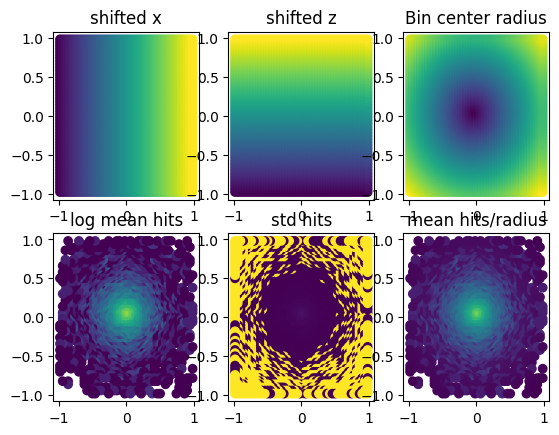

In [7]:
energy_bin = 6
layer = 29

original_x_centers, _, original_z_centers = radialView.accumulator._get_bin_centers()
orig_xx = np.array([x for x in original_x_centers for _ in original_z_centers])
orig_zz = np.array([z for _ in original_x_centers for z in original_z_centers])
rad_xx = np.array([x for x in radialView.x_bin_centers for _ in radialView.z_bin_centers])
rad_zz = np.array([z for _ in radialView.x_bin_centers for z in radialView.z_bin_centers])
fig, axarr = plt.subplots(2, 3)
axarr[0][0].scatter(orig_xx, orig_zz, c=rad_xx)
axarr[0][0].set_title("shifted x")
axarr[0][1].scatter(orig_xx, orig_zz, c=rad_zz)
axarr[0][1].set_title("shifted z")
unsorted_r_bin_centers = np.sqrt(radialView.x_bin_centers[:, np.newaxis]**2 + radialView.z_bin_centers[np.newaxis, :]**2).flatten()
axarr[0][2].scatter(orig_xx, orig_zz, c=unsorted_r_bin_centers)
axarr[0][2].set_title("Bin center radius")

order = np.argsort(unsorted_r_bin_centers)
axarr[1][0].scatter(orig_xx[order], orig_zz[order], c=np.log(radialView.mean_hits[energy_bin, layer]))
axarr[1][0].set_title("log mean hits")
axarr[1][1].scatter(orig_xx[order], orig_zz[order], c=radialView.std_hits[energy_bin, layer])
axarr[1][1].set_title("std hits")
axarr[1][2].scatter(orig_xx[order], orig_zz[order], c=np.log(radialView.mean_hits[energy_bin, layer]/radialView.r_bin_centers))
axarr[1][2].set_title("mean hits/radius")

[0.98140009 0.00104373 0.05235495]
[[7.12065632e-08 4.76330013e-09 1.14558713e-07]
 [4.76330013e-09 8.55775735e-10 7.23909603e-09]
 [1.14558713e-07 7.23909603e-09 2.60863643e-07]]
Optimisation trial 1/10 complete
Initial parameters: 1, 0, 0.00104373, 0.0523549
Optimal parameters: 1, 0.964334, 0.00142178, 0.0514996
Score: 0.571955

Optimisation trial 2/10 complete
Initial parameters: 0.419122, 0.37454, 0.000268859, 0.0209287
Optimal parameters: 0.141716, 0.761118, 0.00469055, 0.0495271
Score: 0.572452

Optimisation trial 3/10 complete
Initial parameters: 0.47483, 0.950714, 0.00030963, 0.101958
Optimal parameters: 0.45194, 0.923138, 0.00223432, 0.051397
Score: 0.571502

Optimisation trial 4/10 complete
Initial parameters: 0.42862, 0.731994, 0, 0.067592
Optimal parameters: 0.360706, 0.903654, 0.00254083, 0.0510313
Score: 0.571542

Optimisation trial 5/10 complete
Initial parameters: 0.0759172, 0.598658, 0.000386729, 0.0190803
Optimal parameters: 0.0482172, 0.59932, 0.0289564, 0.0344314
Sc

(3.2947314398055887e-07, 26.6251102544524)

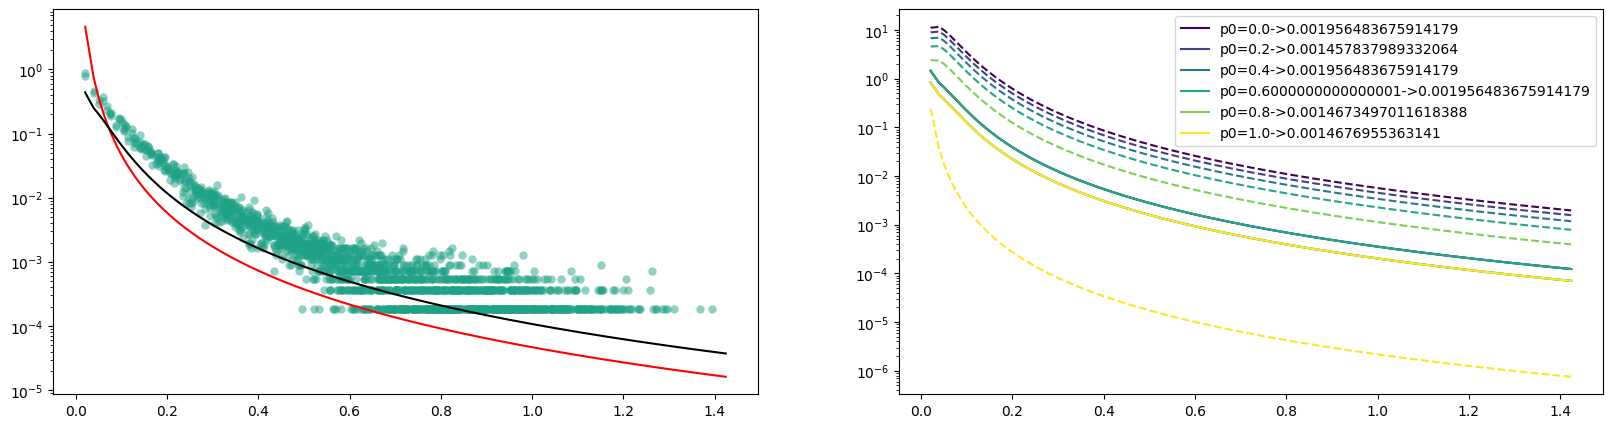

In [8]:
from pointcloud.models.custom_torch_distributions import GFlashRadial as Radial
np.random.seed(42)
cmap = plt.get_cmap()
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 5))

for ax in ax_arr:
    ax.semilogy()
layer_n = 29

#for i, energy in enumerate(radialView.incident_energy_bin_centers):
i=9
energy=radialView.incident_energy_bin_centers[i]
if True:
    ax_arr[0].scatter(radialView.r_bin_centers, radialView.mean_hits[i, layer_n], color=cmap(energy/100, alpha=0.5), lw=0)

def to_fit(x, p, Rc, Rt):
    Rc = torch.tensor(Rc)
    Rt = torch.tensor(Rt)
    p = torch.tensor(p)
    function = Radial(Rc, Rt, p)
    x = torch.Tensor(x)
    found = function.prob(x)
    return found.detach().numpy()

p0 = [0.1, 0.0001, 0.005]
bounds = [[0., 0., 0.], [1., np.inf, np.inf]]
popt, pcov = radialView.fit_to_hits(energy, layer_n, to_fit, n_attempts=50, p0=p0, bounds=bounds, ignore_norm=True, quiet=True)

print(popt)
print(pcov)

probs = to_fit(radialView.r_bin_centers, *p0)
ax_arr[0].plot(radialView.r_bin_centers, probs, color='red')
probs = to_fit(radialView.r_bin_centers, *popt)
ax_arr[0].plot(radialView.r_bin_centers, probs, color='k')

cmap = plt.get_cmap('viridis')
for p in np.linspace(0, 1, 6):
    p0_alt = [p, popt[1], popt[2]]
    probs = to_fit(radialView.r_bin_centers, *p0_alt)
    ax_arr[1].plot(radialView.r_bin_centers, probs, color=cmap(p), ls='--') 
    popt_alt, _ = radialView.fit_to_hits(energy, layer_n, to_fit, p0=p0_alt, bounds=bounds, ignore_norm=True)
    probs = to_fit(radialView.r_bin_centers, *popt_alt)
    ax_arr[1].plot(radialView.r_bin_centers, probs, color=cmap(p), label=f"p0={p}->{popt_alt[1]}")
ax_arr[1].legend()
ax_arr[1].semilogy()
ax_arr[1].set_ylim(*ax.get_ylim())

Just retry
[1.00000000e-01 3.03611742e-07 2.82918207e-03]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.89784841e-10 6.89784841e-10]
 [0.00000000e+00 6.89784841e-10 6.89784841e-10]]
Wiggled
[0.96520037 0.0014582  0.05213476]
[[3.13241154e-07 1.64948239e-08 2.36436954e-07]
 [1.64948239e-08 1.90086449e-09 1.17325823e-08]
 [2.36436954e-07 1.17325823e-08 2.36496555e-07]]


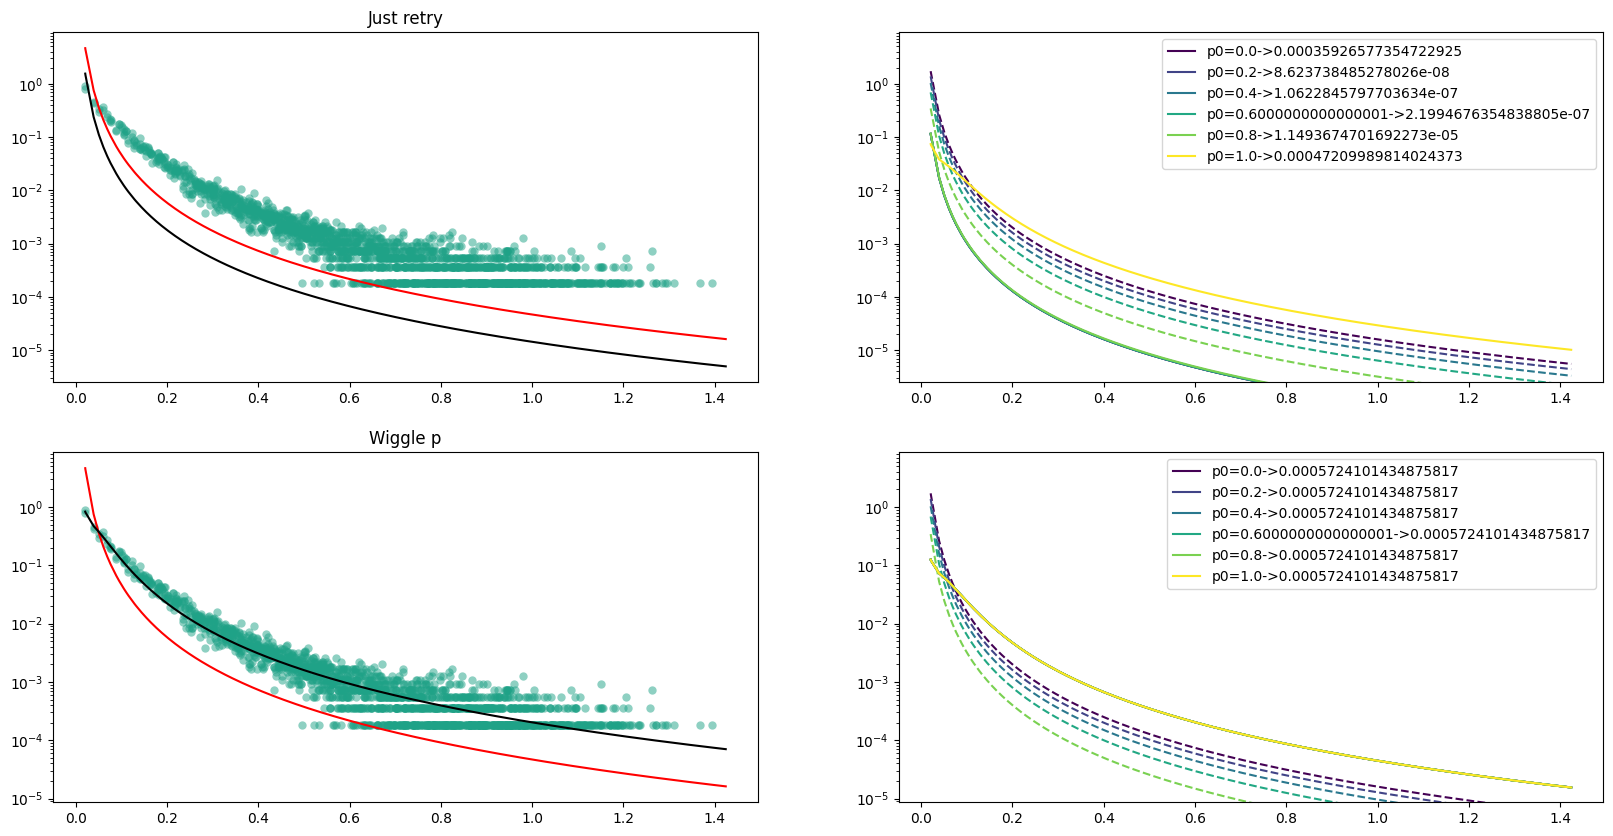

In [9]:
from pointcloud.models.custom_torch_distributions import GFlashRadial as Radial
cmap = plt.get_cmap()
fig, ax_arr = plt.subplots(2, 2, figsize=(20, 10))

for ax in ax_arr.flatten():
    ax.semilogy()

layer_n = 29

#for i, energy in enumerate(radialView.incident_energy_bin_centers):
if True:
    ax_arr[0, 0].scatter(radialView.r_bin_centers, radialView.mean_hits[i, layer_n], color=cmap(energy/100, alpha=0.5), lw=0)
    ax_arr[1, 0].scatter(radialView.r_bin_centers, radialView.mean_hits[i, layer_n], color=cmap(energy/100, alpha=0.5), lw=0)


def to_fit(x, p, Rc, Rt):
    Rc = torch.tensor(Rc)
    Rt = torch.tensor(Rt)
    p = torch.tensor(p)
    function = Radial(Rc, Rt, p)
    x = torch.Tensor(x)
    found = function.prob(x)
    return found.detach().numpy()

p0 = [0.1, 0.0001, 0.005]
bounds = [[0., 0., 0.], [1., np.inf, np.inf]]

from scipy.optimize import curve_fit
tries = 10
def wiggle_fit_to_hits(p0, bounds):
    target_x = radialView.r_bin_centers
    target_y = radialView.mean_hits[i, layer_n]
    target_error = radialView.std_hits[i, layer_n]

    popt = p0
    for _ in range(tries):
        popt[0] = min(0.999, popt[0] + 1)
        popt, pcov = curve_fit(to_fit, target_x, target_y, p0=popt, bounds=bounds, sigma=target_error)
    return popt, pcov
    
def fit_to_hits(p0, bounds):
    target_x = radialView.r_bin_centers
    target_y = radialView.mean_hits[i, layer_n]
    target_error = radialView.std_hits[i, layer_n]

    popt = p0
    for _ in range(tries):
        # popt[0] = min(0.999, popt[0] + 1)
        popt, pcov = curve_fit(to_fit, target_x, target_y, p0=popt, bounds=bounds, sigma=target_error)
    return popt, pcov
    
wpopt, wpcov = wiggle_fit_to_hits(p0, bounds)
p0 = [0.1, 0.0001, 0.005]
popt, pcov = fit_to_hits(p0, bounds)

print("Just retry")
print(popt)
print(pcov)

print("Wiggled")
print(wpopt)
print(wpcov)

probs = to_fit(radialView.r_bin_centers, *p0)
ax_arr[0, 0].plot(radialView.r_bin_centers, probs, color='red')
probs = to_fit(radialView.r_bin_centers, *popt)
ax_arr[0, 0].plot(radialView.r_bin_centers, probs, color='k')
ax_arr[0, 0].set_title("Just retry")


probs = to_fit(radialView.r_bin_centers, *p0)
ax_arr[1, 0].plot(radialView.r_bin_centers, probs, color='red')
probs = to_fit(radialView.r_bin_centers, *wpopt)
ax_arr[1, 0].plot(radialView.r_bin_centers, probs, color='k')
ax_arr[1, 0].set_title("Wiggle p")

cmap = plt.get_cmap('viridis')
for i, func in enumerate([fit_to_hits, wiggle_fit_to_hits]):
    test_ax = ax_arr[i, 1]
    for p in np.linspace(0, 1, 6):
        p0_alt = [p, popt[1], popt[2]]
        probs = to_fit(radialView.r_bin_centers, *p0_alt)
        test_ax.plot(radialView.r_bin_centers, probs, color=cmap(p), ls='--') 
        popt_alt, _ = func(p0_alt, bounds)
        probs = to_fit(radialView.r_bin_centers, *popt_alt)
        test_ax.plot(radialView.r_bin_centers, probs, color=cmap(p), label=f"p0={p}->{popt_alt[1]}")
    test_ax.legend()
    test_ax.set_ylim(*ax_arr[i, 0].get_ylim())

[0.98140009 0.00104373 0.05235495]
[[7.12065632e-08 4.76330013e-09 1.14558713e-07]
 [4.76330013e-09 8.55775735e-10 7.23909603e-09]
 [1.14558713e-07 7.23909603e-09 2.60863643e-07]]
Optimisation trial 1/10 complete
Initial parameters: 1, 0, 0.00104373, 0.0523549
Optimal parameters: 1, 0.964334, 0.00142178, 0.0514996
Score: 0.571955

Optimisation trial 2/10 complete
Initial parameters: 0.419122, 0.37454, 0.000268859, 0.0209287
Optimal parameters: 0.141716, 0.761118, 0.00469055, 0.0495271
Score: 0.572452

Optimisation trial 3/10 complete
Initial parameters: 0.47483, 0.950714, 0.00030963, 0.101958
Optimal parameters: 0.45194, 0.923138, 0.00223432, 0.051397
Score: 0.571502

Optimisation trial 4/10 complete
Initial parameters: 0.42862, 0.731994, 0, 0.067592
Optimal parameters: 0.360706, 0.903654, 0.00254083, 0.0510313
Score: 0.571542

Optimisation trial 5/10 complete
Initial parameters: 0.0759172, 0.598658, 0.000386729, 0.0190803
Optimal parameters: 0.0482172, 0.59932, 0.0289564, 0.0344314
Sc

(3.2947314398055887e-07, 26.6251102544524)

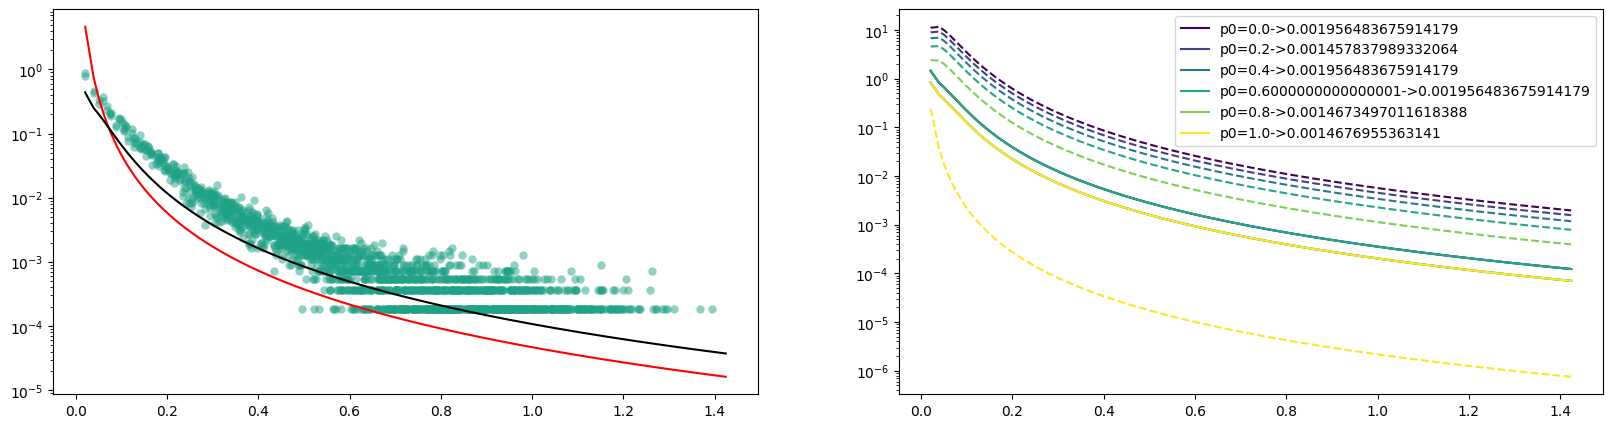

In [10]:
from pointcloud.models.custom_torch_distributions import GFlashRadial as Radial
np.random.seed(42)
cmap = plt.get_cmap()
fig, ax_arr = plt.subplots(1, 2, figsize=(20, 5))

for ax in ax_arr:
    ax.semilogy()
layer_n = 29

#for i, energy in enumerate(radialView.incident_energy_bin_centers):
i=9
energy=radialView.incident_energy_bin_centers[i]
if True:
    ax_arr[0].scatter(radialView.r_bin_centers, radialView.mean_hits[i, layer_n], color=cmap(energy/100, alpha=0.5), lw=0)

def to_fit(x, p, Rc, Rt):
    Rc = torch.tensor(Rc)
    Rt = torch.tensor(Rt)
    p = torch.tensor(p)
    function = Radial(Rc, Rt, p)
    x = torch.Tensor(x)
    found = function.prob(x)
    return found.detach().numpy()

p0 = [0.1, 0.0001, 0.005]
bounds = [[0., 0., 0.], [1., np.inf, np.inf]]
popt, pcov = radialView.fit_to_hits(energy, layer_n, to_fit, n_attempts=50, p0=p0, bounds=bounds, ignore_norm=True, quiet=True)

print(popt)
print(pcov)

probs = to_fit(radialView.r_bin_centers, *p0)
ax_arr[0].plot(radialView.r_bin_centers, probs, color='red')
probs = to_fit(radialView.r_bin_centers, *popt)
ax_arr[0].plot(radialView.r_bin_centers, probs, color='k')

cmap = plt.get_cmap('viridis')
for p in np.linspace(0, 1, 6):
    p0_alt = [p, popt[1], popt[2]]
    probs = to_fit(radialView.r_bin_centers, *p0_alt)
    ax_arr[1].plot(radialView.r_bin_centers, probs, color=cmap(p), ls='--') 
    popt_alt, _ = radialView.fit_to_hits(energy, layer_n, to_fit, p0=p0_alt, bounds=bounds, ignore_norm=True)
    probs = to_fit(radialView.r_bin_centers, *popt_alt)
    ax_arr[1].plot(radialView.r_bin_centers, probs, color=cmap(p), label=f"p0={p}->{popt_alt[1]}")
ax_arr[1].legend()
ax_arr[1].semilogy()
ax_arr[1].set_ylim(*ax.get_ylim())

0


/tmp/ipykernel_244395/1990689244.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Rc = torch.tensor(Rc)
/tmp/ipykernel_244395/1990689244.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Rt = torch.tensor(Rt)
/tmp/ipykernel_244395/1990689244.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  p = torch.tensor(p)


1
2
3
4


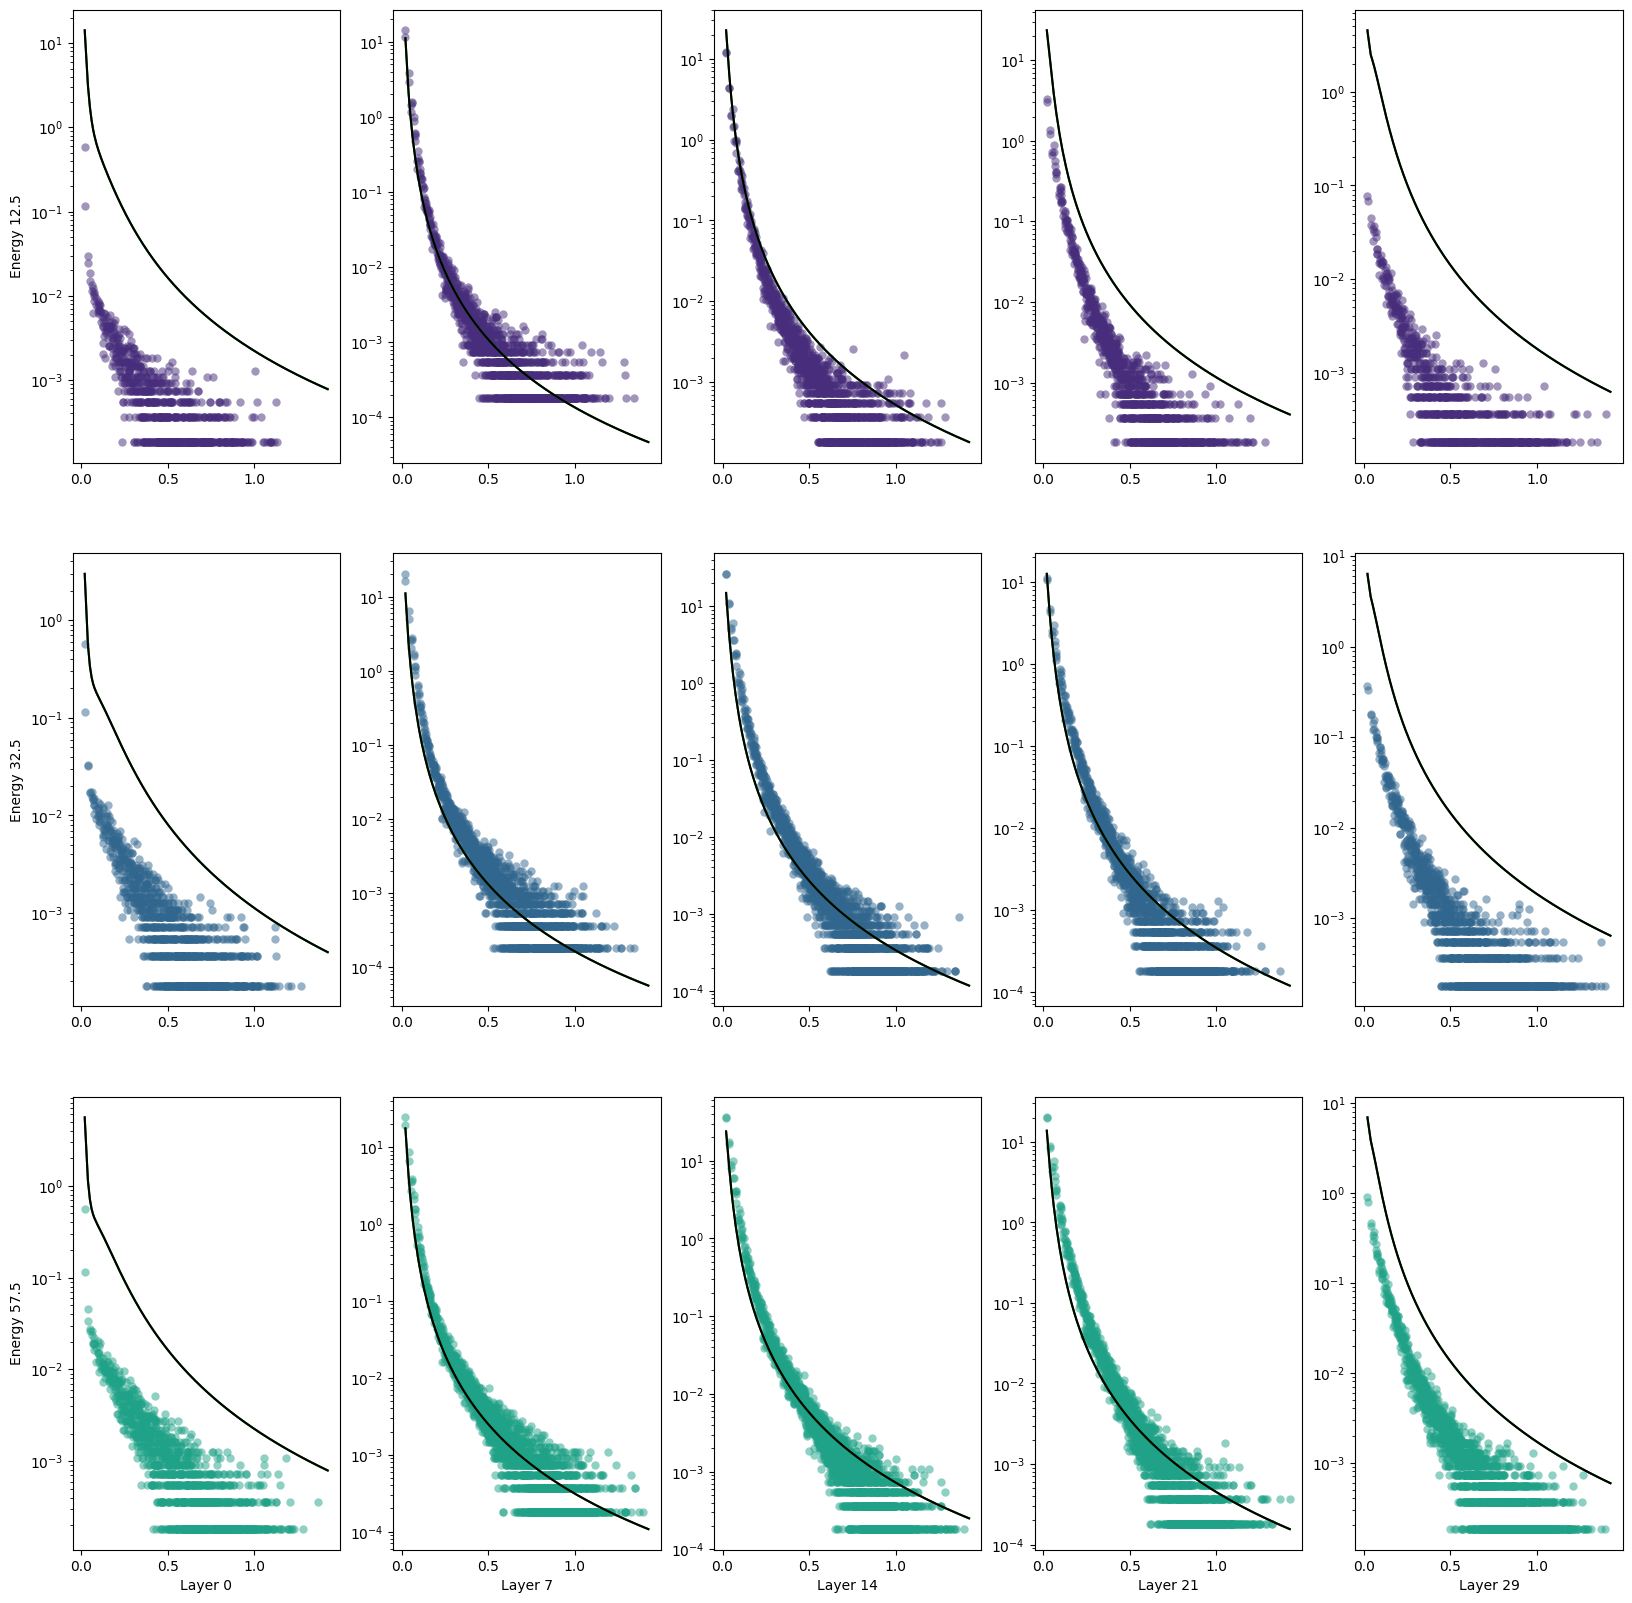

In [11]:
np.random.seed(42)
cmap = plt.get_cmap()
energies_of_intrest = [0, 4, 9]
fig, ax_arr = plt.subplots(len(energies_of_intrest), len(layers_of_intrest), figsize=(20, 20))

for ax in ax_arr.flatten():
    ax.semilogy()

for l_n, layer_n in enumerate(layers_of_intrest):
    print(l_n)
    ax_arr[-1, l_n].set_xlabel(f"Layer {layer_n}")
    for e_n, energy_n in enumerate(energies_of_intrest):
        ax = ax_arr[e_n, l_n]
        layer = wish_model.layers[layer_n]

        energy = radialView.incident_energy_bin_centers[energy_n]
        if l_n == 0:
            ax.set_ylabel(f"Energy {energy:.1f}")
        ax.scatter(radialView.r_bin_centers, radialView.mean_hits[energy_n, layer_n], color=cmap(energy/100, alpha=0.5), lw=0)
        
        def to_fit(x, p, Rc, Rt):
            Rc = torch.tensor(Rc)
            Rt = torch.tensor(Rt)
            p = torch.tensor(p)
            function = Radial(Rc, Rt, p)
            x = torch.Tensor(x)
            found = function.prob(x)
            return found.detach().numpy()
        Rc, Rt, p = layer.displacement_fit.get_distribution_args(energy)
        probs = to_fit(radialView.r_bin_centers, p, Rc, Rt)
        ax.plot(radialView.r_bin_centers, probs, color='g')
        
        probs_v2 = [layer.displacement_fit.calculate_probability(energy, torch.Tensor([r])) for r in radialView.r_bin_centers]
        probs_v2 = [float(p.detach().numpy()) for p in probs_v2]
        
        ax.plot(radialView.r_bin_centers, probs_v2, color='k')
    
#cmap = plt.get_cmap('viridis')
#for p in np.linspace(0, 1, 6):
#    p0_alt = [p, popt[1], popt[2]]
#    probs = to_fit(radialView.r_bin_centers, *p0_alt)
#    ax_arr[1].plot(radialView.r_bin_centers, probs, color=cmap(p), ls='--') 
#    popt_alt, _ = radialView.fit_to_hits(energy, layer_n, to_fit, p0=p0_alt, bounds=bounds, ignore_norm=True)
#    probs = to_fit(radialView.r_bin_centers, *popt_alt)
#    ax_arr[1].plot(radialView.r_bin_centers, probs, color=cmap(p), label=f"p0={p}->{popt_alt[1]}")
#ax_arr[1].legend()
#ax_arr[1].semilogy()
#ax_arr[1].set_ylim(*ax.get_ylim())

In [12]:
# get the wish data
non_zero_total_events = np.clip(wish_accumulator.total_events, 1, None)[1: -1, np.newaxis, np.newaxis, np.newaxis]

wish_lateral_hits_per_event = wish_accumulator.counts_hist[1:-1]/non_zero_total_events
wish_lateral_sumE_per_event = wish_accumulator.energy_hist[1: -1]/non_zero_total_events

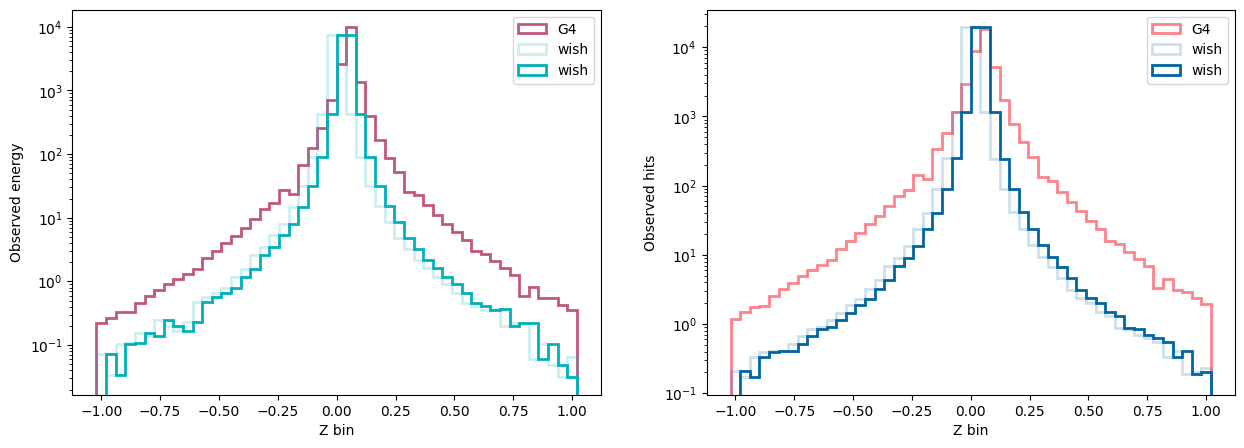

In [23]:
fig, (ax_e, ax_hit) = plt.subplots(1, 2, figsize=(15, 5))

#energy
ax_e.semilogy()

z_spacing = z_values[1] - z_values[0]
z_bins = np.linspace(-1-0.5*z_spacing, 1+0.5*z_spacing, n_z_bins+1)
global_hist_params = dict(bins=z_bins, histtype="step", lw=2, density=False)

g4_summed_E = np.sum(g4_lateral_sumE_per_event, axis=(0,1,2))
wish_summed_E = np.sum(wish_lateral_sumE_per_event, axis=(0,1,2))
g4_hist_params1 = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
ax_e.hist(z_values, weights=g4_summed_E, **g4_hist_params1)
wish_hist_params1 = dict(label="wish", color=nice_hex[2][3], **global_hist_params)
ax_e.hist(z_values, weights=wish_summed_E, alpha=0.2, **wish_hist_params1)
ax_e.hist(z_values+z_shift, weights=wish_summed_E, **wish_hist_params1)

ax_e.set_xlabel("Z bin")
ax_e.set_ylabel("Observed energy")
ax_e.legend()

#hits
ax_hit.semilogy()

g4_summed_hits = np.sum(g4_lateral_hits_per_event, axis=(0,1,2))
wish_summed_hits = np.sum(wish_lateral_hits_per_event, axis=(0,1,2))
g4_hist_params1 = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
ax_hit.hist(z_values, weights=g4_summed_hits, **g4_hist_params1)
wish_hist_params1 = dict(label="wish", color=nice_hex[2][4], **global_hist_params)
ax_hit.hist(z_values, weights=wish_summed_hits, alpha=0.2, **wish_hist_params1)
ax_hit.hist(z_values+z_shift, weights=wish_summed_hits, **wish_hist_params1)

ax_hit.set_xlabel("Z bin")
ax_hit.set_ylabel("Observed hits")
ax_hit.legend()

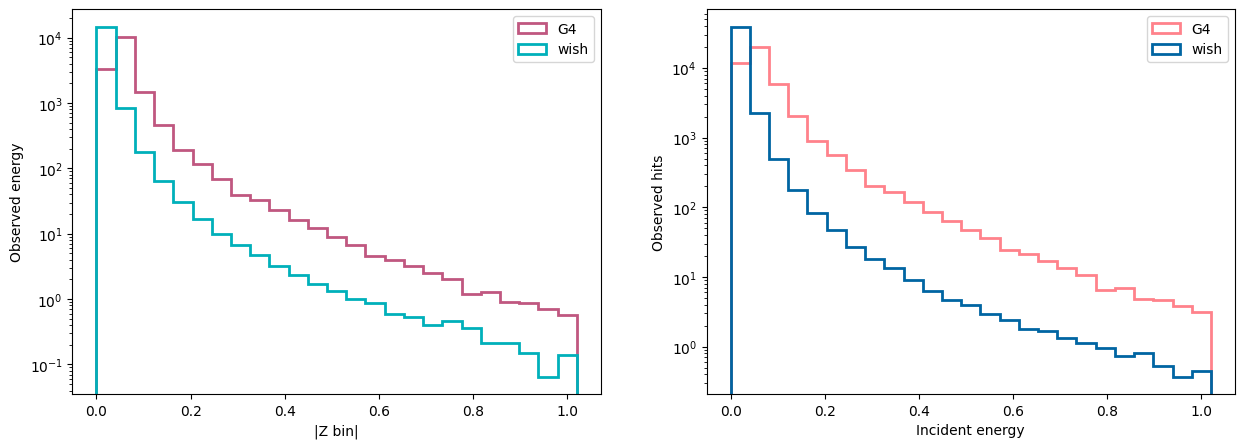

In [24]:
fig, (ax_e, ax_hit) = plt.subplots(1, 2, figsize=(15, 5))


#energy
ax_e.semilogy()
positive_z_mask = z_values>0
negative_z_mask = np.where(z_values<0)[0][::-1]
positive_z = z_values[positive_z_mask]

positive_z_bins = np.linspace(positive_z[0]-0.5*z_spacing, positive_z[-1]+0.5*z_spacing,
                              len(positive_z) + 1)
global_hist_params["bins"] = positive_z_bins

g4_hist_params1 = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
ax_e.hist(positive_z, weights=g4_summed_E[positive_z_mask] + g4_summed_E[negative_z_mask],
          **g4_hist_params1)
wish_hist_params1 = dict(label="wish", color=nice_hex[2][3], **global_hist_params)
ax_e.hist(positive_z, weights=wish_summed_E[positive_z_mask]+wish_summed_E[negative_z_mask],
          **wish_hist_params1)

ax_e.set_xlabel("|Z bin|")
ax_e.set_ylabel("Observed energy")
ax_e.legend()

#hits
ax_hit.semilogy()

g4_hist_params1 = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
ax_hit.hist(positive_z, weights=g4_summed_hits[positive_z_mask] + g4_summed_hits[negative_z_mask],
            **g4_hist_params1)
wish_hist_params1 = dict(label="wish", color=nice_hex[2][4], **global_hist_params)
ax_hit.hist(positive_z, weights=wish_summed_hits[positive_z_mask] + wish_summed_hits[negative_z_mask],
            **wish_hist_params1)

ax_hit.set_xlabel("Incident energy")
ax_hit.set_ylabel("Observed hits")
ax_hit.legend()

Note that what is being compared here is wish to the accumulated stats. It would show issues in the converstion from stats to model.

Also, look at then energies in some layers;

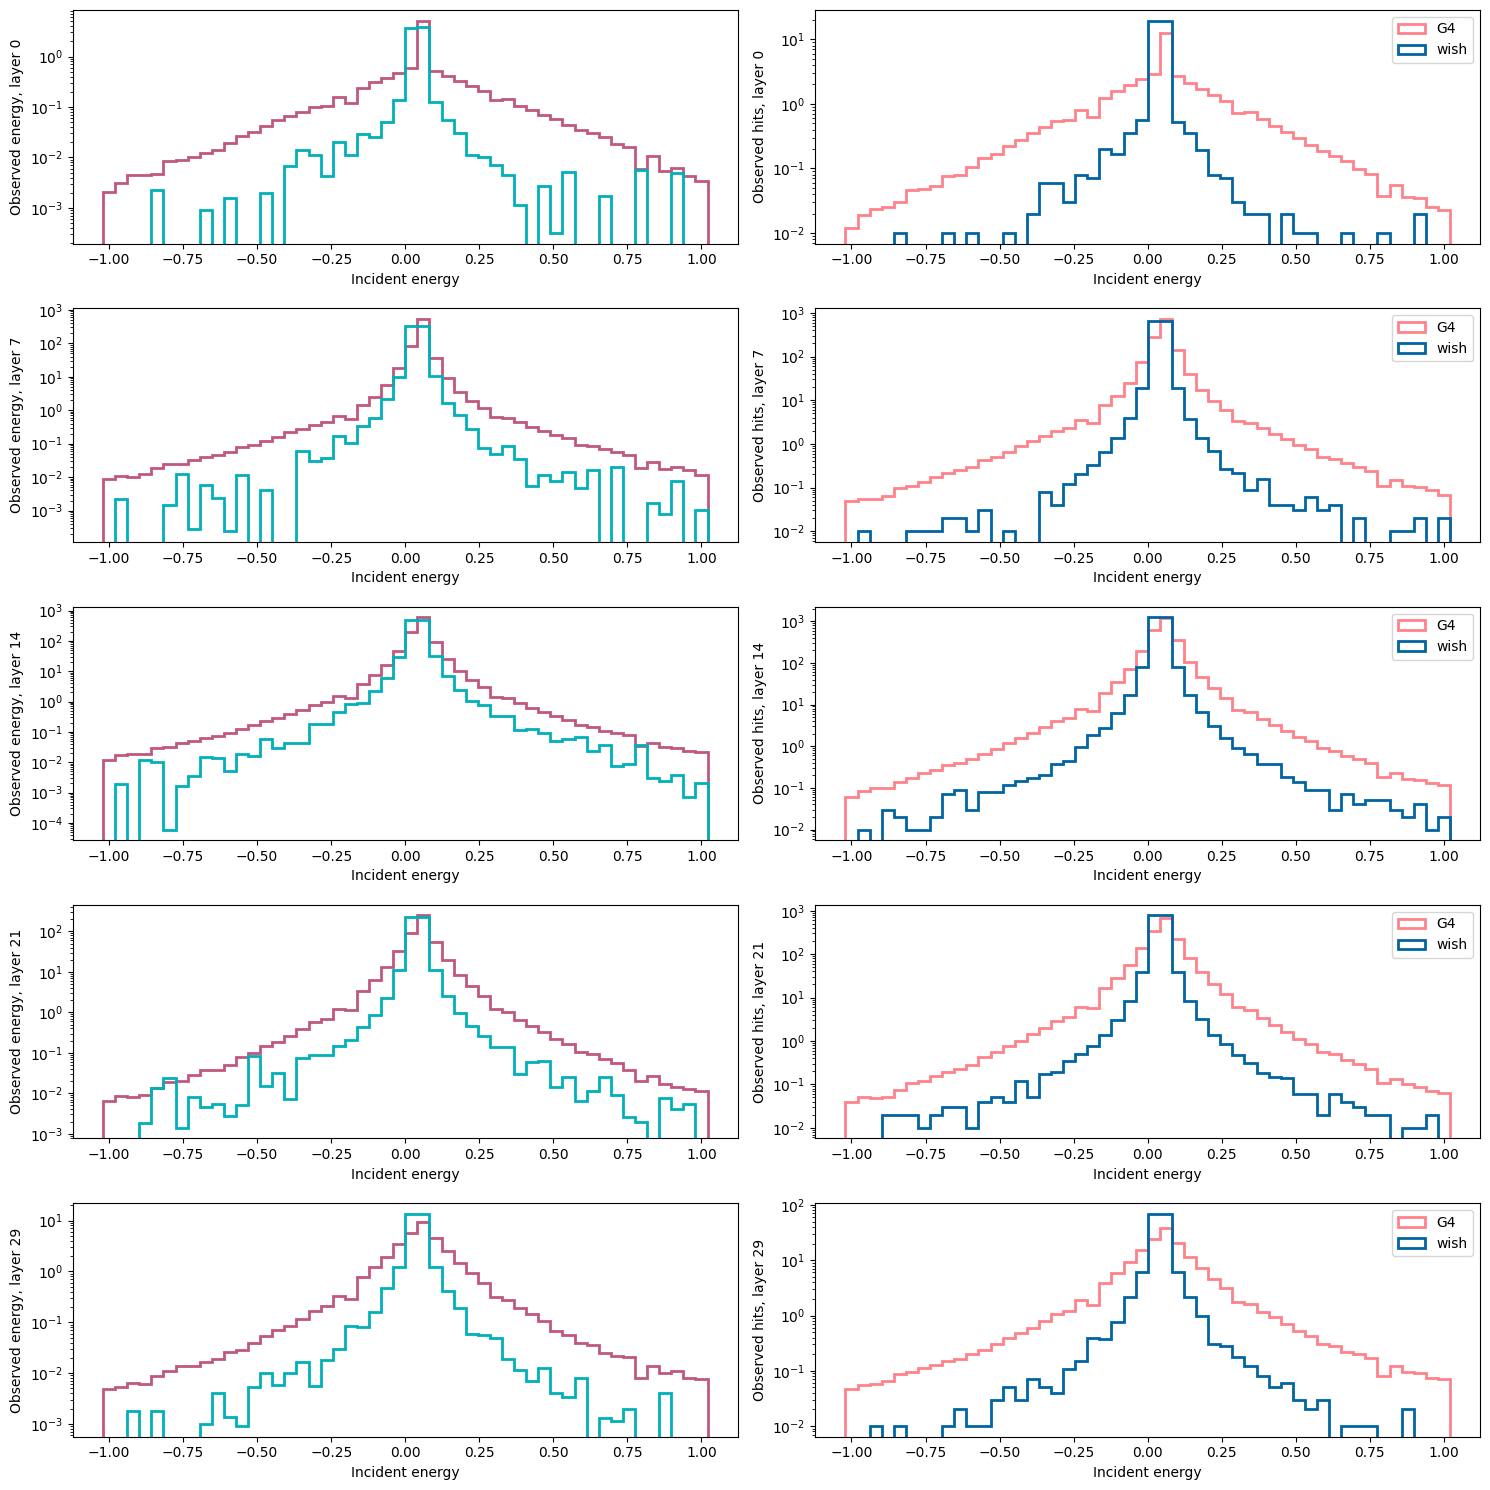

In [25]:

fig, axes = plt.subplots(n_intrest, 2, figsize=(15, 3*n_intrest))
global_hist_params["bins"] = z_bins
for ax_n, layer_n in enumerate(layers_of_intrest):
    #energy
    ax_e = axes[ax_n, 0]
    ax_e.semilogy()
    g4_summed_E_layer = np.sum(g4_lateral_sumE_per_event, axis=(0,2))[layer_n]
    wish_summed_E_layer = np.sum(wish_lateral_sumE_per_event, axis=(0,2))[layer_n]
    g4_hist_params1 = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
    ax_e.hist(z_values, weights=g4_summed_E_layer, **g4_hist_params1)
    wish_hist_params1 = dict(label="wish", color=nice_hex[2][3], **global_hist_params)
    ax_e.hist(z_values+z_shift, weights=wish_summed_E_layer, **wish_hist_params1)
    
    ax_e.set_xlabel("Incident energy")
    ax_e.set_ylabel(f"Observed energy, layer {layer_n}")
    
    #hits
    ax_hit = axes[ax_n, 1]
    ax_hit.semilogy()

    g4_summed_hits_layer = np.sum(g4_lateral_hits_per_event, axis=(0,2))[layer_n]
    wish_summed_hits_layer = np.sum(wish_lateral_hits_per_event, axis=(0,2))[layer_n]
    g4_hist_params2 = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
    ax_hit.hist(z_values, weights=g4_summed_hits_layer, **g4_hist_params2)
    wish_hist_params2 = dict(label="wish", color=nice_hex[2][4], **global_hist_params)
    ax_hit.hist(z_values+z_shift, weights=wish_summed_hits_layer, **wish_hist_params2)

    ax_hit.set_xlabel("Incident energy")
    ax_hit.set_ylabel(f"Observed hits, layer {layer_n}")
    ax_hit.legend()
fig.tight_layout()

### Evaluation of Histograms


This simply isn't a gaussian....

## Fixed energy slices

Now we will select some of the energy slices of the histograms and view them seperatly

In [16]:
n_energy_slices = 5
energy_indices = np.linspace(1, g4_lateral_hits_per_event.shape[0]-1, n_energy_slices, dtype=int)


Now we need to generate the slices from wish. This is simpler.

### 


### Cauchy

This distribution is almost the right shape, but has no moments on the infinite interval.
In a confined interval (-1 to 1 for example) there a moments.

Take cauchy pdf as

$$
f(x) = \frac{1}{\pi\theta}\left(1 + \left[\frac{x - \mu}{\theta}\right]^2\right)^{-1}
$$

the paper at https://projecteuclid.org/download/pdfview_1/euclid.bjps/1291387776 gives the varience in the interval $A$ to $B$

$$
f(x) = \frac{1}{D\theta}\left(1 + \left[\frac{x - \mu}{\theta}\right]^2\right)^{-1}
$$
where
$$
D = \mathrm{arctan}\left(\frac{B - \mu}{\theta}\right) - \mathrm{arctan}\left(\frac{A - \mu}{\theta}\right)
$$
$$
\sigma^2 = \frac{1}{D}\left(\mathrm{arctan}(A) - \mathrm{arctan}(B) - A + B\right)
$$

For our interval, $A=-1$ and $B=1$ with $\mu = 0$ this simplifies to
$$
D = 2\mathrm{arctan}\left(\theta^{-1}\right)
$$
$$
\sigma^2 = \frac{1}{D}\left(-\pi/2 + 2\right)
$$
$$
\sigma^2 = \frac{1}{\mathrm{arctan}(\theta^{-1})
}\left(1 -\pi/4\right)
$$




So inverting for $\theta$ and $D$

$$
\theta = \mathrm{tan}\left(\sigma^{-2}(1-\pi/4)\right)^{-1}
$$
$$
D = 2\sigma^{-2}(1-\pi/4)
$$

and the pdf is 

$$
f(x) = \frac{\sigma^2\mathrm{tan}\left(\sigma^{-2}(1-\pi/4)\right)}{2-\pi/2}\left[1+x^2\mathrm{tan}\left(\sigma^{-2}(1-\pi/4)\right)^2\right]^{-1}
$$

In [17]:

from scipy.stats import laplace, cauchy

def weighted_avg_and_std(values, weights):
    weights /= np.sum(weights)
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

def laplace_doodle(energy_index, layer_n, z_values, std=None):
    if std is None:
        layer = wish_model.layers[layer_n]
        covarience_matrix = layer.displacement_fit.covarience_matrix_fit.fit(points[energy_index]).detach().numpy()
        covarience = 0.5*(covarience_matrix[0,0] + covarience_matrix[1,1])
        std = covarience*6
    inv_b = 1/(np.sqrt(0.5)*std)
    pdf = inv_b*laplace.pdf(z_values*inv_b)
    return pdf
    

def cauchy_doodle(energy_index, layer_n, z_values, std=None):
    if std is None:
        layer = wish_model.layers[layer_n]
        covarience_matrix = layer.displacement_fit.covarience_matrix_fit.fit(points[energy_index]).detach().numpy()
        varience = 0.5*(covarience_matrix[0,0] + covarience_matrix[1,1])
        std = variance**0.5
    else:
        varience = std**2
    tan_factor = np.tan(varience**(-1)*(-np.pi*0.25 + 1))
    norm_factor = varience*tan_factor/(2-np.pi/2)
    # In theory, this is correct, but it isn't working
    pdf = norm_factor*(1 + z_values**2*tan_factor**2)**-1
    #pdf = cauchy.pdf(z_values, scale=(varience*7))
    pdf /= np.sum(pdf)*z_spacing
    return pdf

def gflash_doodle(energy_index, layer_n, z_values, RcRtp=None):
    if RcRtp is None:
        layer = wish_model.layers[layer_n]
        rc = layer.displacement_fit.covarience_matrix_fit.fit(points[energy_index]).detach().numpy()
        varience = 0.5*(covarience_matrix[0,0] + covarience_matrix[1,1])
        std = variance**0.5
    else:
        varience = std**2
    tan_factor = np.tan(varience**(-1)*(-np.pi*0.25 + 1))
    norm_factor = varience*tan_factor/(2-np.pi/2)
    # In theory, this is correct, but it isn't working
    pdf = norm_factor*(1 + z_values**2*tan_factor**2)**-1
    #pdf = cauchy.pdf(z_values, scale=(varience*7))
    pdf /= np.sum(pdf)*z_spacing
    return pdf
#plt.plot(z_values, cauchy_doodle(None, None, z_values, 0.5), label="0.5")
#plt.plot(z_values, cauchy_doodle(None, None, z_values, 1), label="1")
#plt.plot(z_values, cauchy_doodle(None, None, z_values, 2), label="2")
#plt.legend()
#print(weighted_avg_and_std(z_values, cauchy_doodle(None, None, z_values, 0.5)))
#print(weighted_avg_and_std(z_values, cauchy_doodle(None, None, z_values, 1)))
#print(weighted_avg_and_std(z_values, cauchy_doodle(None, None, z_values, 2)))

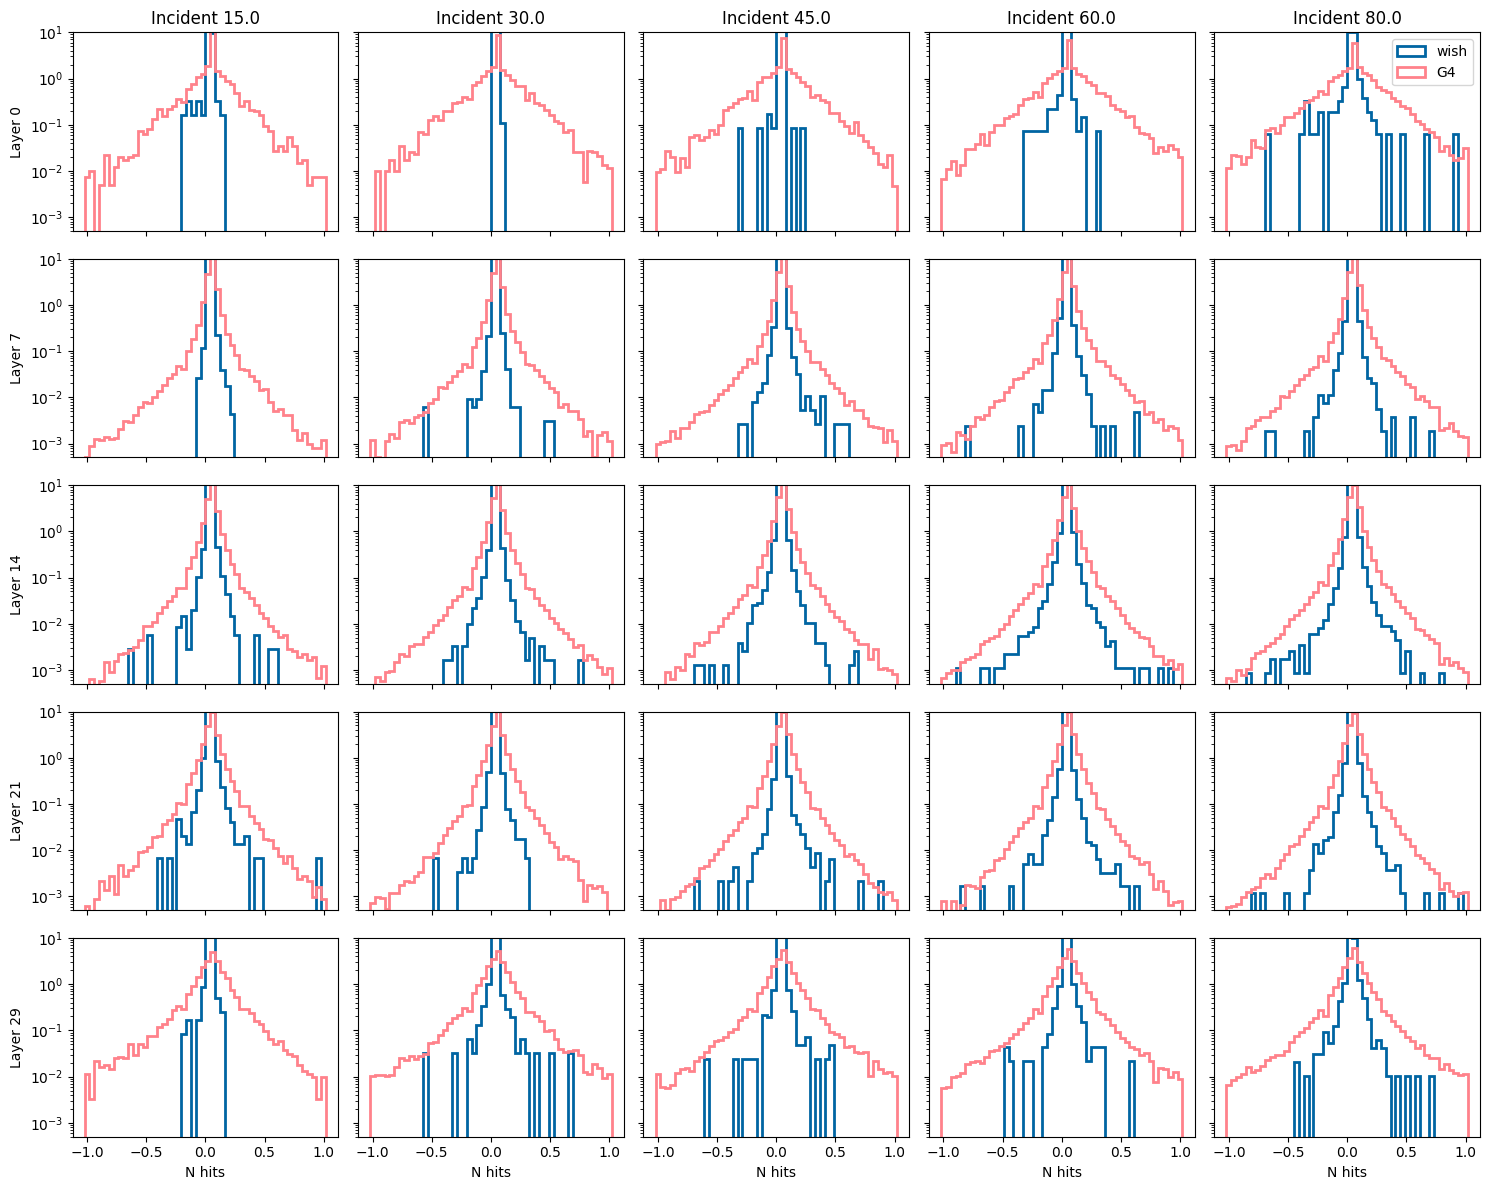

In [26]:
fig_hits, axarr_hits = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))

# which dimensions should be logs?
log_y = True


global_hist_params = dict(bins=z_bins, histtype="step", lw=2, density=True)
g4_hist_params = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
wish_hist_params = dict(label="wish", color=nice_hex[2][4], **global_hist_params)

stats_params = dict(lw=2, c="orange", linestyle='--', label="Laplace Doodle", alpha=0.5)
stats_params2 = dict(lw=2, c="green", label="Cauchy Doodle", alpha=0.8)

for energy_slice_n, energy_index in enumerate(energy_indices):
    for intrest_n, layer_n in enumerate(layers_of_intrest):
        ax = axarr_hits[intrest_n][energy_slice_n]
        if intrest_n == 0:
            ax.set_title(f"Incident {accumulated_stats.incident_bin_boundaries[energy_index]}")
        if intrest_n == len(layers_of_intrest) -1:
            ax.set_xlabel("N hits")
        if energy_slice_n == 0:
            ax.set_ylabel(f"Layer {layer_n}")
        this_wish_hits = np.sum(wish_lateral_hits_per_event[energy_index, layer_n], axis=0)
        ax.hist(z_values+z_shift, weights=this_wish_hits, **wish_hist_params)
        this_g4_hits = np.sum(g4_lateral_hits_per_event[energy_index, layer_n], axis=0)
        ax.hist(z_values, weights=this_g4_hits, **g4_hist_params)
        if log_y:
            ax.semilogy()
            
        # calculate theory from stats and add
        #found_mean, found_std = weighted_avg_and_std(z_values, this_g4_hits)
        #laplace_pdf = laplace_doodle(energy_index, layer_n, z_values, found_std)
        #laplace_pdf /= np.sum(laplace_pdf)*z_spacing
        #ax.plot(z_values, laplace_pdf, **stats_params)
        #cauchy_pdf = cauchy_doodle(energy_index, layer_n, z_values, found_std)
        #cauchy_pdf /= np.sum(cauchy_pdf)*z_spacing
        #ax.plot(z_values, cauchy_pdf, **stats_params2)
        if log_y:
            ax.set_ylim(5e-4, 10.)
        else:
            pass
            #ax.set_ylim(0, 0.01)

axarr_hits[0][-1].legend()
plt.tight_layout()
        

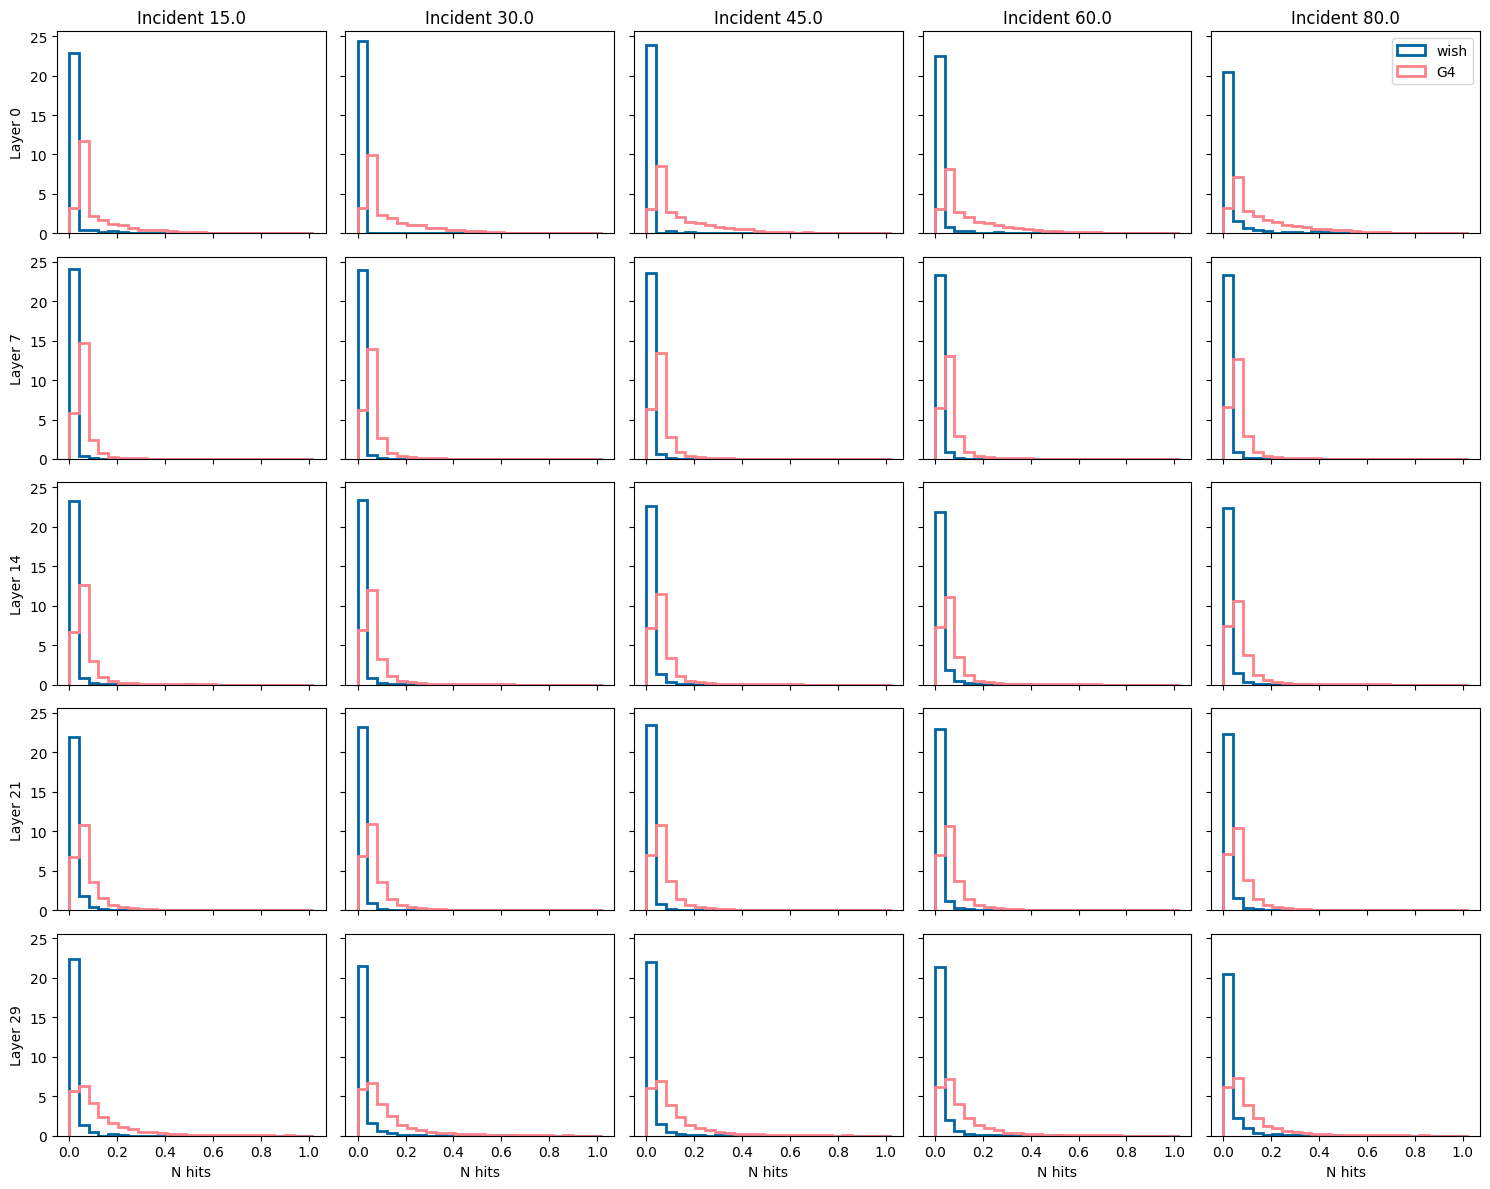

In [19]:
fig_hits, axarr_hits = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))

# which dimensions should be logs?
log_y = False


global_hist_params = dict(bins=positive_z_bins, histtype="step", lw=2, density=True)
g4_hist_params = dict(label="G4", color=nice_hex[2][1], **global_hist_params)
wish_hist_params = dict(label="wish", color=nice_hex[2][4], **global_hist_params)

from scipy.stats import lognorm
stats_params = dict(lw=2, c="black", label="High level stats", alpha=0.5)
stats_params2 = dict(lw=2, c="green", label="Raw stats", alpha=0.8)

for energy_slice_n, energy_index in enumerate(energy_indices):
    for intrest_n, layer_n in enumerate(layers_of_intrest):
        ax = axarr_hits[intrest_n][energy_slice_n]
        if intrest_n == 0:
            ax.set_title(f"Incident {accumulated_stats.incident_bin_boundaries[energy_index]}")
        if intrest_n == len(layers_of_intrest) -1:
            ax.set_xlabel("N hits")
        if energy_slice_n == 0:
            
            ax.set_ylabel(f"Layer {layer_n}")
        this_wish_hits = np.sum(wish_lateral_hits_per_event[energy_index, layer_n], axis=0)
        ax.hist(positive_z, weights=this_wish_hits[positive_z_mask] + this_wish_hits[negative_z_mask],
                **wish_hist_params)
        this_g4_hits = np.sum(g4_lateral_hits_per_event[energy_index, layer_n], axis=0)
        ax.hist(positive_z, weights=this_g4_hits[positive_z_mask] + this_g4_hits[negative_z_mask],
                **g4_hist_params)
        if log_y:
            ax.semilogy()
            
        # calculate theory from stats and add
        if log_y:
            pass
            #ax.set_ylim(8e-5, 0.16)
        else:
            pass
            #ax.set_ylim(0, 0.01)

axarr_hits[0][-1].legend()
plt.tight_layout()
        

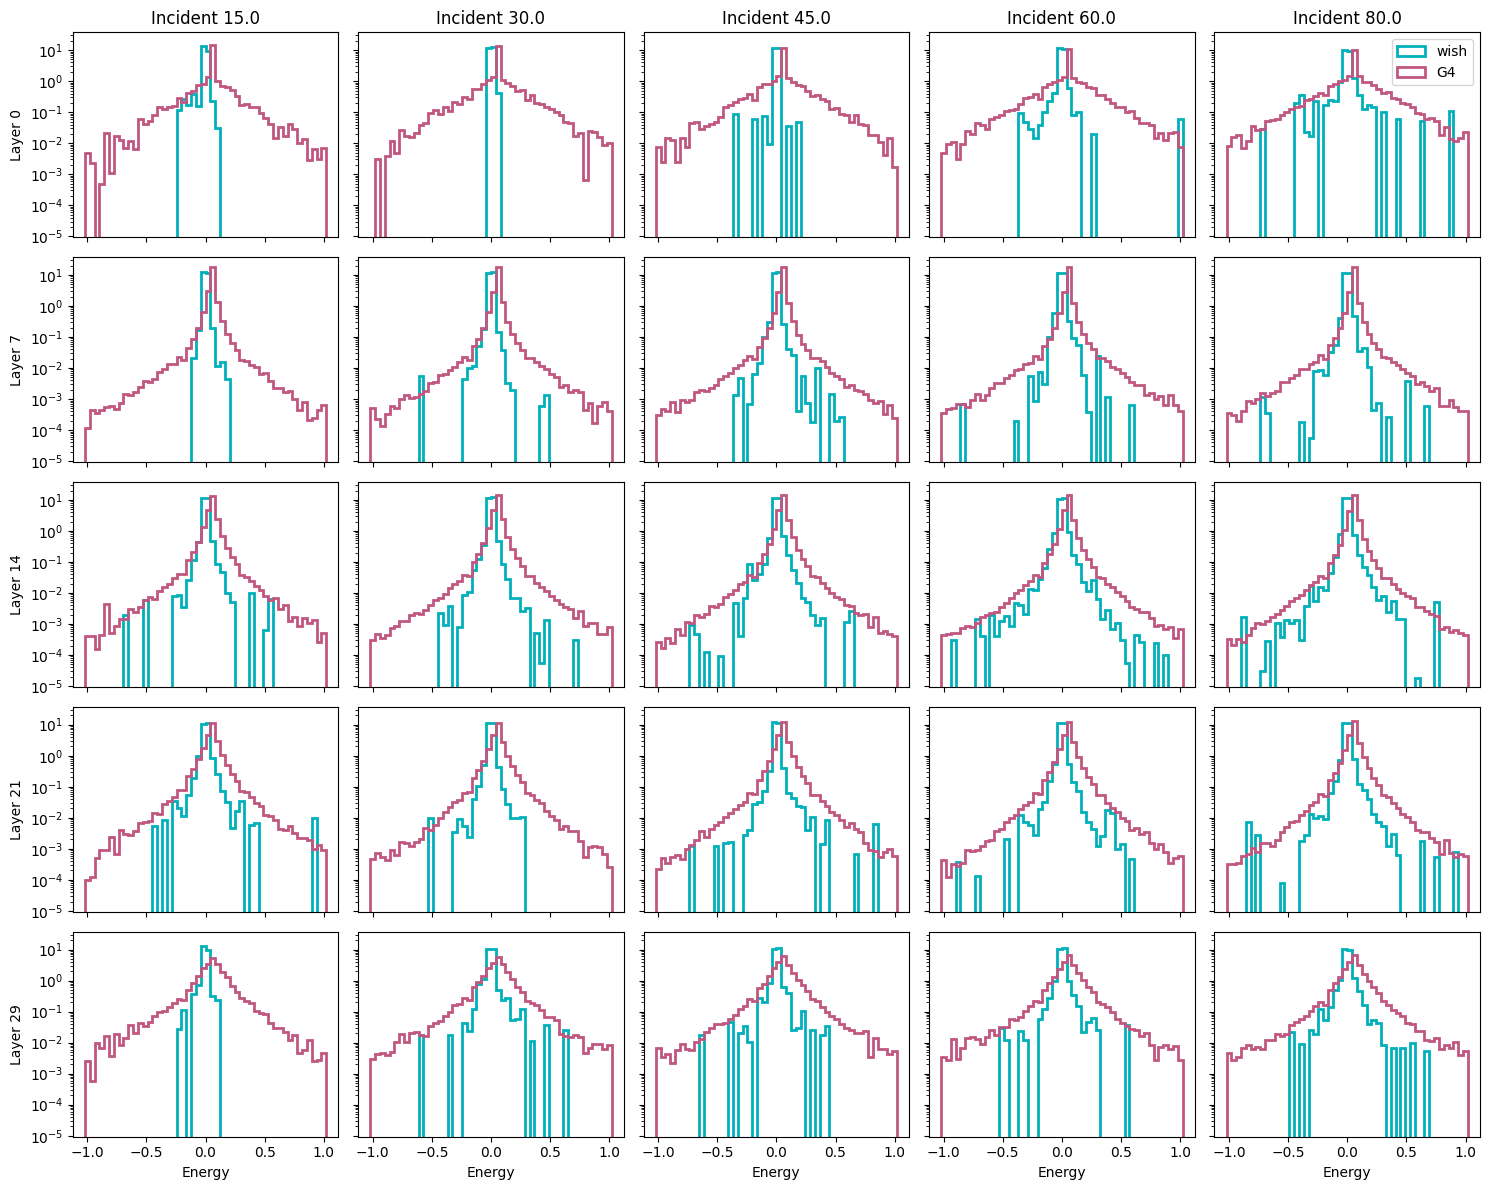

In [20]:
fig_e, axarr_e = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))

# which dimensions should be logs?
log_y = True


global_hist_params = dict(bins=z_bins, histtype="step", lw=2, density=True)
g4_hist_params = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
wish_hist_params = dict(label="wish", color=nice_hex[2][3], **global_hist_params)

from scipy.stats import lognorm
stats_params = dict(lw=2, c="black", label="High level stats", alpha=0.5)
stats_params2 = dict(lw=2, c="green", label="Raw stats", alpha=0.8)

for energy_slice_n, energy_index in enumerate(energy_indices):
    for intrest_n, layer_n in enumerate(layers_of_intrest):
        ax = axarr_e[intrest_n][energy_slice_n]
        if intrest_n == 0:
            ax.set_title(f"Incident {accumulated_stats.incident_bin_boundaries[energy_index]}")
        if intrest_n == len(layers_of_intrest) -1:
            ax.set_xlabel("Energy")
        if energy_slice_n == 0:
            ax.set_ylabel(f"Layer {layer_n}")
        this_wish_e = np.sum(wish_lateral_sumE_per_event[energy_index, layer_n], axis=0)
        ax.hist(z_values, weights=this_wish_e, **wish_hist_params)
        this_g4_e = np.sum(g4_lateral_sumE_per_event[energy_index, layer_n], axis=0)
        ax.hist(z_values, weights=this_g4_e, **g4_hist_params)
        if log_y:
            ax.semilogy()
            
        # calculate theory from stats and add
        if log_y:
            pass
            #ax.set_ylim(8e-5, 0.16)
        else:
            pass
            #ax.set_ylim(0, 0.01)

axarr_e[0][-1].legend()
plt.tight_layout()
        

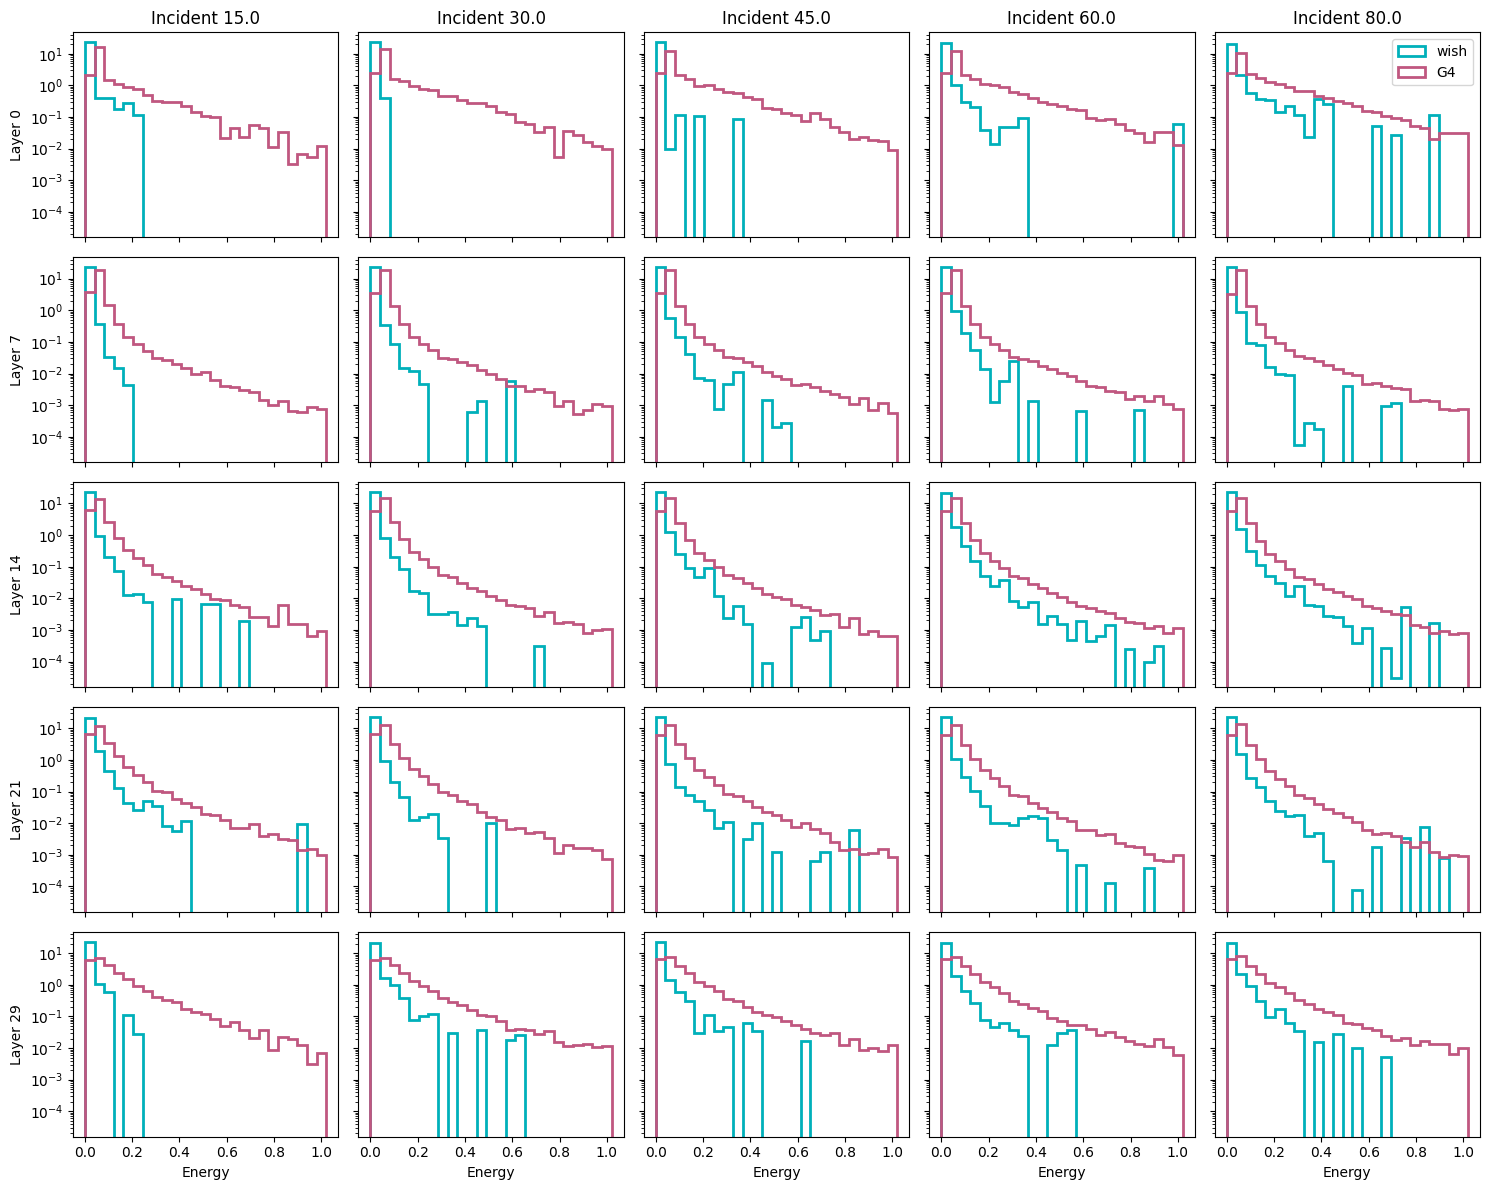

In [21]:
fig_e, axarr_e = plt.subplots(len(layers_of_intrest), n_energy_slices, sharey=True, sharex=True, figsize=(15, 12))

# which dimensions should be logs?
log_y = True


global_hist_params = dict(bins=positive_z_bins, histtype="step", lw=2, density=True)
g4_hist_params = dict(label="G4", color=nice_hex[2][0], **global_hist_params)
wish_hist_params = dict(label="wish", color=nice_hex[2][3], **global_hist_params)

from scipy.stats import lognorm
stats_params = dict(lw=2, c="black", label="High level stats", alpha=0.5)
stats_params2 = dict(lw=2, c="green", label="Raw stats", alpha=0.8)

for energy_slice_n, energy_index in enumerate(energy_indices):
    for intrest_n, layer_n in enumerate(layers_of_intrest):
        ax = axarr_e[intrest_n][energy_slice_n]
        if intrest_n == 0:
            ax.set_title(f"Incident {accumulated_stats.incident_bin_boundaries[energy_index]}")
        if intrest_n == len(layers_of_intrest) -1:
            ax.set_xlabel("Energy")
        if energy_slice_n == 0:
            ax.set_ylabel(f"Layer {layer_n}")
        this_wish_e = np.sum(wish_lateral_sumE_per_event[energy_index, layer_n], axis=0)
        ax.hist(positive_z, weights=this_wish_e[positive_z_mask] + this_wish_e[negative_z_mask],
                **wish_hist_params)
        this_g4_e = np.sum(g4_lateral_sumE_per_event[energy_index, layer_n], axis=0)
        ax.hist(positive_z, weights=this_g4_e[positive_z_mask] + this_g4_e[negative_z_mask],
                **g4_hist_params)
        if log_y:
            ax.semilogy()
            
        # calculate theory from stats and add
        if log_y:
            pass
            #ax.set_ylim(8e-5, 0.16)
        else:
            pass
            #ax.set_ylim(0, 0.01)

axarr_e[0][-1].legend()
plt.tight_layout()
        